**Лабораторный практикум по курсу «Распознавание диктора», Университет ИТМО, 2021**		

**Лабораторная работа №3. Построение дикторских моделей и их сравнение**

**Цель работы:** изучение процедуры построения дикторских моделей с использованием глубоких нейросетевых архитектур.

**Краткое описание:** в рамках настоящей лабораторной работы предлагается изучить и реализовать схему построения дикторских моделей с использованием глубокой нейросетевой архитектуры, построенной на основе ResNet-блоков. Процедуры обучения и тестирования предлагается рассмотреть по отношению к задаче идентификации на закрытом множестве, то есть для ситуации, когда дикторские классы являются строго заданными. Тестирование полученной системы предполагает использование доли правильных ответов (accuracy) в качестве целевой метрики оценки качества.

**Данные:** в качестве данных для выполнения лабораторной работы предлагается использовать базу [VoxCeleb1](http://www.robots.ox.ac.uk/~vgg/data/voxceleb/vox1.html).

**Содержание лабораторной работы**

1. Подготовка данных для обучения и тестирования блока построения дикторских моделей.							

2. Обучение параметров блока построения дикторских моделей без учёта процедуры аугментации данных.

3. Обучение параметров блока построения дикторских моделей с учётом процедуры аугментации данных.

4. Тестированное блока построения дикторских моделей.

In [1]:
# IPython extension to reload modules before executing user code

%load_ext autoreload
%autoreload 2

# Import of modules
import os
import sys

sys.path.append(os.path.realpath('..'))

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
# import torch.profiler

from common import download_dataset, concatenate, extract_dataset, part_extract, download_protocol, split_musan
from exercises_blank import train_dataset_loader, test_dataset_loader, ResNet, MainModel, train_network, test_network
from ResNetBlocks import BasicBlock
from LossFunction import AAMSoftmaxLoss
from Optimizer import SGDOptimizer
from Scheduler import OneCycleLRScheduler
from load_save_pth import saveParameters, loadParameters

**1. Подготовка данных для обучения и тестирования детектора речевой активности**

В ходе выполнения лабораторной работы необходимы данные для выполнения процедуры обучения и процедуры тестирования нейросетевого блока генерации дикторских моделей. Возьмём в качестве этих данных звукозаписи, сохраненные в формат *wav*, из корпуса [VoxCeleb1 dev set](https://www.robots.ox.ac.uk/~vgg/data/voxceleb/vox1.html). Данный корпус содержит 148,642 звукозаписи (частота дискретизации равна 16кГц) для 1,211 дикторов женского и мужского пола, разговаривающих преимущественно на английском языке.

В рамках настоящего пункта требуется выполнить загрузку и распаковку звуковых wav-файлов из корпуса VoxCeleb1 dev set.

![Рисунок 1](https://analyticsindiamag.com/wp-content/uploads/2020/12/image.png "VoxCeleb. Крупномасштабная аудиовизуальная база данных человеческой речи.")

In [2]:
# # Download VoxCeleb1 (test set)
# with open('../data/lists/datasets.txt', 'r') as f:
#     lines = f.readlines()

# download_dataset(lines, user='voxceleb1902', password='nx0bl2v2', save_path='../data')

In [3]:
# # # Concatenate archives for VoxCeleb1 dev set
# with open('../data/lists/concat_arch.txt', 'r') as f:
#     lines = f.readlines()
    
# concatenate(lines, save_path='../data')

In [4]:
# # # Extract VoxCeleb1 dev set
# extract_dataset(save_path='../data/voxceleb1_dev', fname='../data/vox1_dev_wav.zip')

In [5]:
# # # Download VoxCeleb1 identification protocol
# with open('../data/lists/protocols.txt', 'r') as f:
#     lines = f.readlines()
    
# download_protocol(lines, save_path='../data/voxceleb1_test')

**2. Обучение параметров блока построения дикторских моделей без учёта процедуры аугментации данных**

Построение современных дикторских моделей, как правило, выполняется с использованием нейросетевых архитектур, многие из которых позаимствованы из области обработки цифровых изображений. Одними из наиболее распространенных нейросетевых архитектур, используемыми для построения дикторских моделей, являются [ResNet-подобные архитектуры](https://arxiv.org/pdf/1512.03385.pdf). В рамках настоящего пункта предлагается выполнить адаптацию нейросетевой архитектуры ResNet34 для решения задачи генерации дикторских моделей (дикторских эмбеддингов). *Дикторский эмбеддинг* – это высокоуровневый вектор-признаков, состоящий, например, из 128, 256 и т.п. значений, содержащий особенности голоса конкретного человека. При решении задачи распознавания диктора можно выделить эталонные и тестовые дикторские эмбеддинги. *Эталонные эмбеддинги* формируются на этапе регистрации дикторской модели определённого человека и находятся в некотором хранилище данных. *Тестовые эмбеддинги* формируются на этапе непосредственного использования системы голосовой биометрии на практике, когда некоторый пользователь пытается получить доступ к соответствующим ресурсам. Система голосовой биометрии сравнивает по определённой метрике эталонные и тестовые эмбеддинги, формируя оценку сравнения, которая, после её обработки блоком принятия решения, позволяет сделать вывод о том, эмбеддинги одинаковых или разных дикторов сравниваются между собой.

Адаптация различных нейросетевых архитектур из обработки изображений к решению задачи построения дикторских моделей является непростой задачей. Возьмём за основу готовое решение, предложенной в рамках [следующей публикации](https://arxiv.org/pdf/2002.06033.pdf) и адаптируем его применительно к выполнению настоящей лабораторной работы.

Необходимо отметить, что построение дикторских моделей, как правило, требует наличия *акустических признаков*, вычисленных для звукозаписей тренировочной, валидационной и тестовой баз данных. В качестве примера подобных признаков в рамках настоящей лабораторной работы воспользуемся *логарифмами энергий на выходе мел-банка фильтров*. Важно отметить, что акустические признаки подвергаются некоторым процедурам предобработки перед их непосредственной передачей в блок построения дикторских моделей. В качестве этих процедур можно выделить: нормализация и масштабирование признаков, сохранение только речевых фреймов на основе разметки детектора речевой активности и т.п.

После того, как акустические признаки подготовлены, они могут быть переданы на блок построения дикторских моделей. Как правило, структура современных дикторских моделей соответствует структуре [x-векторных архитектур](https://www.danielpovey.com/files/2018_icassp_xvectors.pdf). Эти архитектуры состоят из четырёх ключевых элементов: 

1. **Фреймовый уровень.** Предназначен для формирования локальных представлений голоса конкретного человека. На этом уровне как раз и применяются нейросетевые архитектуры на базе свёрточных нейронных сетей, например, ResNet, позволяющих с использованием каскадной схемы из множества фильтров с локальной маской захватить некоторый локальный контекст шаблона голоса человека. Выходом фреймового уровня является набор высокоуровневых представлений (карт-признаков), содержащих локальные особенности голоса человека.

2. **Уровень статистического пулинга** позволяет сформировать промежуточный вектор-признаков, фиксированной длины, которая является одинаковой для звукозаписи любой длительности. В ходе работы блока статистического пулинга происходит удаление временной размерности, присутствующей в картах-признаков. Это достигается путём выполнения процедуры усреднения карт-признаков вдоль оси времени. Выходом уровня статистического пулинга являются вектор среднего и вектор среднеквадратического отклонения, вычисленные на основе карт-признаков. Эти вектора конкатенируются и передаются для дальнейшей обработки на сегментом уровне.

3. **Сегментный уровень.** Предназначен для трансформации промежуточного вектора, как правило, высокой размерности, в компактный вектор-признаков, представляющий собой дикторский эмбеддинг. Необходимо отметить, что на сегментном уровне расположены один или несколько полносвязных нейросетевых слоёв, а обработка данных выполняется по отношению ко всей звукозаписи, а не только к некоторому её локальному контексту, как на фреймовом уровне.

4. **Уровень выходного слоя.** Представляет полносвязный слой с softmax-функциями активации. Количество активаций равно числу дикторов в тренирочной выборке. На вход выходноя слоя подаётся дикторский эмбеддинг, а на выходе – формируется набор апостериорных вероятностей, определяющих принадлежность эмбеддинга к одному из дикторских классов в тренировочной выборке. Необходимо отметить, что, как правило, в современных нейросетевых системах построения дикторских моделей выходной используется только на этапе обучения параметров и на этапе тестирования не используется (на этапе тестирования используются только три первых уровня архитектуры).

Обучение модели генерации дикторских эмбеддингов выполняется путём решения задачи *классификации* или, выражаясь терминами из области биометрии, *идентификации на закрытом множестве* (количество дикторских меток является строго фиксированным). В качестве используемой стоимостной функции выступает *категориальная кросс-энтропия*. Обучение выполняется с помощью мини-батчей, содержащих короткие фрагменты карт акустических признаков (длительностью несколько секунд) различных дикторов из тренировочной базы данных. Обучение на коротких фрагментов позволяет избежать сильного переобучения нейросетевой модели. При выполнении процедуры обучения требуется подобрать набор гиперпараметров, выбрать обучения и метод численной оптимизации.

Для успешного выполнения настоящего пункта необходимо сделать следующее:

1. Сгенерировать списки тренировочных, валидационных и тестовых данных на основе идентификационного протокола базы VoxCeleb1, содержащегося в файле **../data/voxceleb1_test/iden_split.txt**. При генерации списков требуется исключить из них звукозаписи дикторов, которые входят в базу [VoxCeleb1 test set](https://thor.robots.ox.ac.uk/~vgg/data/voxceleb/vox1a/vox1_test_wav.zip). Это позволит выполнить тестирования обученных блоков генерации дикторских моделей на протоколе [VoxCeleb1-O cleaned](https://www.robots.ox.ac.uk/~vgg/data/voxceleb/meta/veri_test2.txt), который составлен по отношению к данным из VoxCeleb1 test set, в лабораторной работе №4.

2. Инициализировать обучаемую дикторскую модель, выбрав любой возможный вариант её архитектуры, предлагаемый в рамках лабораторной работы. При реализации блока статистического пулинга предлагается выбрать либо его классический вариант, предложенный в [следующей работе](https://www.danielpovey.com/files/2018_icassp_xvectors.pdf), либо его более продвинутую версию основанную на использовании [механизмов внимания](https://arxiv.org/pdf/1803.10963.pdf). Использование последней версии статистического пулинга позволяет реализовать детектор речевой активности прямо внутри блока построения дикторских моделей.

3. Инициализировать загрузчики тренировочной и валидационной выборки.

4. Инициализировать оптимизатор и планировщик для выполнения процедуры обучения.

5. Описать процедуру валидации/тестирования блока построения дикторских моделей.

6. Описать процедуру обучения и запустить её, контролируя значения стоимостной функции и доли правильных ответов на тренировочном множестве, а также долю правильных ответов на валидационном множестве.

In [6]:
# Select hyperparameters

# Acoustic features
n_mels            = 40                                   # number of mel filters in bank filters
log_input         = True                                 # logarithm of features by level

# Neural network architecture
layers            = [3, 4, 6, 3]                         # number of ResNet blocks in different level of frame level
activation        = nn.LeakyReLU                         # activation function used in ResNet blocks
num_filters       = [32, 64, 128, 256]                   # number of filters of ResNet blocks in different level of frame level
encoder_type      = 'SP'                                 # type of statistic pooling layer ('SP'  – classical statistic pooling 
                                                         # layer and 'ASP' – attentive statistic pooling)
nOut              = 512                                  # embedding size

# Loss function for angular losses
margin            = 0.35                                 # margin parameter
scale             = 32.0                                 # scale parameter

# Train dataloader
max_frames_train  = 200                                  # number of frame to train
train_path        = '../data/voxceleb1_dev/wav'          # path to train wav files
batch_size_train  = 16                                  # batch size to train
pin_memory        = False                                # pin memory
num_workers_train = 4                                    # number of workers to train
shuffle           = True                                 # shuffling of training examples

# Validation dataloader
max_frames_val    = 1000                                 # number of frame to validate
val_path          = '../data/voxceleb1_dev/wav'          # path to val wav files
batch_size_val    = 16                                  # batch size to validate
num_workers_val   = 4                                    # number of workers to validate

# Test dataloader
max_frames_test   = 1000                                 # number of frame to test
test_path         = '../data/voxceleb1_dev/wav'          # path to val wav files
batch_size_test   = 16                                  # batch size to test
num_workers_test  = 4                                    # number of workers to test

# Optimizer
lr                = 2.5                                  # learning rate value
weight_decay      = 0                                    # weight decay value

# Scheduler
val_interval      = 1                                    # frequency of validation step
max_epoch         = 40                                   # number of epochs

# Augmentation
musan_path        = '../data/musan_split'                # path to splitted SLR17 dataset
rir_path          = '../data/RIRS_NOISES/simulated_rirs' # path to SLR28 dataset

In [7]:
# Generate data lists
train_list = []
val_list   = []
test_list  = []

with open('../data/voxceleb1_test/iden_split.txt', 'r') as f:
    lines = f.readlines()
    
black_list = os.listdir('../data/voxceleb1_test/wav')   # exclude speaker IDs from VoxCeleb1 test set
num_train_spk = []                                      # number of train speakers

for line in lines:
    line   = line.strip().split(' ')
    spk_id = line[1].split('/')[0]
    
    if not (spk_id in black_list):
        num_train_spk.append(spk_id)
        
    else:
        continue
    
    # Train list
    if (line[0] == '1'):
        train_list.append(' '.join([spk_id, line[1]]))
    
    # Validation list
    elif (line[0] == '2'):
        val_list.append(' '.join([spk_id, line[1]]))
    
    # Test list
    elif (line[0] == '3'):
        test_list.append(' '.join([spk_id, line[1]]))
        
num_train_spk = len(set(num_train_spk))

In [8]:
# Initialize model
model      = ResNet(BasicBlock, layers=layers, activation=activation, num_filters=num_filters, nOut=nOut, encoder_type=encoder_type, n_mels=n_mels, log_input=log_input)
trainfunc  = AAMSoftmaxLoss(nOut=nOut, nClasses=num_train_spk, margin=margin, scale=scale)
main_model = MainModel(model, trainfunc).cuda()

Embedding size is 512, encoder SP.
Initialised AAM softmax margin 0.350 scale 32.000.


In [9]:
# Initialize train dataloader (without augmentation)
train_dataset = train_dataset_loader(train_list=train_list, max_frames=max_frames_train, train_path=train_path)
train_loader  = DataLoader(train_dataset, batch_size=batch_size_train, pin_memory=pin_memory, num_workers=num_workers_train, shuffle=shuffle) 

# Initialize validation dataloader
val_dataset = test_dataset_loader(test_list=val_list, max_frames=max_frames_val, test_path=val_path)
val_loader  = DataLoader(val_dataset, batch_size=batch_size_val, num_workers=num_workers_val)

In [10]:
# Initialize optimizer and scheduler
optimizer = SGDOptimizer(main_model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = OneCycleLRScheduler(optimizer, 
                                pct_start=0.30, 
                                cycle_momentum=False, 
                                max_lr=lr, 
                                div_factor=20, 
                                final_div_factor=10000, 
                                total_steps=max_epoch*len(train_loader))

Initialised SGD optimizer.
Initialised OneCycle LR scheduler.


In [ ]:
path_to_save = './runs/ResNet_without_augmentation'
writer = SummaryWriter(path_to_save)
writer.add_graph(main_model, next(iter(train_loader))[0].cuda())

start_epoch = 0
checkpoint_flag = False

if checkpoint_flag:
    start_epoch = loadParameters(main_model, optimizer, scheduler, path='../data/lab3_models/lab3_model_0004.pth')
    start_epoch = start_epoch + 1
   
for num_epoch in range(start_epoch, max_epoch):
    train_loss, train_top1 = train_network(train_loader, main_model, optimizer, scheduler, num_epoch, verbose=True)

    writer.add_scalar("Top1/train", train_top1, num_epoch)
    writer.add_scalar("Loss/train", train_loss, num_epoch)
    
    print("Epoch {:1.0f}, Loss (train set) {:f}, Accuracy (train set) {:2.3f}%".format(num_epoch, train_loss, train_top1))

    if (num_epoch + 1)%val_interval == 0:
        _, val_top1 = test_network(val_loader, main_model)
        
        print("Epoch {:1.0f}, Accuracy (validation set) {:2.3f}%".format(num_epoch, val_top1))
        
        writer.add_scalar("Top1/test", val_top1, num_epoch/val_interval)
        
        saveParameters(main_model, optimizer, scheduler, num_epoch, path='../data/lab3_models')

writer.flush()
writer.close()

**3. Обучение параметров блока построения дикторских моделей с учётом процедуры аугментации данных**

Известно, что рроцедуры формирования и передачи речевого сигнала могут сопровождаться воздействием шумов и помех, приводящих к искажению сигнала. В качестве примеров искажающих факторов, влияющих на ухудшение качестве речевого сигнала можно привести: импульсный отклик помещения (реверберация), фоновый шум голосов группы нецелевых дикторов, звук телевизора или радиоприёмника и т.п. Разработка конвейера системы голосовой биометрии требует учёта воздействия искажающих факторов на качество её работы. Поскольку процедура построения современных дикторских моделей основана на обучении глубоких нейронных сетей, требующих большие объёмы данных для обучения их параметров, возможным вариантом увеличения тренировочной выборки может являться использование методов аугментации статистических данных. *Аугментация* – методика создания дополнительных обучающих примеров из имеющихся данных путём внесения в них искажений, которые могут потенциально возникнуть на этапе итогового тестирования системы.

Как правило, при решении задачи аугментации данных в речевой обработке используются дополнительные базы шумов и помех. В качестве примеров можно привести базы [SLR17](https://openslr.org/17/) (корпус музыкальных, речевых и шумовых звукозаписей) и [SLR28](https://openslr.org/28/) (база данных реальных и симулированных импульсных откликов комнат, а также изотропных и точечных шумов). Важно отметить, что перед применением с использованием методов аугментации подобных баз к имеющимся данным, требуется убедиться, что частоты дискретизации искажающих баз и оригинальных данных являются одинаковыми. Применительно к рассматриваемому лабораторному практикуму частоты дискретизации всех используемых звукозаписей должны быть равными 16кГц.

Как известно, можно выделить два режима аугментации данных: *онлайн* (применяется в ходе процедуры обучения) и *оффлайн* (применяется до процедуры обучения) аугментацию. В рамках настоящей лабораторной работы предлагается использовать онлайн аугментацию в силу не очень большого набора тренировочных данных и большей гибкости экспериментов, чем вс случае онлайн аугментации. Необходимо отметить, что применение онлайн аугментации на практике замедляет процедуру обучения, по сравнению с оффлайн аугментацией, так как наложение искажений, извлечение акустических признаков и их возможная предобработка требует определённого машинного времени.

В рамках настоящего пункта предлагается сделать следующее:

1. Загрузить и извлечь данные из базы SLR17 (MUSAN). Частота дискретизации данных в рассматриваемой базе равна 16кГц по умолчанию. Поскольку звукозаписи рассматриваемой базы являются достаточно длинными, рекомендуется предварительно разбить эту базу на более маленькие фрагменты (например, длительностью 5 секунд с шагом 3 секунды), сохранив их на диск. 

2. Загрузить и извлечь данные из базы SLR28 (MUSAN). Частота дискретизации данных в рассматриваемой базе равна 16кГц по умолчанию.

3. Модернизировать загрузчик тренировочных данных под возможность случайного наложения (искажаем исходные звукозаписи) и не наложения (не искажаем исходные звукозаписи) одного из четырёх типов искажений (реверберация, музыкальный шум, фоновый шум голосов нескольких дикторов, неструктурированный шум), описанных внутри класса **AugmentWAV** следующего программного кода: **../common/DatasetLoader.py**.

4. Используя процедуру обучения из предыдущего пункта с идентичными настройками выполнить тренировку параметров блока генерации дикторских моделей на исходных данных при наличии их аугментирвоанных копий.

In [11]:
# # Download SLR17 (MUSAN) and SLR28 (RIR noises) datasets
# with open('../data/lists/augment_datasets.txt', 'r') as f:
#     lines = f.readlines()
    
# download_dataset(lines, user=None, password=None, save_path='../data')

In [12]:
# # Extract SLR17 (MUSAN)
# extract_dataset(save_path='../data', fname='../data/musan.tar.gz')

# # Extract SLR28 (RIR noises)
# part_extract(save_path='../data', fname='../data/rirs_noises.zip', target=['RIRS_NOISES/simulated_rirs/mediumroom', 'RIRS_NOISES/simulated_rirs/smallroom'])

In [13]:
# # Split MUSAN (SLR17) dataset for faster random access
# split_musan(save_path='../data')

In [14]:
# Initialize model
model      = ResNet(BasicBlock, layers=layers, activation=activation, num_filters=num_filters, nOut=nOut, encoder_type=encoder_type, n_mels=n_mels, log_input=log_input)
trainfunc  = AAMSoftmaxLoss(nOut=nOut, nClasses=num_train_spk, margin=margin, scale=scale)
main_model = MainModel(model, trainfunc).cuda()

Embedding size is 512, encoder SP.
Initialised AAM softmax margin 0.350 scale 32.000.


In [15]:
# Initialize train dataloader (without augmentation)
train_dataset = train_dataset_loader(train_list=train_list, 
                                     max_frames=max_frames_train, 
                                     train_path=train_path, 
                                     augment=True, 
                                     musan_path=musan_path, 
                                     rir_path=rir_path)

train_loader  = DataLoader(train_dataset, batch_size=batch_size_train, pin_memory=pin_memory, num_workers=num_workers_train, shuffle=shuffle)

# Initialize validation dataloader
val_dataset = test_dataset_loader(test_list=val_list, max_frames=max_frames_val, test_path=val_path)
val_loader  = DataLoader(val_dataset, batch_size=batch_size_val, num_workers=num_workers_val)

In [16]:
# Initialize optimizer and scheduler
optimizer = SGDOptimizer(main_model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = OneCycleLRScheduler(optimizer, 
                                pct_start=0.30, 
                                cycle_momentum=False, 
                                max_lr=lr, 
                                div_factor=20, 
                                final_div_factor=10000, 
                                total_steps=max_epoch*len(train_loader))

Initialised SGD optimizer.
Initialised OneCycle LR scheduler.


In [ ]:
path_to_save = './runs/ResNet_with_augmentation'
writer = SummaryWriter(path_to_save)
writer.add_graph(main_model, next(iter(train_loader))[0].cuda())

start_epoch = 0
checkpoint_flag = False

if checkpoint_flag:
    start_epoch = loadParameters(main_model, optimizer, scheduler, path='../data/lab3_models_aug/lab3_model_0004.pth')
    start_epoch = start_epoch + 1
   
for num_epoch in range(start_epoch, max_epoch):
    train_loss, train_top1 = train_network(train_loader, main_model, optimizer, scheduler, num_epoch, verbose=True)

    writer.add_scalar("Top1/train", train_top1, num_epoch)
    writer.add_scalar("Loss/train", train_loss, num_epoch)
    
    print("Epoch {:1.0f}, Loss (train set) {:f}, Accuracy (train set) {:2.3f}%".format(num_epoch, train_loss, train_top1))

    if (num_epoch + 1)%val_interval == 0:
        _, val_top1 = test_network(val_loader, main_model)
        
        print("Epoch {:1.0f}, Accuracy (validation set) {:2.3f}%".format(num_epoch, val_top1))
        
        writer.add_scalar("Top1/test", val_top1, num_epoch/val_interval)
        
        saveParameters(main_model, optimizer, scheduler, num_epoch, path='../data/lab3_models_aug')

writer.flush()
writer.close()

Epoch 1, Batch 494, LR 0.211973 Loss 13.726121, Accuracy 31.536%
Epoch 1, Batch 495, LR 0.212085 Loss 13.724342, Accuracy 31.553%
Epoch 1, Batch 496, LR 0.212196 Loss 13.723010, Accuracy 31.571%
Epoch 1, Batch 497, LR 0.212308 Loss 13.721512, Accuracy 31.572%
Epoch 1, Batch 498, LR 0.212420 Loss 13.720065, Accuracy 31.590%
Epoch 1, Batch 499, LR 0.212532 Loss 13.718787, Accuracy 31.599%
Epoch 1, Batch 500, LR 0.212643 Loss 13.716822, Accuracy 31.603%
Epoch 1, Batch 501, LR 0.212755 Loss 13.715209, Accuracy 31.618%
Epoch 1, Batch 502, LR 0.212868 Loss 13.714168, Accuracy 31.616%
Epoch 1, Batch 503, LR 0.212980 Loss 13.713108, Accuracy 31.618%
Epoch 1, Batch 504, LR 0.213092 Loss 13.711141, Accuracy 31.641%
Epoch 1, Batch 505, LR 0.213204 Loss 13.710305, Accuracy 31.643%
Epoch 1, Batch 506, LR 0.213317 Loss 13.709068, Accuracy 31.658%
Epoch 1, Batch 507, LR 0.213429 Loss 13.706287, Accuracy 31.683%
Epoch 1, Batch 508, LR 0.213541 Loss 13.704394, Accuracy 31.702%
Epoch 1, Batch 509, LR 0.

Epoch 1, Batch 621, LR 0.226693 Loss 13.556568, Accuracy 32.979%
Epoch 1, Batch 622, LR 0.226813 Loss 13.555038, Accuracy 32.992%
Epoch 1, Batch 623, LR 0.226933 Loss 13.553958, Accuracy 33.003%
Epoch 1, Batch 624, LR 0.227054 Loss 13.553338, Accuracy 33.010%
Epoch 1, Batch 625, LR 0.227174 Loss 13.551256, Accuracy 33.029%
Epoch 1, Batch 626, LR 0.227295 Loss 13.551372, Accuracy 33.035%
Epoch 1, Batch 627, LR 0.227415 Loss 13.549684, Accuracy 33.046%
Epoch 1, Batch 628, LR 0.227536 Loss 13.548665, Accuracy 33.068%
Epoch 1, Batch 629, LR 0.227657 Loss 13.546736, Accuracy 33.092%
Epoch 1, Batch 630, LR 0.227778 Loss 13.545203, Accuracy 33.108%
Epoch 1, Batch 631, LR 0.227898 Loss 13.543513, Accuracy 33.117%
Epoch 1, Batch 632, LR 0.228019 Loss 13.541363, Accuracy 33.134%
Epoch 1, Batch 633, LR 0.228140 Loss 13.540273, Accuracy 33.142%
Epoch 1, Batch 634, LR 0.228261 Loss 13.539788, Accuracy 33.153%
Epoch 1, Batch 635, LR 0.228383 Loss 13.538838, Accuracy 33.164%
Epoch 1, Batch 636, LR 0.

Epoch 1, Batch 748, LR 0.242507 Loss 13.392659, Accuracy 34.313%
Epoch 1, Batch 749, LR 0.242636 Loss 13.391425, Accuracy 34.319%
Epoch 1, Batch 750, LR 0.242765 Loss 13.390797, Accuracy 34.325%
Epoch 1, Batch 751, LR 0.242894 Loss 13.389527, Accuracy 34.338%
Epoch 1, Batch 752, LR 0.243023 Loss 13.387710, Accuracy 34.356%
Epoch 1, Batch 753, LR 0.243152 Loss 13.385397, Accuracy 34.376%
Epoch 1, Batch 754, LR 0.243281 Loss 13.383986, Accuracy 34.392%
Epoch 1, Batch 755, LR 0.243411 Loss 13.382758, Accuracy 34.399%
Epoch 1, Batch 756, LR 0.243540 Loss 13.381623, Accuracy 34.409%
Epoch 1, Batch 757, LR 0.243669 Loss 13.380702, Accuracy 34.412%
Epoch 1, Batch 758, LR 0.243799 Loss 13.380523, Accuracy 34.413%
Epoch 1, Batch 759, LR 0.243928 Loss 13.379232, Accuracy 34.423%
Epoch 1, Batch 760, LR 0.244058 Loss 13.377881, Accuracy 34.434%
Epoch 1, Batch 761, LR 0.244187 Loss 13.376573, Accuracy 34.441%
Epoch 1, Batch 762, LR 0.244317 Loss 13.375109, Accuracy 34.455%
Epoch 1, Batch 763, LR 0.

Epoch 1, Batch 875, LR 0.259401 Loss 13.245443, Accuracy 35.500%
Epoch 1, Batch 876, LR 0.259539 Loss 13.244156, Accuracy 35.511%
Epoch 1, Batch 877, LR 0.259676 Loss 13.242965, Accuracy 35.527%
Epoch 1, Batch 878, LR 0.259813 Loss 13.241449, Accuracy 35.534%
Epoch 1, Batch 879, LR 0.259951 Loss 13.240739, Accuracy 35.535%
Epoch 1, Batch 880, LR 0.260088 Loss 13.239198, Accuracy 35.542%
Epoch 1, Batch 881, LR 0.260226 Loss 13.237894, Accuracy 35.561%
Epoch 1, Batch 882, LR 0.260364 Loss 13.236905, Accuracy 35.567%
Epoch 1, Batch 883, LR 0.260501 Loss 13.235790, Accuracy 35.576%
Epoch 1, Batch 884, LR 0.260639 Loss 13.234194, Accuracy 35.585%
Epoch 1, Batch 885, LR 0.260777 Loss 13.233113, Accuracy 35.591%
Epoch 1, Batch 886, LR 0.260915 Loss 13.232331, Accuracy 35.597%
Epoch 1, Batch 887, LR 0.261053 Loss 13.230817, Accuracy 35.605%
Epoch 1, Batch 888, LR 0.261191 Loss 13.229997, Accuracy 35.615%
Epoch 1, Batch 889, LR 0.261329 Loss 13.230373, Accuracy 35.616%
Epoch 1, Batch 890, LR 0.

Epoch 1, Batch 1002, LR 0.277357 Loss 13.100090, Accuracy 36.635%
Epoch 1, Batch 1003, LR 0.277503 Loss 13.098490, Accuracy 36.648%
Epoch 1, Batch 1004, LR 0.277648 Loss 13.097828, Accuracy 36.651%
Epoch 1, Batch 1005, LR 0.277794 Loss 13.096333, Accuracy 36.668%
Epoch 1, Batch 1006, LR 0.277940 Loss 13.095334, Accuracy 36.675%
Epoch 1, Batch 1007, LR 0.278086 Loss 13.094057, Accuracy 36.687%
Epoch 1, Batch 1008, LR 0.278232 Loss 13.093432, Accuracy 36.689%
Epoch 1, Batch 1009, LR 0.278378 Loss 13.092375, Accuracy 36.698%
Epoch 1, Batch 1010, LR 0.278524 Loss 13.091235, Accuracy 36.705%
Epoch 1, Batch 1011, LR 0.278670 Loss 13.090507, Accuracy 36.709%
Epoch 1, Batch 1012, LR 0.278816 Loss 13.089758, Accuracy 36.718%
Epoch 1, Batch 1013, LR 0.278962 Loss 13.088164, Accuracy 36.731%
Epoch 1, Batch 1014, LR 0.279108 Loss 13.087593, Accuracy 36.736%
Epoch 1, Batch 1015, LR 0.279255 Loss 13.086723, Accuracy 36.743%
Epoch 1, Batch 1016, LR 0.279401 Loss 13.085790, Accuracy 36.747%
Epoch 1, B

Epoch 2, Batch 81, LR 0.296204 Loss 11.730036, Accuracy 47.840%
Epoch 2, Batch 82, LR 0.296357 Loss 11.732121, Accuracy 47.799%
Epoch 2, Batch 83, LR 0.296511 Loss 11.734713, Accuracy 47.797%
Epoch 2, Batch 84, LR 0.296665 Loss 11.733888, Accuracy 47.777%
Epoch 2, Batch 85, LR 0.296819 Loss 11.736364, Accuracy 47.739%
Epoch 2, Batch 86, LR 0.296972 Loss 11.738282, Accuracy 47.702%
Epoch 2, Batch 87, LR 0.297126 Loss 11.740370, Accuracy 47.692%
Epoch 2, Batch 88, LR 0.297280 Loss 11.742149, Accuracy 47.638%
Epoch 2, Batch 89, LR 0.297434 Loss 11.740331, Accuracy 47.656%
Epoch 2, Batch 90, LR 0.297589 Loss 11.740658, Accuracy 47.613%
Epoch 2, Batch 91, LR 0.297743 Loss 11.741292, Accuracy 47.630%
Epoch 2, Batch 92, LR 0.297897 Loss 11.742734, Accuracy 47.614%
Epoch 2, Batch 93, LR 0.298051 Loss 11.738418, Accuracy 47.639%
Epoch 2, Batch 94, LR 0.298206 Loss 11.738544, Accuracy 47.698%
Epoch 2, Batch 95, LR 0.298360 Loss 11.745143, Accuracy 47.664%
Epoch 2, Batch 96, LR 0.298515 Loss 11.7

Epoch 2, Batch 208, LR 0.316220 Loss 11.660578, Accuracy 48.216%
Epoch 2, Batch 209, LR 0.316382 Loss 11.661876, Accuracy 48.198%
Epoch 2, Batch 210, LR 0.316544 Loss 11.658521, Accuracy 48.211%
Epoch 2, Batch 211, LR 0.316705 Loss 11.652137, Accuracy 48.271%
Epoch 2, Batch 212, LR 0.316867 Loss 11.652423, Accuracy 48.294%
Epoch 2, Batch 213, LR 0.317029 Loss 11.651851, Accuracy 48.313%
Epoch 2, Batch 214, LR 0.317191 Loss 11.652390, Accuracy 48.302%
Epoch 2, Batch 215, LR 0.317353 Loss 11.649787, Accuracy 48.318%
Epoch 2, Batch 216, LR 0.317515 Loss 11.648994, Accuracy 48.318%
Epoch 2, Batch 217, LR 0.317677 Loss 11.649564, Accuracy 48.304%
Epoch 2, Batch 218, LR 0.317839 Loss 11.647812, Accuracy 48.312%
Epoch 2, Batch 219, LR 0.318002 Loss 11.649104, Accuracy 48.313%
Epoch 2, Batch 220, LR 0.318164 Loss 11.646682, Accuracy 48.335%
Epoch 2, Batch 221, LR 0.318326 Loss 11.647498, Accuracy 48.310%
Epoch 2, Batch 222, LR 0.318489 Loss 11.646546, Accuracy 48.318%
Epoch 2, Batch 223, LR 0.

Epoch 2, Batch 335, LR 0.337242 Loss 11.597484, Accuracy 48.514%
Epoch 2, Batch 336, LR 0.337411 Loss 11.598849, Accuracy 48.505%
Epoch 2, Batch 337, LR 0.337581 Loss 11.599568, Accuracy 48.495%
Epoch 2, Batch 338, LR 0.337750 Loss 11.598675, Accuracy 48.507%
Epoch 2, Batch 339, LR 0.337920 Loss 11.597091, Accuracy 48.507%
Epoch 2, Batch 340, LR 0.338090 Loss 11.598356, Accuracy 48.497%
Epoch 2, Batch 341, LR 0.338259 Loss 11.598127, Accuracy 48.504%
Epoch 2, Batch 342, LR 0.338429 Loss 11.596820, Accuracy 48.515%
Epoch 2, Batch 343, LR 0.338599 Loss 11.596597, Accuracy 48.508%
Epoch 2, Batch 344, LR 0.338769 Loss 11.595925, Accuracy 48.501%
Epoch 2, Batch 345, LR 0.338939 Loss 11.595497, Accuracy 48.512%
Epoch 2, Batch 346, LR 0.339109 Loss 11.593314, Accuracy 48.532%
Epoch 2, Batch 347, LR 0.339279 Loss 11.593892, Accuracy 48.532%
Epoch 2, Batch 348, LR 0.339450 Loss 11.595499, Accuracy 48.516%
Epoch 2, Batch 349, LR 0.339620 Loss 11.595764, Accuracy 48.514%
Epoch 2, Batch 350, LR 0.

Epoch 2, Batch 462, LR 0.359247 Loss 11.533522, Accuracy 48.867%
Epoch 2, Batch 463, LR 0.359424 Loss 11.533255, Accuracy 48.871%
Epoch 2, Batch 464, LR 0.359601 Loss 11.533055, Accuracy 48.875%
Epoch 2, Batch 465, LR 0.359778 Loss 11.533516, Accuracy 48.873%
Epoch 2, Batch 466, LR 0.359956 Loss 11.532719, Accuracy 48.885%
Epoch 2, Batch 467, LR 0.360133 Loss 11.530675, Accuracy 48.893%
Epoch 2, Batch 468, LR 0.360310 Loss 11.529338, Accuracy 48.907%
Epoch 2, Batch 469, LR 0.360488 Loss 11.528451, Accuracy 48.917%
Epoch 2, Batch 470, LR 0.360665 Loss 11.527334, Accuracy 48.926%
Epoch 2, Batch 471, LR 0.360843 Loss 11.526981, Accuracy 48.932%
Epoch 2, Batch 472, LR 0.361021 Loss 11.525710, Accuracy 48.946%
Epoch 2, Batch 473, LR 0.361198 Loss 11.525949, Accuracy 48.945%
Epoch 2, Batch 474, LR 0.361376 Loss 11.523054, Accuracy 48.973%
Epoch 2, Batch 475, LR 0.361554 Loss 11.522229, Accuracy 48.985%
Epoch 2, Batch 476, LR 0.361732 Loss 11.521050, Accuracy 49.002%
Epoch 2, Batch 477, LR 0.

Epoch 2, Batch 589, LR 0.382213 Loss 11.466615, Accuracy 49.488%
Epoch 2, Batch 590, LR 0.382398 Loss 11.466061, Accuracy 49.488%
Epoch 2, Batch 591, LR 0.382583 Loss 11.464479, Accuracy 49.502%
Epoch 2, Batch 592, LR 0.382767 Loss 11.464045, Accuracy 49.508%
Epoch 2, Batch 593, LR 0.382952 Loss 11.463345, Accuracy 49.509%
Epoch 2, Batch 594, LR 0.383137 Loss 11.462659, Accuracy 49.516%
Epoch 2, Batch 595, LR 0.383322 Loss 11.462030, Accuracy 49.526%
Epoch 2, Batch 596, LR 0.383507 Loss 11.460812, Accuracy 49.528%
Epoch 2, Batch 597, LR 0.383692 Loss 11.460069, Accuracy 49.541%
Epoch 2, Batch 598, LR 0.383877 Loss 11.458827, Accuracy 49.549%
Epoch 2, Batch 599, LR 0.384062 Loss 11.457867, Accuracy 49.566%
Epoch 2, Batch 600, LR 0.384247 Loss 11.457183, Accuracy 49.568%
Epoch 2, Batch 601, LR 0.384432 Loss 11.457228, Accuracy 49.565%
Epoch 2, Batch 602, LR 0.384618 Loss 11.457216, Accuracy 49.557%
Epoch 2, Batch 603, LR 0.384803 Loss 11.457460, Accuracy 49.556%
Epoch 2, Batch 604, LR 0.

Epoch 2, Batch 716, LR 0.406118 Loss 11.400514, Accuracy 49.963%
Epoch 2, Batch 717, LR 0.406310 Loss 11.400052, Accuracy 49.971%
Epoch 2, Batch 718, LR 0.406502 Loss 11.400298, Accuracy 49.972%
Epoch 2, Batch 719, LR 0.406694 Loss 11.399243, Accuracy 49.984%
Epoch 2, Batch 720, LR 0.406886 Loss 11.398389, Accuracy 49.997%
Epoch 2, Batch 721, LR 0.407078 Loss 11.398324, Accuracy 49.995%
Epoch 2, Batch 722, LR 0.407270 Loss 11.397214, Accuracy 50.001%
Epoch 2, Batch 723, LR 0.407462 Loss 11.397072, Accuracy 49.998%
Epoch 2, Batch 724, LR 0.407655 Loss 11.397132, Accuracy 49.992%
Epoch 2, Batch 725, LR 0.407847 Loss 11.396648, Accuracy 49.989%
Epoch 2, Batch 726, LR 0.408039 Loss 11.395991, Accuracy 49.992%
Epoch 2, Batch 727, LR 0.408232 Loss 11.395292, Accuracy 50.000%
Epoch 2, Batch 728, LR 0.408424 Loss 11.394973, Accuracy 50.001%
Epoch 2, Batch 729, LR 0.408617 Loss 11.393340, Accuracy 50.016%
Epoch 2, Batch 730, LR 0.408810 Loss 11.393278, Accuracy 50.015%
Epoch 2, Batch 731, LR 0.

Epoch 2, Batch 843, LR 0.430937 Loss 11.349016, Accuracy 50.318%
Epoch 2, Batch 844, LR 0.431136 Loss 11.349621, Accuracy 50.309%
Epoch 2, Batch 845, LR 0.431335 Loss 11.349284, Accuracy 50.312%
Epoch 2, Batch 846, LR 0.431534 Loss 11.349277, Accuracy 50.311%
Epoch 2, Batch 847, LR 0.431733 Loss 11.348921, Accuracy 50.315%
Epoch 2, Batch 848, LR 0.431932 Loss 11.348766, Accuracy 50.320%
Epoch 2, Batch 849, LR 0.432131 Loss 11.348186, Accuracy 50.317%
Epoch 2, Batch 850, LR 0.432331 Loss 11.347695, Accuracy 50.315%
Epoch 2, Batch 851, LR 0.432530 Loss 11.347547, Accuracy 50.313%
Epoch 2, Batch 852, LR 0.432730 Loss 11.347445, Accuracy 50.307%
Epoch 2, Batch 853, LR 0.432929 Loss 11.346402, Accuracy 50.314%
Epoch 2, Batch 854, LR 0.433129 Loss 11.346387, Accuracy 50.317%
Epoch 2, Batch 855, LR 0.433328 Loss 11.346792, Accuracy 50.317%
Epoch 2, Batch 856, LR 0.433528 Loss 11.346875, Accuracy 50.317%
Epoch 2, Batch 857, LR 0.433728 Loss 11.347146, Accuracy 50.314%
Epoch 2, Batch 858, LR 0.

Epoch 2, Batch 970, LR 0.456645 Loss 11.291728, Accuracy 50.764%
Epoch 2, Batch 971, LR 0.456850 Loss 11.291036, Accuracy 50.772%
Epoch 2, Batch 972, LR 0.457056 Loss 11.290413, Accuracy 50.780%
Epoch 2, Batch 973, LR 0.457262 Loss 11.290013, Accuracy 50.785%
Epoch 2, Batch 974, LR 0.457468 Loss 11.289625, Accuracy 50.780%
Epoch 2, Batch 975, LR 0.457675 Loss 11.289026, Accuracy 50.786%
Epoch 2, Batch 976, LR 0.457881 Loss 11.288592, Accuracy 50.784%
Epoch 2, Batch 977, LR 0.458087 Loss 11.288236, Accuracy 50.789%
Epoch 2, Batch 978, LR 0.458293 Loss 11.288178, Accuracy 50.785%
Epoch 2, Batch 979, LR 0.458499 Loss 11.287186, Accuracy 50.788%
Epoch 2, Batch 980, LR 0.458706 Loss 11.286657, Accuracy 50.792%
Epoch 2, Batch 981, LR 0.458912 Loss 11.286539, Accuracy 50.795%
Epoch 2, Batch 982, LR 0.459119 Loss 11.286281, Accuracy 50.795%
Epoch 2, Batch 983, LR 0.459325 Loss 11.285711, Accuracy 50.800%
Epoch 2, Batch 984, LR 0.459532 Loss 11.284813, Accuracy 50.804%
Epoch 2, Batch 985, LR 0.

Epoch 3, Batch 49, LR 0.483003 Loss 10.578773, Accuracy 57.270%
Epoch 3, Batch 50, LR 0.483216 Loss 10.568064, Accuracy 57.375%
Epoch 3, Batch 51, LR 0.483428 Loss 10.576276, Accuracy 57.322%
Epoch 3, Batch 52, LR 0.483641 Loss 10.574393, Accuracy 57.317%
Epoch 3, Batch 53, LR 0.483853 Loss 10.563354, Accuracy 57.400%
Epoch 3, Batch 54, LR 0.484066 Loss 10.559006, Accuracy 57.321%
Epoch 3, Batch 55, LR 0.484279 Loss 10.571265, Accuracy 57.287%
Epoch 3, Batch 56, LR 0.484492 Loss 10.578690, Accuracy 57.227%
Epoch 3, Batch 57, LR 0.484705 Loss 10.587568, Accuracy 57.127%
Epoch 3, Batch 58, LR 0.484918 Loss 10.586441, Accuracy 57.152%
Epoch 3, Batch 59, LR 0.485131 Loss 10.575797, Accuracy 57.256%
Epoch 3, Batch 60, LR 0.485344 Loss 10.572835, Accuracy 57.305%
Epoch 3, Batch 61, LR 0.485557 Loss 10.569108, Accuracy 57.377%
Epoch 3, Batch 62, LR 0.485770 Loss 10.562709, Accuracy 57.472%
Epoch 3, Batch 63, LR 0.485983 Loss 10.573072, Accuracy 57.316%
Epoch 3, Batch 64, LR 0.486196 Loss 10.5

Epoch 3, Batch 176, LR 0.510404 Loss 10.639272, Accuracy 56.436%
Epoch 3, Batch 177, LR 0.510623 Loss 10.637271, Accuracy 56.480%
Epoch 3, Batch 178, LR 0.510842 Loss 10.634431, Accuracy 56.513%
Epoch 3, Batch 179, LR 0.511061 Loss 10.633853, Accuracy 56.503%
Epoch 3, Batch 180, LR 0.511280 Loss 10.633072, Accuracy 56.515%
Epoch 3, Batch 181, LR 0.511499 Loss 10.634133, Accuracy 56.466%
Epoch 3, Batch 182, LR 0.511719 Loss 10.634691, Accuracy 56.447%
Epoch 3, Batch 183, LR 0.511938 Loss 10.637490, Accuracy 56.438%
Epoch 3, Batch 184, LR 0.512157 Loss 10.632121, Accuracy 56.492%
Epoch 3, Batch 185, LR 0.512377 Loss 10.631247, Accuracy 56.486%
Epoch 3, Batch 186, LR 0.512596 Loss 10.630635, Accuracy 56.510%
Epoch 3, Batch 187, LR 0.512816 Loss 10.626650, Accuracy 56.534%
Epoch 3, Batch 188, LR 0.513035 Loss 10.624758, Accuracy 56.562%
Epoch 3, Batch 189, LR 0.513255 Loss 10.625136, Accuracy 56.577%
Epoch 3, Batch 190, LR 0.513474 Loss 10.624512, Accuracy 56.587%
Epoch 3, Batch 191, LR 0.

Epoch 3, Batch 303, LR 0.538614 Loss 10.578254, Accuracy 56.869%
Epoch 3, Batch 304, LR 0.538839 Loss 10.577899, Accuracy 56.872%
Epoch 3, Batch 305, LR 0.539064 Loss 10.580159, Accuracy 56.834%
Epoch 3, Batch 306, LR 0.539290 Loss 10.579986, Accuracy 56.824%
Epoch 3, Batch 307, LR 0.539515 Loss 10.580866, Accuracy 56.810%
Epoch 3, Batch 308, LR 0.539740 Loss 10.581426, Accuracy 56.805%
Epoch 3, Batch 309, LR 0.539966 Loss 10.580623, Accuracy 56.816%
Epoch 3, Batch 310, LR 0.540191 Loss 10.581254, Accuracy 56.809%
Epoch 3, Batch 311, LR 0.540417 Loss 10.582222, Accuracy 56.808%
Epoch 3, Batch 312, LR 0.540643 Loss 10.580414, Accuracy 56.823%
Epoch 3, Batch 313, LR 0.540868 Loss 10.581009, Accuracy 56.822%
Epoch 3, Batch 314, LR 0.541094 Loss 10.582217, Accuracy 56.810%
Epoch 3, Batch 315, LR 0.541320 Loss 10.582721, Accuracy 56.813%
Epoch 3, Batch 316, LR 0.541546 Loss 10.581885, Accuracy 56.831%
Epoch 3, Batch 317, LR 0.541772 Loss 10.580897, Accuracy 56.844%
Epoch 3, Batch 318, LR 0.

Epoch 3, Batch 430, LR 0.567604 Loss 10.572414, Accuracy 56.917%
Epoch 3, Batch 431, LR 0.567835 Loss 10.571467, Accuracy 56.919%
Epoch 3, Batch 432, LR 0.568067 Loss 10.571858, Accuracy 56.928%
Epoch 3, Batch 433, LR 0.568298 Loss 10.572540, Accuracy 56.903%
Epoch 3, Batch 434, LR 0.568529 Loss 10.573676, Accuracy 56.902%
Epoch 3, Batch 435, LR 0.568761 Loss 10.573150, Accuracy 56.906%
Epoch 3, Batch 436, LR 0.568992 Loss 10.573024, Accuracy 56.911%
Epoch 3, Batch 437, LR 0.569224 Loss 10.573335, Accuracy 56.915%
Epoch 3, Batch 438, LR 0.569456 Loss 10.574011, Accuracy 56.914%
Epoch 3, Batch 439, LR 0.569687 Loss 10.574262, Accuracy 56.910%
Epoch 3, Batch 440, LR 0.569919 Loss 10.572839, Accuracy 56.926%
Epoch 3, Batch 441, LR 0.570151 Loss 10.570983, Accuracy 56.930%
Epoch 3, Batch 442, LR 0.570382 Loss 10.570916, Accuracy 56.936%
Epoch 3, Batch 443, LR 0.570614 Loss 10.569487, Accuracy 56.950%
Epoch 3, Batch 444, LR 0.570846 Loss 10.568314, Accuracy 56.970%
Epoch 3, Batch 445, LR 0.

Epoch 3, Batch 557, LR 0.597345 Loss 10.537834, Accuracy 57.106%
Epoch 3, Batch 558, LR 0.597582 Loss 10.537396, Accuracy 57.100%
Epoch 3, Batch 559, LR 0.597820 Loss 10.537998, Accuracy 57.089%
Epoch 3, Batch 560, LR 0.598057 Loss 10.537374, Accuracy 57.091%
Epoch 3, Batch 561, LR 0.598294 Loss 10.536577, Accuracy 57.109%
Epoch 3, Batch 562, LR 0.598531 Loss 10.536583, Accuracy 57.112%
Epoch 3, Batch 563, LR 0.598769 Loss 10.536172, Accuracy 57.126%
Epoch 3, Batch 564, LR 0.599006 Loss 10.535684, Accuracy 57.128%
Epoch 3, Batch 565, LR 0.599243 Loss 10.534678, Accuracy 57.135%
Epoch 3, Batch 566, LR 0.599481 Loss 10.533983, Accuracy 57.144%
Epoch 3, Batch 567, LR 0.599718 Loss 10.533905, Accuracy 57.146%
Epoch 3, Batch 568, LR 0.599956 Loss 10.534860, Accuracy 57.141%
Epoch 3, Batch 569, LR 0.600193 Loss 10.534840, Accuracy 57.136%
Epoch 3, Batch 570, LR 0.600431 Loss 10.534952, Accuracy 57.135%
Epoch 3, Batch 571, LR 0.600669 Loss 10.535293, Accuracy 57.135%
Epoch 3, Batch 572, LR 0.

Epoch 3, Batch 684, LR 0.627808 Loss 10.493801, Accuracy 57.497%
Epoch 3, Batch 685, LR 0.628051 Loss 10.493550, Accuracy 57.500%
Epoch 3, Batch 686, LR 0.628293 Loss 10.493118, Accuracy 57.505%
Epoch 3, Batch 687, LR 0.628536 Loss 10.492593, Accuracy 57.503%
Epoch 3, Batch 688, LR 0.628779 Loss 10.493222, Accuracy 57.497%
Epoch 3, Batch 689, LR 0.629022 Loss 10.492754, Accuracy 57.501%
Epoch 3, Batch 690, LR 0.629265 Loss 10.491863, Accuracy 57.509%
Epoch 3, Batch 691, LR 0.629508 Loss 10.491442, Accuracy 57.512%
Epoch 3, Batch 692, LR 0.629751 Loss 10.491385, Accuracy 57.507%
Epoch 3, Batch 693, LR 0.629993 Loss 10.491002, Accuracy 57.505%
Epoch 3, Batch 694, LR 0.630237 Loss 10.490635, Accuracy 57.505%
Epoch 3, Batch 695, LR 0.630480 Loss 10.490106, Accuracy 57.510%
Epoch 3, Batch 696, LR 0.630723 Loss 10.490273, Accuracy 57.511%
Epoch 3, Batch 697, LR 0.630966 Loss 10.490612, Accuracy 57.501%
Epoch 3, Batch 698, LR 0.631209 Loss 10.489499, Accuracy 57.509%
Epoch 3, Batch 699, LR 0.

Epoch 3, Batch 811, LR 0.658961 Loss 10.462848, Accuracy 57.726%
Epoch 3, Batch 812, LR 0.659209 Loss 10.462188, Accuracy 57.731%
Epoch 3, Batch 813, LR 0.659457 Loss 10.461499, Accuracy 57.740%
Epoch 3, Batch 814, LR 0.659705 Loss 10.461859, Accuracy 57.731%
Epoch 3, Batch 815, LR 0.659953 Loss 10.461550, Accuracy 57.734%
Epoch 3, Batch 816, LR 0.660202 Loss 10.461881, Accuracy 57.730%
Epoch 3, Batch 817, LR 0.660450 Loss 10.460796, Accuracy 57.735%
Epoch 3, Batch 818, LR 0.660698 Loss 10.459862, Accuracy 57.737%
Epoch 3, Batch 819, LR 0.660946 Loss 10.459283, Accuracy 57.735%
Epoch 3, Batch 820, LR 0.661195 Loss 10.459802, Accuracy 57.728%
Epoch 3, Batch 821, LR 0.661443 Loss 10.459212, Accuracy 57.731%
Epoch 3, Batch 822, LR 0.661691 Loss 10.459022, Accuracy 57.728%
Epoch 3, Batch 823, LR 0.661940 Loss 10.459798, Accuracy 57.718%
Epoch 3, Batch 824, LR 0.662188 Loss 10.459710, Accuracy 57.717%
Epoch 3, Batch 825, LR 0.662437 Loss 10.460377, Accuracy 57.710%
Epoch 3, Batch 826, LR 0.

Epoch 3, Batch 938, LR 0.690774 Loss 10.434656, Accuracy 58.002%
Epoch 3, Batch 939, LR 0.691027 Loss 10.434820, Accuracy 58.000%
Epoch 3, Batch 940, LR 0.691280 Loss 10.435152, Accuracy 57.997%
Epoch 3, Batch 941, LR 0.691533 Loss 10.434211, Accuracy 58.007%
Epoch 3, Batch 942, LR 0.691786 Loss 10.434086, Accuracy 58.006%
Epoch 3, Batch 943, LR 0.692039 Loss 10.433062, Accuracy 58.015%
Epoch 3, Batch 944, LR 0.692293 Loss 10.431987, Accuracy 58.019%
Epoch 3, Batch 945, LR 0.692546 Loss 10.432088, Accuracy 58.016%
Epoch 3, Batch 946, LR 0.692799 Loss 10.431544, Accuracy 58.019%
Epoch 3, Batch 947, LR 0.693052 Loss 10.431753, Accuracy 58.020%
Epoch 3, Batch 948, LR 0.693306 Loss 10.431868, Accuracy 58.022%
Epoch 3, Batch 949, LR 0.693559 Loss 10.431500, Accuracy 58.028%
Epoch 3, Batch 950, LR 0.693813 Loss 10.431198, Accuracy 58.028%
Epoch 3, Batch 951, LR 0.694066 Loss 10.431052, Accuracy 58.028%
Epoch 3, Batch 952, LR 0.694320 Loss 10.430664, Accuracy 58.029%
Epoch 3, Batch 953, LR 0.

Epoch 4, Batch 16, LR 0.722698 Loss 9.976015, Accuracy 61.279%
Epoch 4, Batch 17, LR 0.722955 Loss 9.954127, Accuracy 61.535%
Epoch 4, Batch 18, LR 0.723213 Loss 9.931485, Accuracy 61.502%
Epoch 4, Batch 19, LR 0.723471 Loss 9.925383, Accuracy 61.637%
Epoch 4, Batch 20, LR 0.723729 Loss 9.948881, Accuracy 61.289%
Epoch 4, Batch 21, LR 0.723987 Loss 9.949313, Accuracy 61.272%
Epoch 4, Batch 22, LR 0.724245 Loss 9.976487, Accuracy 60.973%
Epoch 4, Batch 23, LR 0.724503 Loss 9.966545, Accuracy 61.107%
Epoch 4, Batch 24, LR 0.724761 Loss 9.969143, Accuracy 61.230%
Epoch 4, Batch 25, LR 0.725019 Loss 9.940147, Accuracy 61.531%
Epoch 4, Batch 26, LR 0.725277 Loss 9.944321, Accuracy 61.478%
Epoch 4, Batch 27, LR 0.725535 Loss 9.945803, Accuracy 61.516%
Epoch 4, Batch 28, LR 0.725793 Loss 9.938521, Accuracy 61.663%
Epoch 4, Batch 29, LR 0.726051 Loss 9.925814, Accuracy 61.719%
Epoch 4, Batch 30, LR 0.726310 Loss 9.924379, Accuracy 61.771%
Epoch 4, Batch 31, LR 0.726568 Loss 9.934537, Accuracy 

Epoch 4, Batch 146, LR 0.756509 Loss 9.912183, Accuracy 62.661%
Epoch 4, Batch 147, LR 0.756772 Loss 9.914427, Accuracy 62.675%
Epoch 4, Batch 148, LR 0.757034 Loss 9.915663, Accuracy 62.664%
Epoch 4, Batch 149, LR 0.757297 Loss 9.915020, Accuracy 62.673%
Epoch 4, Batch 150, LR 0.757559 Loss 9.915256, Accuracy 62.661%
Epoch 4, Batch 151, LR 0.757822 Loss 9.918541, Accuracy 62.624%
Epoch 4, Batch 152, LR 0.758084 Loss 9.912385, Accuracy 62.670%
Epoch 4, Batch 153, LR 0.758347 Loss 9.912930, Accuracy 62.643%
Epoch 4, Batch 154, LR 0.758610 Loss 9.913753, Accuracy 62.652%
Epoch 4, Batch 155, LR 0.758872 Loss 9.914944, Accuracy 62.661%
Epoch 4, Batch 156, LR 0.759135 Loss 9.911103, Accuracy 62.695%
Epoch 4, Batch 157, LR 0.759398 Loss 9.911062, Accuracy 62.714%
Epoch 4, Batch 158, LR 0.759661 Loss 9.914370, Accuracy 62.663%
Epoch 4, Batch 159, LR 0.759923 Loss 9.912063, Accuracy 62.662%
Epoch 4, Batch 160, LR 0.760186 Loss 9.912144, Accuracy 62.666%
Epoch 4, Batch 161, LR 0.760449 Loss 9.9

Epoch 4, Batch 275, LR 0.790642 Loss 9.930991, Accuracy 62.401%
Epoch 4, Batch 276, LR 0.790908 Loss 9.929893, Accuracy 62.404%
Epoch 4, Batch 277, LR 0.791175 Loss 9.928433, Accuracy 62.407%
Epoch 4, Batch 278, LR 0.791442 Loss 9.927989, Accuracy 62.410%
Epoch 4, Batch 279, LR 0.791709 Loss 9.928592, Accuracy 62.391%
Epoch 4, Batch 280, LR 0.791976 Loss 9.926119, Accuracy 62.405%
Epoch 4, Batch 281, LR 0.792243 Loss 9.924830, Accuracy 62.419%
Epoch 4, Batch 282, LR 0.792510 Loss 9.925365, Accuracy 62.409%
Epoch 4, Batch 283, LR 0.792777 Loss 9.925691, Accuracy 62.395%
Epoch 4, Batch 284, LR 0.793044 Loss 9.926097, Accuracy 62.393%
Epoch 4, Batch 285, LR 0.793311 Loss 9.926040, Accuracy 62.399%
Epoch 4, Batch 286, LR 0.793578 Loss 9.927638, Accuracy 62.404%
Epoch 4, Batch 287, LR 0.793845 Loss 9.927512, Accuracy 62.405%
Epoch 4, Batch 288, LR 0.794112 Loss 9.927320, Accuracy 62.405%
Epoch 4, Batch 289, LR 0.794379 Loss 9.927496, Accuracy 62.405%
Epoch 4, Batch 290, LR 0.794646 Loss 9.9

Epoch 4, Batch 404, LR 0.825317 Loss 9.932617, Accuracy 62.428%
Epoch 4, Batch 405, LR 0.825588 Loss 9.933285, Accuracy 62.425%
Epoch 4, Batch 406, LR 0.825859 Loss 9.932260, Accuracy 62.429%
Epoch 4, Batch 407, LR 0.826130 Loss 9.932847, Accuracy 62.410%
Epoch 4, Batch 408, LR 0.826401 Loss 9.933023, Accuracy 62.406%
Epoch 4, Batch 409, LR 0.826672 Loss 9.933588, Accuracy 62.391%
Epoch 4, Batch 410, LR 0.826942 Loss 9.933805, Accuracy 62.391%
Epoch 4, Batch 411, LR 0.827214 Loss 9.932750, Accuracy 62.392%
Epoch 4, Batch 412, LR 0.827485 Loss 9.932268, Accuracy 62.396%
Epoch 4, Batch 413, LR 0.827756 Loss 9.930835, Accuracy 62.407%
Epoch 4, Batch 414, LR 0.828027 Loss 9.932629, Accuracy 62.391%
Epoch 4, Batch 415, LR 0.828298 Loss 9.932898, Accuracy 62.387%
Epoch 4, Batch 416, LR 0.828569 Loss 9.930016, Accuracy 62.419%
Epoch 4, Batch 417, LR 0.828840 Loss 9.931091, Accuracy 62.401%
Epoch 4, Batch 418, LR 0.829111 Loss 9.932123, Accuracy 62.390%
Epoch 4, Batch 419, LR 0.829383 Loss 9.9

Epoch 4, Batch 533, LR 0.860499 Loss 9.912614, Accuracy 62.535%
Epoch 4, Batch 534, LR 0.860774 Loss 9.913597, Accuracy 62.520%
Epoch 4, Batch 535, LR 0.861049 Loss 9.913090, Accuracy 62.522%
Epoch 4, Batch 536, LR 0.861323 Loss 9.913375, Accuracy 62.523%
Epoch 4, Batch 537, LR 0.861598 Loss 9.913999, Accuracy 62.520%
Epoch 4, Batch 538, LR 0.861873 Loss 9.913879, Accuracy 62.529%
Epoch 4, Batch 539, LR 0.862148 Loss 9.913256, Accuracy 62.536%
Epoch 4, Batch 540, LR 0.862422 Loss 9.913927, Accuracy 62.535%
Epoch 4, Batch 541, LR 0.862697 Loss 9.914043, Accuracy 62.530%
Epoch 4, Batch 542, LR 0.862972 Loss 9.913817, Accuracy 62.523%
Epoch 4, Batch 543, LR 0.863247 Loss 9.913755, Accuracy 62.533%
Epoch 4, Batch 544, LR 0.863522 Loss 9.914175, Accuracy 62.527%
Epoch 4, Batch 545, LR 0.863797 Loss 9.912677, Accuracy 62.544%
Epoch 4, Batch 546, LR 0.864072 Loss 9.913561, Accuracy 62.537%
Epoch 4, Batch 547, LR 0.864347 Loss 9.913970, Accuracy 62.530%
Epoch 4, Batch 548, LR 0.864622 Loss 9.9

Epoch 4, Batch 662, LR 0.896152 Loss 9.899740, Accuracy 62.780%
Epoch 4, Batch 663, LR 0.896430 Loss 9.898836, Accuracy 62.789%
Epoch 4, Batch 664, LR 0.896708 Loss 9.899331, Accuracy 62.794%
Epoch 4, Batch 665, LR 0.896986 Loss 9.899104, Accuracy 62.794%
Epoch 4, Batch 666, LR 0.897265 Loss 9.898206, Accuracy 62.801%
Epoch 4, Batch 667, LR 0.897543 Loss 9.897407, Accuracy 62.809%
Epoch 4, Batch 668, LR 0.897821 Loss 9.897606, Accuracy 62.815%
Epoch 4, Batch 669, LR 0.898099 Loss 9.898925, Accuracy 62.794%
Epoch 4, Batch 670, LR 0.898378 Loss 9.898672, Accuracy 62.803%
Epoch 4, Batch 671, LR 0.898656 Loss 9.898163, Accuracy 62.802%
Epoch 4, Batch 672, LR 0.898934 Loss 9.898153, Accuracy 62.796%
Epoch 4, Batch 673, LR 0.899213 Loss 9.897439, Accuracy 62.796%
Epoch 4, Batch 674, LR 0.899491 Loss 9.897568, Accuracy 62.798%
Epoch 4, Batch 675, LR 0.899770 Loss 9.897113, Accuracy 62.803%
Epoch 4, Batch 676, LR 0.900048 Loss 9.896427, Accuracy 62.807%
Epoch 4, Batch 677, LR 0.900327 Loss 9.8

Epoch 4, Batch 791, LR 0.932238 Loss 9.866447, Accuracy 63.050%
Epoch 4, Batch 792, LR 0.932519 Loss 9.866264, Accuracy 63.049%
Epoch 4, Batch 793, LR 0.932801 Loss 9.865787, Accuracy 63.049%
Epoch 4, Batch 794, LR 0.933082 Loss 9.864567, Accuracy 63.062%
Epoch 4, Batch 795, LR 0.933363 Loss 9.864063, Accuracy 63.061%
Epoch 4, Batch 796, LR 0.933645 Loss 9.864965, Accuracy 63.056%
Epoch 4, Batch 797, LR 0.933926 Loss 9.864748, Accuracy 63.059%
Epoch 4, Batch 798, LR 0.934208 Loss 9.863871, Accuracy 63.064%
Epoch 4, Batch 799, LR 0.934489 Loss 9.864553, Accuracy 63.059%
Epoch 4, Batch 800, LR 0.934771 Loss 9.866004, Accuracy 63.048%
Epoch 4, Batch 801, LR 0.935052 Loss 9.865818, Accuracy 63.047%
Epoch 4, Batch 802, LR 0.935334 Loss 9.865217, Accuracy 63.050%
Epoch 4, Batch 803, LR 0.935615 Loss 9.865478, Accuracy 63.041%
Epoch 4, Batch 804, LR 0.935897 Loss 9.864873, Accuracy 63.051%
Epoch 4, Batch 805, LR 0.936179 Loss 9.864769, Accuracy 63.053%
Epoch 4, Batch 806, LR 0.936460 Loss 9.8

Epoch 4, Batch 920, LR 0.968719 Loss 9.843435, Accuracy 63.201%
Epoch 4, Batch 921, LR 0.969004 Loss 9.844004, Accuracy 63.196%
Epoch 4, Batch 922, LR 0.969288 Loss 9.843572, Accuracy 63.201%
Epoch 4, Batch 923, LR 0.969572 Loss 9.842882, Accuracy 63.210%
Epoch 4, Batch 924, LR 0.969857 Loss 9.843300, Accuracy 63.208%
Epoch 4, Batch 925, LR 0.970141 Loss 9.843034, Accuracy 63.208%
Epoch 4, Batch 926, LR 0.970425 Loss 9.842581, Accuracy 63.213%
Epoch 4, Batch 927, LR 0.970710 Loss 9.842046, Accuracy 63.210%
Epoch 4, Batch 928, LR 0.970994 Loss 9.841894, Accuracy 63.212%
Epoch 4, Batch 929, LR 0.971279 Loss 9.841314, Accuracy 63.214%
Epoch 4, Batch 930, LR 0.971563 Loss 9.841397, Accuracy 63.212%
Epoch 4, Batch 931, LR 0.971847 Loss 9.840648, Accuracy 63.217%
Epoch 4, Batch 932, LR 0.972132 Loss 9.840174, Accuracy 63.221%
Epoch 4, Batch 933, LR 0.972416 Loss 9.840336, Accuracy 63.219%
Epoch 4, Batch 934, LR 0.972701 Loss 9.840715, Accuracy 63.217%
Epoch 4, Batch 935, LR 0.972985 Loss 9.8

Epoch 4, Accuracy (validation set) 4.127%
Epoch 5, Batch 1, LR 1.005272 Loss 9.877637, Accuracy 63.281%
Epoch 5, Batch 2, LR 1.005559 Loss 9.428193, Accuracy 66.406%
Epoch 5, Batch 3, LR 1.005846 Loss 9.388744, Accuracy 67.448%
Epoch 5, Batch 4, LR 1.006133 Loss 9.385828, Accuracy 67.383%
Epoch 5, Batch 5, LR 1.006419 Loss 9.435235, Accuracy 67.969%
Epoch 5, Batch 6, LR 1.006706 Loss 9.485783, Accuracy 66.927%
Epoch 5, Batch 7, LR 1.006993 Loss 9.479040, Accuracy 65.737%
Epoch 5, Batch 8, LR 1.007280 Loss 9.497626, Accuracy 65.625%
Epoch 5, Batch 9, LR 1.007567 Loss 9.509586, Accuracy 65.191%
Epoch 5, Batch 10, LR 1.007854 Loss 9.456630, Accuracy 65.781%
Epoch 5, Batch 11, LR 1.008141 Loss 9.563152, Accuracy 65.199%
Epoch 5, Batch 12, LR 1.008428 Loss 9.552295, Accuracy 65.234%
Epoch 5, Batch 13, LR 1.008715 Loss 9.491645, Accuracy 65.805%
Epoch 5, Batch 14, LR 1.009002 Loss 9.436022, Accuracy 66.295%
Epoch 5, Batch 15, LR 1.009290 Loss 9.452705, Accuracy 66.250%
Epoch 5, Batch 16, LR 

Epoch 5, Batch 131, LR 1.042717 Loss 9.433952, Accuracy 66.603%
Epoch 5, Batch 132, LR 1.043007 Loss 9.433255, Accuracy 66.584%
Epoch 5, Batch 133, LR 1.043296 Loss 9.429765, Accuracy 66.594%
Epoch 5, Batch 134, LR 1.043585 Loss 9.432923, Accuracy 66.581%
Epoch 5, Batch 135, LR 1.043874 Loss 9.427616, Accuracy 66.638%
Epoch 5, Batch 136, LR 1.044164 Loss 9.427341, Accuracy 66.619%
Epoch 5, Batch 137, LR 1.044453 Loss 9.431613, Accuracy 66.606%
Epoch 5, Batch 138, LR 1.044742 Loss 9.433048, Accuracy 66.553%
Epoch 5, Batch 139, LR 1.045031 Loss 9.431984, Accuracy 66.580%
Epoch 5, Batch 140, LR 1.045321 Loss 9.429370, Accuracy 66.624%
Epoch 5, Batch 141, LR 1.045610 Loss 9.421637, Accuracy 66.683%
Epoch 5, Batch 142, LR 1.045900 Loss 9.420856, Accuracy 66.698%
Epoch 5, Batch 143, LR 1.046189 Loss 9.422322, Accuracy 66.668%
Epoch 5, Batch 144, LR 1.046478 Loss 9.426650, Accuracy 66.629%
Epoch 5, Batch 145, LR 1.046768 Loss 9.427294, Accuracy 66.622%
Epoch 5, Batch 146, LR 1.047057 Loss 9.4

Epoch 5, Batch 260, LR 1.080157 Loss 9.432738, Accuracy 66.553%
Epoch 5, Batch 261, LR 1.080448 Loss 9.431647, Accuracy 66.568%
Epoch 5, Batch 262, LR 1.080739 Loss 9.431525, Accuracy 66.576%
Epoch 5, Batch 263, LR 1.081030 Loss 9.433708, Accuracy 66.549%
Epoch 5, Batch 264, LR 1.081322 Loss 9.431711, Accuracy 66.548%
Epoch 5, Batch 265, LR 1.081613 Loss 9.433163, Accuracy 66.518%
Epoch 5, Batch 266, LR 1.081904 Loss 9.432058, Accuracy 66.530%
Epoch 5, Batch 267, LR 1.082196 Loss 9.431942, Accuracy 66.535%
Epoch 5, Batch 268, LR 1.082487 Loss 9.430582, Accuracy 66.529%
Epoch 5, Batch 269, LR 1.082778 Loss 9.431281, Accuracy 66.540%
Epoch 5, Batch 270, LR 1.083070 Loss 9.430711, Accuracy 66.551%
Epoch 5, Batch 271, LR 1.083361 Loss 9.431492, Accuracy 66.550%
Epoch 5, Batch 272, LR 1.083652 Loss 9.429438, Accuracy 66.550%
Epoch 5, Batch 273, LR 1.083944 Loss 9.426624, Accuracy 66.575%
Epoch 5, Batch 274, LR 1.084235 Loss 9.426400, Accuracy 66.574%
Epoch 5, Batch 275, LR 1.084527 Loss 9.4

Epoch 5, Batch 389, LR 1.117838 Loss 9.442182, Accuracy 66.426%
Epoch 5, Batch 390, LR 1.118131 Loss 9.442648, Accuracy 66.414%
Epoch 5, Batch 391, LR 1.118424 Loss 9.442346, Accuracy 66.422%
Epoch 5, Batch 392, LR 1.118717 Loss 9.442406, Accuracy 66.426%
Epoch 5, Batch 393, LR 1.119010 Loss 9.440163, Accuracy 66.438%
Epoch 5, Batch 394, LR 1.119303 Loss 9.438942, Accuracy 66.452%
Epoch 5, Batch 395, LR 1.119596 Loss 9.439406, Accuracy 66.442%
Epoch 5, Batch 396, LR 1.119889 Loss 9.437148, Accuracy 66.461%
Epoch 5, Batch 397, LR 1.120182 Loss 9.438126, Accuracy 66.448%
Epoch 5, Batch 398, LR 1.120475 Loss 9.438507, Accuracy 66.442%
Epoch 5, Batch 399, LR 1.120768 Loss 9.437947, Accuracy 66.430%
Epoch 5, Batch 400, LR 1.121061 Loss 9.437647, Accuracy 66.432%
Epoch 5, Batch 401, LR 1.121354 Loss 9.436961, Accuracy 66.435%
Epoch 5, Batch 402, LR 1.121647 Loss 9.436682, Accuracy 66.439%
Epoch 5, Batch 403, LR 1.121940 Loss 9.436131, Accuracy 66.451%
Epoch 5, Batch 404, LR 1.122233 Loss 9.4

Epoch 5, Batch 518, LR 1.155722 Loss 9.408546, Accuracy 66.655%
Epoch 5, Batch 519, LR 1.156016 Loss 9.407848, Accuracy 66.658%
Epoch 5, Batch 520, LR 1.156310 Loss 9.407800, Accuracy 66.657%
Epoch 5, Batch 521, LR 1.156605 Loss 9.408571, Accuracy 66.646%
Epoch 5, Batch 522, LR 1.156899 Loss 9.407193, Accuracy 66.656%
Epoch 5, Batch 523, LR 1.157193 Loss 9.406961, Accuracy 66.653%
Epoch 5, Batch 524, LR 1.157488 Loss 9.406470, Accuracy 66.655%
Epoch 5, Batch 525, LR 1.157782 Loss 9.405739, Accuracy 66.661%
Epoch 5, Batch 526, LR 1.158077 Loss 9.405444, Accuracy 66.659%
Epoch 5, Batch 527, LR 1.158371 Loss 9.404585, Accuracy 66.664%
Epoch 5, Batch 528, LR 1.158666 Loss 9.403559, Accuracy 66.674%
Epoch 5, Batch 529, LR 1.158960 Loss 9.405172, Accuracy 66.660%
Epoch 5, Batch 530, LR 1.159255 Loss 9.403331, Accuracy 66.676%
Epoch 5, Batch 531, LR 1.159549 Loss 9.402194, Accuracy 66.680%
Epoch 5, Batch 532, LR 1.159843 Loss 9.401950, Accuracy 66.675%
Epoch 5, Batch 533, LR 1.160138 Loss 9.4

Epoch 5, Batch 647, LR 1.193768 Loss 9.385829, Accuracy 66.805%
Epoch 5, Batch 648, LR 1.194064 Loss 9.385701, Accuracy 66.809%
Epoch 5, Batch 649, LR 1.194359 Loss 9.386285, Accuracy 66.797%
Epoch 5, Batch 650, LR 1.194655 Loss 9.386089, Accuracy 66.794%
Epoch 5, Batch 651, LR 1.194950 Loss 9.385343, Accuracy 66.805%
Epoch 5, Batch 652, LR 1.195246 Loss 9.386356, Accuracy 66.800%
Epoch 5, Batch 653, LR 1.195541 Loss 9.385235, Accuracy 66.814%
Epoch 5, Batch 654, LR 1.195837 Loss 9.384787, Accuracy 66.811%
Epoch 5, Batch 655, LR 1.196132 Loss 9.384575, Accuracy 66.811%
Epoch 5, Batch 656, LR 1.196428 Loss 9.384789, Accuracy 66.812%
Epoch 5, Batch 657, LR 1.196723 Loss 9.384799, Accuracy 66.814%
Epoch 5, Batch 658, LR 1.197019 Loss 9.386258, Accuracy 66.797%
Epoch 5, Batch 659, LR 1.197315 Loss 9.386509, Accuracy 66.792%
Epoch 5, Batch 660, LR 1.197610 Loss 9.387002, Accuracy 66.791%
Epoch 5, Batch 661, LR 1.197906 Loss 9.386892, Accuracy 66.795%
Epoch 5, Batch 662, LR 1.198201 Loss 9.3

Epoch 5, Batch 776, LR 1.231939 Loss 9.373735, Accuracy 66.900%
Epoch 5, Batch 777, LR 1.232235 Loss 9.373551, Accuracy 66.900%
Epoch 5, Batch 778, LR 1.232531 Loss 9.372913, Accuracy 66.906%
Epoch 5, Batch 779, LR 1.232828 Loss 9.372556, Accuracy 66.908%
Epoch 5, Batch 780, LR 1.233124 Loss 9.371959, Accuracy 66.911%
Epoch 5, Batch 781, LR 1.233420 Loss 9.372064, Accuracy 66.914%
Epoch 5, Batch 782, LR 1.233716 Loss 9.371799, Accuracy 66.922%
Epoch 5, Batch 783, LR 1.234013 Loss 9.371567, Accuracy 66.925%
Epoch 5, Batch 784, LR 1.234309 Loss 9.370897, Accuracy 66.936%
Epoch 5, Batch 785, LR 1.234605 Loss 9.371432, Accuracy 66.937%
Epoch 5, Batch 786, LR 1.234902 Loss 9.370654, Accuracy 66.948%
Epoch 5, Batch 787, LR 1.235198 Loss 9.371337, Accuracy 66.942%
Epoch 5, Batch 788, LR 1.235494 Loss 9.372244, Accuracy 66.937%
Epoch 5, Batch 789, LR 1.235791 Loss 9.371897, Accuracy 66.938%
Epoch 5, Batch 790, LR 1.236087 Loss 9.371380, Accuracy 66.945%
Epoch 5, Batch 791, LR 1.236383 Loss 9.3

Epoch 5, Batch 905, LR 1.270193 Loss 9.350656, Accuracy 67.074%
Epoch 5, Batch 906, LR 1.270490 Loss 9.349931, Accuracy 67.081%
Epoch 5, Batch 907, LR 1.270786 Loss 9.350112, Accuracy 67.080%
Epoch 5, Batch 908, LR 1.271083 Loss 9.350350, Accuracy 67.084%
Epoch 5, Batch 909, LR 1.271380 Loss 9.350733, Accuracy 67.086%
Epoch 5, Batch 910, LR 1.271677 Loss 9.350865, Accuracy 67.086%
Epoch 5, Batch 911, LR 1.271974 Loss 9.350356, Accuracy 67.089%
Epoch 5, Batch 912, LR 1.272270 Loss 9.350660, Accuracy 67.086%
Epoch 5, Batch 913, LR 1.272567 Loss 9.350750, Accuracy 67.088%
Epoch 5, Batch 914, LR 1.272864 Loss 9.351013, Accuracy 67.087%
Epoch 5, Batch 915, LR 1.273161 Loss 9.350612, Accuracy 67.089%
Epoch 5, Batch 916, LR 1.273458 Loss 9.350790, Accuracy 67.091%
Epoch 5, Batch 917, LR 1.273754 Loss 9.350423, Accuracy 67.100%
Epoch 5, Batch 918, LR 1.274051 Loss 9.350397, Accuracy 67.099%
Epoch 5, Batch 919, LR 1.274348 Loss 9.350974, Accuracy 67.091%
Epoch 5, Batch 920, LR 1.274645 Loss 9.3

Epoch 5, Batch 1033, LR 1.308194 Loss 9.336482, Accuracy 67.207%
Epoch 5, Batch 1034, LR 1.308491 Loss 9.335782, Accuracy 67.213%
Epoch 5, Batch 1035, LR 1.308788 Loss 9.335966, Accuracy 67.215%
Epoch 5, Batch 1036, LR 1.309085 Loss 9.335952, Accuracy 67.217%
Epoch 5, Batch 1037, LR 1.309382 Loss 9.336222, Accuracy 67.215%
Epoch 5, Batch 1038, LR 1.309679 Loss 9.335380, Accuracy 67.224%
Epoch 5, Batch 1039, LR 1.309976 Loss 9.335039, Accuracy 67.224%
Epoch 5, Batch 1040, LR 1.310273 Loss 9.335012, Accuracy 67.224%
Epoch 5, Batch 1041, LR 1.310570 Loss 9.335212, Accuracy 67.227%
Epoch 5, Batch 1042, LR 1.310867 Loss 9.334830, Accuracy 67.227%
Epoch 5, Batch 1043, LR 1.311164 Loss 9.334286, Accuracy 67.230%
Epoch 5, Batch 1044, LR 1.311461 Loss 9.333806, Accuracy 67.234%
Epoch 5, Batch 1045, LR 1.311758 Loss 9.333713, Accuracy 67.233%
Epoch 5, Batch 1046, LR 1.312055 Loss 9.333371, Accuracy 67.235%
Epoch 5, Batch 1047, LR 1.312352 Loss 9.332299, Accuracy 67.246%
Epoch 5, Loss (train set)

Epoch 6, Batch 115, LR 1.346497 Loss 8.956667, Accuracy 70.312%
Epoch 6, Batch 116, LR 1.346793 Loss 8.950754, Accuracy 70.339%
Epoch 6, Batch 117, LR 1.347090 Loss 8.949991, Accuracy 70.359%
Epoch 6, Batch 118, LR 1.347387 Loss 8.950890, Accuracy 70.346%
Epoch 6, Batch 119, LR 1.347684 Loss 8.950287, Accuracy 70.345%
Epoch 6, Batch 120, LR 1.347981 Loss 8.952050, Accuracy 70.319%
Epoch 6, Batch 121, LR 1.348278 Loss 8.950552, Accuracy 70.358%
Epoch 6, Batch 122, LR 1.348574 Loss 8.947839, Accuracy 70.357%
Epoch 6, Batch 123, LR 1.348871 Loss 8.950709, Accuracy 70.332%
Epoch 6, Batch 124, LR 1.349168 Loss 8.947287, Accuracy 70.331%
Epoch 6, Batch 125, LR 1.349465 Loss 8.947486, Accuracy 70.362%
Epoch 6, Batch 126, LR 1.349762 Loss 8.952511, Accuracy 70.312%
Epoch 6, Batch 127, LR 1.350058 Loss 8.952709, Accuracy 70.312%
Epoch 6, Batch 128, LR 1.350355 Loss 8.951533, Accuracy 70.312%
Epoch 6, Batch 129, LR 1.350652 Loss 8.951273, Accuracy 70.312%
Epoch 6, Batch 130, LR 1.350949 Loss 8.9

Epoch 6, Batch 244, LR 1.384764 Loss 8.959734, Accuracy 70.322%
Epoch 6, Batch 245, LR 1.385060 Loss 8.957779, Accuracy 70.335%
Epoch 6, Batch 246, LR 1.385357 Loss 8.957506, Accuracy 70.335%
Epoch 6, Batch 247, LR 1.385653 Loss 8.956634, Accuracy 70.347%
Epoch 6, Batch 248, LR 1.385949 Loss 8.956545, Accuracy 70.328%
Epoch 6, Batch 249, LR 1.386246 Loss 8.957594, Accuracy 70.319%
Epoch 6, Batch 250, LR 1.386542 Loss 8.959169, Accuracy 70.294%
Epoch 6, Batch 251, LR 1.386839 Loss 8.963212, Accuracy 70.263%
Epoch 6, Batch 252, LR 1.387135 Loss 8.963974, Accuracy 70.257%
Epoch 6, Batch 253, LR 1.387431 Loss 8.965748, Accuracy 70.245%
Epoch 6, Batch 254, LR 1.387728 Loss 8.964750, Accuracy 70.251%
Epoch 6, Batch 255, LR 1.388024 Loss 8.966549, Accuracy 70.245%
Epoch 6, Batch 256, LR 1.388320 Loss 8.968475, Accuracy 70.236%
Epoch 6, Batch 257, LR 1.388617 Loss 8.968129, Accuracy 70.246%
Epoch 6, Batch 258, LR 1.388913 Loss 8.968513, Accuracy 70.228%
Epoch 6, Batch 259, LR 1.389209 Loss 8.9

Epoch 6, Batch 373, LR 1.422956 Loss 8.945871, Accuracy 70.245%
Epoch 6, Batch 374, LR 1.423251 Loss 8.946428, Accuracy 70.233%
Epoch 6, Batch 375, LR 1.423547 Loss 8.945953, Accuracy 70.244%
Epoch 6, Batch 376, LR 1.423843 Loss 8.945922, Accuracy 70.254%
Epoch 6, Batch 377, LR 1.424138 Loss 8.946045, Accuracy 70.257%
Epoch 6, Batch 378, LR 1.424434 Loss 8.946694, Accuracy 70.257%
Epoch 6, Batch 379, LR 1.424730 Loss 8.944451, Accuracy 70.269%
Epoch 6, Batch 380, LR 1.425025 Loss 8.945855, Accuracy 70.255%
Epoch 6, Batch 381, LR 1.425321 Loss 8.946123, Accuracy 70.259%
Epoch 6, Batch 382, LR 1.425616 Loss 8.944677, Accuracy 70.268%
Epoch 6, Batch 383, LR 1.425912 Loss 8.944579, Accuracy 70.278%
Epoch 6, Batch 384, LR 1.426208 Loss 8.945467, Accuracy 70.270%
Epoch 6, Batch 385, LR 1.426503 Loss 8.944622, Accuracy 70.276%
Epoch 6, Batch 386, LR 1.426799 Loss 8.944659, Accuracy 70.286%
Epoch 6, Batch 387, LR 1.427094 Loss 8.943366, Accuracy 70.290%
Epoch 6, Batch 388, LR 1.427390 Loss 8.9

Epoch 6, Batch 502, LR 1.461033 Loss 8.955248, Accuracy 70.190%
Epoch 6, Batch 503, LR 1.461327 Loss 8.955599, Accuracy 70.185%
Epoch 6, Batch 504, LR 1.461622 Loss 8.955449, Accuracy 70.184%
Epoch 6, Batch 505, LR 1.461917 Loss 8.955879, Accuracy 70.178%
Epoch 6, Batch 506, LR 1.462211 Loss 8.957465, Accuracy 70.169%
Epoch 6, Batch 507, LR 1.462506 Loss 8.957159, Accuracy 70.172%
Epoch 6, Batch 508, LR 1.462800 Loss 8.956071, Accuracy 70.177%
Epoch 6, Batch 509, LR 1.463095 Loss 8.955782, Accuracy 70.171%
Epoch 6, Batch 510, LR 1.463389 Loss 8.956811, Accuracy 70.156%
Epoch 6, Batch 511, LR 1.463684 Loss 8.956402, Accuracy 70.160%
Epoch 6, Batch 512, LR 1.463978 Loss 8.956347, Accuracy 70.158%
Epoch 6, Batch 513, LR 1.464273 Loss 8.956867, Accuracy 70.151%
Epoch 6, Batch 514, LR 1.464568 Loss 8.957232, Accuracy 70.151%
Epoch 6, Batch 515, LR 1.464862 Loss 8.957107, Accuracy 70.150%
Epoch 6, Batch 516, LR 1.465157 Loss 8.956727, Accuracy 70.146%
Epoch 6, Batch 517, LR 1.465451 Loss 8.9

Epoch 6, Batch 631, LR 1.498955 Loss 8.951884, Accuracy 70.217%
Epoch 6, Batch 632, LR 1.499248 Loss 8.952571, Accuracy 70.209%
Epoch 6, Batch 633, LR 1.499542 Loss 8.952898, Accuracy 70.209%
Epoch 6, Batch 634, LR 1.499835 Loss 8.953605, Accuracy 70.200%
Epoch 6, Batch 635, LR 1.500128 Loss 8.952873, Accuracy 70.199%
Epoch 6, Batch 636, LR 1.500421 Loss 8.952703, Accuracy 70.206%
Epoch 6, Batch 637, LR 1.500715 Loss 8.952619, Accuracy 70.212%
Epoch 6, Batch 638, LR 1.501008 Loss 8.953012, Accuracy 70.210%
Epoch 6, Batch 639, LR 1.501301 Loss 8.952586, Accuracy 70.215%
Epoch 6, Batch 640, LR 1.501594 Loss 8.954023, Accuracy 70.206%
Epoch 6, Batch 641, LR 1.501887 Loss 8.954187, Accuracy 70.205%
Epoch 6, Batch 642, LR 1.502180 Loss 8.954370, Accuracy 70.213%
Epoch 6, Batch 643, LR 1.502474 Loss 8.953598, Accuracy 70.214%
Epoch 6, Batch 644, LR 1.502767 Loss 8.953917, Accuracy 70.219%
Epoch 6, Batch 645, LR 1.503060 Loss 8.954176, Accuracy 70.220%
Epoch 6, Batch 646, LR 1.503353 Loss 8.9

Epoch 6, Batch 760, LR 1.536684 Loss 8.940480, Accuracy 70.339%
Epoch 6, Batch 761, LR 1.536975 Loss 8.940635, Accuracy 70.342%
Epoch 6, Batch 762, LR 1.537267 Loss 8.941004, Accuracy 70.336%
Epoch 6, Batch 763, LR 1.537558 Loss 8.940554, Accuracy 70.341%
Epoch 6, Batch 764, LR 1.537850 Loss 8.941269, Accuracy 70.332%
Epoch 6, Batch 765, LR 1.538141 Loss 8.941402, Accuracy 70.332%
Epoch 6, Batch 766, LR 1.538433 Loss 8.941380, Accuracy 70.327%
Epoch 6, Batch 767, LR 1.538725 Loss 8.941702, Accuracy 70.321%
Epoch 6, Batch 768, LR 1.539016 Loss 8.941885, Accuracy 70.318%
Epoch 6, Batch 769, LR 1.539308 Loss 8.942216, Accuracy 70.308%
Epoch 6, Batch 770, LR 1.539599 Loss 8.942017, Accuracy 70.308%
Epoch 6, Batch 771, LR 1.539890 Loss 8.942751, Accuracy 70.305%
Epoch 6, Batch 772, LR 1.540182 Loss 8.942699, Accuracy 70.311%
Epoch 6, Batch 773, LR 1.540473 Loss 8.942897, Accuracy 70.305%
Epoch 6, Batch 774, LR 1.540765 Loss 8.943633, Accuracy 70.308%
Epoch 6, Batch 775, LR 1.541056 Loss 8.9

Epoch 6, Batch 889, LR 1.574179 Loss 8.921540, Accuracy 70.466%
Epoch 6, Batch 890, LR 1.574468 Loss 8.921107, Accuracy 70.470%
Epoch 6, Batch 891, LR 1.574758 Loss 8.920846, Accuracy 70.467%
Epoch 6, Batch 892, LR 1.575048 Loss 8.919880, Accuracy 70.477%
Epoch 6, Batch 893, LR 1.575337 Loss 8.920154, Accuracy 70.473%
Epoch 6, Batch 894, LR 1.575627 Loss 8.920395, Accuracy 70.472%
Epoch 6, Batch 895, LR 1.575916 Loss 8.920524, Accuracy 70.470%
Epoch 6, Batch 896, LR 1.576206 Loss 8.919535, Accuracy 70.472%
Epoch 6, Batch 897, LR 1.576495 Loss 8.919292, Accuracy 70.474%
Epoch 6, Batch 898, LR 1.576785 Loss 8.918185, Accuracy 70.479%
Epoch 6, Batch 899, LR 1.577074 Loss 8.918889, Accuracy 70.474%
Epoch 6, Batch 900, LR 1.577364 Loss 8.918488, Accuracy 70.478%
Epoch 6, Batch 901, LR 1.577653 Loss 8.917786, Accuracy 70.482%
Epoch 6, Batch 902, LR 1.577943 Loss 8.918016, Accuracy 70.480%
Epoch 6, Batch 903, LR 1.578232 Loss 8.918286, Accuracy 70.480%
Epoch 6, Batch 904, LR 1.578522 Loss 8.9

Epoch 6, Batch 1017, LR 1.611114 Loss 8.896139, Accuracy 70.617%
Epoch 6, Batch 1018, LR 1.611402 Loss 8.896015, Accuracy 70.621%
Epoch 6, Batch 1019, LR 1.611689 Loss 8.895537, Accuracy 70.622%
Epoch 6, Batch 1020, LR 1.611976 Loss 8.895307, Accuracy 70.622%
Epoch 6, Batch 1021, LR 1.612264 Loss 8.895080, Accuracy 70.628%
Epoch 6, Batch 1022, LR 1.612551 Loss 8.894987, Accuracy 70.627%
Epoch 6, Batch 1023, LR 1.612838 Loss 8.894937, Accuracy 70.629%
Epoch 6, Batch 1024, LR 1.613126 Loss 8.895246, Accuracy 70.625%
Epoch 6, Batch 1025, LR 1.613413 Loss 8.895530, Accuracy 70.627%
Epoch 6, Batch 1026, LR 1.613700 Loss 8.895358, Accuracy 70.630%
Epoch 6, Batch 1027, LR 1.613987 Loss 8.894937, Accuracy 70.631%
Epoch 6, Batch 1028, LR 1.614275 Loss 8.895239, Accuracy 70.629%
Epoch 6, Batch 1029, LR 1.614562 Loss 8.895737, Accuracy 70.625%
Epoch 6, Batch 1030, LR 1.614849 Loss 8.895205, Accuracy 70.629%
Epoch 6, Batch 1031, LR 1.615136 Loss 8.894844, Accuracy 70.632%
Epoch 6, Batch 1032, LR 1

Epoch 7, Batch 99, LR 1.648029 Loss 8.478479, Accuracy 73.414%
Epoch 7, Batch 100, LR 1.648313 Loss 8.479163, Accuracy 73.445%
Epoch 7, Batch 101, LR 1.648598 Loss 8.480715, Accuracy 73.468%
Epoch 7, Batch 102, LR 1.648883 Loss 8.486618, Accuracy 73.445%
Epoch 7, Batch 103, LR 1.649168 Loss 8.483461, Accuracy 73.498%
Epoch 7, Batch 104, LR 1.649453 Loss 8.481590, Accuracy 73.490%
Epoch 7, Batch 105, LR 1.649737 Loss 8.487238, Accuracy 73.430%
Epoch 7, Batch 106, LR 1.650022 Loss 8.486192, Accuracy 73.401%
Epoch 7, Batch 107, LR 1.650307 Loss 8.490232, Accuracy 73.379%
Epoch 7, Batch 108, LR 1.650591 Loss 8.488554, Accuracy 73.380%
Epoch 7, Batch 109, LR 1.650876 Loss 8.489024, Accuracy 73.380%
Epoch 7, Batch 110, LR 1.651161 Loss 8.490521, Accuracy 73.395%
Epoch 7, Batch 111, LR 1.651445 Loss 8.487118, Accuracy 73.416%
Epoch 7, Batch 112, LR 1.651730 Loss 8.490880, Accuracy 73.375%
Epoch 7, Batch 113, LR 1.652015 Loss 8.491256, Accuracy 73.355%
Epoch 7, Batch 114, LR 1.652299 Loss 8.49

Epoch 7, Batch 228, LR 1.684594 Loss 8.554642, Accuracy 73.061%
Epoch 7, Batch 229, LR 1.684876 Loss 8.555724, Accuracy 73.066%
Epoch 7, Batch 230, LR 1.685158 Loss 8.554163, Accuracy 73.084%
Epoch 7, Batch 231, LR 1.685440 Loss 8.557342, Accuracy 73.062%
Epoch 7, Batch 232, LR 1.685722 Loss 8.557336, Accuracy 73.060%
Epoch 7, Batch 233, LR 1.686004 Loss 8.560340, Accuracy 73.052%
Epoch 7, Batch 234, LR 1.686285 Loss 8.559480, Accuracy 73.057%
Epoch 7, Batch 235, LR 1.686567 Loss 8.556146, Accuracy 73.088%
Epoch 7, Batch 236, LR 1.686849 Loss 8.555028, Accuracy 73.090%
Epoch 7, Batch 237, LR 1.687131 Loss 8.555591, Accuracy 73.098%
Epoch 7, Batch 238, LR 1.687413 Loss 8.556764, Accuracy 73.086%
Epoch 7, Batch 239, LR 1.687695 Loss 8.557451, Accuracy 73.094%
Epoch 7, Batch 240, LR 1.687976 Loss 8.558442, Accuracy 73.099%
Epoch 7, Batch 241, LR 1.688258 Loss 8.560044, Accuracy 73.084%
Epoch 7, Batch 242, LR 1.688540 Loss 8.561181, Accuracy 73.063%
Epoch 7, Batch 243, LR 1.688821 Loss 8.5

Epoch 7, Batch 357, LR 1.720772 Loss 8.562003, Accuracy 72.899%
Epoch 7, Batch 358, LR 1.721051 Loss 8.562560, Accuracy 72.892%
Epoch 7, Batch 359, LR 1.721330 Loss 8.560716, Accuracy 72.909%
Epoch 7, Batch 360, LR 1.721608 Loss 8.560731, Accuracy 72.899%
Epoch 7, Batch 361, LR 1.721887 Loss 8.561594, Accuracy 72.892%
Epoch 7, Batch 362, LR 1.722166 Loss 8.561353, Accuracy 72.911%
Epoch 7, Batch 363, LR 1.722445 Loss 8.562070, Accuracy 72.904%
Epoch 7, Batch 364, LR 1.722723 Loss 8.559780, Accuracy 72.916%
Epoch 7, Batch 365, LR 1.723002 Loss 8.560460, Accuracy 72.909%
Epoch 7, Batch 366, LR 1.723281 Loss 8.559878, Accuracy 72.906%
Epoch 7, Batch 367, LR 1.723559 Loss 8.558866, Accuracy 72.910%
Epoch 7, Batch 368, LR 1.723838 Loss 8.560439, Accuracy 72.888%
Epoch 7, Batch 369, LR 1.724116 Loss 8.561540, Accuracy 72.883%
Epoch 7, Batch 370, LR 1.724395 Loss 8.562988, Accuracy 72.878%
Epoch 7, Batch 371, LR 1.724673 Loss 8.562200, Accuracy 72.873%
Epoch 7, Batch 372, LR 1.724952 Loss 8.5

Epoch 7, Batch 486, LR 1.756525 Loss 8.545927, Accuracy 72.978%
Epoch 7, Batch 487, LR 1.756801 Loss 8.546360, Accuracy 72.979%
Epoch 7, Batch 488, LR 1.757076 Loss 8.546658, Accuracy 72.980%
Epoch 7, Batch 489, LR 1.757351 Loss 8.548512, Accuracy 72.974%
Epoch 7, Batch 490, LR 1.757627 Loss 8.547403, Accuracy 72.986%
Epoch 7, Batch 491, LR 1.757902 Loss 8.547655, Accuracy 72.984%
Epoch 7, Batch 492, LR 1.758177 Loss 8.547393, Accuracy 72.988%
Epoch 7, Batch 493, LR 1.758453 Loss 8.546892, Accuracy 72.984%
Epoch 7, Batch 494, LR 1.758728 Loss 8.546239, Accuracy 72.984%
Epoch 7, Batch 495, LR 1.759003 Loss 8.547788, Accuracy 72.959%
Epoch 7, Batch 496, LR 1.759278 Loss 8.547697, Accuracy 72.960%
Epoch 7, Batch 497, LR 1.759553 Loss 8.548874, Accuracy 72.952%
Epoch 7, Batch 498, LR 1.759828 Loss 8.548176, Accuracy 72.954%
Epoch 7, Batch 499, LR 1.760103 Loss 8.549487, Accuracy 72.936%
Epoch 7, Batch 500, LR 1.760378 Loss 8.548814, Accuracy 72.955%
Epoch 7, Batch 501, LR 1.760653 Loss 8.5

Epoch 7, Batch 615, LR 1.791817 Loss 8.544152, Accuracy 72.975%
Epoch 7, Batch 616, LR 1.792088 Loss 8.543185, Accuracy 72.983%
Epoch 7, Batch 617, LR 1.792360 Loss 8.542778, Accuracy 72.985%
Epoch 7, Batch 618, LR 1.792632 Loss 8.541547, Accuracy 72.991%
Epoch 7, Batch 619, LR 1.792903 Loss 8.542000, Accuracy 72.982%
Epoch 7, Batch 620, LR 1.793175 Loss 8.542042, Accuracy 72.985%
Epoch 7, Batch 621, LR 1.793446 Loss 8.542168, Accuracy 72.986%
Epoch 7, Batch 622, LR 1.793718 Loss 8.542615, Accuracy 72.985%
Epoch 7, Batch 623, LR 1.793989 Loss 8.543161, Accuracy 72.981%
Epoch 7, Batch 624, LR 1.794261 Loss 8.543015, Accuracy 72.984%
Epoch 7, Batch 625, LR 1.794532 Loss 8.542257, Accuracy 72.990%
Epoch 7, Batch 626, LR 1.794803 Loss 8.544047, Accuracy 72.977%
Epoch 7, Batch 627, LR 1.795075 Loss 8.544268, Accuracy 72.975%
Epoch 7, Batch 628, LR 1.795346 Loss 8.545703, Accuracy 72.969%
Epoch 7, Batch 629, LR 1.795617 Loss 8.546564, Accuracy 72.964%
Epoch 7, Batch 630, LR 1.795889 Loss 8.5

Epoch 7, Batch 744, LR 1.826609 Loss 8.541435, Accuracy 73.055%
Epoch 7, Batch 745, LR 1.826877 Loss 8.540717, Accuracy 73.062%
Epoch 7, Batch 746, LR 1.827144 Loss 8.540039, Accuracy 73.064%
Epoch 7, Batch 747, LR 1.827412 Loss 8.538008, Accuracy 73.070%
Epoch 7, Batch 748, LR 1.827680 Loss 8.538398, Accuracy 73.069%
Epoch 7, Batch 749, LR 1.827947 Loss 8.538697, Accuracy 73.068%
Epoch 7, Batch 750, LR 1.828215 Loss 8.538059, Accuracy 73.069%
Epoch 7, Batch 751, LR 1.828482 Loss 8.537377, Accuracy 73.070%
Epoch 7, Batch 752, LR 1.828750 Loss 8.538258, Accuracy 73.066%
Epoch 7, Batch 753, LR 1.829017 Loss 8.538407, Accuracy 73.071%
Epoch 7, Batch 754, LR 1.829284 Loss 8.537406, Accuracy 73.075%
Epoch 7, Batch 755, LR 1.829552 Loss 8.537732, Accuracy 73.068%
Epoch 7, Batch 756, LR 1.829819 Loss 8.536989, Accuracy 73.073%
Epoch 7, Batch 757, LR 1.830086 Loss 8.536907, Accuracy 73.071%
Epoch 7, Batch 758, LR 1.830354 Loss 8.535896, Accuracy 73.080%
Epoch 7, Batch 759, LR 1.830621 Loss 8.5

Epoch 7, Batch 873, LR 1.860867 Loss 8.524005, Accuracy 73.142%
Epoch 7, Batch 874, LR 1.861130 Loss 8.525056, Accuracy 73.131%
Epoch 7, Batch 875, LR 1.861393 Loss 8.525713, Accuracy 73.127%
Epoch 7, Batch 876, LR 1.861657 Loss 8.525853, Accuracy 73.120%
Epoch 7, Batch 877, LR 1.861920 Loss 8.526015, Accuracy 73.120%
Epoch 7, Batch 878, LR 1.862183 Loss 8.525522, Accuracy 73.123%
Epoch 7, Batch 879, LR 1.862446 Loss 8.524945, Accuracy 73.126%
Epoch 7, Batch 880, LR 1.862710 Loss 8.524903, Accuracy 73.129%
Epoch 7, Batch 881, LR 1.862973 Loss 8.525430, Accuracy 73.127%
Epoch 7, Batch 882, LR 1.863236 Loss 8.524974, Accuracy 73.135%
Epoch 7, Batch 883, LR 1.863499 Loss 8.524128, Accuracy 73.143%
Epoch 7, Batch 884, LR 1.863762 Loss 8.523680, Accuracy 73.146%
Epoch 7, Batch 885, LR 1.864025 Loss 8.522484, Accuracy 73.151%
Epoch 7, Batch 886, LR 1.864288 Loss 8.522878, Accuracy 73.149%
Epoch 7, Batch 887, LR 1.864551 Loss 8.522572, Accuracy 73.152%
Epoch 7, Batch 888, LR 1.864814 Loss 8.5

Epoch 7, Batch 1001, LR 1.894295 Loss 8.508159, Accuracy 73.202%
Epoch 7, Batch 1002, LR 1.894554 Loss 8.508344, Accuracy 73.197%
Epoch 7, Batch 1003, LR 1.894813 Loss 8.507693, Accuracy 73.200%
Epoch 7, Batch 1004, LR 1.895071 Loss 8.507849, Accuracy 73.199%
Epoch 7, Batch 1005, LR 1.895330 Loss 8.507497, Accuracy 73.203%
Epoch 7, Batch 1006, LR 1.895589 Loss 8.507329, Accuracy 73.205%
Epoch 7, Batch 1007, LR 1.895847 Loss 8.507933, Accuracy 73.202%
Epoch 7, Batch 1008, LR 1.896106 Loss 8.508965, Accuracy 73.190%
Epoch 7, Batch 1009, LR 1.896365 Loss 8.509473, Accuracy 73.187%
Epoch 7, Batch 1010, LR 1.896623 Loss 8.509338, Accuracy 73.188%
Epoch 7, Batch 1011, LR 1.896882 Loss 8.510110, Accuracy 73.185%
Epoch 7, Batch 1012, LR 1.897140 Loss 8.509710, Accuracy 73.192%
Epoch 7, Batch 1013, LR 1.897399 Loss 8.510362, Accuracy 73.184%
Epoch 7, Batch 1014, LR 1.897657 Loss 8.510380, Accuracy 73.182%
Epoch 7, Batch 1015, LR 1.897916 Loss 8.510710, Accuracy 73.183%
Epoch 7, Batch 1016, LR 1

Epoch 8, Batch 82, LR 1.927127 Loss 8.109342, Accuracy 76.162%
Epoch 8, Batch 83, LR 1.927381 Loss 8.104777, Accuracy 76.120%
Epoch 8, Batch 84, LR 1.927635 Loss 8.097269, Accuracy 76.200%
Epoch 8, Batch 85, LR 1.927889 Loss 8.105681, Accuracy 76.112%
Epoch 8, Batch 86, LR 1.928143 Loss 8.107916, Accuracy 76.117%
Epoch 8, Batch 87, LR 1.928397 Loss 8.103347, Accuracy 76.105%
Epoch 8, Batch 88, LR 1.928651 Loss 8.091821, Accuracy 76.163%
Epoch 8, Batch 89, LR 1.928905 Loss 8.092709, Accuracy 76.194%
Epoch 8, Batch 90, LR 1.929158 Loss 8.094976, Accuracy 76.155%
Epoch 8, Batch 91, LR 1.929412 Loss 8.094713, Accuracy 76.159%
Epoch 8, Batch 92, LR 1.929666 Loss 8.095770, Accuracy 76.138%
Epoch 8, Batch 93, LR 1.929920 Loss 8.093264, Accuracy 76.142%
Epoch 8, Batch 94, LR 1.930173 Loss 8.092653, Accuracy 76.080%
Epoch 8, Batch 95, LR 1.930427 Loss 8.097224, Accuracy 76.036%
Epoch 8, Batch 96, LR 1.930680 Loss 8.096920, Accuracy 76.050%
Epoch 8, Batch 97, LR 1.930934 Loss 8.105326, Accuracy 

Epoch 8, Batch 211, LR 1.959578 Loss 8.169309, Accuracy 75.311%
Epoch 8, Batch 212, LR 1.959827 Loss 8.168505, Accuracy 75.317%
Epoch 8, Batch 213, LR 1.960076 Loss 8.169540, Accuracy 75.304%
Epoch 8, Batch 214, LR 1.960325 Loss 8.172366, Accuracy 75.285%
Epoch 8, Batch 215, LR 1.960574 Loss 8.172855, Accuracy 75.269%
Epoch 8, Batch 216, LR 1.960823 Loss 8.176703, Accuracy 75.228%
Epoch 8, Batch 217, LR 1.961072 Loss 8.177238, Accuracy 75.238%
Epoch 8, Batch 218, LR 1.961320 Loss 8.177786, Accuracy 75.244%
Epoch 8, Batch 219, LR 1.961569 Loss 8.177316, Accuracy 75.235%
Epoch 8, Batch 220, LR 1.961818 Loss 8.180522, Accuracy 75.224%
Epoch 8, Batch 221, LR 1.962066 Loss 8.178584, Accuracy 75.237%
Epoch 8, Batch 222, LR 1.962315 Loss 8.178162, Accuracy 75.229%
Epoch 8, Batch 223, LR 1.962563 Loss 8.178642, Accuracy 75.228%
Epoch 8, Batch 224, LR 1.962812 Loss 8.180528, Accuracy 75.202%
Epoch 8, Batch 225, LR 1.963060 Loss 8.179609, Accuracy 75.226%
Epoch 8, Batch 226, LR 1.963309 Loss 8.1

Epoch 8, Batch 340, LR 1.991357 Loss 8.195487, Accuracy 75.161%
Epoch 8, Batch 341, LR 1.991600 Loss 8.194334, Accuracy 75.179%
Epoch 8, Batch 342, LR 1.991844 Loss 8.195889, Accuracy 75.178%
Epoch 8, Batch 343, LR 1.992087 Loss 8.195736, Accuracy 75.184%
Epoch 8, Batch 344, LR 1.992331 Loss 8.197376, Accuracy 75.170%
Epoch 8, Batch 345, LR 1.992574 Loss 8.197923, Accuracy 75.181%
Epoch 8, Batch 346, LR 1.992818 Loss 8.198196, Accuracy 75.178%
Epoch 8, Batch 347, LR 1.993061 Loss 8.199709, Accuracy 75.171%
Epoch 8, Batch 348, LR 1.993304 Loss 8.199926, Accuracy 75.184%
Epoch 8, Batch 349, LR 1.993548 Loss 8.198964, Accuracy 75.190%
Epoch 8, Batch 350, LR 1.993791 Loss 8.197729, Accuracy 75.201%
Epoch 8, Batch 351, LR 1.994034 Loss 8.199262, Accuracy 75.203%
Epoch 8, Batch 352, LR 1.994277 Loss 8.198891, Accuracy 75.200%
Epoch 8, Batch 353, LR 1.994520 Loss 8.198720, Accuracy 75.201%
Epoch 8, Batch 354, LR 1.994763 Loss 8.200114, Accuracy 75.199%
Epoch 8, Batch 355, LR 1.995007 Loss 8.2

Epoch 8, Batch 469, LR 2.022428 Loss 8.195697, Accuracy 75.153%
Epoch 8, Batch 470, LR 2.022666 Loss 8.195467, Accuracy 75.155%
Epoch 8, Batch 471, LR 2.022904 Loss 8.194445, Accuracy 75.163%
Epoch 8, Batch 472, LR 2.023142 Loss 8.194584, Accuracy 75.162%
Epoch 8, Batch 473, LR 2.023380 Loss 8.196096, Accuracy 75.147%
Epoch 8, Batch 474, LR 2.023618 Loss 8.195712, Accuracy 75.150%
Epoch 8, Batch 475, LR 2.023856 Loss 8.195358, Accuracy 75.158%
Epoch 8, Batch 476, LR 2.024094 Loss 8.195525, Accuracy 75.164%
Epoch 8, Batch 477, LR 2.024331 Loss 8.195588, Accuracy 75.165%
Epoch 8, Batch 478, LR 2.024569 Loss 8.193602, Accuracy 75.173%
Epoch 8, Batch 479, LR 2.024807 Loss 8.193691, Accuracy 75.170%
Epoch 8, Batch 480, LR 2.025044 Loss 8.194866, Accuracy 75.164%
Epoch 8, Batch 481, LR 2.025282 Loss 8.193852, Accuracy 75.174%
Epoch 8, Batch 482, LR 2.025519 Loss 8.195014, Accuracy 75.165%
Epoch 8, Batch 483, LR 2.025757 Loss 8.195633, Accuracy 75.162%
Epoch 8, Batch 484, LR 2.025994 Loss 8.1

Epoch 8, Batch 598, LR 2.052761 Loss 8.195636, Accuracy 75.172%
Epoch 8, Batch 599, LR 2.052994 Loss 8.195753, Accuracy 75.176%
Epoch 8, Batch 600, LR 2.053226 Loss 8.196930, Accuracy 75.168%
Epoch 8, Batch 601, LR 2.053458 Loss 8.196538, Accuracy 75.169%
Epoch 8, Batch 602, LR 2.053690 Loss 8.198205, Accuracy 75.157%
Epoch 8, Batch 603, LR 2.053922 Loss 8.197596, Accuracy 75.162%
Epoch 8, Batch 604, LR 2.054154 Loss 8.197690, Accuracy 75.159%
Epoch 8, Batch 605, LR 2.054386 Loss 8.198541, Accuracy 75.160%
Epoch 8, Batch 606, LR 2.054618 Loss 8.198076, Accuracy 75.171%
Epoch 8, Batch 607, LR 2.054849 Loss 8.200005, Accuracy 75.160%
Epoch 8, Batch 608, LR 2.055081 Loss 8.199177, Accuracy 75.167%
Epoch 8, Batch 609, LR 2.055313 Loss 8.199232, Accuracy 75.171%
Epoch 8, Batch 610, LR 2.055544 Loss 8.199537, Accuracy 75.172%
Epoch 8, Batch 611, LR 2.055776 Loss 8.198992, Accuracy 75.179%
Epoch 8, Batch 612, LR 2.056008 Loss 8.199659, Accuracy 75.172%
Epoch 8, Batch 613, LR 2.056239 Loss 8.1

Epoch 8, Batch 727, LR 2.082324 Loss 8.199163, Accuracy 75.117%
Epoch 8, Batch 728, LR 2.082550 Loss 8.199306, Accuracy 75.116%
Epoch 8, Batch 729, LR 2.082776 Loss 8.199273, Accuracy 75.121%
Epoch 8, Batch 730, LR 2.083002 Loss 8.198400, Accuracy 75.133%
Epoch 8, Batch 731, LR 2.083228 Loss 8.199086, Accuracy 75.129%
Epoch 8, Batch 732, LR 2.083454 Loss 8.199133, Accuracy 75.126%
Epoch 8, Batch 733, LR 2.083680 Loss 8.198619, Accuracy 75.132%
Epoch 8, Batch 734, LR 2.083906 Loss 8.198582, Accuracy 75.135%
Epoch 8, Batch 735, LR 2.084132 Loss 8.198503, Accuracy 75.139%
Epoch 8, Batch 736, LR 2.084357 Loss 8.197974, Accuracy 75.139%
Epoch 8, Batch 737, LR 2.084583 Loss 8.197824, Accuracy 75.139%
Epoch 8, Batch 738, LR 2.084809 Loss 8.198638, Accuracy 75.136%
Epoch 8, Batch 739, LR 2.085034 Loss 8.197983, Accuracy 75.141%
Epoch 8, Batch 740, LR 2.085260 Loss 8.198004, Accuracy 75.141%
Epoch 8, Batch 741, LR 2.085485 Loss 8.197693, Accuracy 75.139%
Epoch 8, Batch 742, LR 2.085710 Loss 8.1

Epoch 8, Batch 856, LR 2.111086 Loss 8.192487, Accuracy 75.135%
Epoch 8, Batch 857, LR 2.111306 Loss 8.193131, Accuracy 75.128%
Epoch 8, Batch 858, LR 2.111526 Loss 8.193312, Accuracy 75.130%
Epoch 8, Batch 859, LR 2.111745 Loss 8.193100, Accuracy 75.133%
Epoch 8, Batch 860, LR 2.111965 Loss 8.192842, Accuracy 75.138%
Epoch 8, Batch 861, LR 2.112184 Loss 8.192275, Accuracy 75.141%
Epoch 8, Batch 862, LR 2.112404 Loss 8.192893, Accuracy 75.137%
Epoch 8, Batch 863, LR 2.112623 Loss 8.193557, Accuracy 75.132%
Epoch 8, Batch 864, LR 2.112843 Loss 8.192930, Accuracy 75.135%
Epoch 8, Batch 865, LR 2.113062 Loss 8.193419, Accuracy 75.129%
Epoch 8, Batch 866, LR 2.113281 Loss 8.193113, Accuracy 75.135%
Epoch 8, Batch 867, LR 2.113501 Loss 8.192925, Accuracy 75.134%
Epoch 8, Batch 868, LR 2.113720 Loss 8.192805, Accuracy 75.130%
Epoch 8, Batch 869, LR 2.113939 Loss 8.193001, Accuracy 75.130%
Epoch 8, Batch 870, LR 2.114158 Loss 8.192717, Accuracy 75.135%
Epoch 8, Batch 871, LR 2.114377 Loss 8.1

Epoch 8, Batch 985, LR 2.139017 Loss 8.181082, Accuracy 75.186%
Epoch 8, Batch 986, LR 2.139230 Loss 8.180760, Accuracy 75.189%
Epoch 8, Batch 987, LR 2.139443 Loss 8.180744, Accuracy 75.191%
Epoch 8, Batch 988, LR 2.139656 Loss 8.179969, Accuracy 75.192%
Epoch 8, Batch 989, LR 2.139869 Loss 8.179735, Accuracy 75.197%
Epoch 8, Batch 990, LR 2.140082 Loss 8.179590, Accuracy 75.199%
Epoch 8, Batch 991, LR 2.140295 Loss 8.179745, Accuracy 75.196%
Epoch 8, Batch 992, LR 2.140508 Loss 8.179500, Accuracy 75.198%
Epoch 8, Batch 993, LR 2.140721 Loss 8.179410, Accuracy 75.199%
Epoch 8, Batch 994, LR 2.140934 Loss 8.178620, Accuracy 75.204%
Epoch 8, Batch 995, LR 2.141147 Loss 8.178655, Accuracy 75.202%
Epoch 8, Batch 996, LR 2.141359 Loss 8.178832, Accuracy 75.201%
Epoch 8, Batch 997, LR 2.141572 Loss 8.178667, Accuracy 75.200%
Epoch 8, Batch 998, LR 2.141784 Loss 8.178848, Accuracy 75.200%
Epoch 8, Batch 999, LR 2.141997 Loss 8.178546, Accuracy 75.202%
Epoch 8, Batch 1000, LR 2.142209 Loss 8.

Epoch 9, Batch 66, LR 2.165881 Loss 7.877060, Accuracy 77.699%
Epoch 9, Batch 67, LR 2.166088 Loss 7.877829, Accuracy 77.729%
Epoch 9, Batch 68, LR 2.166294 Loss 7.877382, Accuracy 77.746%
Epoch 9, Batch 69, LR 2.166501 Loss 7.874533, Accuracy 77.751%
Epoch 9, Batch 70, LR 2.166707 Loss 7.869714, Accuracy 77.790%
Epoch 9, Batch 71, LR 2.166913 Loss 7.866200, Accuracy 77.817%
Epoch 9, Batch 72, LR 2.167119 Loss 7.870100, Accuracy 77.810%
Epoch 9, Batch 73, LR 2.167325 Loss 7.873418, Accuracy 77.783%
Epoch 9, Batch 74, LR 2.167532 Loss 7.876639, Accuracy 77.787%
Epoch 9, Batch 75, LR 2.167738 Loss 7.865619, Accuracy 77.875%
Epoch 9, Batch 76, LR 2.167944 Loss 7.863475, Accuracy 77.868%
Epoch 9, Batch 77, LR 2.168150 Loss 7.858520, Accuracy 77.953%
Epoch 9, Batch 78, LR 2.168355 Loss 7.850818, Accuracy 77.965%
Epoch 9, Batch 79, LR 2.168561 Loss 7.848981, Accuracy 78.006%
Epoch 9, Batch 80, LR 2.168767 Loss 7.848269, Accuracy 78.008%
Epoch 9, Batch 81, LR 2.168973 Loss 7.851489, Accuracy 

Epoch 9, Batch 195, LR 2.192071 Loss 7.854930, Accuracy 77.564%
Epoch 9, Batch 196, LR 2.192270 Loss 7.857279, Accuracy 77.555%
Epoch 9, Batch 197, LR 2.192470 Loss 7.853738, Accuracy 77.574%
Epoch 9, Batch 198, LR 2.192669 Loss 7.851547, Accuracy 77.588%
Epoch 9, Batch 199, LR 2.192869 Loss 7.849817, Accuracy 77.615%
Epoch 9, Batch 200, LR 2.193068 Loss 7.852380, Accuracy 77.602%
Epoch 9, Batch 201, LR 2.193267 Loss 7.855925, Accuracy 77.589%
Epoch 9, Batch 202, LR 2.193466 Loss 7.859743, Accuracy 77.572%
Epoch 9, Batch 203, LR 2.193665 Loss 7.858817, Accuracy 77.579%
Epoch 9, Batch 204, LR 2.193864 Loss 7.857319, Accuracy 77.600%
Epoch 9, Batch 205, LR 2.194063 Loss 7.859343, Accuracy 77.569%
Epoch 9, Batch 206, LR 2.194262 Loss 7.859375, Accuracy 77.575%
Epoch 9, Batch 207, LR 2.194461 Loss 7.858003, Accuracy 77.582%
Epoch 9, Batch 208, LR 2.194660 Loss 7.856131, Accuracy 77.588%
Epoch 9, Batch 209, LR 2.194859 Loss 7.854261, Accuracy 77.590%
Epoch 9, Batch 210, LR 2.195057 Loss 7.8

Epoch 9, Batch 324, LR 2.217345 Loss 7.874681, Accuracy 77.387%
Epoch 9, Batch 325, LR 2.217538 Loss 7.877690, Accuracy 77.375%
Epoch 9, Batch 326, LR 2.217730 Loss 7.875916, Accuracy 77.389%
Epoch 9, Batch 327, LR 2.217922 Loss 7.875689, Accuracy 77.408%
Epoch 9, Batch 328, LR 2.218114 Loss 7.876936, Accuracy 77.403%
Epoch 9, Batch 329, LR 2.218306 Loss 7.876783, Accuracy 77.401%
Epoch 9, Batch 330, LR 2.218498 Loss 7.875437, Accuracy 77.410%
Epoch 9, Batch 331, LR 2.218690 Loss 7.875073, Accuracy 77.403%
Epoch 9, Batch 332, LR 2.218882 Loss 7.875490, Accuracy 77.400%
Epoch 9, Batch 333, LR 2.219074 Loss 7.875990, Accuracy 77.398%
Epoch 9, Batch 334, LR 2.219266 Loss 7.875200, Accuracy 77.407%
Epoch 9, Batch 335, LR 2.219457 Loss 7.874077, Accuracy 77.416%
Epoch 9, Batch 336, LR 2.219649 Loss 7.873481, Accuracy 77.427%
Epoch 9, Batch 337, LR 2.219841 Loss 7.873775, Accuracy 77.432%
Epoch 9, Batch 338, LR 2.220032 Loss 7.871876, Accuracy 77.450%
Epoch 9, Batch 339, LR 2.220224 Loss 7.8

Epoch 9, Batch 453, LR 2.241678 Loss 7.853873, Accuracy 77.397%
Epoch 9, Batch 454, LR 2.241863 Loss 7.854277, Accuracy 77.404%
Epoch 9, Batch 455, LR 2.242048 Loss 7.854525, Accuracy 77.404%
Epoch 9, Batch 456, LR 2.242233 Loss 7.853072, Accuracy 77.417%
Epoch 9, Batch 457, LR 2.242417 Loss 7.853839, Accuracy 77.410%
Epoch 9, Batch 458, LR 2.242602 Loss 7.852332, Accuracy 77.421%
Epoch 9, Batch 459, LR 2.242787 Loss 7.850430, Accuracy 77.431%
Epoch 9, Batch 460, LR 2.242971 Loss 7.849734, Accuracy 77.447%
Epoch 9, Batch 461, LR 2.243156 Loss 7.849846, Accuracy 77.449%
Epoch 9, Batch 462, LR 2.243340 Loss 7.849579, Accuracy 77.445%
Epoch 9, Batch 463, LR 2.243524 Loss 7.850323, Accuracy 77.442%
Epoch 9, Batch 464, LR 2.243709 Loss 7.850275, Accuracy 77.443%
Epoch 9, Batch 465, LR 2.243893 Loss 7.848603, Accuracy 77.458%
Epoch 9, Batch 466, LR 2.244077 Loss 7.848441, Accuracy 77.454%
Epoch 9, Batch 467, LR 2.244261 Loss 7.849067, Accuracy 77.452%
Epoch 9, Batch 468, LR 2.244445 Loss 7.8

Epoch 9, Batch 582, LR 2.265044 Loss 7.850491, Accuracy 77.371%
Epoch 9, Batch 583, LR 2.265222 Loss 7.849903, Accuracy 77.375%
Epoch 9, Batch 584, LR 2.265399 Loss 7.850651, Accuracy 77.371%
Epoch 9, Batch 585, LR 2.265576 Loss 7.852046, Accuracy 77.357%
Epoch 9, Batch 586, LR 2.265753 Loss 7.851916, Accuracy 77.356%
Epoch 9, Batch 587, LR 2.265930 Loss 7.851273, Accuracy 77.362%
Epoch 9, Batch 588, LR 2.266107 Loss 7.851257, Accuracy 77.364%
Epoch 9, Batch 589, LR 2.266284 Loss 7.852024, Accuracy 77.354%
Epoch 9, Batch 590, LR 2.266461 Loss 7.851821, Accuracy 77.356%
Epoch 9, Batch 591, LR 2.266638 Loss 7.851498, Accuracy 77.368%
Epoch 9, Batch 592, LR 2.266815 Loss 7.852412, Accuracy 77.357%
Epoch 9, Batch 593, LR 2.266991 Loss 7.852482, Accuracy 77.358%
Epoch 9, Batch 594, LR 2.267168 Loss 7.852882, Accuracy 77.352%
Epoch 9, Batch 595, LR 2.267344 Loss 7.852056, Accuracy 77.357%
Epoch 9, Batch 596, LR 2.267521 Loss 7.853039, Accuracy 77.348%
Epoch 9, Batch 597, LR 2.267697 Loss 7.8

Epoch 9, Batch 711, LR 2.287419 Loss 7.847201, Accuracy 77.373%
Epoch 9, Batch 712, LR 2.287589 Loss 7.847370, Accuracy 77.369%
Epoch 9, Batch 713, LR 2.287758 Loss 7.848288, Accuracy 77.361%
Epoch 9, Batch 714, LR 2.287928 Loss 7.848871, Accuracy 77.351%
Epoch 9, Batch 715, LR 2.288097 Loss 7.849569, Accuracy 77.345%
Epoch 9, Batch 716, LR 2.288266 Loss 7.850644, Accuracy 77.334%
Epoch 9, Batch 717, LR 2.288435 Loss 7.850930, Accuracy 77.332%
Epoch 9, Batch 718, LR 2.288605 Loss 7.850640, Accuracy 77.335%
Epoch 9, Batch 719, LR 2.288774 Loss 7.850634, Accuracy 77.339%
Epoch 9, Batch 720, LR 2.288943 Loss 7.850520, Accuracy 77.339%
Epoch 9, Batch 721, LR 2.289112 Loss 7.850867, Accuracy 77.339%
Epoch 9, Batch 722, LR 2.289281 Loss 7.851100, Accuracy 77.335%
Epoch 9, Batch 723, LR 2.289449 Loss 7.851494, Accuracy 77.333%
Epoch 9, Batch 724, LR 2.289618 Loss 7.852756, Accuracy 77.329%
Epoch 9, Batch 725, LR 2.289787 Loss 7.852522, Accuracy 77.334%
Epoch 9, Batch 726, LR 2.289956 Loss 7.8

Epoch 9, Batch 840, LR 2.308780 Loss 7.847047, Accuracy 77.312%
Epoch 9, Batch 841, LR 2.308941 Loss 7.847414, Accuracy 77.311%
Epoch 9, Batch 842, LR 2.309103 Loss 7.847561, Accuracy 77.309%
Epoch 9, Batch 843, LR 2.309264 Loss 7.847400, Accuracy 77.311%
Epoch 9, Batch 844, LR 2.309426 Loss 7.847062, Accuracy 77.313%
Epoch 9, Batch 845, LR 2.309587 Loss 7.847577, Accuracy 77.308%
Epoch 9, Batch 846, LR 2.309748 Loss 7.847503, Accuracy 77.309%
Epoch 9, Batch 847, LR 2.309909 Loss 7.847766, Accuracy 77.310%
Epoch 9, Batch 848, LR 2.310070 Loss 7.847234, Accuracy 77.312%
Epoch 9, Batch 849, LR 2.310231 Loss 7.847391, Accuracy 77.311%
Epoch 9, Batch 850, LR 2.310392 Loss 7.847428, Accuracy 77.309%
Epoch 9, Batch 851, LR 2.310553 Loss 7.847384, Accuracy 77.311%
Epoch 9, Batch 852, LR 2.310714 Loss 7.846976, Accuracy 77.318%
Epoch 9, Batch 853, LR 2.310875 Loss 7.846483, Accuracy 77.317%
Epoch 9, Batch 854, LR 2.311036 Loss 7.845967, Accuracy 77.317%
Epoch 9, Batch 855, LR 2.311197 Loss 7.8

Epoch 9, Batch 969, LR 2.329103 Loss 7.835895, Accuracy 77.328%
Epoch 9, Batch 970, LR 2.329257 Loss 7.834912, Accuracy 77.336%
Epoch 9, Batch 971, LR 2.329410 Loss 7.834522, Accuracy 77.335%
Epoch 9, Batch 972, LR 2.329564 Loss 7.834160, Accuracy 77.341%
Epoch 9, Batch 973, LR 2.329717 Loss 7.833935, Accuracy 77.340%
Epoch 9, Batch 974, LR 2.329870 Loss 7.834285, Accuracy 77.338%
Epoch 9, Batch 975, LR 2.330023 Loss 7.834011, Accuracy 77.341%
Epoch 9, Batch 976, LR 2.330176 Loss 7.833774, Accuracy 77.342%
Epoch 9, Batch 977, LR 2.330329 Loss 7.833990, Accuracy 77.344%
Epoch 9, Batch 978, LR 2.330482 Loss 7.834425, Accuracy 77.341%
Epoch 9, Batch 979, LR 2.330635 Loss 7.833573, Accuracy 77.342%
Epoch 9, Batch 980, LR 2.330788 Loss 7.833718, Accuracy 77.343%
Epoch 9, Batch 981, LR 2.330941 Loss 7.833368, Accuracy 77.349%
Epoch 9, Batch 982, LR 2.331093 Loss 7.833117, Accuracy 77.353%
Epoch 9, Batch 983, LR 2.331246 Loss 7.833081, Accuracy 77.352%
Epoch 9, Batch 984, LR 2.331398 Loss 7.8

Epoch 10, Batch 48, LR 2.347934 Loss 7.494934, Accuracy 79.574%
Epoch 10, Batch 49, LR 2.348079 Loss 7.484334, Accuracy 79.640%
Epoch 10, Batch 50, LR 2.348224 Loss 7.497453, Accuracy 79.641%
Epoch 10, Batch 51, LR 2.348369 Loss 7.497236, Accuracy 79.626%
Epoch 10, Batch 52, LR 2.348515 Loss 7.499838, Accuracy 79.552%
Epoch 10, Batch 53, LR 2.348660 Loss 7.495873, Accuracy 79.570%
Epoch 10, Batch 54, LR 2.348805 Loss 7.493964, Accuracy 79.586%
Epoch 10, Batch 55, LR 2.348950 Loss 7.490965, Accuracy 79.574%
Epoch 10, Batch 56, LR 2.349095 Loss 7.481673, Accuracy 79.646%
Epoch 10, Batch 57, LR 2.349239 Loss 7.477889, Accuracy 79.674%
Epoch 10, Batch 58, LR 2.349384 Loss 7.480258, Accuracy 79.688%
Epoch 10, Batch 59, LR 2.349529 Loss 7.480002, Accuracy 79.793%
Epoch 10, Batch 60, LR 2.349674 Loss 7.460582, Accuracy 79.896%
Epoch 10, Batch 61, LR 2.349818 Loss 7.460189, Accuracy 79.918%
Epoch 10, Batch 62, LR 2.349963 Loss 7.458006, Accuracy 79.889%
Epoch 10, Batch 63, LR 2.350107 Loss 7.4

Epoch 10, Batch 175, LR 2.365873 Loss 7.452003, Accuracy 79.643%
Epoch 10, Batch 176, LR 2.366010 Loss 7.455349, Accuracy 79.599%
Epoch 10, Batch 177, LR 2.366147 Loss 7.456501, Accuracy 79.582%
Epoch 10, Batch 178, LR 2.366284 Loss 7.456287, Accuracy 79.578%
Epoch 10, Batch 179, LR 2.366421 Loss 7.453426, Accuracy 79.574%
Epoch 10, Batch 180, LR 2.366558 Loss 7.452558, Accuracy 79.583%
Epoch 10, Batch 181, LR 2.366694 Loss 7.454164, Accuracy 79.575%
Epoch 10, Batch 182, LR 2.366831 Loss 7.455852, Accuracy 79.580%
Epoch 10, Batch 183, LR 2.366968 Loss 7.456091, Accuracy 79.585%
Epoch 10, Batch 184, LR 2.367104 Loss 7.451764, Accuracy 79.607%
Epoch 10, Batch 185, LR 2.367241 Loss 7.451989, Accuracy 79.616%
Epoch 10, Batch 186, LR 2.367377 Loss 7.452629, Accuracy 79.591%
Epoch 10, Batch 187, LR 2.367513 Loss 7.456522, Accuracy 79.575%
Epoch 10, Batch 188, LR 2.367650 Loss 7.458917, Accuracy 79.546%
Epoch 10, Batch 189, LR 2.367786 Loss 7.461412, Accuracy 79.551%
Epoch 10, Batch 190, LR 2

Epoch 10, Batch 302, LR 2.382750 Loss 7.510570, Accuracy 79.100%
Epoch 10, Batch 303, LR 2.382879 Loss 7.511517, Accuracy 79.100%
Epoch 10, Batch 304, LR 2.383007 Loss 7.514379, Accuracy 79.084%
Epoch 10, Batch 305, LR 2.383136 Loss 7.515848, Accuracy 79.088%
Epoch 10, Batch 306, LR 2.383264 Loss 7.517025, Accuracy 79.075%
Epoch 10, Batch 307, LR 2.383392 Loss 7.517299, Accuracy 79.077%
Epoch 10, Batch 308, LR 2.383521 Loss 7.516514, Accuracy 79.076%
Epoch 10, Batch 309, LR 2.383649 Loss 7.516786, Accuracy 79.083%
Epoch 10, Batch 310, LR 2.383777 Loss 7.516041, Accuracy 79.100%
Epoch 10, Batch 311, LR 2.383905 Loss 7.514554, Accuracy 79.105%
Epoch 10, Batch 312, LR 2.384033 Loss 7.512861, Accuracy 79.124%
Epoch 10, Batch 313, LR 2.384161 Loss 7.512719, Accuracy 79.123%
Epoch 10, Batch 314, LR 2.384289 Loss 7.514029, Accuracy 79.108%
Epoch 10, Batch 315, LR 2.384417 Loss 7.515403, Accuracy 79.082%
Epoch 10, Batch 316, LR 2.384545 Loss 7.515913, Accuracy 79.087%
Epoch 10, Batch 317, LR 2

Epoch 10, Batch 429, LR 2.398548 Loss 7.508038, Accuracy 79.209%
Epoch 10, Batch 430, LR 2.398668 Loss 7.507790, Accuracy 79.208%
Epoch 10, Batch 431, LR 2.398788 Loss 7.507557, Accuracy 79.205%
Epoch 10, Batch 432, LR 2.398908 Loss 7.508466, Accuracy 79.205%
Epoch 10, Batch 433, LR 2.399028 Loss 7.508926, Accuracy 79.202%
Epoch 10, Batch 434, LR 2.399147 Loss 7.509443, Accuracy 79.200%
Epoch 10, Batch 435, LR 2.399267 Loss 7.509388, Accuracy 79.206%
Epoch 10, Batch 436, LR 2.399387 Loss 7.509119, Accuracy 79.200%
Epoch 10, Batch 437, LR 2.399506 Loss 7.508620, Accuracy 79.194%
Epoch 10, Batch 438, LR 2.399626 Loss 7.508589, Accuracy 79.190%
Epoch 10, Batch 439, LR 2.399745 Loss 7.508620, Accuracy 79.193%
Epoch 10, Batch 440, LR 2.399865 Loss 7.508065, Accuracy 79.185%
Epoch 10, Batch 441, LR 2.399984 Loss 7.507594, Accuracy 79.190%
Epoch 10, Batch 442, LR 2.400103 Loss 7.506005, Accuracy 79.191%
Epoch 10, Batch 443, LR 2.400222 Loss 7.505697, Accuracy 79.203%
Epoch 10, Batch 444, LR 2

Epoch 10, Batch 556, LR 2.413250 Loss 7.519427, Accuracy 79.095%
Epoch 10, Batch 557, LR 2.413361 Loss 7.519756, Accuracy 79.094%
Epoch 10, Batch 558, LR 2.413473 Loss 7.519732, Accuracy 79.094%
Epoch 10, Batch 559, LR 2.413584 Loss 7.520857, Accuracy 79.085%
Epoch 10, Batch 560, LR 2.413695 Loss 7.521657, Accuracy 79.072%
Epoch 10, Batch 561, LR 2.413806 Loss 7.522071, Accuracy 79.066%
Epoch 10, Batch 562, LR 2.413917 Loss 7.522385, Accuracy 79.065%
Epoch 10, Batch 563, LR 2.414028 Loss 7.522734, Accuracy 79.066%
Epoch 10, Batch 564, LR 2.414139 Loss 7.522315, Accuracy 79.071%
Epoch 10, Batch 565, LR 2.414250 Loss 7.521716, Accuracy 79.076%
Epoch 10, Batch 566, LR 2.414361 Loss 7.521460, Accuracy 79.076%
Epoch 10, Batch 567, LR 2.414471 Loss 7.522142, Accuracy 79.067%
Epoch 10, Batch 568, LR 2.414582 Loss 7.521300, Accuracy 79.067%
Epoch 10, Batch 569, LR 2.414693 Loss 7.521541, Accuracy 79.072%
Epoch 10, Batch 570, LR 2.414803 Loss 7.520422, Accuracy 79.082%
Epoch 10, Batch 571, LR 2

Epoch 10, Batch 683, LR 2.426842 Loss 7.533559, Accuracy 78.984%
Epoch 10, Batch 684, LR 2.426945 Loss 7.533020, Accuracy 78.988%
Epoch 10, Batch 685, LR 2.427047 Loss 7.531534, Accuracy 78.995%
Epoch 10, Batch 686, LR 2.427150 Loss 7.531557, Accuracy 78.991%
Epoch 10, Batch 687, LR 2.427252 Loss 7.532155, Accuracy 78.994%
Epoch 10, Batch 688, LR 2.427354 Loss 7.531856, Accuracy 78.996%
Epoch 10, Batch 689, LR 2.427457 Loss 7.532679, Accuracy 78.991%
Epoch 10, Batch 690, LR 2.427559 Loss 7.533467, Accuracy 78.987%
Epoch 10, Batch 691, LR 2.427661 Loss 7.532878, Accuracy 78.994%
Epoch 10, Batch 692, LR 2.427763 Loss 7.531664, Accuracy 79.003%
Epoch 10, Batch 693, LR 2.427865 Loss 7.532038, Accuracy 79.005%
Epoch 10, Batch 694, LR 2.427967 Loss 7.531308, Accuracy 79.008%
Epoch 10, Batch 695, LR 2.428069 Loss 7.530998, Accuracy 79.011%
Epoch 10, Batch 696, LR 2.428170 Loss 7.530779, Accuracy 79.011%
Epoch 10, Batch 697, LR 2.428272 Loss 7.530672, Accuracy 79.009%
Epoch 10, Batch 698, LR 2

Epoch 10, Batch 810, LR 2.439311 Loss 7.530812, Accuracy 79.003%
Epoch 10, Batch 811, LR 2.439404 Loss 7.530293, Accuracy 79.005%
Epoch 10, Batch 812, LR 2.439498 Loss 7.528658, Accuracy 79.014%
Epoch 10, Batch 813, LR 2.439592 Loss 7.528762, Accuracy 79.016%
Epoch 10, Batch 814, LR 2.439685 Loss 7.527850, Accuracy 79.020%
Epoch 10, Batch 815, LR 2.439778 Loss 7.527117, Accuracy 79.027%
Epoch 10, Batch 816, LR 2.439872 Loss 7.526814, Accuracy 79.029%
Epoch 10, Batch 817, LR 2.439965 Loss 7.527723, Accuracy 79.016%
Epoch 10, Batch 818, LR 2.440058 Loss 7.526632, Accuracy 79.025%
Epoch 10, Batch 819, LR 2.440151 Loss 7.527147, Accuracy 79.019%
Epoch 10, Batch 820, LR 2.440244 Loss 7.527474, Accuracy 79.018%
Epoch 10, Batch 821, LR 2.440337 Loss 7.527212, Accuracy 79.022%
Epoch 10, Batch 822, LR 2.440430 Loss 7.526418, Accuracy 79.028%
Epoch 10, Batch 823, LR 2.440523 Loss 7.526184, Accuracy 79.031%
Epoch 10, Batch 824, LR 2.440616 Loss 7.525297, Accuracy 79.040%
Epoch 10, Batch 825, LR 2

Epoch 10, Batch 937, LR 2.450643 Loss 7.521541, Accuracy 79.081%
Epoch 10, Batch 938, LR 2.450727 Loss 7.520646, Accuracy 79.087%
Epoch 10, Batch 939, LR 2.450812 Loss 7.521151, Accuracy 79.081%
Epoch 10, Batch 940, LR 2.450897 Loss 7.521034, Accuracy 79.078%
Epoch 10, Batch 941, LR 2.450981 Loss 7.521503, Accuracy 79.076%
Epoch 10, Batch 942, LR 2.451065 Loss 7.520611, Accuracy 79.080%
Epoch 10, Batch 943, LR 2.451150 Loss 7.519703, Accuracy 79.082%
Epoch 10, Batch 944, LR 2.451234 Loss 7.519500, Accuracy 79.083%
Epoch 10, Batch 945, LR 2.451318 Loss 7.519360, Accuracy 79.085%
Epoch 10, Batch 946, LR 2.451402 Loss 7.519899, Accuracy 79.082%
Epoch 10, Batch 947, LR 2.451486 Loss 7.520247, Accuracy 79.083%
Epoch 10, Batch 948, LR 2.451570 Loss 7.520105, Accuracy 79.087%
Epoch 10, Batch 949, LR 2.451654 Loss 7.520009, Accuracy 79.086%
Epoch 10, Batch 950, LR 2.451738 Loss 7.519456, Accuracy 79.090%
Epoch 10, Batch 951, LR 2.451822 Loss 7.520069, Accuracy 79.089%
Epoch 10, Batch 952, LR 2

Epoch 11, Batch 15, LR 2.460675 Loss 7.378583, Accuracy 80.000%
Epoch 11, Batch 16, LR 2.460751 Loss 7.365662, Accuracy 80.029%
Epoch 11, Batch 17, LR 2.460827 Loss 7.374769, Accuracy 79.871%
Epoch 11, Batch 18, LR 2.460902 Loss 7.376226, Accuracy 79.948%
Epoch 11, Batch 19, LR 2.460978 Loss 7.346114, Accuracy 80.058%
Epoch 11, Batch 20, LR 2.461053 Loss 7.335717, Accuracy 80.234%
Epoch 11, Batch 21, LR 2.461129 Loss 7.365412, Accuracy 79.948%
Epoch 11, Batch 22, LR 2.461204 Loss 7.343644, Accuracy 79.723%
Epoch 11, Batch 23, LR 2.461279 Loss 7.337804, Accuracy 79.721%
Epoch 11, Batch 24, LR 2.461355 Loss 7.329991, Accuracy 79.753%
Epoch 11, Batch 25, LR 2.461430 Loss 7.313208, Accuracy 79.812%
Epoch 11, Batch 26, LR 2.461505 Loss 7.326048, Accuracy 79.597%
Epoch 11, Batch 27, LR 2.461580 Loss 7.321092, Accuracy 79.485%
Epoch 11, Batch 28, LR 2.461655 Loss 7.316493, Accuracy 79.464%
Epoch 11, Batch 29, LR 2.461729 Loss 7.303837, Accuracy 79.634%
Epoch 11, Batch 30, LR 2.461804 Loss 7.3

Epoch 11, Batch 143, LR 2.469786 Loss 7.294724, Accuracy 80.387%
Epoch 11, Batch 144, LR 2.469853 Loss 7.295711, Accuracy 80.366%
Epoch 11, Batch 145, LR 2.469919 Loss 7.297595, Accuracy 80.356%
Epoch 11, Batch 146, LR 2.469986 Loss 7.301984, Accuracy 80.314%
Epoch 11, Batch 147, LR 2.470052 Loss 7.301223, Accuracy 80.309%
Epoch 11, Batch 148, LR 2.470118 Loss 7.301962, Accuracy 80.316%
Epoch 11, Batch 149, LR 2.470184 Loss 7.303647, Accuracy 80.306%
Epoch 11, Batch 150, LR 2.470250 Loss 7.307546, Accuracy 80.276%
Epoch 11, Batch 151, LR 2.470317 Loss 7.303424, Accuracy 80.303%
Epoch 11, Batch 152, LR 2.470382 Loss 7.302362, Accuracy 80.279%
Epoch 11, Batch 153, LR 2.470448 Loss 7.308352, Accuracy 80.244%
Epoch 11, Batch 154, LR 2.470514 Loss 7.316405, Accuracy 80.180%
Epoch 11, Batch 155, LR 2.470580 Loss 7.315815, Accuracy 80.181%
Epoch 11, Batch 156, LR 2.470646 Loss 7.314233, Accuracy 80.178%
Epoch 11, Batch 157, LR 2.470711 Loss 7.309866, Accuracy 80.220%
Epoch 11, Batch 158, LR 2

Epoch 11, Batch 270, LR 2.477654 Loss 7.252605, Accuracy 80.567%
Epoch 11, Batch 271, LR 2.477712 Loss 7.253997, Accuracy 80.544%
Epoch 11, Batch 272, LR 2.477769 Loss 7.252948, Accuracy 80.552%
Epoch 11, Batch 273, LR 2.477826 Loss 7.251010, Accuracy 80.546%
Epoch 11, Batch 274, LR 2.477883 Loss 7.251091, Accuracy 80.543%
Epoch 11, Batch 275, LR 2.477940 Loss 7.250077, Accuracy 80.554%
Epoch 11, Batch 276, LR 2.477997 Loss 7.250476, Accuracy 80.545%
Epoch 11, Batch 277, LR 2.478054 Loss 7.248275, Accuracy 80.579%
Epoch 11, Batch 278, LR 2.478111 Loss 7.248254, Accuracy 80.578%
Epoch 11, Batch 279, LR 2.478167 Loss 7.248254, Accuracy 80.578%
Epoch 11, Batch 280, LR 2.478224 Loss 7.247197, Accuracy 80.594%
Epoch 11, Batch 281, LR 2.478281 Loss 7.247056, Accuracy 80.599%
Epoch 11, Batch 282, LR 2.478337 Loss 7.246987, Accuracy 80.580%
Epoch 11, Batch 283, LR 2.478394 Loss 7.247759, Accuracy 80.568%
Epoch 11, Batch 284, LR 2.478450 Loss 7.246334, Accuracy 80.573%
Epoch 11, Batch 285, LR 2

Epoch 11, Batch 397, LR 2.484347 Loss 7.265882, Accuracy 80.502%
Epoch 11, Batch 398, LR 2.484395 Loss 7.267230, Accuracy 80.482%
Epoch 11, Batch 399, LR 2.484443 Loss 7.265618, Accuracy 80.496%
Epoch 11, Batch 400, LR 2.484491 Loss 7.265639, Accuracy 80.492%
Epoch 11, Batch 401, LR 2.484539 Loss 7.266281, Accuracy 80.480%
Epoch 11, Batch 402, LR 2.484587 Loss 7.266620, Accuracy 80.475%
Epoch 11, Batch 403, LR 2.484634 Loss 7.268548, Accuracy 80.471%
Epoch 11, Batch 404, LR 2.484682 Loss 7.268714, Accuracy 80.467%
Epoch 11, Batch 405, LR 2.484729 Loss 7.269214, Accuracy 80.465%
Epoch 11, Batch 406, LR 2.484777 Loss 7.268510, Accuracy 80.475%
Epoch 11, Batch 407, LR 2.484824 Loss 7.270149, Accuracy 80.461%
Epoch 11, Batch 408, LR 2.484872 Loss 7.271377, Accuracy 80.459%
Epoch 11, Batch 409, LR 2.484919 Loss 7.270455, Accuracy 80.469%
Epoch 11, Batch 410, LR 2.484966 Loss 7.271518, Accuracy 80.461%
Epoch 11, Batch 411, LR 2.485013 Loss 7.271574, Accuracy 80.452%
Epoch 11, Batch 412, LR 2

Epoch 11, Batch 524, LR 2.489859 Loss 7.275573, Accuracy 80.427%
Epoch 11, Batch 525, LR 2.489897 Loss 7.276598, Accuracy 80.426%
Epoch 11, Batch 526, LR 2.489936 Loss 7.278196, Accuracy 80.420%
Epoch 11, Batch 527, LR 2.489974 Loss 7.277652, Accuracy 80.427%
Epoch 11, Batch 528, LR 2.490013 Loss 7.277563, Accuracy 80.436%
Epoch 11, Batch 529, LR 2.490051 Loss 7.277350, Accuracy 80.439%
Epoch 11, Batch 530, LR 2.490090 Loss 7.277322, Accuracy 80.442%
Epoch 11, Batch 531, LR 2.490128 Loss 7.277684, Accuracy 80.442%
Epoch 11, Batch 532, LR 2.490166 Loss 7.276478, Accuracy 80.448%
Epoch 11, Batch 533, LR 2.490204 Loss 7.277459, Accuracy 80.439%
Epoch 11, Batch 534, LR 2.490242 Loss 7.277775, Accuracy 80.442%
Epoch 11, Batch 535, LR 2.490280 Loss 7.278040, Accuracy 80.444%
Epoch 11, Batch 536, LR 2.490318 Loss 7.278314, Accuracy 80.438%
Epoch 11, Batch 537, LR 2.490356 Loss 7.277885, Accuracy 80.432%
Epoch 11, Batch 538, LR 2.490393 Loss 7.279229, Accuracy 80.432%
Epoch 11, Batch 539, LR 2

Epoch 11, Batch 651, LR 2.494182 Loss 7.279254, Accuracy 80.357%
Epoch 11, Batch 652, LR 2.494212 Loss 7.278368, Accuracy 80.355%
Epoch 11, Batch 653, LR 2.494241 Loss 7.277412, Accuracy 80.355%
Epoch 11, Batch 654, LR 2.494270 Loss 7.276819, Accuracy 80.360%
Epoch 11, Batch 655, LR 2.494299 Loss 7.275575, Accuracy 80.363%
Epoch 11, Batch 656, LR 2.494328 Loss 7.274686, Accuracy 80.364%
Epoch 11, Batch 657, LR 2.494357 Loss 7.275237, Accuracy 80.361%
Epoch 11, Batch 658, LR 2.494386 Loss 7.275118, Accuracy 80.350%
Epoch 11, Batch 659, LR 2.494415 Loss 7.275511, Accuracy 80.350%
Epoch 11, Batch 660, LR 2.494444 Loss 7.275971, Accuracy 80.348%
Epoch 11, Batch 661, LR 2.494472 Loss 7.274928, Accuracy 80.351%
Epoch 11, Batch 662, LR 2.494501 Loss 7.273770, Accuracy 80.360%
Epoch 11, Batch 663, LR 2.494529 Loss 7.273389, Accuracy 80.359%
Epoch 11, Batch 664, LR 2.494558 Loss 7.273042, Accuracy 80.359%
Epoch 11, Batch 665, LR 2.494586 Loss 7.273735, Accuracy 80.351%
Epoch 11, Batch 666, LR 2

Epoch 11, Batch 778, LR 2.497314 Loss 7.270945, Accuracy 80.327%
Epoch 11, Batch 779, LR 2.497334 Loss 7.271978, Accuracy 80.320%
Epoch 11, Batch 780, LR 2.497354 Loss 7.271089, Accuracy 80.321%
Epoch 11, Batch 781, LR 2.497374 Loss 7.271204, Accuracy 80.319%
Epoch 11, Batch 782, LR 2.497394 Loss 7.272200, Accuracy 80.318%
Epoch 11, Batch 783, LR 2.497413 Loss 7.272236, Accuracy 80.314%
Epoch 11, Batch 784, LR 2.497433 Loss 7.272196, Accuracy 80.311%
Epoch 11, Batch 785, LR 2.497452 Loss 7.271316, Accuracy 80.311%
Epoch 11, Batch 786, LR 2.497472 Loss 7.271243, Accuracy 80.309%
Epoch 11, Batch 787, LR 2.497491 Loss 7.270149, Accuracy 80.314%
Epoch 11, Batch 788, LR 2.497510 Loss 7.270111, Accuracy 80.311%
Epoch 11, Batch 789, LR 2.497529 Loss 7.269480, Accuracy 80.318%
Epoch 11, Batch 790, LR 2.497548 Loss 7.268648, Accuracy 80.319%
Epoch 11, Batch 791, LR 2.497568 Loss 7.268809, Accuracy 80.317%
Epoch 11, Batch 792, LR 2.497586 Loss 7.269372, Accuracy 80.310%
Epoch 11, Batch 793, LR 2

Epoch 11, Batch 905, LR 2.499251 Loss 7.261065, Accuracy 80.344%
Epoch 11, Batch 906, LR 2.499262 Loss 7.261146, Accuracy 80.347%
Epoch 11, Batch 907, LR 2.499272 Loss 7.260563, Accuracy 80.352%
Epoch 11, Batch 908, LR 2.499283 Loss 7.259850, Accuracy 80.356%
Epoch 11, Batch 909, LR 2.499293 Loss 7.259552, Accuracy 80.360%
Epoch 11, Batch 910, LR 2.499303 Loss 7.259460, Accuracy 80.361%
Epoch 11, Batch 911, LR 2.499313 Loss 7.260583, Accuracy 80.354%
Epoch 11, Batch 912, LR 2.499323 Loss 7.260173, Accuracy 80.357%
Epoch 11, Batch 913, LR 2.499333 Loss 7.260867, Accuracy 80.352%
Epoch 11, Batch 914, LR 2.499343 Loss 7.261246, Accuracy 80.349%
Epoch 11, Batch 915, LR 2.499353 Loss 7.261240, Accuracy 80.353%
Epoch 11, Batch 916, LR 2.499363 Loss 7.261120, Accuracy 80.353%
Epoch 11, Batch 917, LR 2.499373 Loss 7.261332, Accuracy 80.352%
Epoch 11, Batch 918, LR 2.499382 Loss 7.261547, Accuracy 80.350%
Epoch 11, Batch 919, LR 2.499392 Loss 7.262048, Accuracy 80.346%
Epoch 11, Batch 920, LR 2

Epoch 11, Batch 1031, LR 2.499990 Loss 7.251053, Accuracy 80.357%
Epoch 11, Batch 1032, LR 2.499992 Loss 7.250927, Accuracy 80.354%
Epoch 11, Batch 1033, LR 2.499993 Loss 7.250672, Accuracy 80.356%
Epoch 11, Batch 1034, LR 2.499994 Loss 7.250364, Accuracy 80.359%
Epoch 11, Batch 1035, LR 2.499995 Loss 7.250529, Accuracy 80.361%
Epoch 11, Batch 1036, LR 2.499996 Loss 7.250505, Accuracy 80.357%
Epoch 11, Batch 1037, LR 2.499996 Loss 7.249983, Accuracy 80.360%
Epoch 11, Batch 1038, LR 2.499997 Loss 7.249604, Accuracy 80.362%
Epoch 11, Batch 1039, LR 2.499998 Loss 7.249629, Accuracy 80.363%
Epoch 11, Batch 1040, LR 2.499998 Loss 7.249726, Accuracy 80.361%
Epoch 11, Batch 1041, LR 2.499999 Loss 7.249835, Accuracy 80.361%
Epoch 11, Batch 1042, LR 2.499999 Loss 7.249785, Accuracy 80.362%
Epoch 11, Batch 1043, LR 2.499999 Loss 7.250188, Accuracy 80.359%
Epoch 11, Batch 1044, LR 2.500000 Loss 7.250003, Accuracy 80.358%
Epoch 11, Batch 1045, LR 2.500000 Loss 7.250132, Accuracy 80.356%
Epoch 11, 

Epoch 12, Batch 111, LR 2.499912 Loss 6.984492, Accuracy 81.975%
Epoch 12, Batch 112, LR 2.499910 Loss 6.985683, Accuracy 81.955%
Epoch 12, Batch 113, LR 2.499908 Loss 6.982907, Accuracy 81.962%
Epoch 12, Batch 114, LR 2.499907 Loss 6.986033, Accuracy 81.963%
Epoch 12, Batch 115, LR 2.499905 Loss 6.990687, Accuracy 81.929%
Epoch 12, Batch 116, LR 2.499903 Loss 6.988734, Accuracy 81.917%
Epoch 12, Batch 117, LR 2.499902 Loss 6.991342, Accuracy 81.898%
Epoch 12, Batch 118, LR 2.499900 Loss 6.993759, Accuracy 81.866%
Epoch 12, Batch 119, LR 2.499898 Loss 6.996875, Accuracy 81.861%
Epoch 12, Batch 120, LR 2.499897 Loss 7.000326, Accuracy 81.849%
Epoch 12, Batch 121, LR 2.499895 Loss 6.995410, Accuracy 81.863%
Epoch 12, Batch 122, LR 2.499893 Loss 6.991706, Accuracy 81.878%
Epoch 12, Batch 123, LR 2.499891 Loss 6.988099, Accuracy 81.885%
Epoch 12, Batch 124, LR 2.499890 Loss 6.991674, Accuracy 81.867%
Epoch 12, Batch 125, LR 2.499888 Loss 6.992195, Accuracy 81.881%
Epoch 12, Batch 126, LR 2

Epoch 12, Batch 238, LR 2.499593 Loss 6.978679, Accuracy 81.851%
Epoch 12, Batch 239, LR 2.499590 Loss 6.979605, Accuracy 81.832%
Epoch 12, Batch 240, LR 2.499587 Loss 6.980013, Accuracy 81.829%
Epoch 12, Batch 241, LR 2.499583 Loss 6.980393, Accuracy 81.811%
Epoch 12, Batch 242, LR 2.499580 Loss 6.977662, Accuracy 81.825%
Epoch 12, Batch 243, LR 2.499576 Loss 6.979708, Accuracy 81.809%
Epoch 12, Batch 244, LR 2.499573 Loss 6.978156, Accuracy 81.820%
Epoch 12, Batch 245, LR 2.499569 Loss 6.977283, Accuracy 81.834%
Epoch 12, Batch 246, LR 2.499566 Loss 6.977128, Accuracy 81.825%
Epoch 12, Batch 247, LR 2.499562 Loss 6.977081, Accuracy 81.829%
Epoch 12, Batch 248, LR 2.499559 Loss 6.975784, Accuracy 81.833%
Epoch 12, Batch 249, LR 2.499555 Loss 6.978870, Accuracy 81.821%
Epoch 12, Batch 250, LR 2.499551 Loss 6.980128, Accuracy 81.812%
Epoch 12, Batch 251, LR 2.499548 Loss 6.978551, Accuracy 81.820%
Epoch 12, Batch 252, LR 2.499544 Loss 6.979071, Accuracy 81.814%
Epoch 12, Batch 253, LR 2

Epoch 12, Batch 365, LR 2.499044 Loss 6.975271, Accuracy 81.871%
Epoch 12, Batch 366, LR 2.499039 Loss 6.973489, Accuracy 81.886%
Epoch 12, Batch 367, LR 2.499033 Loss 6.972549, Accuracy 81.895%
Epoch 12, Batch 368, LR 2.499028 Loss 6.972039, Accuracy 81.910%
Epoch 12, Batch 369, LR 2.499023 Loss 6.971756, Accuracy 81.906%
Epoch 12, Batch 370, LR 2.499018 Loss 6.972593, Accuracy 81.898%
Epoch 12, Batch 371, LR 2.499012 Loss 6.970380, Accuracy 81.901%
Epoch 12, Batch 372, LR 2.499007 Loss 6.970474, Accuracy 81.895%
Epoch 12, Batch 373, LR 2.499002 Loss 6.969619, Accuracy 81.893%
Epoch 12, Batch 374, LR 2.498996 Loss 6.969429, Accuracy 81.902%
Epoch 12, Batch 375, LR 2.498991 Loss 6.969938, Accuracy 81.885%
Epoch 12, Batch 376, LR 2.498985 Loss 6.970580, Accuracy 81.871%
Epoch 12, Batch 377, LR 2.498980 Loss 6.972001, Accuracy 81.870%
Epoch 12, Batch 378, LR 2.498975 Loss 6.970759, Accuracy 81.882%
Epoch 12, Batch 379, LR 2.498969 Loss 6.972239, Accuracy 81.887%
Epoch 12, Batch 380, LR 2

Epoch 12, Batch 492, LR 2.498263 Loss 6.990847, Accuracy 81.809%
Epoch 12, Batch 493, LR 2.498256 Loss 6.990581, Accuracy 81.809%
Epoch 12, Batch 494, LR 2.498249 Loss 6.990395, Accuracy 81.815%
Epoch 12, Batch 495, LR 2.498242 Loss 6.991314, Accuracy 81.802%
Epoch 12, Batch 496, LR 2.498235 Loss 6.991251, Accuracy 81.804%
Epoch 12, Batch 497, LR 2.498228 Loss 6.990855, Accuracy 81.810%
Epoch 12, Batch 498, LR 2.498220 Loss 6.990253, Accuracy 81.810%
Epoch 12, Batch 499, LR 2.498213 Loss 6.990646, Accuracy 81.812%
Epoch 12, Batch 500, LR 2.498206 Loss 6.991088, Accuracy 81.811%
Epoch 12, Batch 501, LR 2.498199 Loss 6.992016, Accuracy 81.807%
Epoch 12, Batch 502, LR 2.498192 Loss 6.991563, Accuracy 81.795%
Epoch 12, Batch 503, LR 2.498184 Loss 6.991531, Accuracy 81.791%
Epoch 12, Batch 504, LR 2.498177 Loss 6.991904, Accuracy 81.799%
Epoch 12, Batch 505, LR 2.498170 Loss 6.991834, Accuracy 81.798%
Epoch 12, Batch 506, LR 2.498163 Loss 6.992313, Accuracy 81.783%
Epoch 12, Batch 507, LR 2

Epoch 12, Batch 619, LR 2.497251 Loss 6.992477, Accuracy 81.730%
Epoch 12, Batch 620, LR 2.497242 Loss 6.992870, Accuracy 81.725%
Epoch 12, Batch 621, LR 2.497233 Loss 6.993493, Accuracy 81.723%
Epoch 12, Batch 622, LR 2.497224 Loss 6.993410, Accuracy 81.724%
Epoch 12, Batch 623, LR 2.497215 Loss 6.993325, Accuracy 81.718%
Epoch 12, Batch 624, LR 2.497206 Loss 6.992563, Accuracy 81.731%
Epoch 12, Batch 625, LR 2.497197 Loss 6.992791, Accuracy 81.721%
Epoch 12, Batch 626, LR 2.497188 Loss 6.992714, Accuracy 81.719%
Epoch 12, Batch 627, LR 2.497179 Loss 6.991858, Accuracy 81.723%
Epoch 12, Batch 628, LR 2.497170 Loss 6.992466, Accuracy 81.723%
Epoch 12, Batch 629, LR 2.497161 Loss 6.992914, Accuracy 81.718%
Epoch 12, Batch 630, LR 2.497152 Loss 6.992799, Accuracy 81.715%
Epoch 12, Batch 631, LR 2.497143 Loss 6.991567, Accuracy 81.723%
Epoch 12, Batch 632, LR 2.497134 Loss 6.992333, Accuracy 81.723%
Epoch 12, Batch 633, LR 2.497125 Loss 6.992144, Accuracy 81.720%
Epoch 12, Batch 634, LR 2

Epoch 12, Batch 746, LR 2.496008 Loss 6.987485, Accuracy 81.701%
Epoch 12, Batch 747, LR 2.495997 Loss 6.987308, Accuracy 81.703%
Epoch 12, Batch 748, LR 2.495986 Loss 6.987106, Accuracy 81.702%
Epoch 12, Batch 749, LR 2.495976 Loss 6.987501, Accuracy 81.697%
Epoch 12, Batch 750, LR 2.495965 Loss 6.987156, Accuracy 81.697%
Epoch 12, Batch 751, LR 2.495954 Loss 6.986982, Accuracy 81.699%
Epoch 12, Batch 752, LR 2.495943 Loss 6.986371, Accuracy 81.703%
Epoch 12, Batch 753, LR 2.495933 Loss 6.986254, Accuracy 81.703%
Epoch 12, Batch 754, LR 2.495922 Loss 6.986407, Accuracy 81.701%
Epoch 12, Batch 755, LR 2.495911 Loss 6.986746, Accuracy 81.699%
Epoch 12, Batch 756, LR 2.495900 Loss 6.986182, Accuracy 81.705%
Epoch 12, Batch 757, LR 2.495889 Loss 6.984914, Accuracy 81.709%
Epoch 12, Batch 758, LR 2.495878 Loss 6.986067, Accuracy 81.700%
Epoch 12, Batch 759, LR 2.495868 Loss 6.986698, Accuracy 81.692%
Epoch 12, Batch 760, LR 2.495857 Loss 6.985759, Accuracy 81.699%
Epoch 12, Batch 761, LR 2

Epoch 12, Batch 873, LR 2.494534 Loss 6.974389, Accuracy 81.745%
Epoch 12, Batch 874, LR 2.494521 Loss 6.974752, Accuracy 81.743%
Epoch 12, Batch 875, LR 2.494509 Loss 6.974538, Accuracy 81.738%
Epoch 12, Batch 876, LR 2.494496 Loss 6.973885, Accuracy 81.740%
Epoch 12, Batch 877, LR 2.494484 Loss 6.974600, Accuracy 81.735%
Epoch 12, Batch 878, LR 2.494471 Loss 6.974703, Accuracy 81.737%
Epoch 12, Batch 879, LR 2.494459 Loss 6.974462, Accuracy 81.736%
Epoch 12, Batch 880, LR 2.494446 Loss 6.975674, Accuracy 81.730%
Epoch 12, Batch 881, LR 2.494433 Loss 6.976266, Accuracy 81.727%
Epoch 12, Batch 882, LR 2.494421 Loss 6.975658, Accuracy 81.732%
Epoch 12, Batch 883, LR 2.494408 Loss 6.975510, Accuracy 81.734%
Epoch 12, Batch 884, LR 2.494395 Loss 6.975432, Accuracy 81.735%
Epoch 12, Batch 885, LR 2.494383 Loss 6.975193, Accuracy 81.735%
Epoch 12, Batch 886, LR 2.494370 Loss 6.975322, Accuracy 81.731%
Epoch 12, Batch 887, LR 2.494357 Loss 6.975033, Accuracy 81.733%
Epoch 12, Batch 888, LR 2

Epoch 12, Batch 1000, LR 2.492829 Loss 6.962228, Accuracy 81.782%
Epoch 12, Batch 1001, LR 2.492815 Loss 6.961544, Accuracy 81.788%
Epoch 12, Batch 1002, LR 2.492801 Loss 6.961869, Accuracy 81.781%
Epoch 12, Batch 1003, LR 2.492786 Loss 6.961587, Accuracy 81.780%
Epoch 12, Batch 1004, LR 2.492772 Loss 6.961011, Accuracy 81.781%
Epoch 12, Batch 1005, LR 2.492758 Loss 6.960803, Accuracy 81.784%
Epoch 12, Batch 1006, LR 2.492743 Loss 6.960218, Accuracy 81.786%
Epoch 12, Batch 1007, LR 2.492729 Loss 6.960011, Accuracy 81.790%
Epoch 12, Batch 1008, LR 2.492714 Loss 6.959553, Accuracy 81.793%
Epoch 12, Batch 1009, LR 2.492700 Loss 6.959525, Accuracy 81.794%
Epoch 12, Batch 1010, LR 2.492685 Loss 6.959808, Accuracy 81.786%
Epoch 12, Batch 1011, LR 2.492671 Loss 6.959201, Accuracy 81.792%
Epoch 12, Batch 1012, LR 2.492656 Loss 6.958677, Accuracy 81.793%
Epoch 12, Batch 1013, LR 2.492642 Loss 6.958618, Accuracy 81.794%
Epoch 12, Batch 1014, LR 2.492627 Loss 6.958562, Accuracy 81.794%
Epoch 12, 

Epoch 13, Batch 79, LR 2.490911 Loss 6.743936, Accuracy 82.793%
Epoch 13, Batch 80, LR 2.490895 Loss 6.744355, Accuracy 82.832%
Epoch 13, Batch 81, LR 2.490879 Loss 6.737751, Accuracy 82.890%
Epoch 13, Batch 82, LR 2.490863 Loss 6.730525, Accuracy 82.908%
Epoch 13, Batch 83, LR 2.490846 Loss 6.721471, Accuracy 82.916%
Epoch 13, Batch 84, LR 2.490830 Loss 6.723719, Accuracy 82.896%
Epoch 13, Batch 85, LR 2.490814 Loss 6.726303, Accuracy 82.877%
Epoch 13, Batch 86, LR 2.490798 Loss 6.730032, Accuracy 82.894%
Epoch 13, Batch 87, LR 2.490782 Loss 6.726963, Accuracy 82.884%
Epoch 13, Batch 88, LR 2.490765 Loss 6.726517, Accuracy 82.910%
Epoch 13, Batch 89, LR 2.490749 Loss 6.724257, Accuracy 82.918%
Epoch 13, Batch 90, LR 2.490733 Loss 6.728515, Accuracy 82.899%
Epoch 13, Batch 91, LR 2.490716 Loss 6.732116, Accuracy 82.907%
Epoch 13, Batch 92, LR 2.490700 Loss 6.736268, Accuracy 82.906%
Epoch 13, Batch 93, LR 2.490684 Loss 6.733596, Accuracy 82.964%
Epoch 13, Batch 94, LR 2.490667 Loss 6.7

Epoch 13, Batch 206, LR 2.488748 Loss 6.747276, Accuracy 82.733%
Epoch 13, Batch 207, LR 2.488730 Loss 6.748796, Accuracy 82.729%
Epoch 13, Batch 208, LR 2.488712 Loss 6.748541, Accuracy 82.719%
Epoch 13, Batch 209, LR 2.488694 Loss 6.751769, Accuracy 82.693%
Epoch 13, Batch 210, LR 2.488676 Loss 6.752215, Accuracy 82.675%
Epoch 13, Batch 211, LR 2.488658 Loss 6.751387, Accuracy 82.701%
Epoch 13, Batch 212, LR 2.488640 Loss 6.753712, Accuracy 82.706%
Epoch 13, Batch 213, LR 2.488622 Loss 6.754816, Accuracy 82.699%
Epoch 13, Batch 214, LR 2.488604 Loss 6.757722, Accuracy 82.659%
Epoch 13, Batch 215, LR 2.488586 Loss 6.756669, Accuracy 82.664%
Epoch 13, Batch 216, LR 2.488568 Loss 6.758379, Accuracy 82.643%
Epoch 13, Batch 217, LR 2.488550 Loss 6.757122, Accuracy 82.632%
Epoch 13, Batch 218, LR 2.488532 Loss 6.755906, Accuracy 82.637%
Epoch 13, Batch 219, LR 2.488514 Loss 6.756484, Accuracy 82.634%
Epoch 13, Batch 220, LR 2.488496 Loss 6.756670, Accuracy 82.631%
Epoch 13, Batch 221, LR 2

Epoch 13, Batch 333, LR 2.486356 Loss 6.750955, Accuracy 82.773%
Epoch 13, Batch 334, LR 2.486336 Loss 6.751345, Accuracy 82.761%
Epoch 13, Batch 335, LR 2.486317 Loss 6.751515, Accuracy 82.766%
Epoch 13, Batch 336, LR 2.486297 Loss 6.748845, Accuracy 82.778%
Epoch 13, Batch 337, LR 2.486277 Loss 6.747831, Accuracy 82.782%
Epoch 13, Batch 338, LR 2.486257 Loss 6.747464, Accuracy 82.792%
Epoch 13, Batch 339, LR 2.486238 Loss 6.747459, Accuracy 82.796%
Epoch 13, Batch 340, LR 2.486218 Loss 6.746998, Accuracy 82.796%
Epoch 13, Batch 341, LR 2.486198 Loss 6.747332, Accuracy 82.801%
Epoch 13, Batch 342, LR 2.486178 Loss 6.747088, Accuracy 82.806%
Epoch 13, Batch 343, LR 2.486158 Loss 6.746608, Accuracy 82.810%
Epoch 13, Batch 344, LR 2.486138 Loss 6.745487, Accuracy 82.826%
Epoch 13, Batch 345, LR 2.486118 Loss 6.745482, Accuracy 82.817%
Epoch 13, Batch 346, LR 2.486098 Loss 6.744049, Accuracy 82.824%
Epoch 13, Batch 347, LR 2.486079 Loss 6.744333, Accuracy 82.828%
Epoch 13, Batch 348, LR 2

Epoch 13, Batch 460, LR 2.483735 Loss 6.733925, Accuracy 82.914%
Epoch 13, Batch 461, LR 2.483714 Loss 6.733403, Accuracy 82.911%
Epoch 13, Batch 462, LR 2.483692 Loss 6.732005, Accuracy 82.924%
Epoch 13, Batch 463, LR 2.483670 Loss 6.731396, Accuracy 82.927%
Epoch 13, Batch 464, LR 2.483649 Loss 6.730195, Accuracy 82.939%
Epoch 13, Batch 465, LR 2.483627 Loss 6.729583, Accuracy 82.937%
Epoch 13, Batch 466, LR 2.483606 Loss 6.727786, Accuracy 82.953%
Epoch 13, Batch 467, LR 2.483584 Loss 6.726855, Accuracy 82.955%
Epoch 13, Batch 468, LR 2.483562 Loss 6.726692, Accuracy 82.949%
Epoch 13, Batch 469, LR 2.483541 Loss 6.726617, Accuracy 82.944%
Epoch 13, Batch 470, LR 2.483519 Loss 6.725739, Accuracy 82.937%
Epoch 13, Batch 471, LR 2.483497 Loss 6.725920, Accuracy 82.937%
Epoch 13, Batch 472, LR 2.483476 Loss 6.726641, Accuracy 82.940%
Epoch 13, Batch 473, LR 2.483454 Loss 6.726187, Accuracy 82.945%
Epoch 13, Batch 474, LR 2.483432 Loss 6.725540, Accuracy 82.948%
Epoch 13, Batch 475, LR 2

Epoch 13, Batch 587, LR 2.480886 Loss 6.727395, Accuracy 82.846%
Epoch 13, Batch 588, LR 2.480862 Loss 6.726358, Accuracy 82.852%
Epoch 13, Batch 589, LR 2.480839 Loss 6.727023, Accuracy 82.851%
Epoch 13, Batch 590, LR 2.480815 Loss 6.726262, Accuracy 82.859%
Epoch 13, Batch 591, LR 2.480792 Loss 6.725679, Accuracy 82.860%
Epoch 13, Batch 592, LR 2.480769 Loss 6.726010, Accuracy 82.859%
Epoch 13, Batch 593, LR 2.480745 Loss 6.725815, Accuracy 82.852%
Epoch 13, Batch 594, LR 2.480722 Loss 6.725945, Accuracy 82.848%
Epoch 13, Batch 595, LR 2.480698 Loss 6.726956, Accuracy 82.840%
Epoch 13, Batch 596, LR 2.480675 Loss 6.726140, Accuracy 82.847%
Epoch 13, Batch 597, LR 2.480651 Loss 6.725821, Accuracy 82.843%
Epoch 13, Batch 598, LR 2.480628 Loss 6.726398, Accuracy 82.837%
Epoch 13, Batch 599, LR 2.480604 Loss 6.725491, Accuracy 82.842%
Epoch 13, Batch 600, LR 2.480581 Loss 6.726000, Accuracy 82.837%
Epoch 13, Batch 601, LR 2.480557 Loss 6.726525, Accuracy 82.838%
Epoch 13, Batch 602, LR 2

Epoch 13, Batch 714, LR 2.477808 Loss 6.725980, Accuracy 82.827%
Epoch 13, Batch 715, LR 2.477783 Loss 6.726622, Accuracy 82.827%
Epoch 13, Batch 716, LR 2.477758 Loss 6.727208, Accuracy 82.827%
Epoch 13, Batch 717, LR 2.477732 Loss 6.727783, Accuracy 82.826%
Epoch 13, Batch 718, LR 2.477707 Loss 6.727972, Accuracy 82.824%
Epoch 13, Batch 719, LR 2.477682 Loss 6.727716, Accuracy 82.830%
Epoch 13, Batch 720, LR 2.477657 Loss 6.726739, Accuracy 82.839%
Epoch 13, Batch 721, LR 2.477632 Loss 6.726500, Accuracy 82.839%
Epoch 13, Batch 722, LR 2.477606 Loss 6.726356, Accuracy 82.836%
Epoch 13, Batch 723, LR 2.477581 Loss 6.726467, Accuracy 82.842%
Epoch 13, Batch 724, LR 2.477556 Loss 6.726592, Accuracy 82.841%
Epoch 13, Batch 725, LR 2.477531 Loss 6.726426, Accuracy 82.839%
Epoch 13, Batch 726, LR 2.477505 Loss 6.726778, Accuracy 82.848%
Epoch 13, Batch 727, LR 2.477480 Loss 6.726910, Accuracy 82.845%
Epoch 13, Batch 728, LR 2.477455 Loss 6.726731, Accuracy 82.841%
Epoch 13, Batch 729, LR 2

Epoch 13, Batch 841, LR 2.474503 Loss 6.731750, Accuracy 82.774%
Epoch 13, Batch 842, LR 2.474476 Loss 6.731993, Accuracy 82.773%
Epoch 13, Batch 843, LR 2.474449 Loss 6.732130, Accuracy 82.770%
Epoch 13, Batch 844, LR 2.474422 Loss 6.732343, Accuracy 82.766%
Epoch 13, Batch 845, LR 2.474395 Loss 6.732482, Accuracy 82.763%
Epoch 13, Batch 846, LR 2.474368 Loss 6.732110, Accuracy 82.760%
Epoch 13, Batch 847, LR 2.474341 Loss 6.732426, Accuracy 82.755%
Epoch 13, Batch 848, LR 2.474314 Loss 6.731923, Accuracy 82.759%
Epoch 13, Batch 849, LR 2.474287 Loss 6.731480, Accuracy 82.759%
Epoch 13, Batch 850, LR 2.474260 Loss 6.731450, Accuracy 82.761%
Epoch 13, Batch 851, LR 2.474233 Loss 6.730791, Accuracy 82.762%
Epoch 13, Batch 852, LR 2.474206 Loss 6.730909, Accuracy 82.760%
Epoch 13, Batch 853, LR 2.474179 Loss 6.730585, Accuracy 82.763%
Epoch 13, Batch 854, LR 2.474152 Loss 6.729875, Accuracy 82.763%
Epoch 13, Batch 855, LR 2.474125 Loss 6.729441, Accuracy 82.765%
Epoch 13, Batch 856, LR 2

Epoch 13, Batch 968, LR 2.470971 Loss 6.720210, Accuracy 82.779%
Epoch 13, Batch 969, LR 2.470942 Loss 6.720564, Accuracy 82.779%
Epoch 13, Batch 970, LR 2.470914 Loss 6.720256, Accuracy 82.779%
Epoch 13, Batch 971, LR 2.470885 Loss 6.720368, Accuracy 82.776%
Epoch 13, Batch 972, LR 2.470856 Loss 6.720803, Accuracy 82.776%
Epoch 13, Batch 973, LR 2.470827 Loss 6.720127, Accuracy 82.777%
Epoch 13, Batch 974, LR 2.470799 Loss 6.719960, Accuracy 82.780%
Epoch 13, Batch 975, LR 2.470770 Loss 6.719649, Accuracy 82.782%
Epoch 13, Batch 976, LR 2.470741 Loss 6.720176, Accuracy 82.780%
Epoch 13, Batch 977, LR 2.470712 Loss 6.719558, Accuracy 82.783%
Epoch 13, Batch 978, LR 2.470683 Loss 6.719637, Accuracy 82.785%
Epoch 13, Batch 979, LR 2.470655 Loss 6.719640, Accuracy 82.777%
Epoch 13, Batch 980, LR 2.470626 Loss 6.719181, Accuracy 82.777%
Epoch 13, Batch 981, LR 2.470597 Loss 6.719268, Accuracy 82.775%
Epoch 13, Batch 982, LR 2.470568 Loss 6.719898, Accuracy 82.770%
Epoch 13, Batch 983, LR 2

Epoch 14, Batch 47, LR 2.467244 Loss 6.510256, Accuracy 83.727%
Epoch 14, Batch 48, LR 2.467213 Loss 6.529475, Accuracy 83.626%
Epoch 14, Batch 49, LR 2.467183 Loss 6.521341, Accuracy 83.721%
Epoch 14, Batch 50, LR 2.467152 Loss 6.511493, Accuracy 83.797%
Epoch 14, Batch 51, LR 2.467122 Loss 6.512429, Accuracy 83.778%
Epoch 14, Batch 52, LR 2.467091 Loss 6.516914, Accuracy 83.714%
Epoch 14, Batch 53, LR 2.467061 Loss 6.524117, Accuracy 83.682%
Epoch 14, Batch 54, LR 2.467030 Loss 6.507940, Accuracy 83.883%
Epoch 14, Batch 55, LR 2.466999 Loss 6.500213, Accuracy 83.949%
Epoch 14, Batch 56, LR 2.466969 Loss 6.503109, Accuracy 84.026%
Epoch 14, Batch 57, LR 2.466938 Loss 6.500702, Accuracy 83.978%
Epoch 14, Batch 58, LR 2.466908 Loss 6.500728, Accuracy 83.957%
Epoch 14, Batch 59, LR 2.466877 Loss 6.494038, Accuracy 83.965%
Epoch 14, Batch 60, LR 2.466846 Loss 6.495994, Accuracy 83.958%
Epoch 14, Batch 61, LR 2.466816 Loss 6.491166, Accuracy 83.927%
Epoch 14, Batch 62, LR 2.466785 Loss 6.5

Epoch 14, Batch 174, LR 2.463262 Loss 6.463384, Accuracy 84.079%
Epoch 14, Batch 175, LR 2.463230 Loss 6.461453, Accuracy 84.062%
Epoch 14, Batch 176, LR 2.463198 Loss 6.462855, Accuracy 84.042%
Epoch 14, Batch 177, LR 2.463165 Loss 6.460740, Accuracy 84.066%
Epoch 14, Batch 178, LR 2.463133 Loss 6.460181, Accuracy 84.068%
Epoch 14, Batch 179, LR 2.463101 Loss 6.453932, Accuracy 84.104%
Epoch 14, Batch 180, LR 2.463068 Loss 6.450865, Accuracy 84.106%
Epoch 14, Batch 181, LR 2.463036 Loss 6.453779, Accuracy 84.086%
Epoch 14, Batch 182, LR 2.463004 Loss 6.455879, Accuracy 84.087%
Epoch 14, Batch 183, LR 2.462971 Loss 6.455442, Accuracy 84.093%
Epoch 14, Batch 184, LR 2.462939 Loss 6.457193, Accuracy 84.078%
Epoch 14, Batch 185, LR 2.462907 Loss 6.456747, Accuracy 84.067%
Epoch 14, Batch 186, LR 2.462874 Loss 6.458390, Accuracy 84.085%
Epoch 14, Batch 187, LR 2.462842 Loss 6.464714, Accuracy 84.070%
Epoch 14, Batch 188, LR 2.462809 Loss 6.463240, Accuracy 84.072%
Epoch 14, Batch 189, LR 2

Epoch 14, Batch 301, LR 2.459056 Loss 6.489078, Accuracy 83.890%
Epoch 14, Batch 302, LR 2.459022 Loss 6.489377, Accuracy 83.883%
Epoch 14, Batch 303, LR 2.458988 Loss 6.490105, Accuracy 83.867%
Epoch 14, Batch 304, LR 2.458954 Loss 6.490676, Accuracy 83.858%
Epoch 14, Batch 305, LR 2.458920 Loss 6.489872, Accuracy 83.860%
Epoch 14, Batch 306, LR 2.458885 Loss 6.490075, Accuracy 83.862%
Epoch 14, Batch 307, LR 2.458851 Loss 6.490712, Accuracy 83.856%
Epoch 14, Batch 308, LR 2.458817 Loss 6.490609, Accuracy 83.855%
Epoch 14, Batch 309, LR 2.458783 Loss 6.490758, Accuracy 83.854%
Epoch 14, Batch 310, LR 2.458749 Loss 6.490787, Accuracy 83.848%
Epoch 14, Batch 311, LR 2.458715 Loss 6.491460, Accuracy 83.855%
Epoch 14, Batch 312, LR 2.458681 Loss 6.491787, Accuracy 83.849%
Epoch 14, Batch 313, LR 2.458647 Loss 6.494228, Accuracy 83.841%
Epoch 14, Batch 314, LR 2.458612 Loss 6.493588, Accuracy 83.848%
Epoch 14, Batch 315, LR 2.458578 Loss 6.493590, Accuracy 83.844%
Epoch 14, Batch 316, LR 2

Epoch 14, Batch 428, LR 2.454625 Loss 6.508321, Accuracy 83.807%
Epoch 14, Batch 429, LR 2.454590 Loss 6.506838, Accuracy 83.814%
Epoch 14, Batch 430, LR 2.454554 Loss 6.508757, Accuracy 83.797%
Epoch 14, Batch 431, LR 2.454518 Loss 6.508337, Accuracy 83.797%
Epoch 14, Batch 432, LR 2.454482 Loss 6.508215, Accuracy 83.802%
Epoch 14, Batch 433, LR 2.454446 Loss 6.508178, Accuracy 83.805%
Epoch 14, Batch 434, LR 2.454411 Loss 6.507293, Accuracy 83.808%
Epoch 14, Batch 435, LR 2.454375 Loss 6.506185, Accuracy 83.811%
Epoch 14, Batch 436, LR 2.454339 Loss 6.506457, Accuracy 83.821%
Epoch 14, Batch 437, LR 2.454303 Loss 6.507075, Accuracy 83.821%
Epoch 14, Batch 438, LR 2.454267 Loss 6.507527, Accuracy 83.829%
Epoch 14, Batch 439, LR 2.454231 Loss 6.506982, Accuracy 83.839%
Epoch 14, Batch 440, LR 2.454195 Loss 6.506575, Accuracy 83.849%
Epoch 14, Batch 441, LR 2.454159 Loss 6.506986, Accuracy 83.844%
Epoch 14, Batch 442, LR 2.454123 Loss 6.506538, Accuracy 83.850%
Epoch 14, Batch 443, LR 2

Epoch 14, Batch 555, LR 2.449972 Loss 6.502524, Accuracy 83.922%
Epoch 14, Batch 556, LR 2.449934 Loss 6.501855, Accuracy 83.924%
Epoch 14, Batch 557, LR 2.449897 Loss 6.501922, Accuracy 83.932%
Epoch 14, Batch 558, LR 2.449859 Loss 6.503312, Accuracy 83.927%
Epoch 14, Batch 559, LR 2.449822 Loss 6.503808, Accuracy 83.922%
Epoch 14, Batch 560, LR 2.449784 Loss 6.504036, Accuracy 83.926%
Epoch 14, Batch 561, LR 2.449747 Loss 6.503854, Accuracy 83.924%
Epoch 14, Batch 562, LR 2.449709 Loss 6.502699, Accuracy 83.933%
Epoch 14, Batch 563, LR 2.449671 Loss 6.502535, Accuracy 83.937%
Epoch 14, Batch 564, LR 2.449634 Loss 6.502534, Accuracy 83.939%
Epoch 14, Batch 565, LR 2.449596 Loss 6.501483, Accuracy 83.945%
Epoch 14, Batch 566, LR 2.449558 Loss 6.501372, Accuracy 83.946%
Epoch 14, Batch 567, LR 2.449521 Loss 6.499387, Accuracy 83.955%
Epoch 14, Batch 568, LR 2.449483 Loss 6.499307, Accuracy 83.954%
Epoch 14, Batch 569, LR 2.449445 Loss 6.497576, Accuracy 83.964%
Epoch 14, Batch 570, LR 2

Epoch 14, Batch 682, LR 2.445096 Loss 6.508269, Accuracy 83.827%
Epoch 14, Batch 683, LR 2.445057 Loss 6.507739, Accuracy 83.831%
Epoch 14, Batch 684, LR 2.445018 Loss 6.507130, Accuracy 83.832%
Epoch 14, Batch 685, LR 2.444978 Loss 6.507562, Accuracy 83.828%
Epoch 14, Batch 686, LR 2.444939 Loss 6.507308, Accuracy 83.827%
Epoch 14, Batch 687, LR 2.444900 Loss 6.506565, Accuracy 83.830%
Epoch 14, Batch 688, LR 2.444860 Loss 6.505803, Accuracy 83.830%
Epoch 14, Batch 689, LR 2.444821 Loss 6.505569, Accuracy 83.833%
Epoch 14, Batch 690, LR 2.444782 Loss 6.505102, Accuracy 83.837%
Epoch 14, Batch 691, LR 2.444742 Loss 6.504988, Accuracy 83.836%
Epoch 14, Batch 692, LR 2.444703 Loss 6.505493, Accuracy 83.834%
Epoch 14, Batch 693, LR 2.444664 Loss 6.504918, Accuracy 83.837%
Epoch 14, Batch 694, LR 2.444624 Loss 6.505491, Accuracy 83.836%
Epoch 14, Batch 695, LR 2.444585 Loss 6.506999, Accuracy 83.828%
Epoch 14, Batch 696, LR 2.444545 Loss 6.506460, Accuracy 83.831%
Epoch 14, Batch 697, LR 2

Epoch 14, Batch 809, LR 2.439999 Loss 6.500469, Accuracy 83.815%
Epoch 14, Batch 810, LR 2.439958 Loss 6.501237, Accuracy 83.816%
Epoch 14, Batch 811, LR 2.439917 Loss 6.501820, Accuracy 83.810%
Epoch 14, Batch 812, LR 2.439876 Loss 6.502058, Accuracy 83.807%
Epoch 14, Batch 813, LR 2.439835 Loss 6.501647, Accuracy 83.806%
Epoch 14, Batch 814, LR 2.439794 Loss 6.501038, Accuracy 83.808%
Epoch 14, Batch 815, LR 2.439753 Loss 6.501173, Accuracy 83.807%
Epoch 14, Batch 816, LR 2.439712 Loss 6.500866, Accuracy 83.810%
Epoch 14, Batch 817, LR 2.439671 Loss 6.500946, Accuracy 83.811%
Epoch 14, Batch 818, LR 2.439630 Loss 6.500645, Accuracy 83.810%
Epoch 14, Batch 819, LR 2.439589 Loss 6.500164, Accuracy 83.816%
Epoch 14, Batch 820, LR 2.439547 Loss 6.500485, Accuracy 83.812%
Epoch 14, Batch 821, LR 2.439506 Loss 6.500143, Accuracy 83.809%
Epoch 14, Batch 822, LR 2.439465 Loss 6.500001, Accuracy 83.808%
Epoch 14, Batch 823, LR 2.439424 Loss 6.500065, Accuracy 83.809%
Epoch 14, Batch 824, LR 2

Epoch 14, Batch 936, LR 2.434682 Loss 6.500752, Accuracy 83.787%
Epoch 14, Batch 937, LR 2.434639 Loss 6.499840, Accuracy 83.791%
Epoch 14, Batch 938, LR 2.434596 Loss 6.499613, Accuracy 83.792%
Epoch 14, Batch 939, LR 2.434554 Loss 6.499229, Accuracy 83.794%
Epoch 14, Batch 940, LR 2.434511 Loss 6.499484, Accuracy 83.792%
Epoch 14, Batch 941, LR 2.434468 Loss 6.499374, Accuracy 83.795%
Epoch 14, Batch 942, LR 2.434425 Loss 6.499565, Accuracy 83.794%
Epoch 14, Batch 943, LR 2.434382 Loss 6.499896, Accuracy 83.790%
Epoch 14, Batch 944, LR 2.434339 Loss 6.500462, Accuracy 83.782%
Epoch 14, Batch 945, LR 2.434297 Loss 6.500307, Accuracy 83.781%
Epoch 14, Batch 946, LR 2.434254 Loss 6.500539, Accuracy 83.782%
Epoch 14, Batch 947, LR 2.434211 Loss 6.501290, Accuracy 83.781%
Epoch 14, Batch 948, LR 2.434168 Loss 6.501045, Accuracy 83.784%
Epoch 14, Batch 949, LR 2.434125 Loss 6.500625, Accuracy 83.784%
Epoch 14, Batch 950, LR 2.434082 Loss 6.501126, Accuracy 83.780%
Epoch 14, Batch 951, LR 2

Epoch 15, Batch 13, LR 2.429278 Loss 6.114646, Accuracy 85.998%
Epoch 15, Batch 14, LR 2.429234 Loss 6.153829, Accuracy 85.435%
Epoch 15, Batch 15, LR 2.429189 Loss 6.189344, Accuracy 85.156%
Epoch 15, Batch 16, LR 2.429145 Loss 6.180209, Accuracy 85.156%
Epoch 15, Batch 17, LR 2.429100 Loss 6.194665, Accuracy 85.110%
Epoch 15, Batch 18, LR 2.429056 Loss 6.266235, Accuracy 84.722%
Epoch 15, Batch 19, LR 2.429011 Loss 6.260438, Accuracy 84.539%
Epoch 15, Batch 20, LR 2.428967 Loss 6.286304, Accuracy 84.727%
Epoch 15, Batch 21, LR 2.428922 Loss 6.280310, Accuracy 84.821%
Epoch 15, Batch 22, LR 2.428878 Loss 6.290259, Accuracy 84.766%
Epoch 15, Batch 23, LR 2.428833 Loss 6.285826, Accuracy 84.647%
Epoch 15, Batch 24, LR 2.428789 Loss 6.301139, Accuracy 84.603%
Epoch 15, Batch 25, LR 2.428744 Loss 6.317107, Accuracy 84.562%
Epoch 15, Batch 26, LR 2.428700 Loss 6.313068, Accuracy 84.706%
Epoch 15, Batch 27, LR 2.428655 Loss 6.360304, Accuracy 84.520%
Epoch 15, Batch 28, LR 2.428610 Loss 6.3

Epoch 15, Batch 141, LR 2.423482 Loss 6.231043, Accuracy 85.012%
Epoch 15, Batch 142, LR 2.423436 Loss 6.232705, Accuracy 84.986%
Epoch 15, Batch 143, LR 2.423390 Loss 6.230456, Accuracy 84.992%
Epoch 15, Batch 144, LR 2.423343 Loss 6.226533, Accuracy 84.993%
Epoch 15, Batch 145, LR 2.423297 Loss 6.224392, Accuracy 85.022%
Epoch 15, Batch 146, LR 2.423251 Loss 6.223684, Accuracy 85.044%
Epoch 15, Batch 147, LR 2.423205 Loss 6.225974, Accuracy 85.023%
Epoch 15, Batch 148, LR 2.423159 Loss 6.227888, Accuracy 85.045%
Epoch 15, Batch 149, LR 2.423112 Loss 6.222338, Accuracy 85.093%
Epoch 15, Batch 150, LR 2.423066 Loss 6.224524, Accuracy 85.078%
Epoch 15, Batch 151, LR 2.423020 Loss 6.224467, Accuracy 85.063%
Epoch 15, Batch 152, LR 2.422974 Loss 6.223497, Accuracy 85.074%
Epoch 15, Batch 153, LR 2.422927 Loss 6.222992, Accuracy 85.075%
Epoch 15, Batch 154, LR 2.422881 Loss 6.225606, Accuracy 85.055%
Epoch 15, Batch 155, LR 2.422835 Loss 6.223366, Accuracy 85.066%
Epoch 15, Batch 156, LR 2

Epoch 15, Batch 268, LR 2.417513 Loss 6.263621, Accuracy 84.736%
Epoch 15, Batch 269, LR 2.417465 Loss 6.265809, Accuracy 84.703%
Epoch 15, Batch 270, LR 2.417417 Loss 6.266265, Accuracy 84.702%
Epoch 15, Batch 271, LR 2.417369 Loss 6.266465, Accuracy 84.701%
Epoch 15, Batch 272, LR 2.417321 Loss 6.265386, Accuracy 84.697%
Epoch 15, Batch 273, LR 2.417273 Loss 6.265054, Accuracy 84.696%
Epoch 15, Batch 274, LR 2.417225 Loss 6.262782, Accuracy 84.714%
Epoch 15, Batch 275, LR 2.417177 Loss 6.262972, Accuracy 84.716%
Epoch 15, Batch 276, LR 2.417129 Loss 6.262090, Accuracy 84.723%
Epoch 15, Batch 277, LR 2.417082 Loss 6.262622, Accuracy 84.708%
Epoch 15, Batch 278, LR 2.417034 Loss 6.262237, Accuracy 84.715%
Epoch 15, Batch 279, LR 2.416986 Loss 6.262415, Accuracy 84.722%
Epoch 15, Batch 280, LR 2.416938 Loss 6.261458, Accuracy 84.721%
Epoch 15, Batch 281, LR 2.416890 Loss 6.264620, Accuracy 84.695%
Epoch 15, Batch 282, LR 2.416841 Loss 6.263169, Accuracy 84.713%
Epoch 15, Batch 283, LR 2

Epoch 15, Batch 395, LR 2.411327 Loss 6.274899, Accuracy 84.689%
Epoch 15, Batch 396, LR 2.411278 Loss 6.275439, Accuracy 84.699%
Epoch 15, Batch 397, LR 2.411228 Loss 6.275384, Accuracy 84.704%
Epoch 15, Batch 398, LR 2.411179 Loss 6.276668, Accuracy 84.695%
Epoch 15, Batch 399, LR 2.411129 Loss 6.278144, Accuracy 84.688%
Epoch 15, Batch 400, LR 2.411079 Loss 6.279531, Accuracy 84.672%
Epoch 15, Batch 401, LR 2.411030 Loss 6.279444, Accuracy 84.669%
Epoch 15, Batch 402, LR 2.410980 Loss 6.279624, Accuracy 84.670%
Epoch 15, Batch 403, LR 2.410930 Loss 6.280391, Accuracy 84.670%
Epoch 15, Batch 404, LR 2.410881 Loss 6.281313, Accuracy 84.671%
Epoch 15, Batch 405, LR 2.410831 Loss 6.281798, Accuracy 84.670%
Epoch 15, Batch 406, LR 2.410781 Loss 6.280145, Accuracy 84.681%
Epoch 15, Batch 407, LR 2.410732 Loss 6.279429, Accuracy 84.684%
Epoch 15, Batch 408, LR 2.410682 Loss 6.279425, Accuracy 84.691%
Epoch 15, Batch 409, LR 2.410632 Loss 6.279078, Accuracy 84.692%
Epoch 15, Batch 410, LR 2

Epoch 15, Batch 522, LR 2.404927 Loss 6.281899, Accuracy 84.638%
Epoch 15, Batch 523, LR 2.404876 Loss 6.283309, Accuracy 84.629%
Epoch 15, Batch 524, LR 2.404824 Loss 6.284467, Accuracy 84.622%
Epoch 15, Batch 525, LR 2.404773 Loss 6.283722, Accuracy 84.625%
Epoch 15, Batch 526, LR 2.404722 Loss 6.283910, Accuracy 84.626%
Epoch 15, Batch 527, LR 2.404670 Loss 6.284964, Accuracy 84.623%
Epoch 15, Batch 528, LR 2.404619 Loss 6.285826, Accuracy 84.616%
Epoch 15, Batch 529, LR 2.404568 Loss 6.286722, Accuracy 84.613%
Epoch 15, Batch 530, LR 2.404516 Loss 6.288115, Accuracy 84.601%
Epoch 15, Batch 531, LR 2.404465 Loss 6.288187, Accuracy 84.607%
Epoch 15, Batch 532, LR 2.404414 Loss 6.288120, Accuracy 84.613%
Epoch 15, Batch 533, LR 2.404362 Loss 6.287504, Accuracy 84.618%
Epoch 15, Batch 534, LR 2.404311 Loss 6.286247, Accuracy 84.619%
Epoch 15, Batch 535, LR 2.404260 Loss 6.286591, Accuracy 84.622%
Epoch 15, Batch 536, LR 2.404208 Loss 6.284962, Accuracy 84.629%
Epoch 15, Batch 537, LR 2

Epoch 15, Batch 649, LR 2.398312 Loss 6.283442, Accuracy 84.628%
Epoch 15, Batch 650, LR 2.398259 Loss 6.283312, Accuracy 84.631%
Epoch 15, Batch 651, LR 2.398206 Loss 6.283550, Accuracy 84.625%
Epoch 15, Batch 652, LR 2.398153 Loss 6.283535, Accuracy 84.625%
Epoch 15, Batch 653, LR 2.398101 Loss 6.283150, Accuracy 84.627%
Epoch 15, Batch 654, LR 2.398048 Loss 6.283146, Accuracy 84.625%
Epoch 15, Batch 655, LR 2.397995 Loss 6.283290, Accuracy 84.623%
Epoch 15, Batch 656, LR 2.397942 Loss 6.283894, Accuracy 84.613%
Epoch 15, Batch 657, LR 2.397889 Loss 6.283597, Accuracy 84.616%
Epoch 15, Batch 658, LR 2.397835 Loss 6.283235, Accuracy 84.628%
Epoch 15, Batch 659, LR 2.397782 Loss 6.283561, Accuracy 84.623%
Epoch 15, Batch 660, LR 2.397729 Loss 6.284593, Accuracy 84.615%
Epoch 15, Batch 661, LR 2.397676 Loss 6.285390, Accuracy 84.616%
Epoch 15, Batch 662, LR 2.397623 Loss 6.285265, Accuracy 84.613%
Epoch 15, Batch 663, LR 2.397570 Loss 6.285847, Accuracy 84.609%
Epoch 15, Batch 664, LR 2

Epoch 15, Batch 776, LR 2.391485 Loss 6.289635, Accuracy 84.608%
Epoch 15, Batch 777, LR 2.391431 Loss 6.289753, Accuracy 84.607%
Epoch 15, Batch 778, LR 2.391376 Loss 6.289969, Accuracy 84.607%
Epoch 15, Batch 779, LR 2.391321 Loss 6.290607, Accuracy 84.601%
Epoch 15, Batch 780, LR 2.391267 Loss 6.291113, Accuracy 84.599%
Epoch 15, Batch 781, LR 2.391212 Loss 6.291405, Accuracy 84.599%
Epoch 15, Batch 782, LR 2.391157 Loss 6.291599, Accuracy 84.601%
Epoch 15, Batch 783, LR 2.391103 Loss 6.290981, Accuracy 84.605%
Epoch 15, Batch 784, LR 2.391048 Loss 6.290375, Accuracy 84.606%
Epoch 15, Batch 785, LR 2.390993 Loss 6.289541, Accuracy 84.612%
Epoch 15, Batch 786, LR 2.390939 Loss 6.289482, Accuracy 84.616%
Epoch 15, Batch 787, LR 2.390884 Loss 6.290729, Accuracy 84.605%
Epoch 15, Batch 788, LR 2.390829 Loss 6.291351, Accuracy 84.602%
Epoch 15, Batch 789, LR 2.390774 Loss 6.290921, Accuracy 84.604%
Epoch 15, Batch 790, LR 2.390720 Loss 6.290264, Accuracy 84.606%
Epoch 15, Batch 791, LR 2

Epoch 15, Batch 903, LR 2.384447 Loss 6.284692, Accuracy 84.565%
Epoch 15, Batch 904, LR 2.384390 Loss 6.284388, Accuracy 84.571%
Epoch 15, Batch 905, LR 2.384334 Loss 6.284234, Accuracy 84.574%
Epoch 15, Batch 906, LR 2.384278 Loss 6.283930, Accuracy 84.571%
Epoch 15, Batch 907, LR 2.384221 Loss 6.283199, Accuracy 84.574%
Epoch 15, Batch 908, LR 2.384165 Loss 6.283289, Accuracy 84.575%
Epoch 15, Batch 909, LR 2.384109 Loss 6.283054, Accuracy 84.577%
Epoch 15, Batch 910, LR 2.384053 Loss 6.282502, Accuracy 84.577%
Epoch 15, Batch 911, LR 2.383996 Loss 6.282024, Accuracy 84.579%
Epoch 15, Batch 912, LR 2.383940 Loss 6.281564, Accuracy 84.581%
Epoch 15, Batch 913, LR 2.383883 Loss 6.281698, Accuracy 84.580%
Epoch 15, Batch 914, LR 2.383827 Loss 6.281352, Accuracy 84.586%
Epoch 15, Batch 915, LR 2.383771 Loss 6.281432, Accuracy 84.588%
Epoch 15, Batch 916, LR 2.383714 Loss 6.281437, Accuracy 84.587%
Epoch 15, Batch 917, LR 2.383658 Loss 6.280901, Accuracy 84.586%
Epoch 15, Batch 918, LR 2

Epoch 15, Batch 1029, LR 2.377256 Loss 6.280676, Accuracy 84.545%
Epoch 15, Batch 1030, LR 2.377198 Loss 6.280683, Accuracy 84.547%
Epoch 15, Batch 1031, LR 2.377140 Loss 6.280254, Accuracy 84.549%
Epoch 15, Batch 1032, LR 2.377082 Loss 6.280101, Accuracy 84.550%
Epoch 15, Batch 1033, LR 2.377024 Loss 6.280424, Accuracy 84.546%
Epoch 15, Batch 1034, LR 2.376966 Loss 6.280345, Accuracy 84.547%
Epoch 15, Batch 1035, LR 2.376908 Loss 6.280778, Accuracy 84.545%
Epoch 15, Batch 1036, LR 2.376850 Loss 6.280141, Accuracy 84.548%
Epoch 15, Batch 1037, LR 2.376792 Loss 6.280066, Accuracy 84.549%
Epoch 15, Batch 1038, LR 2.376734 Loss 6.280248, Accuracy 84.549%
Epoch 15, Batch 1039, LR 2.376676 Loss 6.279983, Accuracy 84.553%
Epoch 15, Batch 1040, LR 2.376618 Loss 6.280280, Accuracy 84.553%
Epoch 15, Batch 1041, LR 2.376560 Loss 6.281191, Accuracy 84.551%
Epoch 15, Batch 1042, LR 2.376502 Loss 6.281590, Accuracy 84.548%
Epoch 15, Batch 1043, LR 2.376444 Loss 6.281732, Accuracy 84.550%
Epoch 15, 

Epoch 16, Batch 109, LR 2.369800 Loss 6.133303, Accuracy 85.393%
Epoch 16, Batch 110, LR 2.369740 Loss 6.129863, Accuracy 85.433%
Epoch 16, Batch 111, LR 2.369681 Loss 6.124852, Accuracy 85.487%
Epoch 16, Batch 112, LR 2.369621 Loss 6.128770, Accuracy 85.470%
Epoch 16, Batch 113, LR 2.369562 Loss 6.120744, Accuracy 85.516%
Epoch 16, Batch 114, LR 2.369502 Loss 6.126893, Accuracy 85.485%
Epoch 16, Batch 115, LR 2.369443 Loss 6.123960, Accuracy 85.496%
Epoch 16, Batch 116, LR 2.369383 Loss 6.130109, Accuracy 85.459%
Epoch 16, Batch 117, LR 2.369323 Loss 6.129589, Accuracy 85.477%
Epoch 16, Batch 118, LR 2.369264 Loss 6.132129, Accuracy 85.454%
Epoch 16, Batch 119, LR 2.369204 Loss 6.130704, Accuracy 85.458%
Epoch 16, Batch 120, LR 2.369144 Loss 6.129292, Accuracy 85.462%
Epoch 16, Batch 121, LR 2.369085 Loss 6.130983, Accuracy 85.421%
Epoch 16, Batch 122, LR 2.369025 Loss 6.128970, Accuracy 85.457%
Epoch 16, Batch 123, LR 2.368965 Loss 6.128574, Accuracy 85.455%
Epoch 16, Batch 124, LR 2

Epoch 16, Batch 236, LR 2.362137 Loss 6.094370, Accuracy 85.593%
Epoch 16, Batch 237, LR 2.362076 Loss 6.094865, Accuracy 85.591%
Epoch 16, Batch 238, LR 2.362014 Loss 6.093793, Accuracy 85.590%
Epoch 16, Batch 239, LR 2.361953 Loss 6.095750, Accuracy 85.575%
Epoch 16, Batch 240, LR 2.361892 Loss 6.095534, Accuracy 85.583%
Epoch 16, Batch 241, LR 2.361831 Loss 6.094009, Accuracy 85.591%
Epoch 16, Batch 242, LR 2.361770 Loss 6.093682, Accuracy 85.589%
Epoch 16, Batch 243, LR 2.361708 Loss 6.094919, Accuracy 85.600%
Epoch 16, Batch 244, LR 2.361647 Loss 6.098151, Accuracy 85.588%
Epoch 16, Batch 245, LR 2.361586 Loss 6.097931, Accuracy 85.584%
Epoch 16, Batch 246, LR 2.361525 Loss 6.100344, Accuracy 85.582%
Epoch 16, Batch 247, LR 2.361463 Loss 6.102764, Accuracy 85.567%
Epoch 16, Batch 248, LR 2.361402 Loss 6.102814, Accuracy 85.582%
Epoch 16, Batch 249, LR 2.361341 Loss 6.101884, Accuracy 85.592%
Epoch 16, Batch 250, LR 2.361279 Loss 6.105497, Accuracy 85.562%
Epoch 16, Batch 251, LR 2

Epoch 16, Batch 363, LR 2.354267 Loss 6.115143, Accuracy 85.466%
Epoch 16, Batch 364, LR 2.354205 Loss 6.115155, Accuracy 85.457%
Epoch 16, Batch 365, LR 2.354142 Loss 6.113963, Accuracy 85.469%
Epoch 16, Batch 366, LR 2.354079 Loss 6.116325, Accuracy 85.453%
Epoch 16, Batch 367, LR 2.354016 Loss 6.115249, Accuracy 85.461%
Epoch 16, Batch 368, LR 2.353953 Loss 6.116049, Accuracy 85.451%
Epoch 16, Batch 369, LR 2.353891 Loss 6.115998, Accuracy 85.448%
Epoch 16, Batch 370, LR 2.353828 Loss 6.114947, Accuracy 85.460%
Epoch 16, Batch 371, LR 2.353765 Loss 6.114262, Accuracy 85.457%
Epoch 16, Batch 372, LR 2.353702 Loss 6.112761, Accuracy 85.463%
Epoch 16, Batch 373, LR 2.353639 Loss 6.113698, Accuracy 85.458%
Epoch 16, Batch 374, LR 2.353576 Loss 6.114650, Accuracy 85.455%
Epoch 16, Batch 375, LR 2.353513 Loss 6.117140, Accuracy 85.433%
Epoch 16, Batch 376, LR 2.353450 Loss 6.117132, Accuracy 85.433%
Epoch 16, Batch 377, LR 2.353387 Loss 6.117608, Accuracy 85.436%
Epoch 16, Batch 378, LR 2

Epoch 16, Batch 490, LR 2.346194 Loss 6.113633, Accuracy 85.312%
Epoch 16, Batch 491, LR 2.346129 Loss 6.113318, Accuracy 85.325%
Epoch 16, Batch 492, LR 2.346065 Loss 6.113537, Accuracy 85.328%
Epoch 16, Batch 493, LR 2.346000 Loss 6.112486, Accuracy 85.331%
Epoch 16, Batch 494, LR 2.345936 Loss 6.112607, Accuracy 85.332%
Epoch 16, Batch 495, LR 2.345872 Loss 6.114355, Accuracy 85.322%
Epoch 16, Batch 496, LR 2.345807 Loss 6.114803, Accuracy 85.325%
Epoch 16, Batch 497, LR 2.345743 Loss 6.116060, Accuracy 85.321%
Epoch 16, Batch 498, LR 2.345678 Loss 6.116294, Accuracy 85.315%
Epoch 16, Batch 499, LR 2.345614 Loss 6.116170, Accuracy 85.322%
Epoch 16, Batch 500, LR 2.345549 Loss 6.117463, Accuracy 85.314%
Epoch 16, Batch 501, LR 2.345485 Loss 6.117661, Accuracy 85.309%
Epoch 16, Batch 502, LR 2.345420 Loss 6.117981, Accuracy 85.299%
Epoch 16, Batch 503, LR 2.345356 Loss 6.117803, Accuracy 85.305%
Epoch 16, Batch 504, LR 2.345291 Loss 6.118147, Accuracy 85.302%
Epoch 16, Batch 505, LR 2

Epoch 16, Batch 617, LR 2.337917 Loss 6.110124, Accuracy 85.345%
Epoch 16, Batch 618, LR 2.337851 Loss 6.110401, Accuracy 85.341%
Epoch 16, Batch 619, LR 2.337785 Loss 6.109232, Accuracy 85.349%
Epoch 16, Batch 620, LR 2.337719 Loss 6.109291, Accuracy 85.339%
Epoch 16, Batch 621, LR 2.337653 Loss 6.107996, Accuracy 85.347%
Epoch 16, Batch 622, LR 2.337587 Loss 6.107958, Accuracy 85.345%
Epoch 16, Batch 623, LR 2.337521 Loss 6.107978, Accuracy 85.344%
Epoch 16, Batch 624, LR 2.337455 Loss 6.107463, Accuracy 85.349%
Epoch 16, Batch 625, LR 2.337389 Loss 6.106742, Accuracy 85.358%
Epoch 16, Batch 626, LR 2.337323 Loss 6.106840, Accuracy 85.351%
Epoch 16, Batch 627, LR 2.337257 Loss 6.106888, Accuracy 85.346%
Epoch 16, Batch 628, LR 2.337190 Loss 6.106812, Accuracy 85.344%
Epoch 16, Batch 629, LR 2.337124 Loss 6.107008, Accuracy 85.346%
Epoch 16, Batch 630, LR 2.337058 Loss 6.106508, Accuracy 85.355%
Epoch 16, Batch 631, LR 2.336992 Loss 6.105962, Accuracy 85.357%
Epoch 16, Batch 632, LR 2

Epoch 16, Batch 744, LR 2.329439 Loss 6.102449, Accuracy 85.382%
Epoch 16, Batch 745, LR 2.329371 Loss 6.102542, Accuracy 85.384%
Epoch 16, Batch 746, LR 2.329303 Loss 6.103084, Accuracy 85.380%
Epoch 16, Batch 747, LR 2.329236 Loss 6.104057, Accuracy 85.370%
Epoch 16, Batch 748, LR 2.329168 Loss 6.102988, Accuracy 85.377%
Epoch 16, Batch 749, LR 2.329101 Loss 6.103214, Accuracy 85.372%
Epoch 16, Batch 750, LR 2.329033 Loss 6.102546, Accuracy 85.378%
Epoch 16, Batch 751, LR 2.328965 Loss 6.103263, Accuracy 85.374%
Epoch 16, Batch 752, LR 2.328898 Loss 6.103341, Accuracy 85.372%
Epoch 16, Batch 753, LR 2.328830 Loss 6.104270, Accuracy 85.366%
Epoch 16, Batch 754, LR 2.328762 Loss 6.105149, Accuracy 85.360%
Epoch 16, Batch 755, LR 2.328695 Loss 6.105169, Accuracy 85.357%
Epoch 16, Batch 756, LR 2.328627 Loss 6.105497, Accuracy 85.359%
Epoch 16, Batch 757, LR 2.328559 Loss 6.106686, Accuracy 85.351%
Epoch 16, Batch 758, LR 2.328492 Loss 6.106771, Accuracy 85.349%
Epoch 16, Batch 759, LR 2

Epoch 16, Batch 871, LR 2.320760 Loss 6.099827, Accuracy 85.370%
Epoch 16, Batch 872, LR 2.320691 Loss 6.099721, Accuracy 85.367%
Epoch 16, Batch 873, LR 2.320622 Loss 6.099588, Accuracy 85.370%
Epoch 16, Batch 874, LR 2.320553 Loss 6.100326, Accuracy 85.365%
Epoch 16, Batch 875, LR 2.320484 Loss 6.099826, Accuracy 85.369%
Epoch 16, Batch 876, LR 2.320415 Loss 6.099095, Accuracy 85.371%
Epoch 16, Batch 877, LR 2.320345 Loss 6.098745, Accuracy 85.373%
Epoch 16, Batch 878, LR 2.320276 Loss 6.098765, Accuracy 85.370%
Epoch 16, Batch 879, LR 2.320207 Loss 6.099620, Accuracy 85.363%
Epoch 16, Batch 880, LR 2.320138 Loss 6.099791, Accuracy 85.363%
Epoch 16, Batch 881, LR 2.320069 Loss 6.099200, Accuracy 85.365%
Epoch 16, Batch 882, LR 2.319999 Loss 6.099054, Accuracy 85.367%
Epoch 16, Batch 883, LR 2.319930 Loss 6.099663, Accuracy 85.366%
Epoch 16, Batch 884, LR 2.319861 Loss 6.099876, Accuracy 85.370%
Epoch 16, Batch 885, LR 2.319791 Loss 6.100371, Accuracy 85.369%
Epoch 16, Batch 886, LR 2

Epoch 16, Batch 998, LR 2.311884 Loss 6.098410, Accuracy 85.350%
Epoch 16, Batch 999, LR 2.311813 Loss 6.099104, Accuracy 85.344%
Epoch 16, Batch 1000, LR 2.311742 Loss 6.098587, Accuracy 85.348%
Epoch 16, Batch 1001, LR 2.311672 Loss 6.098632, Accuracy 85.346%
Epoch 16, Batch 1002, LR 2.311601 Loss 6.098602, Accuracy 85.348%
Epoch 16, Batch 1003, LR 2.311530 Loss 6.098047, Accuracy 85.351%
Epoch 16, Batch 1004, LR 2.311459 Loss 6.098034, Accuracy 85.350%
Epoch 16, Batch 1005, LR 2.311389 Loss 6.098082, Accuracy 85.351%
Epoch 16, Batch 1006, LR 2.311318 Loss 6.099016, Accuracy 85.346%
Epoch 16, Batch 1007, LR 2.311247 Loss 6.098805, Accuracy 85.347%
Epoch 16, Batch 1008, LR 2.311176 Loss 6.098782, Accuracy 85.348%
Epoch 16, Batch 1009, LR 2.311106 Loss 6.098821, Accuracy 85.351%
Epoch 16, Batch 1010, LR 2.311035 Loss 6.099608, Accuracy 85.347%
Epoch 16, Batch 1011, LR 2.310964 Loss 6.099242, Accuracy 85.345%
Epoch 16, Batch 1012, LR 2.310893 Loss 6.099110, Accuracy 85.345%
Epoch 16, Ba

Epoch 17, Batch 77, LR 2.302883 Loss 5.879791, Accuracy 86.232%
Epoch 17, Batch 78, LR 2.302810 Loss 5.882810, Accuracy 86.208%
Epoch 17, Batch 79, LR 2.302738 Loss 5.882368, Accuracy 86.214%
Epoch 17, Batch 80, LR 2.302666 Loss 5.887308, Accuracy 86.191%
Epoch 17, Batch 81, LR 2.302594 Loss 5.885321, Accuracy 86.198%
Epoch 17, Batch 82, LR 2.302521 Loss 5.879656, Accuracy 86.252%
Epoch 17, Batch 83, LR 2.302449 Loss 5.888275, Accuracy 86.210%
Epoch 17, Batch 84, LR 2.302377 Loss 5.886395, Accuracy 86.226%
Epoch 17, Batch 85, LR 2.302305 Loss 5.884735, Accuracy 86.250%
Epoch 17, Batch 86, LR 2.302232 Loss 5.885840, Accuracy 86.237%
Epoch 17, Batch 87, LR 2.302160 Loss 5.886794, Accuracy 86.207%
Epoch 17, Batch 88, LR 2.302088 Loss 5.886907, Accuracy 86.213%
Epoch 17, Batch 89, LR 2.302015 Loss 5.887799, Accuracy 86.183%
Epoch 17, Batch 90, LR 2.301943 Loss 5.882533, Accuracy 86.198%
Epoch 17, Batch 91, LR 2.301871 Loss 5.887130, Accuracy 86.169%
Epoch 17, Batch 92, LR 2.301798 Loss 5.8

Epoch 17, Batch 204, LR 2.293616 Loss 5.913555, Accuracy 86.072%
Epoch 17, Batch 205, LR 2.293542 Loss 5.912942, Accuracy 86.052%
Epoch 17, Batch 206, LR 2.293468 Loss 5.913738, Accuracy 86.070%
Epoch 17, Batch 207, LR 2.293395 Loss 5.914977, Accuracy 86.085%
Epoch 17, Batch 208, LR 2.293321 Loss 5.913055, Accuracy 86.110%
Epoch 17, Batch 209, LR 2.293247 Loss 5.912401, Accuracy 86.121%
Epoch 17, Batch 210, LR 2.293173 Loss 5.916458, Accuracy 86.097%
Epoch 17, Batch 211, LR 2.293100 Loss 5.918956, Accuracy 86.104%
Epoch 17, Batch 212, LR 2.293026 Loss 5.919462, Accuracy 86.096%
Epoch 17, Batch 213, LR 2.292952 Loss 5.920390, Accuracy 86.077%
Epoch 17, Batch 214, LR 2.292878 Loss 5.918177, Accuracy 86.073%
Epoch 17, Batch 215, LR 2.292804 Loss 5.918566, Accuracy 86.083%
Epoch 17, Batch 216, LR 2.292730 Loss 5.916609, Accuracy 86.097%
Epoch 17, Batch 217, LR 2.292656 Loss 5.918852, Accuracy 86.078%
Epoch 17, Batch 218, LR 2.292583 Loss 5.918771, Accuracy 86.092%
Epoch 17, Batch 219, LR 2

Epoch 17, Batch 331, LR 2.284156 Loss 5.905351, Accuracy 86.122%
Epoch 17, Batch 332, LR 2.284081 Loss 5.905518, Accuracy 86.123%
Epoch 17, Batch 333, LR 2.284005 Loss 5.903969, Accuracy 86.135%
Epoch 17, Batch 334, LR 2.283930 Loss 5.902869, Accuracy 86.146%
Epoch 17, Batch 335, LR 2.283855 Loss 5.902534, Accuracy 86.147%
Epoch 17, Batch 336, LR 2.283780 Loss 5.903263, Accuracy 86.147%
Epoch 17, Batch 337, LR 2.283704 Loss 5.901668, Accuracy 86.155%
Epoch 17, Batch 338, LR 2.283629 Loss 5.901057, Accuracy 86.148%
Epoch 17, Batch 339, LR 2.283554 Loss 5.903117, Accuracy 86.131%
Epoch 17, Batch 340, LR 2.283478 Loss 5.903775, Accuracy 86.117%
Epoch 17, Batch 341, LR 2.283403 Loss 5.901464, Accuracy 86.132%
Epoch 17, Batch 342, LR 2.283327 Loss 5.900506, Accuracy 86.125%
Epoch 17, Batch 343, LR 2.283252 Loss 5.903719, Accuracy 86.111%
Epoch 17, Batch 344, LR 2.283177 Loss 5.902327, Accuracy 86.103%
Epoch 17, Batch 345, LR 2.283101 Loss 5.902100, Accuracy 86.105%
Epoch 17, Batch 346, LR 2

Epoch 17, Batch 458, LR 2.274504 Loss 5.913267, Accuracy 86.019%
Epoch 17, Batch 459, LR 2.274428 Loss 5.914377, Accuracy 86.011%
Epoch 17, Batch 460, LR 2.274351 Loss 5.914335, Accuracy 86.004%
Epoch 17, Batch 461, LR 2.274274 Loss 5.914152, Accuracy 86.004%
Epoch 17, Batch 462, LR 2.274197 Loss 5.913903, Accuracy 86.009%
Epoch 17, Batch 463, LR 2.274120 Loss 5.912673, Accuracy 86.013%
Epoch 17, Batch 464, LR 2.274044 Loss 5.912627, Accuracy 86.013%
Epoch 17, Batch 465, LR 2.273967 Loss 5.912260, Accuracy 86.015%
Epoch 17, Batch 466, LR 2.273890 Loss 5.914113, Accuracy 86.003%
Epoch 17, Batch 467, LR 2.273813 Loss 5.914188, Accuracy 86.006%
Epoch 17, Batch 468, LR 2.273736 Loss 5.914243, Accuracy 86.008%
Epoch 17, Batch 469, LR 2.273659 Loss 5.912278, Accuracy 86.014%
Epoch 17, Batch 470, LR 2.273583 Loss 5.912763, Accuracy 86.019%
Epoch 17, Batch 471, LR 2.273506 Loss 5.911992, Accuracy 86.020%
Epoch 17, Batch 472, LR 2.273429 Loss 5.910492, Accuracy 86.025%
Epoch 17, Batch 473, LR 2

Epoch 17, Batch 585, LR 2.264663 Loss 5.908799, Accuracy 86.030%
Epoch 17, Batch 586, LR 2.264585 Loss 5.908067, Accuracy 86.031%
Epoch 17, Batch 587, LR 2.264506 Loss 5.907323, Accuracy 86.036%
Epoch 17, Batch 588, LR 2.264428 Loss 5.906918, Accuracy 86.038%
Epoch 17, Batch 589, LR 2.264350 Loss 5.906715, Accuracy 86.041%
Epoch 17, Batch 590, LR 2.264272 Loss 5.907512, Accuracy 86.039%
Epoch 17, Batch 591, LR 2.264193 Loss 5.906366, Accuracy 86.041%
Epoch 17, Batch 592, LR 2.264115 Loss 5.906933, Accuracy 86.036%
Epoch 17, Batch 593, LR 2.264037 Loss 5.906904, Accuracy 86.034%
Epoch 17, Batch 594, LR 2.263958 Loss 5.906831, Accuracy 86.035%
Epoch 17, Batch 595, LR 2.263880 Loss 5.906898, Accuracy 86.033%
Epoch 17, Batch 596, LR 2.263802 Loss 5.907522, Accuracy 86.032%
Epoch 17, Batch 597, LR 2.263723 Loss 5.908063, Accuracy 86.030%
Epoch 17, Batch 598, LR 2.263645 Loss 5.908917, Accuracy 86.026%
Epoch 17, Batch 599, LR 2.263567 Loss 5.908516, Accuracy 86.027%
Epoch 17, Batch 600, LR 2

Epoch 17, Batch 712, LR 2.254634 Loss 5.905235, Accuracy 85.943%
Epoch 17, Batch 713, LR 2.254554 Loss 5.905426, Accuracy 85.941%
Epoch 17, Batch 714, LR 2.254474 Loss 5.905746, Accuracy 85.942%
Epoch 17, Batch 715, LR 2.254395 Loss 5.906319, Accuracy 85.941%
Epoch 17, Batch 716, LR 2.254315 Loss 5.907263, Accuracy 85.936%
Epoch 17, Batch 717, LR 2.254235 Loss 5.907732, Accuracy 85.935%
Epoch 17, Batch 718, LR 2.254155 Loss 5.907688, Accuracy 85.938%
Epoch 17, Batch 719, LR 2.254075 Loss 5.908346, Accuracy 85.939%
Epoch 17, Batch 720, LR 2.253996 Loss 5.908889, Accuracy 85.938%
Epoch 17, Batch 721, LR 2.253916 Loss 5.909802, Accuracy 85.936%
Epoch 17, Batch 722, LR 2.253836 Loss 5.910377, Accuracy 85.935%
Epoch 17, Batch 723, LR 2.253756 Loss 5.910191, Accuracy 85.936%
Epoch 17, Batch 724, LR 2.253676 Loss 5.910249, Accuracy 85.933%
Epoch 17, Batch 725, LR 2.253597 Loss 5.910335, Accuracy 85.930%
Epoch 17, Batch 726, LR 2.253517 Loss 5.911132, Accuracy 85.922%
Epoch 17, Batch 727, LR 2

Epoch 17, Batch 839, LR 2.244418 Loss 5.913293, Accuracy 85.940%
Epoch 17, Batch 840, LR 2.244337 Loss 5.912988, Accuracy 85.939%
Epoch 17, Batch 841, LR 2.244256 Loss 5.913116, Accuracy 85.942%
Epoch 17, Batch 842, LR 2.244175 Loss 5.912736, Accuracy 85.945%
Epoch 17, Batch 843, LR 2.244094 Loss 5.913392, Accuracy 85.938%
Epoch 17, Batch 844, LR 2.244012 Loss 5.912849, Accuracy 85.943%
Epoch 17, Batch 845, LR 2.243931 Loss 5.913193, Accuracy 85.945%
Epoch 17, Batch 846, LR 2.243850 Loss 5.912449, Accuracy 85.945%
Epoch 17, Batch 847, LR 2.243769 Loss 5.911831, Accuracy 85.949%
Epoch 17, Batch 848, LR 2.243687 Loss 5.912836, Accuracy 85.938%
Epoch 17, Batch 849, LR 2.243606 Loss 5.912367, Accuracy 85.938%
Epoch 17, Batch 850, LR 2.243525 Loss 5.912168, Accuracy 85.938%
Epoch 17, Batch 851, LR 2.243444 Loss 5.912448, Accuracy 85.935%
Epoch 17, Batch 852, LR 2.243362 Loss 5.912709, Accuracy 85.929%
Epoch 17, Batch 853, LR 2.243281 Loss 5.912329, Accuracy 85.928%
Epoch 17, Batch 854, LR 2

Epoch 17, Batch 966, LR 2.234019 Loss 5.918482, Accuracy 85.883%
Epoch 17, Batch 967, LR 2.233936 Loss 5.918248, Accuracy 85.883%
Epoch 17, Batch 968, LR 2.233854 Loss 5.918837, Accuracy 85.880%
Epoch 17, Batch 969, LR 2.233771 Loss 5.919003, Accuracy 85.878%
Epoch 17, Batch 970, LR 2.233688 Loss 5.918313, Accuracy 85.880%
Epoch 17, Batch 971, LR 2.233606 Loss 5.918807, Accuracy 85.879%
Epoch 17, Batch 972, LR 2.233523 Loss 5.918835, Accuracy 85.877%
Epoch 17, Batch 973, LR 2.233440 Loss 5.919205, Accuracy 85.875%
Epoch 17, Batch 974, LR 2.233358 Loss 5.919592, Accuracy 85.877%
Epoch 17, Batch 975, LR 2.233275 Loss 5.920455, Accuracy 85.873%
Epoch 17, Batch 976, LR 2.233192 Loss 5.920683, Accuracy 85.869%
Epoch 17, Batch 977, LR 2.233109 Loss 5.919398, Accuracy 85.874%
Epoch 17, Batch 978, LR 2.233027 Loss 5.919249, Accuracy 85.875%
Epoch 17, Batch 979, LR 2.232944 Loss 5.919071, Accuracy 85.878%
Epoch 17, Batch 980, LR 2.232861 Loss 5.919632, Accuracy 85.875%
Epoch 17, Batch 981, LR 2

Epoch 18, Batch 45, LR 2.223521 Loss 5.661787, Accuracy 86.302%
Epoch 18, Batch 46, LR 2.223437 Loss 5.666319, Accuracy 86.311%
Epoch 18, Batch 47, LR 2.223353 Loss 5.653983, Accuracy 86.403%
Epoch 18, Batch 48, LR 2.223269 Loss 5.655276, Accuracy 86.491%
Epoch 18, Batch 49, LR 2.223185 Loss 5.650709, Accuracy 86.527%
Epoch 18, Batch 50, LR 2.223101 Loss 5.651444, Accuracy 86.578%
Epoch 18, Batch 51, LR 2.223017 Loss 5.641563, Accuracy 86.642%
Epoch 18, Batch 52, LR 2.222933 Loss 5.629174, Accuracy 86.704%
Epoch 18, Batch 53, LR 2.222849 Loss 5.620334, Accuracy 86.778%
Epoch 18, Batch 54, LR 2.222764 Loss 5.616360, Accuracy 86.820%
Epoch 18, Batch 55, LR 2.222680 Loss 5.623494, Accuracy 86.818%
Epoch 18, Batch 56, LR 2.222596 Loss 5.625283, Accuracy 86.886%
Epoch 18, Batch 57, LR 2.222512 Loss 5.622041, Accuracy 86.938%
Epoch 18, Batch 58, LR 2.222428 Loss 5.642093, Accuracy 86.853%
Epoch 18, Batch 59, LR 2.222344 Loss 5.651688, Accuracy 86.811%
Epoch 18, Batch 60, LR 2.222259 Loss 5.6

Epoch 18, Batch 172, LR 2.212760 Loss 5.703508, Accuracy 86.660%
Epoch 18, Batch 173, LR 2.212675 Loss 5.705730, Accuracy 86.651%
Epoch 18, Batch 174, LR 2.212589 Loss 5.711397, Accuracy 86.633%
Epoch 18, Batch 175, LR 2.212504 Loss 5.710455, Accuracy 86.656%
Epoch 18, Batch 176, LR 2.212419 Loss 5.709744, Accuracy 86.652%
Epoch 18, Batch 177, LR 2.212333 Loss 5.710071, Accuracy 86.630%
Epoch 18, Batch 178, LR 2.212248 Loss 5.708179, Accuracy 86.644%
Epoch 18, Batch 179, LR 2.212162 Loss 5.708772, Accuracy 86.631%
Epoch 18, Batch 180, LR 2.212077 Loss 5.711077, Accuracy 86.628%
Epoch 18, Batch 181, LR 2.211991 Loss 5.710485, Accuracy 86.615%
Epoch 18, Batch 182, LR 2.211905 Loss 5.712863, Accuracy 86.594%
Epoch 18, Batch 183, LR 2.211820 Loss 5.716052, Accuracy 86.582%
Epoch 18, Batch 184, LR 2.211734 Loss 5.714054, Accuracy 86.591%
Epoch 18, Batch 185, LR 2.211649 Loss 5.712875, Accuracy 86.596%
Epoch 18, Batch 186, LR 2.211563 Loss 5.712161, Accuracy 86.589%
Epoch 18, Batch 187, LR 2

Epoch 18, Batch 299, LR 2.201821 Loss 5.721908, Accuracy 86.567%
Epoch 18, Batch 300, LR 2.201735 Loss 5.722579, Accuracy 86.565%
Epoch 18, Batch 301, LR 2.201648 Loss 5.723253, Accuracy 86.571%
Epoch 18, Batch 302, LR 2.201561 Loss 5.725288, Accuracy 86.558%
Epoch 18, Batch 303, LR 2.201474 Loss 5.723886, Accuracy 86.561%
Epoch 18, Batch 304, LR 2.201387 Loss 5.724008, Accuracy 86.580%
Epoch 18, Batch 305, LR 2.201300 Loss 5.726022, Accuracy 86.552%
Epoch 18, Batch 306, LR 2.201213 Loss 5.725686, Accuracy 86.553%
Epoch 18, Batch 307, LR 2.201126 Loss 5.724125, Accuracy 86.576%
Epoch 18, Batch 308, LR 2.201039 Loss 5.724601, Accuracy 86.592%
Epoch 18, Batch 309, LR 2.200952 Loss 5.724799, Accuracy 86.590%
Epoch 18, Batch 310, LR 2.200866 Loss 5.723707, Accuracy 86.600%
Epoch 18, Batch 311, LR 2.200779 Loss 5.724469, Accuracy 86.591%
Epoch 18, Batch 312, LR 2.200692 Loss 5.725174, Accuracy 86.591%
Epoch 18, Batch 313, LR 2.200605 Loss 5.726712, Accuracy 86.591%
Epoch 18, Batch 314, LR 2

Epoch 18, Batch 426, LR 2.190706 Loss 5.708080, Accuracy 86.702%
Epoch 18, Batch 427, LR 2.190618 Loss 5.708584, Accuracy 86.702%
Epoch 18, Batch 428, LR 2.190530 Loss 5.707897, Accuracy 86.706%
Epoch 18, Batch 429, LR 2.190441 Loss 5.707282, Accuracy 86.713%
Epoch 18, Batch 430, LR 2.190353 Loss 5.706575, Accuracy 86.710%
Epoch 18, Batch 431, LR 2.190265 Loss 5.705450, Accuracy 86.721%
Epoch 18, Batch 432, LR 2.190177 Loss 5.706109, Accuracy 86.721%
Epoch 18, Batch 433, LR 2.190088 Loss 5.707324, Accuracy 86.715%
Epoch 18, Batch 434, LR 2.190000 Loss 5.708318, Accuracy 86.713%
Epoch 18, Batch 435, LR 2.189912 Loss 5.708176, Accuracy 86.715%
Epoch 18, Batch 436, LR 2.189823 Loss 5.708135, Accuracy 86.717%
Epoch 18, Batch 437, LR 2.189735 Loss 5.708947, Accuracy 86.719%
Epoch 18, Batch 438, LR 2.189647 Loss 5.709087, Accuracy 86.719%
Epoch 18, Batch 439, LR 2.189558 Loss 5.710125, Accuracy 86.719%
Epoch 18, Batch 440, LR 2.189470 Loss 5.709912, Accuracy 86.728%
Epoch 18, Batch 441, LR 2

Epoch 18, Batch 553, LR 2.179416 Loss 5.724309, Accuracy 86.733%
Epoch 18, Batch 554, LR 2.179327 Loss 5.724815, Accuracy 86.734%
Epoch 18, Batch 555, LR 2.179237 Loss 5.725299, Accuracy 86.736%
Epoch 18, Batch 556, LR 2.179148 Loss 5.725369, Accuracy 86.731%
Epoch 18, Batch 557, LR 2.179058 Loss 5.725755, Accuracy 86.729%
Epoch 18, Batch 558, LR 2.178968 Loss 5.724724, Accuracy 86.737%
Epoch 18, Batch 559, LR 2.178879 Loss 5.725208, Accuracy 86.734%
Epoch 18, Batch 560, LR 2.178789 Loss 5.726140, Accuracy 86.726%
Epoch 18, Batch 561, LR 2.178700 Loss 5.725359, Accuracy 86.728%
Epoch 18, Batch 562, LR 2.178610 Loss 5.725484, Accuracy 86.730%
Epoch 18, Batch 563, LR 2.178520 Loss 5.725255, Accuracy 86.733%
Epoch 18, Batch 564, LR 2.178431 Loss 5.725191, Accuracy 86.731%
Epoch 18, Batch 565, LR 2.178341 Loss 5.725145, Accuracy 86.734%
Epoch 18, Batch 566, LR 2.178251 Loss 5.726159, Accuracy 86.727%
Epoch 18, Batch 567, LR 2.178161 Loss 5.725972, Accuracy 86.733%
Epoch 18, Batch 568, LR 2

Epoch 18, Batch 680, LR 2.167955 Loss 5.728432, Accuracy 86.707%
Epoch 18, Batch 681, LR 2.167864 Loss 5.727638, Accuracy 86.712%
Epoch 18, Batch 682, LR 2.167773 Loss 5.726452, Accuracy 86.720%
Epoch 18, Batch 683, LR 2.167682 Loss 5.725912, Accuracy 86.723%
Epoch 18, Batch 684, LR 2.167591 Loss 5.726687, Accuracy 86.712%
Epoch 18, Batch 685, LR 2.167500 Loss 5.726874, Accuracy 86.713%
Epoch 18, Batch 686, LR 2.167409 Loss 5.726590, Accuracy 86.715%
Epoch 18, Batch 687, LR 2.167318 Loss 5.727604, Accuracy 86.707%
Epoch 18, Batch 688, LR 2.167227 Loss 5.728411, Accuracy 86.702%
Epoch 18, Batch 689, LR 2.167136 Loss 5.727977, Accuracy 86.699%
Epoch 18, Batch 690, LR 2.167045 Loss 5.727931, Accuracy 86.702%
Epoch 18, Batch 691, LR 2.166954 Loss 5.727711, Accuracy 86.700%
Epoch 18, Batch 692, LR 2.166863 Loss 5.727196, Accuracy 86.704%
Epoch 18, Batch 693, LR 2.166772 Loss 5.726918, Accuracy 86.705%
Epoch 18, Batch 694, LR 2.166681 Loss 5.725914, Accuracy 86.711%
Epoch 18, Batch 695, LR 2

Epoch 18, Batch 807, LR 2.156323 Loss 5.736839, Accuracy 86.685%
Epoch 18, Batch 808, LR 2.156231 Loss 5.737323, Accuracy 86.679%
Epoch 18, Batch 809, LR 2.156139 Loss 5.737716, Accuracy 86.674%
Epoch 18, Batch 810, LR 2.156046 Loss 5.737934, Accuracy 86.672%
Epoch 18, Batch 811, LR 2.155954 Loss 5.738800, Accuracy 86.668%
Epoch 18, Batch 812, LR 2.155862 Loss 5.737677, Accuracy 86.673%
Epoch 18, Batch 813, LR 2.155769 Loss 5.738890, Accuracy 86.667%
Epoch 18, Batch 814, LR 2.155677 Loss 5.738831, Accuracy 86.669%
Epoch 18, Batch 815, LR 2.155585 Loss 5.738093, Accuracy 86.670%
Epoch 18, Batch 816, LR 2.155492 Loss 5.737630, Accuracy 86.678%
Epoch 18, Batch 817, LR 2.155400 Loss 5.738184, Accuracy 86.679%
Epoch 18, Batch 818, LR 2.155308 Loss 5.737592, Accuracy 86.685%
Epoch 18, Batch 819, LR 2.155215 Loss 5.737494, Accuracy 86.683%
Epoch 18, Batch 820, LR 2.155123 Loss 5.737333, Accuracy 86.685%
Epoch 18, Batch 821, LR 2.155031 Loss 5.737458, Accuracy 86.685%
Epoch 18, Batch 822, LR 2

Epoch 18, Batch 934, LR 2.144524 Loss 5.735335, Accuracy 86.694%
Epoch 18, Batch 935, LR 2.144430 Loss 5.735037, Accuracy 86.698%
Epoch 18, Batch 936, LR 2.144336 Loss 5.734295, Accuracy 86.704%
Epoch 18, Batch 937, LR 2.144243 Loss 5.734560, Accuracy 86.701%
Epoch 18, Batch 938, LR 2.144149 Loss 5.734760, Accuracy 86.701%
Epoch 18, Batch 939, LR 2.144056 Loss 5.735075, Accuracy 86.696%
Epoch 18, Batch 940, LR 2.143962 Loss 5.733940, Accuracy 86.705%
Epoch 18, Batch 941, LR 2.143868 Loss 5.733814, Accuracy 86.705%
Epoch 18, Batch 942, LR 2.143775 Loss 5.733680, Accuracy 86.705%
Epoch 18, Batch 943, LR 2.143681 Loss 5.733952, Accuracy 86.701%
Epoch 18, Batch 944, LR 2.143587 Loss 5.734079, Accuracy 86.701%
Epoch 18, Batch 945, LR 2.143494 Loss 5.734132, Accuracy 86.702%
Epoch 18, Batch 946, LR 2.143400 Loss 5.734658, Accuracy 86.693%
Epoch 18, Batch 947, LR 2.143306 Loss 5.734970, Accuracy 86.690%
Epoch 18, Batch 948, LR 2.143213 Loss 5.735026, Accuracy 86.693%
Epoch 18, Batch 949, LR 2

Epoch 19, Batch 12, LR 2.132748 Loss 5.576881, Accuracy 87.044%
Epoch 19, Batch 13, LR 2.132653 Loss 5.589110, Accuracy 87.380%
Epoch 19, Batch 14, LR 2.132558 Loss 5.570870, Accuracy 87.556%
Epoch 19, Batch 15, LR 2.132463 Loss 5.560569, Accuracy 87.448%
Epoch 19, Batch 16, LR 2.132369 Loss 5.579181, Accuracy 87.354%
Epoch 19, Batch 17, LR 2.132274 Loss 5.587593, Accuracy 87.362%
Epoch 19, Batch 18, LR 2.132179 Loss 5.553856, Accuracy 87.674%
Epoch 19, Batch 19, LR 2.132084 Loss 5.607575, Accuracy 87.048%
Epoch 19, Batch 20, LR 2.131989 Loss 5.636269, Accuracy 86.836%
Epoch 19, Batch 21, LR 2.131894 Loss 5.601707, Accuracy 86.942%
Epoch 19, Batch 22, LR 2.131799 Loss 5.599686, Accuracy 87.003%
Epoch 19, Batch 23, LR 2.131704 Loss 5.578721, Accuracy 87.160%
Epoch 19, Batch 24, LR 2.131609 Loss 5.550433, Accuracy 87.272%
Epoch 19, Batch 25, LR 2.131514 Loss 5.541864, Accuracy 87.312%
Epoch 19, Batch 26, LR 2.131419 Loss 5.539754, Accuracy 87.410%
Epoch 19, Batch 27, LR 2.131324 Loss 5.5

Epoch 19, Batch 140, LR 2.120526 Loss 5.542887, Accuracy 87.695%
Epoch 19, Batch 141, LR 2.120430 Loss 5.539754, Accuracy 87.711%
Epoch 19, Batch 142, LR 2.120333 Loss 5.537694, Accuracy 87.704%
Epoch 19, Batch 143, LR 2.120237 Loss 5.536825, Accuracy 87.680%
Epoch 19, Batch 144, LR 2.120141 Loss 5.535774, Accuracy 87.690%
Epoch 19, Batch 145, LR 2.120045 Loss 5.539245, Accuracy 87.683%
Epoch 19, Batch 146, LR 2.119949 Loss 5.538610, Accuracy 87.687%
Epoch 19, Batch 147, LR 2.119852 Loss 5.548131, Accuracy 87.638%
Epoch 19, Batch 148, LR 2.119756 Loss 5.543864, Accuracy 87.664%
Epoch 19, Batch 149, LR 2.119660 Loss 5.548572, Accuracy 87.621%
Epoch 19, Batch 150, LR 2.119564 Loss 5.553051, Accuracy 87.583%
Epoch 19, Batch 151, LR 2.119468 Loss 5.550049, Accuracy 87.603%
Epoch 19, Batch 152, LR 2.119371 Loss 5.550864, Accuracy 87.593%
Epoch 19, Batch 153, LR 2.119275 Loss 5.551696, Accuracy 87.602%
Epoch 19, Batch 154, LR 2.119179 Loss 5.554789, Accuracy 87.571%
Epoch 19, Batch 155, LR 2

Epoch 19, Batch 267, LR 2.108237 Loss 5.550587, Accuracy 87.465%
Epoch 19, Batch 268, LR 2.108140 Loss 5.552090, Accuracy 87.450%
Epoch 19, Batch 269, LR 2.108042 Loss 5.553001, Accuracy 87.442%
Epoch 19, Batch 270, LR 2.107945 Loss 5.557343, Accuracy 87.410%
Epoch 19, Batch 271, LR 2.107847 Loss 5.557679, Accuracy 87.408%
Epoch 19, Batch 272, LR 2.107750 Loss 5.557253, Accuracy 87.399%
Epoch 19, Batch 273, LR 2.107652 Loss 5.555008, Accuracy 87.406%
Epoch 19, Batch 274, LR 2.107555 Loss 5.554517, Accuracy 87.412%
Epoch 19, Batch 275, LR 2.107458 Loss 5.552514, Accuracy 87.418%
Epoch 19, Batch 276, LR 2.107360 Loss 5.552784, Accuracy 87.429%
Epoch 19, Batch 277, LR 2.107263 Loss 5.552071, Accuracy 87.429%
Epoch 19, Batch 278, LR 2.107165 Loss 5.552233, Accuracy 87.427%
Epoch 19, Batch 279, LR 2.107068 Loss 5.551224, Accuracy 87.447%
Epoch 19, Batch 280, LR 2.106970 Loss 5.552393, Accuracy 87.430%
Epoch 19, Batch 281, LR 2.106873 Loss 5.550969, Accuracy 87.436%
Epoch 19, Batch 282, LR 2

Epoch 19, Batch 394, LR 2.095789 Loss 5.543570, Accuracy 87.369%
Epoch 19, Batch 395, LR 2.095691 Loss 5.542919, Accuracy 87.379%
Epoch 19, Batch 396, LR 2.095592 Loss 5.544518, Accuracy 87.368%
Epoch 19, Batch 397, LR 2.095493 Loss 5.544285, Accuracy 87.360%
Epoch 19, Batch 398, LR 2.095395 Loss 5.545285, Accuracy 87.361%
Epoch 19, Batch 399, LR 2.095296 Loss 5.544910, Accuracy 87.361%
Epoch 19, Batch 400, LR 2.095197 Loss 5.543010, Accuracy 87.367%
Epoch 19, Batch 401, LR 2.095099 Loss 5.542019, Accuracy 87.379%
Epoch 19, Batch 402, LR 2.095000 Loss 5.542721, Accuracy 87.378%
Epoch 19, Batch 403, LR 2.094901 Loss 5.544679, Accuracy 87.364%
Epoch 19, Batch 404, LR 2.094802 Loss 5.546927, Accuracy 87.355%
Epoch 19, Batch 405, LR 2.094704 Loss 5.545773, Accuracy 87.365%
Epoch 19, Batch 406, LR 2.094605 Loss 5.543778, Accuracy 87.365%
Epoch 19, Batch 407, LR 2.094506 Loss 5.545495, Accuracy 87.356%
Epoch 19, Batch 408, LR 2.094407 Loss 5.547029, Accuracy 87.356%
Epoch 19, Batch 409, LR 2

Epoch 19, Batch 521, LR 2.083185 Loss 5.551225, Accuracy 87.317%
Epoch 19, Batch 522, LR 2.083085 Loss 5.550705, Accuracy 87.320%
Epoch 19, Batch 523, LR 2.082985 Loss 5.549961, Accuracy 87.325%
Epoch 19, Batch 524, LR 2.082885 Loss 5.549965, Accuracy 87.336%
Epoch 19, Batch 525, LR 2.082785 Loss 5.549759, Accuracy 87.336%
Epoch 19, Batch 526, LR 2.082686 Loss 5.548609, Accuracy 87.341%
Epoch 19, Batch 527, LR 2.082586 Loss 5.549334, Accuracy 87.330%
Epoch 19, Batch 528, LR 2.082486 Loss 5.549782, Accuracy 87.330%
Epoch 19, Batch 529, LR 2.082386 Loss 5.550898, Accuracy 87.324%
Epoch 19, Batch 530, LR 2.082286 Loss 5.550756, Accuracy 87.325%
Epoch 19, Batch 531, LR 2.082186 Loss 5.552517, Accuracy 87.313%
Epoch 19, Batch 532, LR 2.082086 Loss 5.551641, Accuracy 87.313%
Epoch 19, Batch 533, LR 2.081986 Loss 5.550364, Accuracy 87.320%
Epoch 19, Batch 534, LR 2.081886 Loss 5.549722, Accuracy 87.324%
Epoch 19, Batch 535, LR 2.081786 Loss 5.548621, Accuracy 87.323%
Epoch 19, Batch 536, LR 2

Epoch 19, Batch 648, LR 2.070426 Loss 5.562507, Accuracy 87.235%
Epoch 19, Batch 649, LR 2.070325 Loss 5.562237, Accuracy 87.238%
Epoch 19, Batch 650, LR 2.070224 Loss 5.562872, Accuracy 87.230%
Epoch 19, Batch 651, LR 2.070123 Loss 5.562819, Accuracy 87.229%
Epoch 19, Batch 652, LR 2.070022 Loss 5.562630, Accuracy 87.233%
Epoch 19, Batch 653, LR 2.069921 Loss 5.563096, Accuracy 87.231%
Epoch 19, Batch 654, LR 2.069820 Loss 5.563347, Accuracy 87.229%
Epoch 19, Batch 655, LR 2.069719 Loss 5.562612, Accuracy 87.233%
Epoch 19, Batch 656, LR 2.069618 Loss 5.563874, Accuracy 87.230%
Epoch 19, Batch 657, LR 2.069516 Loss 5.564087, Accuracy 87.230%
Epoch 19, Batch 658, LR 2.069415 Loss 5.564345, Accuracy 87.226%
Epoch 19, Batch 659, LR 2.069314 Loss 5.564670, Accuracy 87.224%
Epoch 19, Batch 660, LR 2.069213 Loss 5.563602, Accuracy 87.225%
Epoch 19, Batch 661, LR 2.069112 Loss 5.563126, Accuracy 87.228%
Epoch 19, Batch 662, LR 2.069011 Loss 5.563945, Accuracy 87.226%
Epoch 19, Batch 663, LR 2

Epoch 19, Batch 775, LR 2.057516 Loss 5.564024, Accuracy 87.260%
Epoch 19, Batch 776, LR 2.057413 Loss 5.563156, Accuracy 87.265%
Epoch 19, Batch 777, LR 2.057311 Loss 5.564333, Accuracy 87.255%
Epoch 19, Batch 778, LR 2.057209 Loss 5.564613, Accuracy 87.252%
Epoch 19, Batch 779, LR 2.057107 Loss 5.564728, Accuracy 87.251%
Epoch 19, Batch 780, LR 2.057004 Loss 5.565357, Accuracy 87.250%
Epoch 19, Batch 781, LR 2.056902 Loss 5.565072, Accuracy 87.246%
Epoch 19, Batch 782, LR 2.056800 Loss 5.564553, Accuracy 87.247%
Epoch 19, Batch 783, LR 2.056697 Loss 5.564391, Accuracy 87.248%
Epoch 19, Batch 784, LR 2.056595 Loss 5.564461, Accuracy 87.243%
Epoch 19, Batch 785, LR 2.056493 Loss 5.564029, Accuracy 87.244%
Epoch 19, Batch 786, LR 2.056390 Loss 5.563439, Accuracy 87.249%
Epoch 19, Batch 787, LR 2.056288 Loss 5.563196, Accuracy 87.248%
Epoch 19, Batch 788, LR 2.056186 Loss 5.563207, Accuracy 87.247%
Epoch 19, Batch 789, LR 2.056083 Loss 5.562797, Accuracy 87.255%
Epoch 19, Batch 790, LR 2

Epoch 19, Batch 902, LR 2.044456 Loss 5.564121, Accuracy 87.249%
Epoch 19, Batch 903, LR 2.044352 Loss 5.564706, Accuracy 87.247%
Epoch 19, Batch 904, LR 2.044249 Loss 5.564016, Accuracy 87.251%
Epoch 19, Batch 905, LR 2.044145 Loss 5.565000, Accuracy 87.247%
Epoch 19, Batch 906, LR 2.044042 Loss 5.565375, Accuracy 87.250%
Epoch 19, Batch 907, LR 2.043938 Loss 5.564555, Accuracy 87.253%
Epoch 19, Batch 908, LR 2.043835 Loss 5.565043, Accuracy 87.250%
Epoch 19, Batch 909, LR 2.043731 Loss 5.564915, Accuracy 87.247%
Epoch 19, Batch 910, LR 2.043628 Loss 5.563913, Accuracy 87.251%
Epoch 19, Batch 911, LR 2.043524 Loss 5.563998, Accuracy 87.256%
Epoch 19, Batch 912, LR 2.043421 Loss 5.563554, Accuracy 87.259%
Epoch 19, Batch 913, LR 2.043317 Loss 5.564000, Accuracy 87.254%
Epoch 19, Batch 914, LR 2.043214 Loss 5.564770, Accuracy 87.251%
Epoch 19, Batch 915, LR 2.043110 Loss 5.564867, Accuracy 87.251%
Epoch 19, Batch 916, LR 2.043007 Loss 5.564372, Accuracy 87.251%
Epoch 19, Batch 917, LR 2

Epoch 19, Batch 1028, LR 2.031353 Loss 5.566262, Accuracy 87.249%
Epoch 19, Batch 1029, LR 2.031248 Loss 5.567084, Accuracy 87.243%
Epoch 19, Batch 1030, LR 2.031144 Loss 5.567060, Accuracy 87.249%
Epoch 19, Batch 1031, LR 2.031039 Loss 5.566805, Accuracy 87.251%
Epoch 19, Batch 1032, LR 2.030935 Loss 5.566599, Accuracy 87.252%
Epoch 19, Batch 1033, LR 2.030830 Loss 5.566723, Accuracy 87.251%
Epoch 19, Batch 1034, LR 2.030725 Loss 5.567282, Accuracy 87.249%
Epoch 19, Batch 1035, LR 2.030621 Loss 5.567829, Accuracy 87.249%
Epoch 19, Batch 1036, LR 2.030516 Loss 5.567291, Accuracy 87.250%
Epoch 19, Batch 1037, LR 2.030411 Loss 5.567556, Accuracy 87.243%
Epoch 19, Batch 1038, LR 2.030307 Loss 5.567529, Accuracy 87.243%
Epoch 19, Batch 1039, LR 2.030202 Loss 5.566761, Accuracy 87.244%
Epoch 19, Batch 1040, LR 2.030097 Loss 5.566914, Accuracy 87.242%
Epoch 19, Batch 1041, LR 2.029993 Loss 5.566261, Accuracy 87.243%
Epoch 19, Batch 1042, LR 2.029888 Loss 5.566152, Accuracy 87.242%
Epoch 19, 

Epoch 20, Batch 107, LR 2.018108 Loss 5.386463, Accuracy 87.639%
Epoch 20, Batch 108, LR 2.018002 Loss 5.383970, Accuracy 87.645%
Epoch 20, Batch 109, LR 2.017896 Loss 5.384506, Accuracy 87.622%
Epoch 20, Batch 110, LR 2.017791 Loss 5.385937, Accuracy 87.607%
Epoch 20, Batch 111, LR 2.017685 Loss 5.388830, Accuracy 87.591%
Epoch 20, Batch 112, LR 2.017579 Loss 5.386144, Accuracy 87.605%
Epoch 20, Batch 113, LR 2.017473 Loss 5.384605, Accuracy 87.618%
Epoch 20, Batch 114, LR 2.017368 Loss 5.383278, Accuracy 87.617%
Epoch 20, Batch 115, LR 2.017262 Loss 5.378049, Accuracy 87.643%
Epoch 20, Batch 116, LR 2.017156 Loss 5.376375, Accuracy 87.641%
Epoch 20, Batch 117, LR 2.017050 Loss 5.377911, Accuracy 87.654%
Epoch 20, Batch 118, LR 2.016945 Loss 5.378720, Accuracy 87.652%
Epoch 20, Batch 119, LR 2.016839 Loss 5.372222, Accuracy 87.671%
Epoch 20, Batch 120, LR 2.016733 Loss 5.373116, Accuracy 87.669%
Epoch 20, Batch 121, LR 2.016627 Loss 5.373856, Accuracy 87.661%
Epoch 20, Batch 122, LR 2

Epoch 20, Batch 234, LR 2.004616 Loss 5.382304, Accuracy 87.617%
Epoch 20, Batch 235, LR 2.004509 Loss 5.386003, Accuracy 87.603%
Epoch 20, Batch 236, LR 2.004402 Loss 5.383417, Accuracy 87.622%
Epoch 20, Batch 237, LR 2.004295 Loss 5.383421, Accuracy 87.625%
Epoch 20, Batch 238, LR 2.004188 Loss 5.380192, Accuracy 87.635%
Epoch 20, Batch 239, LR 2.004082 Loss 5.381337, Accuracy 87.650%
Epoch 20, Batch 240, LR 2.003975 Loss 5.384141, Accuracy 87.637%
Epoch 20, Batch 241, LR 2.003868 Loss 5.384343, Accuracy 87.646%
Epoch 20, Batch 242, LR 2.003761 Loss 5.384759, Accuracy 87.645%
Epoch 20, Batch 243, LR 2.003654 Loss 5.385359, Accuracy 87.651%
Epoch 20, Batch 244, LR 2.003547 Loss 5.384496, Accuracy 87.657%
Epoch 20, Batch 245, LR 2.003440 Loss 5.382936, Accuracy 87.663%
Epoch 20, Batch 246, LR 2.003334 Loss 5.383410, Accuracy 87.665%
Epoch 20, Batch 247, LR 2.003227 Loss 5.381539, Accuracy 87.671%
Epoch 20, Batch 248, LR 2.003120 Loss 5.381212, Accuracy 87.664%
Epoch 20, Batch 249, LR 2

Epoch 20, Batch 361, LR 1.990984 Loss 5.388954, Accuracy 87.543%
Epoch 20, Batch 362, LR 1.990876 Loss 5.388475, Accuracy 87.547%
Epoch 20, Batch 363, LR 1.990768 Loss 5.388259, Accuracy 87.554%
Epoch 20, Batch 364, LR 1.990660 Loss 5.388521, Accuracy 87.552%
Epoch 20, Batch 365, LR 1.990552 Loss 5.389642, Accuracy 87.543%
Epoch 20, Batch 366, LR 1.990444 Loss 5.389857, Accuracy 87.534%
Epoch 20, Batch 367, LR 1.990336 Loss 5.390462, Accuracy 87.532%
Epoch 20, Batch 368, LR 1.990228 Loss 5.391052, Accuracy 87.534%
Epoch 20, Batch 369, LR 1.990120 Loss 5.392945, Accuracy 87.523%
Epoch 20, Batch 370, LR 1.990013 Loss 5.392657, Accuracy 87.519%
Epoch 20, Batch 371, LR 1.989905 Loss 5.391901, Accuracy 87.527%
Epoch 20, Batch 372, LR 1.989797 Loss 5.392450, Accuracy 87.519%
Epoch 20, Batch 373, LR 1.989689 Loss 5.392646, Accuracy 87.517%
Epoch 20, Batch 374, LR 1.989581 Loss 5.392277, Accuracy 87.517%
Epoch 20, Batch 375, LR 1.989473 Loss 5.392604, Accuracy 87.525%
Epoch 20, Batch 376, LR 1

Epoch 20, Batch 488, LR 1.977215 Loss 5.406084, Accuracy 87.532%
Epoch 20, Batch 489, LR 1.977106 Loss 5.406775, Accuracy 87.530%
Epoch 20, Batch 490, LR 1.976997 Loss 5.406699, Accuracy 87.526%
Epoch 20, Batch 491, LR 1.976888 Loss 5.406490, Accuracy 87.529%
Epoch 20, Batch 492, LR 1.976779 Loss 5.406755, Accuracy 87.530%
Epoch 20, Batch 493, LR 1.976670 Loss 5.406409, Accuracy 87.538%
Epoch 20, Batch 494, LR 1.976561 Loss 5.407359, Accuracy 87.533%
Epoch 20, Batch 495, LR 1.976452 Loss 5.408053, Accuracy 87.530%
Epoch 20, Batch 496, LR 1.976343 Loss 5.408602, Accuracy 87.525%
Epoch 20, Batch 497, LR 1.976234 Loss 5.409177, Accuracy 87.530%
Epoch 20, Batch 498, LR 1.976125 Loss 5.408340, Accuracy 87.533%
Epoch 20, Batch 499, LR 1.976016 Loss 5.408188, Accuracy 87.539%
Epoch 20, Batch 500, LR 1.975907 Loss 5.409086, Accuracy 87.534%
Epoch 20, Batch 501, LR 1.975798 Loss 5.407139, Accuracy 87.537%
Epoch 20, Batch 502, LR 1.975689 Loss 5.406987, Accuracy 87.539%
Epoch 20, Batch 503, LR 1

Epoch 20, Batch 615, LR 1.963311 Loss 5.393567, Accuracy 87.658%
Epoch 20, Batch 616, LR 1.963201 Loss 5.393630, Accuracy 87.652%
Epoch 20, Batch 617, LR 1.963091 Loss 5.392779, Accuracy 87.658%
Epoch 20, Batch 618, LR 1.962981 Loss 5.392415, Accuracy 87.657%
Epoch 20, Batch 619, LR 1.962871 Loss 5.392655, Accuracy 87.663%
Epoch 20, Batch 620, LR 1.962761 Loss 5.392458, Accuracy 87.656%
Epoch 20, Batch 621, LR 1.962651 Loss 5.392787, Accuracy 87.647%
Epoch 20, Batch 622, LR 1.962541 Loss 5.392061, Accuracy 87.656%
Epoch 20, Batch 623, LR 1.962431 Loss 5.391912, Accuracy 87.662%
Epoch 20, Batch 624, LR 1.962321 Loss 5.393439, Accuracy 87.657%
Epoch 20, Batch 625, LR 1.962211 Loss 5.394832, Accuracy 87.644%
Epoch 20, Batch 626, LR 1.962101 Loss 5.394479, Accuracy 87.642%
Epoch 20, Batch 627, LR 1.961990 Loss 5.394523, Accuracy 87.647%
Epoch 20, Batch 628, LR 1.961880 Loss 5.395173, Accuracy 87.642%
Epoch 20, Batch 629, LR 1.961770 Loss 5.396586, Accuracy 87.630%
Epoch 20, Batch 630, LR 1

Epoch 20, Batch 742, LR 1.949275 Loss 5.400849, Accuracy 87.623%
Epoch 20, Batch 743, LR 1.949164 Loss 5.400879, Accuracy 87.625%
Epoch 20, Batch 744, LR 1.949053 Loss 5.400744, Accuracy 87.627%
Epoch 20, Batch 745, LR 1.948942 Loss 5.399659, Accuracy 87.632%
Epoch 20, Batch 746, LR 1.948831 Loss 5.400326, Accuracy 87.628%
Epoch 20, Batch 747, LR 1.948720 Loss 5.400549, Accuracy 87.628%
Epoch 20, Batch 748, LR 1.948609 Loss 5.401361, Accuracy 87.623%
Epoch 20, Batch 749, LR 1.948498 Loss 5.401255, Accuracy 87.623%
Epoch 20, Batch 750, LR 1.948387 Loss 5.400631, Accuracy 87.630%
Epoch 20, Batch 751, LR 1.948276 Loss 5.400478, Accuracy 87.634%
Epoch 20, Batch 752, LR 1.948164 Loss 5.399733, Accuracy 87.639%
Epoch 20, Batch 753, LR 1.948053 Loss 5.399458, Accuracy 87.643%
Epoch 20, Batch 754, LR 1.947942 Loss 5.399948, Accuracy 87.640%
Epoch 20, Batch 755, LR 1.947831 Loss 5.400167, Accuracy 87.638%
Epoch 20, Batch 756, LR 1.947720 Loss 5.400364, Accuracy 87.637%
Epoch 20, Batch 757, LR 1

Epoch 20, Batch 869, LR 1.935110 Loss 5.392866, Accuracy 87.707%
Epoch 20, Batch 870, LR 1.934998 Loss 5.392821, Accuracy 87.707%
Epoch 20, Batch 871, LR 1.934886 Loss 5.393072, Accuracy 87.702%
Epoch 20, Batch 872, LR 1.934774 Loss 5.393109, Accuracy 87.702%
Epoch 20, Batch 873, LR 1.934662 Loss 5.392917, Accuracy 87.703%
Epoch 20, Batch 874, LR 1.934550 Loss 5.392960, Accuracy 87.699%
Epoch 20, Batch 875, LR 1.934437 Loss 5.393136, Accuracy 87.701%
Epoch 20, Batch 876, LR 1.934325 Loss 5.393345, Accuracy 87.702%
Epoch 20, Batch 877, LR 1.934213 Loss 5.392965, Accuracy 87.706%
Epoch 20, Batch 878, LR 1.934101 Loss 5.393486, Accuracy 87.705%
Epoch 20, Batch 879, LR 1.933989 Loss 5.393528, Accuracy 87.702%
Epoch 20, Batch 880, LR 1.933877 Loss 5.393502, Accuracy 87.703%
Epoch 20, Batch 881, LR 1.933765 Loss 5.392711, Accuracy 87.708%
Epoch 20, Batch 882, LR 1.933653 Loss 5.392003, Accuracy 87.710%
Epoch 20, Batch 883, LR 1.933540 Loss 5.391749, Accuracy 87.708%
Epoch 20, Batch 884, LR 1

Epoch 20, Batch 996, LR 1.920818 Loss 5.397736, Accuracy 87.691%
Epoch 20, Batch 997, LR 1.920705 Loss 5.397420, Accuracy 87.694%
Epoch 20, Batch 998, LR 1.920591 Loss 5.397736, Accuracy 87.694%
Epoch 20, Batch 999, LR 1.920478 Loss 5.397562, Accuracy 87.696%
Epoch 20, Batch 1000, LR 1.920365 Loss 5.397921, Accuracy 87.693%
Epoch 20, Batch 1001, LR 1.920252 Loss 5.398512, Accuracy 87.690%
Epoch 20, Batch 1002, LR 1.920139 Loss 5.397789, Accuracy 87.695%
Epoch 20, Batch 1003, LR 1.920026 Loss 5.397184, Accuracy 87.696%
Epoch 20, Batch 1004, LR 1.919913 Loss 5.397140, Accuracy 87.699%
Epoch 20, Batch 1005, LR 1.919800 Loss 5.396842, Accuracy 87.704%
Epoch 20, Batch 1006, LR 1.919687 Loss 5.396428, Accuracy 87.707%
Epoch 20, Batch 1007, LR 1.919574 Loss 5.396421, Accuracy 87.709%
Epoch 20, Batch 1008, LR 1.919461 Loss 5.396291, Accuracy 87.712%
Epoch 20, Batch 1009, LR 1.919348 Loss 5.397028, Accuracy 87.704%
Epoch 20, Batch 1010, LR 1.919234 Loss 5.397571, Accuracy 87.701%
Epoch 20, Batc

Epoch 21, Batch 75, LR 1.906515 Loss 5.180035, Accuracy 88.646%
Epoch 21, Batch 76, LR 1.906401 Loss 5.183118, Accuracy 88.600%
Epoch 21, Batch 77, LR 1.906287 Loss 5.183438, Accuracy 88.586%
Epoch 21, Batch 78, LR 1.906173 Loss 5.177321, Accuracy 88.642%
Epoch 21, Batch 79, LR 1.906059 Loss 5.183763, Accuracy 88.617%
Epoch 21, Batch 80, LR 1.905945 Loss 5.185010, Accuracy 88.594%
Epoch 21, Batch 81, LR 1.905831 Loss 5.182145, Accuracy 88.609%
Epoch 21, Batch 82, LR 1.905717 Loss 5.180214, Accuracy 88.634%
Epoch 21, Batch 83, LR 1.905603 Loss 5.176424, Accuracy 88.648%
Epoch 21, Batch 84, LR 1.905489 Loss 5.188473, Accuracy 88.570%
Epoch 21, Batch 85, LR 1.905375 Loss 5.191282, Accuracy 88.603%
Epoch 21, Batch 86, LR 1.905261 Loss 5.193166, Accuracy 88.599%
Epoch 21, Batch 87, LR 1.905147 Loss 5.192575, Accuracy 88.614%
Epoch 21, Batch 88, LR 1.905033 Loss 5.193159, Accuracy 88.610%
Epoch 21, Batch 89, LR 1.904918 Loss 5.190771, Accuracy 88.632%
Epoch 21, Batch 90, LR 1.904804 Loss 5.1

Epoch 21, Batch 202, LR 1.891978 Loss 5.202662, Accuracy 88.575%
Epoch 21, Batch 203, LR 1.891863 Loss 5.201174, Accuracy 88.578%
Epoch 21, Batch 204, LR 1.891748 Loss 5.200696, Accuracy 88.580%
Epoch 21, Batch 205, LR 1.891633 Loss 5.199587, Accuracy 88.582%
Epoch 21, Batch 206, LR 1.891518 Loss 5.200952, Accuracy 88.577%
Epoch 21, Batch 207, LR 1.891403 Loss 5.201242, Accuracy 88.579%
Epoch 21, Batch 208, LR 1.891288 Loss 5.199982, Accuracy 88.585%
Epoch 21, Batch 209, LR 1.891173 Loss 5.200785, Accuracy 88.595%
Epoch 21, Batch 210, LR 1.891058 Loss 5.204795, Accuracy 88.575%
Epoch 21, Batch 211, LR 1.890943 Loss 5.203101, Accuracy 88.585%
Epoch 21, Batch 212, LR 1.890828 Loss 5.202064, Accuracy 88.580%
Epoch 21, Batch 213, LR 1.890713 Loss 5.200793, Accuracy 88.582%
Epoch 21, Batch 214, LR 1.890598 Loss 5.201413, Accuracy 88.595%
Epoch 21, Batch 215, LR 1.890483 Loss 5.201146, Accuracy 88.597%
Epoch 21, Batch 216, LR 1.890368 Loss 5.197304, Accuracy 88.603%
Epoch 21, Batch 217, LR 1

Epoch 21, Batch 329, LR 1.877322 Loss 5.200485, Accuracy 88.585%
Epoch 21, Batch 330, LR 1.877206 Loss 5.200103, Accuracy 88.594%
Epoch 21, Batch 331, LR 1.877090 Loss 5.202586, Accuracy 88.574%
Epoch 21, Batch 332, LR 1.876974 Loss 5.202084, Accuracy 88.578%
Epoch 21, Batch 333, LR 1.876858 Loss 5.203252, Accuracy 88.575%
Epoch 21, Batch 334, LR 1.876742 Loss 5.204754, Accuracy 88.569%
Epoch 21, Batch 335, LR 1.876627 Loss 5.206878, Accuracy 88.552%
Epoch 21, Batch 336, LR 1.876511 Loss 5.208805, Accuracy 88.537%
Epoch 21, Batch 337, LR 1.876395 Loss 5.207793, Accuracy 88.539%
Epoch 21, Batch 338, LR 1.876279 Loss 5.208330, Accuracy 88.536%
Epoch 21, Batch 339, LR 1.876163 Loss 5.208674, Accuracy 88.530%
Epoch 21, Batch 340, LR 1.876047 Loss 5.211428, Accuracy 88.523%
Epoch 21, Batch 341, LR 1.875931 Loss 5.213262, Accuracy 88.515%
Epoch 21, Batch 342, LR 1.875815 Loss 5.214278, Accuracy 88.517%
Epoch 21, Batch 343, LR 1.875699 Loss 5.215924, Accuracy 88.509%
Epoch 21, Batch 344, LR 1

Epoch 21, Batch 456, LR 1.862550 Loss 5.227516, Accuracy 88.456%
Epoch 21, Batch 457, LR 1.862433 Loss 5.229745, Accuracy 88.435%
Epoch 21, Batch 458, LR 1.862316 Loss 5.230527, Accuracy 88.442%
Epoch 21, Batch 459, LR 1.862199 Loss 5.230270, Accuracy 88.445%
Epoch 21, Batch 460, LR 1.862082 Loss 5.229860, Accuracy 88.448%
Epoch 21, Batch 461, LR 1.861966 Loss 5.230003, Accuracy 88.444%
Epoch 21, Batch 462, LR 1.861849 Loss 5.230511, Accuracy 88.442%
Epoch 21, Batch 463, LR 1.861732 Loss 5.229177, Accuracy 88.455%
Epoch 21, Batch 464, LR 1.861615 Loss 5.230948, Accuracy 88.450%
Epoch 21, Batch 465, LR 1.861498 Loss 5.230280, Accuracy 88.453%
Epoch 21, Batch 466, LR 1.861382 Loss 5.229793, Accuracy 88.459%
Epoch 21, Batch 467, LR 1.861265 Loss 5.229642, Accuracy 88.457%
Epoch 21, Batch 468, LR 1.861148 Loss 5.230055, Accuracy 88.452%
Epoch 21, Batch 469, LR 1.861031 Loss 5.228674, Accuracy 88.451%
Epoch 21, Batch 470, LR 1.860914 Loss 5.229639, Accuracy 88.442%
Epoch 21, Batch 471, LR 1

Epoch 21, Batch 583, LR 1.847664 Loss 5.237151, Accuracy 88.334%
Epoch 21, Batch 584, LR 1.847546 Loss 5.236140, Accuracy 88.339%
Epoch 21, Batch 585, LR 1.847429 Loss 5.236678, Accuracy 88.336%
Epoch 21, Batch 586, LR 1.847311 Loss 5.236810, Accuracy 88.332%
Epoch 21, Batch 587, LR 1.847193 Loss 5.237697, Accuracy 88.327%
Epoch 21, Batch 588, LR 1.847076 Loss 5.237727, Accuracy 88.334%
Epoch 21, Batch 589, LR 1.846958 Loss 5.238504, Accuracy 88.329%
Epoch 21, Batch 590, LR 1.846840 Loss 5.238677, Accuracy 88.326%
Epoch 21, Batch 591, LR 1.846722 Loss 5.239246, Accuracy 88.326%
Epoch 21, Batch 592, LR 1.846605 Loss 5.240586, Accuracy 88.325%
Epoch 21, Batch 593, LR 1.846487 Loss 5.240536, Accuracy 88.327%
Epoch 21, Batch 594, LR 1.846369 Loss 5.239893, Accuracy 88.333%
Epoch 21, Batch 595, LR 1.846252 Loss 5.239202, Accuracy 88.338%
Epoch 21, Batch 596, LR 1.846134 Loss 5.238748, Accuracy 88.340%
Epoch 21, Batch 597, LR 1.846016 Loss 5.239429, Accuracy 88.335%
Epoch 21, Batch 598, LR 1

Epoch 21, Batch 710, LR 1.832667 Loss 5.246457, Accuracy 88.271%
Epoch 21, Batch 711, LR 1.832549 Loss 5.246457, Accuracy 88.272%
Epoch 21, Batch 712, LR 1.832430 Loss 5.246218, Accuracy 88.271%
Epoch 21, Batch 713, LR 1.832312 Loss 5.246455, Accuracy 88.270%
Epoch 21, Batch 714, LR 1.832193 Loss 5.245371, Accuracy 88.275%
Epoch 21, Batch 715, LR 1.832075 Loss 5.245138, Accuracy 88.277%
Epoch 21, Batch 716, LR 1.831956 Loss 5.244695, Accuracy 88.280%
Epoch 21, Batch 717, LR 1.831838 Loss 5.244451, Accuracy 88.280%
Epoch 21, Batch 718, LR 1.831719 Loss 5.244087, Accuracy 88.285%
Epoch 21, Batch 719, LR 1.831601 Loss 5.246154, Accuracy 88.275%
Epoch 21, Batch 720, LR 1.831482 Loss 5.245377, Accuracy 88.280%
Epoch 21, Batch 721, LR 1.831363 Loss 5.245412, Accuracy 88.282%
Epoch 21, Batch 722, LR 1.831245 Loss 5.245323, Accuracy 88.283%
Epoch 21, Batch 723, LR 1.831126 Loss 5.245440, Accuracy 88.283%
Epoch 21, Batch 724, LR 1.831008 Loss 5.245539, Accuracy 88.282%
Epoch 21, Batch 725, LR 1

Epoch 21, Batch 837, LR 1.817563 Loss 5.250685, Accuracy 88.281%
Epoch 21, Batch 838, LR 1.817444 Loss 5.251098, Accuracy 88.280%
Epoch 21, Batch 839, LR 1.817324 Loss 5.251450, Accuracy 88.283%
Epoch 21, Batch 840, LR 1.817205 Loss 5.251171, Accuracy 88.285%
Epoch 21, Batch 841, LR 1.817086 Loss 5.250639, Accuracy 88.292%
Epoch 21, Batch 842, LR 1.816966 Loss 5.250682, Accuracy 88.292%
Epoch 21, Batch 843, LR 1.816847 Loss 5.250504, Accuracy 88.293%
Epoch 21, Batch 844, LR 1.816728 Loss 5.250222, Accuracy 88.294%
Epoch 21, Batch 845, LR 1.816608 Loss 5.250768, Accuracy 88.292%
Epoch 21, Batch 846, LR 1.816489 Loss 5.251199, Accuracy 88.290%
Epoch 21, Batch 847, LR 1.816369 Loss 5.251171, Accuracy 88.294%
Epoch 21, Batch 848, LR 1.816250 Loss 5.250937, Accuracy 88.294%
Epoch 21, Batch 849, LR 1.816130 Loss 5.251374, Accuracy 88.291%
Epoch 21, Batch 850, LR 1.816011 Loss 5.251782, Accuracy 88.291%
Epoch 21, Batch 851, LR 1.815892 Loss 5.252269, Accuracy 88.285%
Epoch 21, Batch 852, LR 1

Epoch 21, Batch 964, LR 1.802354 Loss 5.256595, Accuracy 88.227%
Epoch 21, Batch 965, LR 1.802234 Loss 5.255957, Accuracy 88.230%
Epoch 21, Batch 966, LR 1.802113 Loss 5.256556, Accuracy 88.229%
Epoch 21, Batch 967, LR 1.801993 Loss 5.256471, Accuracy 88.228%
Epoch 21, Batch 968, LR 1.801873 Loss 5.256096, Accuracy 88.228%
Epoch 21, Batch 969, LR 1.801753 Loss 5.255645, Accuracy 88.229%
Epoch 21, Batch 970, LR 1.801633 Loss 5.255753, Accuracy 88.226%
Epoch 21, Batch 971, LR 1.801512 Loss 5.255410, Accuracy 88.227%
Epoch 21, Batch 972, LR 1.801392 Loss 5.255299, Accuracy 88.227%
Epoch 21, Batch 973, LR 1.801272 Loss 5.255554, Accuracy 88.227%
Epoch 21, Batch 974, LR 1.801152 Loss 5.255427, Accuracy 88.229%
Epoch 21, Batch 975, LR 1.801031 Loss 5.254528, Accuracy 88.233%
Epoch 21, Batch 976, LR 1.800911 Loss 5.254328, Accuracy 88.234%
Epoch 21, Batch 977, LR 1.800791 Loss 5.254247, Accuracy 88.237%
Epoch 21, Batch 978, LR 1.800671 Loss 5.254209, Accuracy 88.240%
Epoch 21, Batch 979, LR 1

Epoch 22, Batch 43, LR 1.787163 Loss 5.072814, Accuracy 89.044%
Epoch 22, Batch 44, LR 1.787042 Loss 5.066470, Accuracy 89.116%
Epoch 22, Batch 45, LR 1.786921 Loss 5.060698, Accuracy 89.167%
Epoch 22, Batch 46, LR 1.786800 Loss 5.059535, Accuracy 89.181%
Epoch 22, Batch 47, LR 1.786679 Loss 5.057105, Accuracy 89.212%
Epoch 22, Batch 48, LR 1.786558 Loss 5.058438, Accuracy 89.176%
Epoch 22, Batch 49, LR 1.786437 Loss 5.060561, Accuracy 89.174%
Epoch 22, Batch 50, LR 1.786316 Loss 5.058298, Accuracy 89.188%
Epoch 22, Batch 51, LR 1.786195 Loss 5.062046, Accuracy 89.231%
Epoch 22, Batch 52, LR 1.786074 Loss 5.060505, Accuracy 89.288%
Epoch 22, Batch 53, LR 1.785953 Loss 5.055504, Accuracy 89.313%
Epoch 22, Batch 54, LR 1.785832 Loss 5.064598, Accuracy 89.265%
Epoch 22, Batch 55, LR 1.785711 Loss 5.060844, Accuracy 89.290%
Epoch 22, Batch 56, LR 1.785590 Loss 5.061554, Accuracy 89.258%
Epoch 22, Batch 57, LR 1.785469 Loss 5.059108, Accuracy 89.254%
Epoch 22, Batch 58, LR 1.785348 Loss 5.0

Epoch 22, Batch 170, LR 1.771752 Loss 5.087732, Accuracy 89.131%
Epoch 22, Batch 171, LR 1.771631 Loss 5.086351, Accuracy 89.145%
Epoch 22, Batch 172, LR 1.771509 Loss 5.084854, Accuracy 89.131%
Epoch 22, Batch 173, LR 1.771387 Loss 5.083342, Accuracy 89.139%
Epoch 22, Batch 174, LR 1.771265 Loss 5.084200, Accuracy 89.130%
Epoch 22, Batch 175, LR 1.771144 Loss 5.088284, Accuracy 89.089%
Epoch 22, Batch 176, LR 1.771022 Loss 5.089146, Accuracy 89.089%
Epoch 22, Batch 177, LR 1.770900 Loss 5.090031, Accuracy 89.089%
Epoch 22, Batch 178, LR 1.770778 Loss 5.091752, Accuracy 89.098%
Epoch 22, Batch 179, LR 1.770657 Loss 5.098591, Accuracy 89.062%
Epoch 22, Batch 180, LR 1.770535 Loss 5.096718, Accuracy 89.080%
Epoch 22, Batch 181, LR 1.770413 Loss 5.098746, Accuracy 89.080%
Epoch 22, Batch 182, LR 1.770291 Loss 5.098078, Accuracy 89.101%
Epoch 22, Batch 183, LR 1.770170 Loss 5.099417, Accuracy 89.092%
Epoch 22, Batch 184, LR 1.770048 Loss 5.099874, Accuracy 89.096%
Epoch 22, Batch 185, LR 1

Epoch 22, Batch 297, LR 1.756245 Loss 5.120692, Accuracy 88.744%
Epoch 22, Batch 298, LR 1.756123 Loss 5.120115, Accuracy 88.743%
Epoch 22, Batch 299, LR 1.756000 Loss 5.120586, Accuracy 88.733%
Epoch 22, Batch 300, LR 1.755878 Loss 5.120540, Accuracy 88.732%
Epoch 22, Batch 301, LR 1.755755 Loss 5.119413, Accuracy 88.725%
Epoch 22, Batch 302, LR 1.755633 Loss 5.117957, Accuracy 88.726%
Epoch 22, Batch 303, LR 1.755510 Loss 5.117636, Accuracy 88.725%
Epoch 22, Batch 304, LR 1.755388 Loss 5.114678, Accuracy 88.734%
Epoch 22, Batch 305, LR 1.755265 Loss 5.113823, Accuracy 88.742%
Epoch 22, Batch 306, LR 1.755143 Loss 5.112299, Accuracy 88.738%
Epoch 22, Batch 307, LR 1.755020 Loss 5.110501, Accuracy 88.762%
Epoch 22, Batch 308, LR 1.754898 Loss 5.109647, Accuracy 88.753%
Epoch 22, Batch 309, LR 1.754775 Loss 5.108059, Accuracy 88.752%
Epoch 22, Batch 310, LR 1.754653 Loss 5.108893, Accuracy 88.745%
Epoch 22, Batch 311, LR 1.754530 Loss 5.108618, Accuracy 88.754%
Epoch 22, Batch 312, LR 1

Epoch 22, Batch 424, LR 1.740645 Loss 5.104007, Accuracy 88.790%
Epoch 22, Batch 425, LR 1.740521 Loss 5.104572, Accuracy 88.778%
Epoch 22, Batch 426, LR 1.740398 Loss 5.107085, Accuracy 88.765%
Epoch 22, Batch 427, LR 1.740275 Loss 5.106577, Accuracy 88.772%
Epoch 22, Batch 428, LR 1.740152 Loss 5.105614, Accuracy 88.778%
Epoch 22, Batch 429, LR 1.740028 Loss 5.104541, Accuracy 88.786%
Epoch 22, Batch 430, LR 1.739905 Loss 5.104999, Accuracy 88.779%
Epoch 22, Batch 431, LR 1.739782 Loss 5.104163, Accuracy 88.782%
Epoch 22, Batch 432, LR 1.739659 Loss 5.106700, Accuracy 88.779%
Epoch 22, Batch 433, LR 1.739535 Loss 5.107395, Accuracy 88.779%
Epoch 22, Batch 434, LR 1.739412 Loss 5.107813, Accuracy 88.776%
Epoch 22, Batch 435, LR 1.739289 Loss 5.107911, Accuracy 88.772%
Epoch 22, Batch 436, LR 1.739166 Loss 5.108937, Accuracy 88.776%
Epoch 22, Batch 437, LR 1.739042 Loss 5.110141, Accuracy 88.769%
Epoch 22, Batch 438, LR 1.738919 Loss 5.112106, Accuracy 88.763%
Epoch 22, Batch 439, LR 1

Epoch 22, Batch 551, LR 1.724953 Loss 5.108854, Accuracy 88.773%
Epoch 22, Batch 552, LR 1.724829 Loss 5.107439, Accuracy 88.781%
Epoch 22, Batch 553, LR 1.724705 Loss 5.107527, Accuracy 88.779%
Epoch 22, Batch 554, LR 1.724581 Loss 5.108652, Accuracy 88.769%
Epoch 22, Batch 555, LR 1.724457 Loss 5.109477, Accuracy 88.761%
Epoch 22, Batch 556, LR 1.724333 Loss 5.109507, Accuracy 88.758%
Epoch 22, Batch 557, LR 1.724209 Loss 5.109522, Accuracy 88.761%
Epoch 22, Batch 558, LR 1.724085 Loss 5.107467, Accuracy 88.770%
Epoch 22, Batch 559, LR 1.723961 Loss 5.106574, Accuracy 88.773%
Epoch 22, Batch 560, LR 1.723837 Loss 5.106270, Accuracy 88.777%
Epoch 22, Batch 561, LR 1.723713 Loss 5.105817, Accuracy 88.783%
Epoch 22, Batch 562, LR 1.723589 Loss 5.106420, Accuracy 88.783%
Epoch 22, Batch 563, LR 1.723465 Loss 5.106371, Accuracy 88.791%
Epoch 22, Batch 564, LR 1.723342 Loss 5.107483, Accuracy 88.784%
Epoch 22, Batch 565, LR 1.723218 Loss 5.106814, Accuracy 88.783%
Epoch 22, Batch 566, LR 1

Epoch 22, Batch 678, LR 1.709173 Loss 5.107306, Accuracy 88.716%
Epoch 22, Batch 679, LR 1.709048 Loss 5.107307, Accuracy 88.717%
Epoch 22, Batch 680, LR 1.708924 Loss 5.106662, Accuracy 88.720%
Epoch 22, Batch 681, LR 1.708799 Loss 5.107760, Accuracy 88.715%
Epoch 22, Batch 682, LR 1.708675 Loss 5.108199, Accuracy 88.711%
Epoch 22, Batch 683, LR 1.708550 Loss 5.107834, Accuracy 88.714%
Epoch 22, Batch 684, LR 1.708425 Loss 5.107561, Accuracy 88.715%
Epoch 22, Batch 685, LR 1.708301 Loss 5.106628, Accuracy 88.719%
Epoch 22, Batch 686, LR 1.708176 Loss 5.106848, Accuracy 88.721%
Epoch 22, Batch 687, LR 1.708052 Loss 5.106646, Accuracy 88.722%
Epoch 22, Batch 688, LR 1.707927 Loss 5.106705, Accuracy 88.723%
Epoch 22, Batch 689, LR 1.707802 Loss 5.107198, Accuracy 88.719%
Epoch 22, Batch 690, LR 1.707678 Loss 5.107495, Accuracy 88.715%
Epoch 22, Batch 691, LR 1.707553 Loss 5.108124, Accuracy 88.712%
Epoch 22, Batch 692, LR 1.707428 Loss 5.108076, Accuracy 88.710%
Epoch 22, Batch 693, LR 1

Epoch 22, Batch 805, LR 1.693308 Loss 5.111212, Accuracy 88.651%
Epoch 22, Batch 806, LR 1.693183 Loss 5.111544, Accuracy 88.649%
Epoch 22, Batch 807, LR 1.693058 Loss 5.111385, Accuracy 88.648%
Epoch 22, Batch 808, LR 1.692933 Loss 5.111217, Accuracy 88.648%
Epoch 22, Batch 809, LR 1.692807 Loss 5.110890, Accuracy 88.648%
Epoch 22, Batch 810, LR 1.692682 Loss 5.111748, Accuracy 88.645%
Epoch 22, Batch 811, LR 1.692557 Loss 5.111334, Accuracy 88.647%
Epoch 22, Batch 812, LR 1.692431 Loss 5.111807, Accuracy 88.647%
Epoch 22, Batch 813, LR 1.692306 Loss 5.111550, Accuracy 88.647%
Epoch 22, Batch 814, LR 1.692181 Loss 5.111427, Accuracy 88.644%
Epoch 22, Batch 815, LR 1.692056 Loss 5.111498, Accuracy 88.644%
Epoch 22, Batch 816, LR 1.691930 Loss 5.111460, Accuracy 88.645%
Epoch 22, Batch 817, LR 1.691805 Loss 5.111459, Accuracy 88.642%
Epoch 22, Batch 818, LR 1.691680 Loss 5.111750, Accuracy 88.640%
Epoch 22, Batch 819, LR 1.691554 Loss 5.112191, Accuracy 88.639%
Epoch 22, Batch 820, LR 1

Epoch 22, Batch 932, LR 1.677361 Loss 5.110844, Accuracy 88.632%
Epoch 22, Batch 933, LR 1.677236 Loss 5.110301, Accuracy 88.638%
Epoch 22, Batch 934, LR 1.677110 Loss 5.109882, Accuracy 88.640%
Epoch 22, Batch 935, LR 1.676984 Loss 5.110239, Accuracy 88.639%
Epoch 22, Batch 936, LR 1.676858 Loss 5.110095, Accuracy 88.638%
Epoch 22, Batch 937, LR 1.676732 Loss 5.110237, Accuracy 88.634%
Epoch 22, Batch 938, LR 1.676606 Loss 5.110182, Accuracy 88.639%
Epoch 22, Batch 939, LR 1.676480 Loss 5.110224, Accuracy 88.642%
Epoch 22, Batch 940, LR 1.676354 Loss 5.110354, Accuracy 88.643%
Epoch 22, Batch 941, LR 1.676228 Loss 5.110251, Accuracy 88.642%
Epoch 22, Batch 942, LR 1.676102 Loss 5.110590, Accuracy 88.642%
Epoch 22, Batch 943, LR 1.675976 Loss 5.110341, Accuracy 88.643%
Epoch 22, Batch 944, LR 1.675851 Loss 5.110134, Accuracy 88.642%
Epoch 22, Batch 945, LR 1.675725 Loss 5.109252, Accuracy 88.644%
Epoch 22, Batch 946, LR 1.675599 Loss 5.109082, Accuracy 88.645%
Epoch 22, Batch 947, LR 1

Epoch 23, Batch 10, LR 1.661588 Loss 4.798574, Accuracy 90.000%
Epoch 23, Batch 11, LR 1.661462 Loss 4.872984, Accuracy 89.702%
Epoch 23, Batch 12, LR 1.661335 Loss 4.908293, Accuracy 89.258%
Epoch 23, Batch 13, LR 1.661209 Loss 4.904667, Accuracy 89.363%
Epoch 23, Batch 14, LR 1.661082 Loss 4.869654, Accuracy 89.621%
Epoch 23, Batch 15, LR 1.660956 Loss 4.911680, Accuracy 89.375%
Epoch 23, Batch 16, LR 1.660829 Loss 4.908934, Accuracy 89.551%
Epoch 23, Batch 17, LR 1.660703 Loss 4.927706, Accuracy 89.430%
Epoch 23, Batch 18, LR 1.660576 Loss 4.937618, Accuracy 89.453%
Epoch 23, Batch 19, LR 1.660450 Loss 4.925158, Accuracy 89.515%
Epoch 23, Batch 20, LR 1.660323 Loss 4.925579, Accuracy 89.531%
Epoch 23, Batch 21, LR 1.660197 Loss 4.916760, Accuracy 89.732%
Epoch 23, Batch 22, LR 1.660070 Loss 4.912231, Accuracy 89.773%
Epoch 23, Batch 23, LR 1.659944 Loss 4.948445, Accuracy 89.674%
Epoch 23, Batch 24, LR 1.659817 Loss 4.987741, Accuracy 89.616%
Epoch 23, Batch 25, LR 1.659691 Loss 4.9

Epoch 23, Batch 138, LR 1.645360 Loss 4.950419, Accuracy 89.091%
Epoch 23, Batch 139, LR 1.645233 Loss 4.946963, Accuracy 89.107%
Epoch 23, Batch 140, LR 1.645106 Loss 4.948635, Accuracy 89.107%
Epoch 23, Batch 141, LR 1.644979 Loss 4.949009, Accuracy 89.107%
Epoch 23, Batch 142, LR 1.644852 Loss 4.949658, Accuracy 89.112%
Epoch 23, Batch 143, LR 1.644725 Loss 4.943651, Accuracy 89.144%
Epoch 23, Batch 144, LR 1.644598 Loss 4.940719, Accuracy 89.144%
Epoch 23, Batch 145, LR 1.644471 Loss 4.940170, Accuracy 89.149%
Epoch 23, Batch 146, LR 1.644344 Loss 4.943223, Accuracy 89.148%
Epoch 23, Batch 147, LR 1.644216 Loss 4.941786, Accuracy 89.148%
Epoch 23, Batch 148, LR 1.644089 Loss 4.945478, Accuracy 89.126%
Epoch 23, Batch 149, LR 1.643962 Loss 4.948064, Accuracy 89.094%
Epoch 23, Batch 150, LR 1.643835 Loss 4.946779, Accuracy 89.094%
Epoch 23, Batch 151, LR 1.643708 Loss 4.945982, Accuracy 89.099%
Epoch 23, Batch 152, LR 1.643581 Loss 4.951429, Accuracy 89.088%
Epoch 23, Batch 153, LR 1

Epoch 23, Batch 265, LR 1.629185 Loss 4.953571, Accuracy 89.198%
Epoch 23, Batch 266, LR 1.629058 Loss 4.953769, Accuracy 89.192%
Epoch 23, Batch 267, LR 1.628930 Loss 4.953573, Accuracy 89.191%
Epoch 23, Batch 268, LR 1.628803 Loss 4.951669, Accuracy 89.202%
Epoch 23, Batch 269, LR 1.628675 Loss 4.951792, Accuracy 89.202%
Epoch 23, Batch 270, LR 1.628547 Loss 4.954243, Accuracy 89.184%
Epoch 23, Batch 271, LR 1.628420 Loss 4.953558, Accuracy 89.184%
Epoch 23, Batch 272, LR 1.628292 Loss 4.954214, Accuracy 89.172%
Epoch 23, Batch 273, LR 1.628164 Loss 4.956676, Accuracy 89.160%
Epoch 23, Batch 274, LR 1.628037 Loss 4.956521, Accuracy 89.162%
Epoch 23, Batch 275, LR 1.627909 Loss 4.959117, Accuracy 89.148%
Epoch 23, Batch 276, LR 1.627781 Loss 4.958189, Accuracy 89.139%
Epoch 23, Batch 277, LR 1.627653 Loss 4.959997, Accuracy 89.125%
Epoch 23, Batch 278, LR 1.627526 Loss 4.961193, Accuracy 89.119%
Epoch 23, Batch 279, LR 1.627398 Loss 4.961461, Accuracy 89.113%
Epoch 23, Batch 280, LR 1

Epoch 23, Batch 392, LR 1.612940 Loss 4.962323, Accuracy 89.126%
Epoch 23, Batch 393, LR 1.612812 Loss 4.962811, Accuracy 89.126%
Epoch 23, Batch 394, LR 1.612684 Loss 4.963646, Accuracy 89.120%
Epoch 23, Batch 395, LR 1.612556 Loss 4.964594, Accuracy 89.114%
Epoch 23, Batch 396, LR 1.612428 Loss 4.964665, Accuracy 89.112%
Epoch 23, Batch 397, LR 1.612299 Loss 4.964683, Accuracy 89.110%
Epoch 23, Batch 398, LR 1.612171 Loss 4.964583, Accuracy 89.110%
Epoch 23, Batch 399, LR 1.612043 Loss 4.965391, Accuracy 89.106%
Epoch 23, Batch 400, LR 1.611915 Loss 4.964357, Accuracy 89.111%
Epoch 23, Batch 401, LR 1.611787 Loss 4.962525, Accuracy 89.115%
Epoch 23, Batch 402, LR 1.611658 Loss 4.961511, Accuracy 89.123%
Epoch 23, Batch 403, LR 1.611530 Loss 4.960320, Accuracy 89.134%
Epoch 23, Batch 404, LR 1.611402 Loss 4.961190, Accuracy 89.122%
Epoch 23, Batch 405, LR 1.611274 Loss 4.958996, Accuracy 89.130%
Epoch 23, Batch 406, LR 1.611145 Loss 4.958850, Accuracy 89.130%
Epoch 23, Batch 407, LR 1

Epoch 23, Batch 519, LR 1.596628 Loss 4.951645, Accuracy 89.202%
Epoch 23, Batch 520, LR 1.596499 Loss 4.951120, Accuracy 89.205%
Epoch 23, Batch 521, LR 1.596371 Loss 4.951403, Accuracy 89.202%
Epoch 23, Batch 522, LR 1.596242 Loss 4.951582, Accuracy 89.202%
Epoch 23, Batch 523, LR 1.596113 Loss 4.952224, Accuracy 89.198%
Epoch 23, Batch 524, LR 1.595985 Loss 4.951359, Accuracy 89.195%
Epoch 23, Batch 525, LR 1.595856 Loss 4.950976, Accuracy 89.193%
Epoch 23, Batch 526, LR 1.595727 Loss 4.951267, Accuracy 89.189%
Epoch 23, Batch 527, LR 1.595598 Loss 4.949866, Accuracy 89.190%
Epoch 23, Batch 528, LR 1.595470 Loss 4.948946, Accuracy 89.196%
Epoch 23, Batch 529, LR 1.595341 Loss 4.947960, Accuracy 89.201%
Epoch 23, Batch 530, LR 1.595212 Loss 4.946125, Accuracy 89.208%
Epoch 23, Batch 531, LR 1.595083 Loss 4.946487, Accuracy 89.214%
Epoch 23, Batch 532, LR 1.594955 Loss 4.946406, Accuracy 89.215%
Epoch 23, Batch 533, LR 1.594826 Loss 4.946327, Accuracy 89.218%
Epoch 23, Batch 534, LR 1

Epoch 23, Batch 646, LR 1.580252 Loss 4.948158, Accuracy 89.205%
Epoch 23, Batch 647, LR 1.580122 Loss 4.948601, Accuracy 89.199%
Epoch 23, Batch 648, LR 1.579993 Loss 4.948909, Accuracy 89.196%
Epoch 23, Batch 649, LR 1.579864 Loss 4.949448, Accuracy 89.193%
Epoch 23, Batch 650, LR 1.579735 Loss 4.949818, Accuracy 89.191%
Epoch 23, Batch 651, LR 1.579606 Loss 4.951042, Accuracy 89.178%
Epoch 23, Batch 652, LR 1.579476 Loss 4.951788, Accuracy 89.180%
Epoch 23, Batch 653, LR 1.579347 Loss 4.952048, Accuracy 89.180%
Epoch 23, Batch 654, LR 1.579218 Loss 4.952843, Accuracy 89.177%
Epoch 23, Batch 655, LR 1.579089 Loss 4.953243, Accuracy 89.176%
Epoch 23, Batch 656, LR 1.578959 Loss 4.953293, Accuracy 89.182%
Epoch 23, Batch 657, LR 1.578830 Loss 4.952932, Accuracy 89.180%
Epoch 23, Batch 658, LR 1.578701 Loss 4.952803, Accuracy 89.179%
Epoch 23, Batch 659, LR 1.578572 Loss 4.953350, Accuracy 89.174%
Epoch 23, Batch 660, LR 1.578443 Loss 4.954049, Accuracy 89.170%
Epoch 23, Batch 661, LR 1

Epoch 23, Batch 773, LR 1.563814 Loss 4.954454, Accuracy 89.197%
Epoch 23, Batch 774, LR 1.563684 Loss 4.954678, Accuracy 89.195%
Epoch 23, Batch 775, LR 1.563555 Loss 4.954236, Accuracy 89.198%
Epoch 23, Batch 776, LR 1.563425 Loss 4.953820, Accuracy 89.200%
Epoch 23, Batch 777, LR 1.563295 Loss 4.953565, Accuracy 89.202%
Epoch 23, Batch 778, LR 1.563166 Loss 4.953712, Accuracy 89.200%
Epoch 23, Batch 779, LR 1.563036 Loss 4.953709, Accuracy 89.199%
Epoch 23, Batch 780, LR 1.562906 Loss 4.954648, Accuracy 89.193%
Epoch 23, Batch 781, LR 1.562777 Loss 4.954945, Accuracy 89.190%
Epoch 23, Batch 782, LR 1.562647 Loss 4.954782, Accuracy 89.188%
Epoch 23, Batch 783, LR 1.562517 Loss 4.954676, Accuracy 89.192%
Epoch 23, Batch 784, LR 1.562387 Loss 4.954594, Accuracy 89.193%
Epoch 23, Batch 785, LR 1.562258 Loss 4.954391, Accuracy 89.192%
Epoch 23, Batch 786, LR 1.562128 Loss 4.953761, Accuracy 89.195%
Epoch 23, Batch 787, LR 1.561998 Loss 4.954150, Accuracy 89.195%
Epoch 23, Batch 788, LR 1

Epoch 23, Batch 900, LR 1.547318 Loss 4.954006, Accuracy 89.141%
Epoch 23, Batch 901, LR 1.547188 Loss 4.953851, Accuracy 89.144%
Epoch 23, Batch 902, LR 1.547058 Loss 4.954546, Accuracy 89.140%
Epoch 23, Batch 903, LR 1.546928 Loss 4.954613, Accuracy 89.135%
Epoch 23, Batch 904, LR 1.546798 Loss 4.953875, Accuracy 89.137%
Epoch 23, Batch 905, LR 1.546668 Loss 4.954166, Accuracy 89.131%
Epoch 23, Batch 906, LR 1.546537 Loss 4.954099, Accuracy 89.134%
Epoch 23, Batch 907, LR 1.546407 Loss 4.954880, Accuracy 89.127%
Epoch 23, Batch 908, LR 1.546277 Loss 4.954729, Accuracy 89.128%
Epoch 23, Batch 909, LR 1.546147 Loss 4.955195, Accuracy 89.130%
Epoch 23, Batch 910, LR 1.546017 Loss 4.955477, Accuracy 89.127%
Epoch 23, Batch 911, LR 1.545887 Loss 4.955495, Accuracy 89.124%
Epoch 23, Batch 912, LR 1.545757 Loss 4.954926, Accuracy 89.128%
Epoch 23, Batch 913, LR 1.545626 Loss 4.954515, Accuracy 89.129%
Epoch 23, Batch 914, LR 1.545496 Loss 4.955592, Accuracy 89.121%
Epoch 23, Batch 915, LR 1

Epoch 23, Batch 1026, LR 1.530898 Loss 4.960361, Accuracy 89.151%
Epoch 23, Batch 1027, LR 1.530767 Loss 4.961230, Accuracy 89.150%
Epoch 23, Batch 1028, LR 1.530637 Loss 4.960949, Accuracy 89.151%
Epoch 23, Batch 1029, LR 1.530506 Loss 4.960849, Accuracy 89.151%
Epoch 23, Batch 1030, LR 1.530376 Loss 4.961145, Accuracy 89.147%
Epoch 23, Batch 1031, LR 1.530245 Loss 4.960999, Accuracy 89.150%
Epoch 23, Batch 1032, LR 1.530115 Loss 4.961315, Accuracy 89.147%
Epoch 23, Batch 1033, LR 1.529984 Loss 4.962015, Accuracy 89.145%
Epoch 23, Batch 1034, LR 1.529853 Loss 4.961836, Accuracy 89.146%
Epoch 23, Batch 1035, LR 1.529723 Loss 4.962067, Accuracy 89.144%
Epoch 23, Batch 1036, LR 1.529592 Loss 4.962750, Accuracy 89.142%
Epoch 23, Batch 1037, LR 1.529462 Loss 4.962351, Accuracy 89.145%
Epoch 23, Batch 1038, LR 1.529331 Loss 4.962146, Accuracy 89.145%
Epoch 23, Batch 1039, LR 1.529201 Loss 4.962487, Accuracy 89.140%
Epoch 23, Batch 1040, LR 1.529070 Loss 4.963144, Accuracy 89.137%
Epoch 23, 

Epoch 24, Batch 106, LR 1.514295 Loss 4.833803, Accuracy 89.903%
Epoch 24, Batch 107, LR 1.514164 Loss 4.834812, Accuracy 89.888%
Epoch 24, Batch 108, LR 1.514033 Loss 4.836091, Accuracy 89.902%
Epoch 24, Batch 109, LR 1.513903 Loss 4.834846, Accuracy 89.901%
Epoch 24, Batch 110, LR 1.513772 Loss 4.832482, Accuracy 89.879%
Epoch 24, Batch 111, LR 1.513641 Loss 4.824937, Accuracy 89.893%
Epoch 24, Batch 112, LR 1.513510 Loss 4.823791, Accuracy 89.893%
Epoch 24, Batch 113, LR 1.513379 Loss 4.821526, Accuracy 89.885%
Epoch 24, Batch 114, LR 1.513248 Loss 4.819338, Accuracy 89.878%
Epoch 24, Batch 115, LR 1.513117 Loss 4.826522, Accuracy 89.823%
Epoch 24, Batch 116, LR 1.512986 Loss 4.829971, Accuracy 89.790%
Epoch 24, Batch 117, LR 1.512855 Loss 4.835889, Accuracy 89.757%
Epoch 24, Batch 118, LR 1.512724 Loss 4.836748, Accuracy 89.751%
Epoch 24, Batch 119, LR 1.512593 Loss 4.836319, Accuracy 89.752%
Epoch 24, Batch 120, LR 1.512462 Loss 4.835852, Accuracy 89.753%
Epoch 24, Batch 121, LR 1

Epoch 24, Batch 233, LR 1.497644 Loss 4.841553, Accuracy 89.485%
Epoch 24, Batch 234, LR 1.497513 Loss 4.839865, Accuracy 89.487%
Epoch 24, Batch 235, LR 1.497381 Loss 4.839286, Accuracy 89.481%
Epoch 24, Batch 236, LR 1.497250 Loss 4.837824, Accuracy 89.499%
Epoch 24, Batch 237, LR 1.497119 Loss 4.841178, Accuracy 89.488%
Epoch 24, Batch 238, LR 1.496987 Loss 4.840700, Accuracy 89.486%
Epoch 24, Batch 239, LR 1.496856 Loss 4.842556, Accuracy 89.484%
Epoch 24, Batch 240, LR 1.496725 Loss 4.841878, Accuracy 89.502%
Epoch 24, Batch 241, LR 1.496593 Loss 4.840366, Accuracy 89.513%
Epoch 24, Batch 242, LR 1.496462 Loss 4.838873, Accuracy 89.514%
Epoch 24, Batch 243, LR 1.496331 Loss 4.839614, Accuracy 89.516%
Epoch 24, Batch 244, LR 1.496199 Loss 4.837720, Accuracy 89.514%
Epoch 24, Batch 245, LR 1.496068 Loss 4.833557, Accuracy 89.538%
Epoch 24, Batch 246, LR 1.495937 Loss 4.832964, Accuracy 89.542%
Epoch 24, Batch 247, LR 1.495805 Loss 4.831709, Accuracy 89.556%
Epoch 24, Batch 248, LR 1

Epoch 24, Batch 360, LR 1.480947 Loss 4.819807, Accuracy 89.694%
Epoch 24, Batch 361, LR 1.480815 Loss 4.819191, Accuracy 89.697%
Epoch 24, Batch 362, LR 1.480683 Loss 4.819414, Accuracy 89.703%
Epoch 24, Batch 363, LR 1.480552 Loss 4.817864, Accuracy 89.710%
Epoch 24, Batch 364, LR 1.480420 Loss 4.818025, Accuracy 89.706%
Epoch 24, Batch 365, LR 1.480288 Loss 4.818633, Accuracy 89.707%
Epoch 24, Batch 366, LR 1.480157 Loss 4.818476, Accuracy 89.692%
Epoch 24, Batch 367, LR 1.480025 Loss 4.819990, Accuracy 89.684%
Epoch 24, Batch 368, LR 1.479893 Loss 4.818899, Accuracy 89.674%
Epoch 24, Batch 369, LR 1.479762 Loss 4.818263, Accuracy 89.681%
Epoch 24, Batch 370, LR 1.479630 Loss 4.816383, Accuracy 89.681%
Epoch 24, Batch 371, LR 1.479498 Loss 4.818005, Accuracy 89.671%
Epoch 24, Batch 372, LR 1.479367 Loss 4.817018, Accuracy 89.669%
Epoch 24, Batch 373, LR 1.479235 Loss 4.817584, Accuracy 89.659%
Epoch 24, Batch 374, LR 1.479103 Loss 4.818688, Accuracy 89.660%
Epoch 24, Batch 375, LR 1

Epoch 24, Batch 487, LR 1.464207 Loss 4.820269, Accuracy 89.659%
Epoch 24, Batch 488, LR 1.464075 Loss 4.819810, Accuracy 89.663%
Epoch 24, Batch 489, LR 1.463943 Loss 4.820645, Accuracy 89.655%
Epoch 24, Batch 490, LR 1.463811 Loss 4.821023, Accuracy 89.656%
Epoch 24, Batch 491, LR 1.463679 Loss 4.819541, Accuracy 89.656%
Epoch 24, Batch 492, LR 1.463547 Loss 4.820272, Accuracy 89.652%
Epoch 24, Batch 493, LR 1.463415 Loss 4.818854, Accuracy 89.660%
Epoch 24, Batch 494, LR 1.463283 Loss 4.818843, Accuracy 89.656%
Epoch 24, Batch 495, LR 1.463151 Loss 4.818033, Accuracy 89.656%
Epoch 24, Batch 496, LR 1.463019 Loss 4.818525, Accuracy 89.653%
Epoch 24, Batch 497, LR 1.462887 Loss 4.816939, Accuracy 89.665%
Epoch 24, Batch 498, LR 1.462755 Loss 4.816470, Accuracy 89.668%
Epoch 24, Batch 499, LR 1.462623 Loss 4.816518, Accuracy 89.670%
Epoch 24, Batch 500, LR 1.462491 Loss 4.815876, Accuracy 89.675%
Epoch 24, Batch 501, LR 1.462359 Loss 4.814927, Accuracy 89.680%
Epoch 24, Batch 502, LR 1

Epoch 24, Batch 614, LR 1.447427 Loss 4.814088, Accuracy 89.654%
Epoch 24, Batch 615, LR 1.447295 Loss 4.814341, Accuracy 89.646%
Epoch 24, Batch 616, LR 1.447162 Loss 4.813621, Accuracy 89.652%
Epoch 24, Batch 617, LR 1.447030 Loss 4.813788, Accuracy 89.651%
Epoch 24, Batch 618, LR 1.446898 Loss 4.813258, Accuracy 89.653%
Epoch 24, Batch 619, LR 1.446765 Loss 4.811921, Accuracy 89.654%
Epoch 24, Batch 620, LR 1.446633 Loss 4.812432, Accuracy 89.652%
Epoch 24, Batch 621, LR 1.446501 Loss 4.812655, Accuracy 89.656%
Epoch 24, Batch 622, LR 1.446369 Loss 4.813542, Accuracy 89.657%
Epoch 24, Batch 623, LR 1.446236 Loss 4.812522, Accuracy 89.663%
Epoch 24, Batch 624, LR 1.446104 Loss 4.812614, Accuracy 89.666%
Epoch 24, Batch 625, LR 1.445972 Loss 4.813235, Accuracy 89.664%
Epoch 24, Batch 626, LR 1.445839 Loss 4.814203, Accuracy 89.659%
Epoch 24, Batch 627, LR 1.445707 Loss 4.813948, Accuracy 89.658%
Epoch 24, Batch 628, LR 1.445575 Loss 4.814957, Accuracy 89.657%
Epoch 24, Batch 629, LR 1

Epoch 24, Batch 741, LR 1.430611 Loss 4.810673, Accuracy 89.674%
Epoch 24, Batch 742, LR 1.430478 Loss 4.811109, Accuracy 89.674%
Epoch 24, Batch 743, LR 1.430345 Loss 4.810054, Accuracy 89.674%
Epoch 24, Batch 744, LR 1.430213 Loss 4.810208, Accuracy 89.672%
Epoch 24, Batch 745, LR 1.430080 Loss 4.810274, Accuracy 89.670%
Epoch 24, Batch 746, LR 1.429948 Loss 4.811392, Accuracy 89.668%
Epoch 24, Batch 747, LR 1.429815 Loss 4.811969, Accuracy 89.667%
Epoch 24, Batch 748, LR 1.429683 Loss 4.812465, Accuracy 89.663%
Epoch 24, Batch 749, LR 1.429550 Loss 4.812123, Accuracy 89.662%
Epoch 24, Batch 750, LR 1.429418 Loss 4.811995, Accuracy 89.661%
Epoch 24, Batch 751, LR 1.429285 Loss 4.812380, Accuracy 89.659%
Epoch 24, Batch 752, LR 1.429152 Loss 4.812371, Accuracy 89.658%
Epoch 24, Batch 753, LR 1.429020 Loss 4.812463, Accuracy 89.655%
Epoch 24, Batch 754, LR 1.428887 Loss 4.813479, Accuracy 89.651%
Epoch 24, Batch 755, LR 1.428755 Loss 4.813513, Accuracy 89.649%
Epoch 24, Batch 756, LR 1

Epoch 24, Batch 868, LR 1.413761 Loss 4.822322, Accuracy 89.607%
Epoch 24, Batch 869, LR 1.413628 Loss 4.821668, Accuracy 89.609%
Epoch 24, Batch 870, LR 1.413495 Loss 4.822677, Accuracy 89.604%
Epoch 24, Batch 871, LR 1.413362 Loss 4.823160, Accuracy 89.599%
Epoch 24, Batch 872, LR 1.413230 Loss 4.822766, Accuracy 89.601%
Epoch 24, Batch 873, LR 1.413097 Loss 4.822541, Accuracy 89.603%
Epoch 24, Batch 874, LR 1.412964 Loss 4.822310, Accuracy 89.605%
Epoch 24, Batch 875, LR 1.412831 Loss 4.822726, Accuracy 89.602%
Epoch 24, Batch 876, LR 1.412698 Loss 4.822618, Accuracy 89.602%
Epoch 24, Batch 877, LR 1.412566 Loss 4.822274, Accuracy 89.602%
Epoch 24, Batch 878, LR 1.412433 Loss 4.821864, Accuracy 89.604%
Epoch 24, Batch 879, LR 1.412300 Loss 4.822001, Accuracy 89.602%
Epoch 24, Batch 880, LR 1.412167 Loss 4.822072, Accuracy 89.600%
Epoch 24, Batch 881, LR 1.412034 Loss 4.821912, Accuracy 89.605%
Epoch 24, Batch 882, LR 1.411901 Loss 4.821629, Accuracy 89.605%
Epoch 24, Batch 883, LR 1

Epoch 24, Batch 995, LR 1.396881 Loss 4.825056, Accuracy 89.567%
Epoch 24, Batch 996, LR 1.396748 Loss 4.824829, Accuracy 89.565%
Epoch 24, Batch 997, LR 1.396615 Loss 4.824125, Accuracy 89.566%
Epoch 24, Batch 998, LR 1.396482 Loss 4.823956, Accuracy 89.569%
Epoch 24, Batch 999, LR 1.396349 Loss 4.824131, Accuracy 89.567%
Epoch 24, Batch 1000, LR 1.396216 Loss 4.824062, Accuracy 89.565%
Epoch 24, Batch 1001, LR 1.396083 Loss 4.823963, Accuracy 89.564%
Epoch 24, Batch 1002, LR 1.395949 Loss 4.824434, Accuracy 89.562%
Epoch 24, Batch 1003, LR 1.395816 Loss 4.824200, Accuracy 89.560%
Epoch 24, Batch 1004, LR 1.395683 Loss 4.824673, Accuracy 89.560%
Epoch 24, Batch 1005, LR 1.395550 Loss 4.824944, Accuracy 89.556%
Epoch 24, Batch 1006, LR 1.395417 Loss 4.824580, Accuracy 89.556%
Epoch 24, Batch 1007, LR 1.395284 Loss 4.824733, Accuracy 89.551%
Epoch 24, Batch 1008, LR 1.395151 Loss 4.824771, Accuracy 89.555%
Epoch 24, Batch 1009, LR 1.395018 Loss 4.824793, Accuracy 89.553%
Epoch 24, Batch

Epoch 25, Batch 73, LR 1.380240 Loss 4.560924, Accuracy 90.390%
Epoch 25, Batch 74, LR 1.380107 Loss 4.564324, Accuracy 90.382%
Epoch 25, Batch 75, LR 1.379973 Loss 4.571068, Accuracy 90.323%
Epoch 25, Batch 76, LR 1.379840 Loss 4.565805, Accuracy 90.368%
Epoch 25, Batch 77, LR 1.379707 Loss 4.567943, Accuracy 90.392%
Epoch 25, Batch 78, LR 1.379574 Loss 4.572130, Accuracy 90.355%
Epoch 25, Batch 79, LR 1.379440 Loss 4.578599, Accuracy 90.328%
Epoch 25, Batch 80, LR 1.379307 Loss 4.581832, Accuracy 90.303%
Epoch 25, Batch 81, LR 1.379174 Loss 4.589474, Accuracy 90.316%
Epoch 25, Batch 82, LR 1.379041 Loss 4.596345, Accuracy 90.253%
Epoch 25, Batch 83, LR 1.378908 Loss 4.593444, Accuracy 90.267%
Epoch 25, Batch 84, LR 1.378774 Loss 4.588397, Accuracy 90.290%
Epoch 25, Batch 85, LR 1.378641 Loss 4.594521, Accuracy 90.267%
Epoch 25, Batch 86, LR 1.378508 Loss 4.594838, Accuracy 90.271%
Epoch 25, Batch 87, LR 1.378375 Loss 4.598907, Accuracy 90.275%
Epoch 25, Batch 88, LR 1.378241 Loss 4.5

Epoch 25, Batch 200, LR 1.363309 Loss 4.628899, Accuracy 90.121%
Epoch 25, Batch 201, LR 1.363175 Loss 4.627956, Accuracy 90.131%
Epoch 25, Batch 202, LR 1.363042 Loss 4.628405, Accuracy 90.118%
Epoch 25, Batch 203, LR 1.362909 Loss 4.629331, Accuracy 90.109%
Epoch 25, Batch 204, LR 1.362775 Loss 4.629498, Accuracy 90.108%
Epoch 25, Batch 205, LR 1.362642 Loss 4.630197, Accuracy 90.095%
Epoch 25, Batch 206, LR 1.362508 Loss 4.633381, Accuracy 90.075%
Epoch 25, Batch 207, LR 1.362375 Loss 4.628385, Accuracy 90.100%
Epoch 25, Batch 208, LR 1.362242 Loss 4.631361, Accuracy 90.092%
Epoch 25, Batch 209, LR 1.362108 Loss 4.630601, Accuracy 90.102%
Epoch 25, Batch 210, LR 1.361975 Loss 4.632564, Accuracy 90.097%
Epoch 25, Batch 211, LR 1.361841 Loss 4.634116, Accuracy 90.107%
Epoch 25, Batch 212, LR 1.361708 Loss 4.632543, Accuracy 90.109%
Epoch 25, Batch 213, LR 1.361575 Loss 4.633936, Accuracy 90.100%
Epoch 25, Batch 214, LR 1.361441 Loss 4.634902, Accuracy 90.088%
Epoch 25, Batch 215, LR 1

Epoch 25, Batch 327, LR 1.346357 Loss 4.662124, Accuracy 90.116%
Epoch 25, Batch 328, LR 1.346223 Loss 4.664083, Accuracy 90.101%
Epoch 25, Batch 329, LR 1.346090 Loss 4.662301, Accuracy 90.112%
Epoch 25, Batch 330, LR 1.345956 Loss 4.662339, Accuracy 90.118%
Epoch 25, Batch 331, LR 1.345823 Loss 4.665245, Accuracy 90.108%
Epoch 25, Batch 332, LR 1.345689 Loss 4.665560, Accuracy 90.114%
Epoch 25, Batch 333, LR 1.345556 Loss 4.665949, Accuracy 90.116%
Epoch 25, Batch 334, LR 1.345422 Loss 4.664799, Accuracy 90.124%
Epoch 25, Batch 335, LR 1.345288 Loss 4.665565, Accuracy 90.121%
Epoch 25, Batch 336, LR 1.345155 Loss 4.667503, Accuracy 90.116%
Epoch 25, Batch 337, LR 1.345021 Loss 4.665865, Accuracy 90.124%
Epoch 25, Batch 338, LR 1.344888 Loss 4.664489, Accuracy 90.133%
Epoch 25, Batch 339, LR 1.344754 Loss 4.663223, Accuracy 90.130%
Epoch 25, Batch 340, LR 1.344621 Loss 4.664656, Accuracy 90.119%
Epoch 25, Batch 341, LR 1.344487 Loss 4.662435, Accuracy 90.126%
Epoch 25, Batch 342, LR 1

Epoch 25, Batch 454, LR 1.329387 Loss 4.667592, Accuracy 90.009%
Epoch 25, Batch 455, LR 1.329253 Loss 4.666370, Accuracy 90.009%
Epoch 25, Batch 456, LR 1.329120 Loss 4.667275, Accuracy 90.010%
Epoch 25, Batch 457, LR 1.328986 Loss 4.665240, Accuracy 90.018%
Epoch 25, Batch 458, LR 1.328852 Loss 4.665043, Accuracy 90.025%
Epoch 25, Batch 459, LR 1.328719 Loss 4.664311, Accuracy 90.033%
Epoch 25, Batch 460, LR 1.328585 Loss 4.663612, Accuracy 90.039%
Epoch 25, Batch 461, LR 1.328451 Loss 4.663293, Accuracy 90.034%
Epoch 25, Batch 462, LR 1.328318 Loss 4.663320, Accuracy 90.030%
Epoch 25, Batch 463, LR 1.328184 Loss 4.664521, Accuracy 90.033%
Epoch 25, Batch 464, LR 1.328050 Loss 4.665017, Accuracy 90.034%
Epoch 25, Batch 465, LR 1.327916 Loss 4.665315, Accuracy 90.030%
Epoch 25, Batch 466, LR 1.327783 Loss 4.665838, Accuracy 90.032%
Epoch 25, Batch 467, LR 1.327649 Loss 4.665144, Accuracy 90.031%
Epoch 25, Batch 468, LR 1.327515 Loss 4.664798, Accuracy 90.026%
Epoch 25, Batch 469, LR 1

Epoch 25, Batch 581, LR 1.312402 Loss 4.669401, Accuracy 89.992%
Epoch 25, Batch 582, LR 1.312269 Loss 4.669019, Accuracy 89.991%
Epoch 25, Batch 583, LR 1.312135 Loss 4.670158, Accuracy 89.983%
Epoch 25, Batch 584, LR 1.312001 Loss 4.670124, Accuracy 89.979%
Epoch 25, Batch 585, LR 1.311867 Loss 4.668962, Accuracy 89.983%
Epoch 25, Batch 586, LR 1.311734 Loss 4.668706, Accuracy 89.986%
Epoch 25, Batch 587, LR 1.311600 Loss 4.668922, Accuracy 89.985%
Epoch 25, Batch 588, LR 1.311466 Loss 4.668093, Accuracy 89.990%
Epoch 25, Batch 589, LR 1.311332 Loss 4.668044, Accuracy 89.992%
Epoch 25, Batch 590, LR 1.311198 Loss 4.669351, Accuracy 89.985%
Epoch 25, Batch 591, LR 1.311065 Loss 4.669072, Accuracy 89.988%
Epoch 25, Batch 592, LR 1.310931 Loss 4.669275, Accuracy 89.986%
Epoch 25, Batch 593, LR 1.310797 Loss 4.669893, Accuracy 89.982%
Epoch 25, Batch 594, LR 1.310663 Loss 4.669201, Accuracy 89.986%
Epoch 25, Batch 595, LR 1.310529 Loss 4.669405, Accuracy 89.986%
Epoch 25, Batch 596, LR 1

Epoch 25, Batch 708, LR 1.295406 Loss 4.664316, Accuracy 90.015%
Epoch 25, Batch 709, LR 1.295273 Loss 4.663917, Accuracy 90.018%
Epoch 25, Batch 710, LR 1.295139 Loss 4.664064, Accuracy 90.015%
Epoch 25, Batch 711, LR 1.295005 Loss 4.662945, Accuracy 90.022%
Epoch 25, Batch 712, LR 1.294871 Loss 4.661758, Accuracy 90.023%
Epoch 25, Batch 713, LR 1.294737 Loss 4.661922, Accuracy 90.021%
Epoch 25, Batch 714, LR 1.294603 Loss 4.661862, Accuracy 90.021%
Epoch 25, Batch 715, LR 1.294469 Loss 4.661003, Accuracy 90.022%
Epoch 25, Batch 716, LR 1.294335 Loss 4.661051, Accuracy 90.022%
Epoch 25, Batch 717, LR 1.294202 Loss 4.661074, Accuracy 90.024%
Epoch 25, Batch 718, LR 1.294068 Loss 4.662438, Accuracy 90.021%
Epoch 25, Batch 719, LR 1.293934 Loss 4.661617, Accuracy 90.025%
Epoch 25, Batch 720, LR 1.293800 Loss 4.661383, Accuracy 90.026%
Epoch 25, Batch 721, LR 1.293666 Loss 4.662282, Accuracy 90.023%
Epoch 25, Batch 722, LR 1.293532 Loss 4.662014, Accuracy 90.020%
Epoch 25, Batch 723, LR 1

Epoch 25, Batch 835, LR 1.278402 Loss 4.662255, Accuracy 90.007%
Epoch 25, Batch 836, LR 1.278268 Loss 4.662141, Accuracy 90.005%
Epoch 25, Batch 837, LR 1.278134 Loss 4.662345, Accuracy 90.002%
Epoch 25, Batch 838, LR 1.278000 Loss 4.662440, Accuracy 89.999%
Epoch 25, Batch 839, LR 1.277866 Loss 4.662602, Accuracy 89.996%
Epoch 25, Batch 840, LR 1.277732 Loss 4.662211, Accuracy 89.997%
Epoch 25, Batch 841, LR 1.277598 Loss 4.662170, Accuracy 89.998%
Epoch 25, Batch 842, LR 1.277464 Loss 4.661841, Accuracy 89.999%
Epoch 25, Batch 843, LR 1.277331 Loss 4.662364, Accuracy 89.996%
Epoch 25, Batch 844, LR 1.277197 Loss 4.662418, Accuracy 89.990%
Epoch 25, Batch 845, LR 1.277063 Loss 4.662651, Accuracy 89.988%
Epoch 25, Batch 846, LR 1.276929 Loss 4.662901, Accuracy 89.985%
Epoch 25, Batch 847, LR 1.276795 Loss 4.662846, Accuracy 89.984%
Epoch 25, Batch 848, LR 1.276661 Loss 4.663662, Accuracy 89.985%
Epoch 25, Batch 849, LR 1.276527 Loss 4.663879, Accuracy 89.983%
Epoch 25, Batch 850, LR 1

Epoch 25, Batch 962, LR 1.261392 Loss 4.662902, Accuracy 89.971%
Epoch 25, Batch 963, LR 1.261258 Loss 4.662628, Accuracy 89.974%
Epoch 25, Batch 964, LR 1.261124 Loss 4.662431, Accuracy 89.976%
Epoch 25, Batch 965, LR 1.260990 Loss 4.662309, Accuracy 89.980%
Epoch 25, Batch 966, LR 1.260856 Loss 4.661631, Accuracy 89.984%
Epoch 25, Batch 967, LR 1.260722 Loss 4.661398, Accuracy 89.985%
Epoch 25, Batch 968, LR 1.260588 Loss 4.660921, Accuracy 89.988%
Epoch 25, Batch 969, LR 1.260454 Loss 4.660676, Accuracy 89.989%
Epoch 25, Batch 970, LR 1.260321 Loss 4.660365, Accuracy 89.987%
Epoch 25, Batch 971, LR 1.260187 Loss 4.659175, Accuracy 89.991%
Epoch 25, Batch 972, LR 1.260053 Loss 4.658569, Accuracy 89.993%
Epoch 25, Batch 973, LR 1.259919 Loss 4.658674, Accuracy 89.990%
Epoch 25, Batch 974, LR 1.259785 Loss 4.658772, Accuracy 89.992%
Epoch 25, Batch 975, LR 1.259651 Loss 4.658131, Accuracy 89.992%
Epoch 25, Batch 976, LR 1.259517 Loss 4.658010, Accuracy 89.992%
Epoch 25, Batch 977, LR 1

Epoch 26, Batch 41, LR 1.244514 Loss 4.466941, Accuracy 90.987%
Epoch 26, Batch 42, LR 1.244380 Loss 4.462359, Accuracy 90.997%
Epoch 26, Batch 43, LR 1.244246 Loss 4.449940, Accuracy 91.043%
Epoch 26, Batch 44, LR 1.244112 Loss 4.445572, Accuracy 91.033%
Epoch 26, Batch 45, LR 1.243978 Loss 4.465189, Accuracy 90.972%
Epoch 26, Batch 46, LR 1.243844 Loss 4.464819, Accuracy 90.931%
Epoch 26, Batch 47, LR 1.243710 Loss 4.474665, Accuracy 90.908%
Epoch 26, Batch 48, LR 1.243577 Loss 4.482203, Accuracy 90.951%
Epoch 26, Batch 49, LR 1.243443 Loss 4.486896, Accuracy 90.880%
Epoch 26, Batch 50, LR 1.243309 Loss 4.484198, Accuracy 90.906%
Epoch 26, Batch 51, LR 1.243175 Loss 4.481721, Accuracy 90.962%
Epoch 26, Batch 52, LR 1.243041 Loss 4.485983, Accuracy 90.956%
Epoch 26, Batch 53, LR 1.242907 Loss 4.503344, Accuracy 90.890%
Epoch 26, Batch 54, LR 1.242773 Loss 4.511731, Accuracy 90.914%
Epoch 26, Batch 55, LR 1.242639 Loss 4.511830, Accuracy 90.895%
Epoch 26, Batch 56, LR 1.242505 Loss 4.5

Epoch 26, Batch 168, LR 1.227503 Loss 4.512277, Accuracy 90.630%
Epoch 26, Batch 169, LR 1.227369 Loss 4.514882, Accuracy 90.607%
Epoch 26, Batch 170, LR 1.227235 Loss 4.517392, Accuracy 90.611%
Epoch 26, Batch 171, LR 1.227102 Loss 4.514802, Accuracy 90.634%
Epoch 26, Batch 172, LR 1.226968 Loss 4.518952, Accuracy 90.639%
Epoch 26, Batch 173, LR 1.226834 Loss 4.519145, Accuracy 90.634%
Epoch 26, Batch 174, LR 1.226700 Loss 4.519666, Accuracy 90.638%
Epoch 26, Batch 175, LR 1.226566 Loss 4.520427, Accuracy 90.652%
Epoch 26, Batch 176, LR 1.226432 Loss 4.517502, Accuracy 90.647%
Epoch 26, Batch 177, LR 1.226298 Loss 4.520266, Accuracy 90.621%
Epoch 26, Batch 178, LR 1.226164 Loss 4.519567, Accuracy 90.607%
Epoch 26, Batch 179, LR 1.226030 Loss 4.522762, Accuracy 90.577%
Epoch 26, Batch 180, LR 1.225896 Loss 4.522155, Accuracy 90.569%
Epoch 26, Batch 181, LR 1.225762 Loss 4.525001, Accuracy 90.552%
Epoch 26, Batch 182, LR 1.225628 Loss 4.524110, Accuracy 90.561%
Epoch 26, Batch 183, LR 1

Epoch 26, Batch 295, LR 1.210497 Loss 4.535891, Accuracy 90.495%
Epoch 26, Batch 296, LR 1.210363 Loss 4.536816, Accuracy 90.485%
Epoch 26, Batch 297, LR 1.210229 Loss 4.539919, Accuracy 90.472%
Epoch 26, Batch 298, LR 1.210095 Loss 4.541547, Accuracy 90.462%
Epoch 26, Batch 299, LR 1.209961 Loss 4.539418, Accuracy 90.468%
Epoch 26, Batch 300, LR 1.209827 Loss 4.538975, Accuracy 90.474%
Epoch 26, Batch 301, LR 1.209693 Loss 4.538409, Accuracy 90.480%
Epoch 26, Batch 302, LR 1.209559 Loss 4.540175, Accuracy 90.470%
Epoch 26, Batch 303, LR 1.209426 Loss 4.540093, Accuracy 90.473%
Epoch 26, Batch 304, LR 1.209292 Loss 4.538836, Accuracy 90.479%
Epoch 26, Batch 305, LR 1.209158 Loss 4.538363, Accuracy 90.482%
Epoch 26, Batch 306, LR 1.209024 Loss 4.540315, Accuracy 90.479%
Epoch 26, Batch 307, LR 1.208890 Loss 4.540516, Accuracy 90.482%
Epoch 26, Batch 308, LR 1.208756 Loss 4.539307, Accuracy 90.491%
Epoch 26, Batch 309, LR 1.208622 Loss 4.538696, Accuracy 90.481%
Epoch 26, Batch 310, LR 1

Epoch 26, Batch 422, LR 1.193497 Loss 4.543468, Accuracy 90.471%
Epoch 26, Batch 423, LR 1.193363 Loss 4.543242, Accuracy 90.477%
Epoch 26, Batch 424, LR 1.193230 Loss 4.542367, Accuracy 90.478%
Epoch 26, Batch 425, LR 1.193096 Loss 4.541469, Accuracy 90.478%
Epoch 26, Batch 426, LR 1.192962 Loss 4.540164, Accuracy 90.475%
Epoch 26, Batch 427, LR 1.192828 Loss 4.540089, Accuracy 90.469%
Epoch 26, Batch 428, LR 1.192694 Loss 4.540391, Accuracy 90.466%
Epoch 26, Batch 429, LR 1.192561 Loss 4.539224, Accuracy 90.472%
Epoch 26, Batch 430, LR 1.192427 Loss 4.538278, Accuracy 90.472%
Epoch 26, Batch 431, LR 1.192293 Loss 4.537245, Accuracy 90.482%
Epoch 26, Batch 432, LR 1.192159 Loss 4.538211, Accuracy 90.477%
Epoch 26, Batch 433, LR 1.192025 Loss 4.537493, Accuracy 90.484%
Epoch 26, Batch 434, LR 1.191892 Loss 4.536955, Accuracy 90.483%
Epoch 26, Batch 435, LR 1.191758 Loss 4.536441, Accuracy 90.485%
Epoch 26, Batch 436, LR 1.191624 Loss 4.536834, Accuracy 90.485%
Epoch 26, Batch 437, LR 1

Epoch 26, Batch 549, LR 1.176508 Loss 4.546477, Accuracy 90.392%
Epoch 26, Batch 550, LR 1.176375 Loss 4.546126, Accuracy 90.396%
Epoch 26, Batch 551, LR 1.176241 Loss 4.546312, Accuracy 90.392%
Epoch 26, Batch 552, LR 1.176107 Loss 4.546163, Accuracy 90.394%
Epoch 26, Batch 553, LR 1.175973 Loss 4.545199, Accuracy 90.402%
Epoch 26, Batch 554, LR 1.175840 Loss 4.543649, Accuracy 90.409%
Epoch 26, Batch 555, LR 1.175706 Loss 4.543465, Accuracy 90.407%
Epoch 26, Batch 556, LR 1.175572 Loss 4.543003, Accuracy 90.407%
Epoch 26, Batch 557, LR 1.175439 Loss 4.542890, Accuracy 90.405%
Epoch 26, Batch 558, LR 1.175305 Loss 4.542115, Accuracy 90.407%
Epoch 26, Batch 559, LR 1.175171 Loss 4.542768, Accuracy 90.406%
Epoch 26, Batch 560, LR 1.175037 Loss 4.541673, Accuracy 90.407%
Epoch 26, Batch 561, LR 1.174904 Loss 4.541596, Accuracy 90.406%
Epoch 26, Batch 562, LR 1.174770 Loss 4.540531, Accuracy 90.415%
Epoch 26, Batch 563, LR 1.174636 Loss 4.541401, Accuracy 90.415%
Epoch 26, Batch 564, LR 1

Epoch 26, Batch 676, LR 1.159533 Loss 4.546925, Accuracy 90.378%
Epoch 26, Batch 677, LR 1.159399 Loss 4.546674, Accuracy 90.376%
Epoch 26, Batch 678, LR 1.159266 Loss 4.546430, Accuracy 90.376%
Epoch 26, Batch 679, LR 1.159132 Loss 4.546311, Accuracy 90.374%
Epoch 26, Batch 680, LR 1.158999 Loss 4.546548, Accuracy 90.371%
Epoch 26, Batch 681, LR 1.158865 Loss 4.546366, Accuracy 90.376%
Epoch 26, Batch 682, LR 1.158731 Loss 4.547459, Accuracy 90.367%
Epoch 26, Batch 683, LR 1.158598 Loss 4.547361, Accuracy 90.369%
Epoch 26, Batch 684, LR 1.158464 Loss 4.548458, Accuracy 90.359%
Epoch 26, Batch 685, LR 1.158331 Loss 4.549088, Accuracy 90.357%
Epoch 26, Batch 686, LR 1.158197 Loss 4.549068, Accuracy 90.353%
Epoch 26, Batch 687, LR 1.158064 Loss 4.549289, Accuracy 90.354%
Epoch 26, Batch 688, LR 1.157930 Loss 4.549819, Accuracy 90.354%
Epoch 26, Batch 689, LR 1.157796 Loss 4.550038, Accuracy 90.359%
Epoch 26, Batch 690, LR 1.157663 Loss 4.549981, Accuracy 90.357%
Epoch 26, Batch 691, LR 1

Epoch 26, Batch 803, LR 1.142575 Loss 4.551812, Accuracy 90.378%
Epoch 26, Batch 804, LR 1.142441 Loss 4.551464, Accuracy 90.379%
Epoch 26, Batch 805, LR 1.142308 Loss 4.551260, Accuracy 90.381%
Epoch 26, Batch 806, LR 1.142174 Loss 4.550660, Accuracy 90.385%
Epoch 26, Batch 807, LR 1.142041 Loss 4.551247, Accuracy 90.386%
Epoch 26, Batch 808, LR 1.141907 Loss 4.550776, Accuracy 90.390%
Epoch 26, Batch 809, LR 1.141774 Loss 4.551034, Accuracy 90.386%
Epoch 26, Batch 810, LR 1.141640 Loss 4.551617, Accuracy 90.381%
Epoch 26, Batch 811, LR 1.141507 Loss 4.552471, Accuracy 90.372%
Epoch 26, Batch 812, LR 1.141373 Loss 4.552180, Accuracy 90.371%
Epoch 26, Batch 813, LR 1.141240 Loss 4.552902, Accuracy 90.365%
Epoch 26, Batch 814, LR 1.141107 Loss 4.553235, Accuracy 90.365%
Epoch 26, Batch 815, LR 1.140973 Loss 4.553678, Accuracy 90.363%
Epoch 26, Batch 816, LR 1.140840 Loss 4.553852, Accuracy 90.364%
Epoch 26, Batch 817, LR 1.140706 Loss 4.553609, Accuracy 90.365%
Epoch 26, Batch 818, LR 1

Epoch 26, Batch 930, LR 1.125636 Loss 4.552453, Accuracy 90.360%
Epoch 26, Batch 931, LR 1.125503 Loss 4.552128, Accuracy 90.358%
Epoch 26, Batch 932, LR 1.125369 Loss 4.552434, Accuracy 90.353%
Epoch 26, Batch 933, LR 1.125236 Loss 4.552274, Accuracy 90.355%
Epoch 26, Batch 934, LR 1.125103 Loss 4.552397, Accuracy 90.355%
Epoch 26, Batch 935, LR 1.124969 Loss 4.551957, Accuracy 90.354%
Epoch 26, Batch 936, LR 1.124836 Loss 4.552214, Accuracy 90.354%
Epoch 26, Batch 937, LR 1.124703 Loss 4.552165, Accuracy 90.354%
Epoch 26, Batch 938, LR 1.124570 Loss 4.551774, Accuracy 90.358%
Epoch 26, Batch 939, LR 1.124436 Loss 4.551435, Accuracy 90.356%
Epoch 26, Batch 940, LR 1.124303 Loss 4.551289, Accuracy 90.356%
Epoch 26, Batch 941, LR 1.124170 Loss 4.551209, Accuracy 90.356%
Epoch 26, Batch 942, LR 1.124037 Loss 4.551625, Accuracy 90.352%
Epoch 26, Batch 943, LR 1.123903 Loss 4.551589, Accuracy 90.355%
Epoch 26, Batch 944, LR 1.123770 Loss 4.551027, Accuracy 90.357%
Epoch 26, Batch 945, LR 1

Epoch 27, Batch 8, LR 1.108987 Loss 4.378124, Accuracy 91.895%
Epoch 27, Batch 9, LR 1.108853 Loss 4.418808, Accuracy 91.493%
Epoch 27, Batch 10, LR 1.108720 Loss 4.392572, Accuracy 91.562%
Epoch 27, Batch 11, LR 1.108587 Loss 4.386147, Accuracy 91.548%
Epoch 27, Batch 12, LR 1.108454 Loss 4.413906, Accuracy 91.211%
Epoch 27, Batch 13, LR 1.108321 Loss 4.392764, Accuracy 91.166%
Epoch 27, Batch 14, LR 1.108188 Loss 4.366240, Accuracy 91.295%
Epoch 27, Batch 15, LR 1.108055 Loss 4.382392, Accuracy 91.198%
Epoch 27, Batch 16, LR 1.107922 Loss 4.418437, Accuracy 91.211%
Epoch 27, Batch 17, LR 1.107789 Loss 4.389971, Accuracy 91.360%
Epoch 27, Batch 18, LR 1.107656 Loss 4.358381, Accuracy 91.363%
Epoch 27, Batch 19, LR 1.107523 Loss 4.346874, Accuracy 91.406%
Epoch 27, Batch 20, LR 1.107389 Loss 4.365594, Accuracy 91.289%
Epoch 27, Batch 21, LR 1.107256 Loss 4.396261, Accuracy 91.257%
Epoch 27, Batch 22, LR 1.107123 Loss 4.359278, Accuracy 91.442%
Epoch 27, Batch 23, LR 1.106990 Loss 4.367

Epoch 27, Batch 136, LR 1.091964 Loss 4.396093, Accuracy 90.797%
Epoch 27, Batch 137, LR 1.091831 Loss 4.389694, Accuracy 90.830%
Epoch 27, Batch 138, LR 1.091698 Loss 4.387967, Accuracy 90.834%
Epoch 27, Batch 139, LR 1.091565 Loss 4.387139, Accuracy 90.833%
Epoch 27, Batch 140, LR 1.091432 Loss 4.386011, Accuracy 90.848%
Epoch 27, Batch 141, LR 1.091299 Loss 4.385605, Accuracy 90.847%
Epoch 27, Batch 142, LR 1.091167 Loss 4.383712, Accuracy 90.856%
Epoch 27, Batch 143, LR 1.091034 Loss 4.382037, Accuracy 90.871%
Epoch 27, Batch 144, LR 1.090901 Loss 4.387675, Accuracy 90.864%
Epoch 27, Batch 145, LR 1.090768 Loss 4.387216, Accuracy 90.862%
Epoch 27, Batch 146, LR 1.090635 Loss 4.391269, Accuracy 90.855%
Epoch 27, Batch 147, LR 1.090502 Loss 4.391448, Accuracy 90.854%
Epoch 27, Batch 148, LR 1.090369 Loss 4.391095, Accuracy 90.852%
Epoch 27, Batch 149, LR 1.090237 Loss 4.392073, Accuracy 90.840%
Epoch 27, Batch 150, LR 1.090104 Loss 4.391453, Accuracy 90.833%
Epoch 27, Batch 151, LR 1

Epoch 27, Batch 263, LR 1.075103 Loss 4.407304, Accuracy 90.765%
Epoch 27, Batch 264, LR 1.074971 Loss 4.407983, Accuracy 90.755%
Epoch 27, Batch 265, LR 1.074838 Loss 4.406861, Accuracy 90.752%
Epoch 27, Batch 266, LR 1.074706 Loss 4.406327, Accuracy 90.757%
Epoch 27, Batch 267, LR 1.074573 Loss 4.407781, Accuracy 90.751%
Epoch 27, Batch 268, LR 1.074440 Loss 4.409660, Accuracy 90.742%
Epoch 27, Batch 269, LR 1.074308 Loss 4.412086, Accuracy 90.741%
Epoch 27, Batch 270, LR 1.074175 Loss 4.414526, Accuracy 90.729%
Epoch 27, Batch 271, LR 1.074042 Loss 4.414554, Accuracy 90.732%
Epoch 27, Batch 272, LR 1.073910 Loss 4.414967, Accuracy 90.734%
Epoch 27, Batch 273, LR 1.073777 Loss 4.413833, Accuracy 90.745%
Epoch 27, Batch 274, LR 1.073645 Loss 4.415119, Accuracy 90.745%
Epoch 27, Batch 275, LR 1.073512 Loss 4.414378, Accuracy 90.761%
Epoch 27, Batch 276, LR 1.073379 Loss 4.415121, Accuracy 90.755%
Epoch 27, Batch 277, LR 1.073247 Loss 4.413237, Accuracy 90.769%
Epoch 27, Batch 278, LR 1

Epoch 27, Batch 390, LR 1.058275 Loss 4.402653, Accuracy 90.747%
Epoch 27, Batch 391, LR 1.058143 Loss 4.401989, Accuracy 90.749%
Epoch 27, Batch 392, LR 1.058011 Loss 4.401608, Accuracy 90.749%
Epoch 27, Batch 393, LR 1.057878 Loss 4.402509, Accuracy 90.738%
Epoch 27, Batch 394, LR 1.057746 Loss 4.401535, Accuracy 90.742%
Epoch 27, Batch 395, LR 1.057614 Loss 4.403069, Accuracy 90.734%
Epoch 27, Batch 396, LR 1.057481 Loss 4.404177, Accuracy 90.726%
Epoch 27, Batch 397, LR 1.057349 Loss 4.404662, Accuracy 90.729%
Epoch 27, Batch 398, LR 1.057217 Loss 4.403913, Accuracy 90.727%
Epoch 27, Batch 399, LR 1.057084 Loss 4.406607, Accuracy 90.723%
Epoch 27, Batch 400, LR 1.056952 Loss 4.405655, Accuracy 90.729%
Epoch 27, Batch 401, LR 1.056820 Loss 4.406194, Accuracy 90.726%
Epoch 27, Batch 402, LR 1.056687 Loss 4.406745, Accuracy 90.730%
Epoch 27, Batch 403, LR 1.056555 Loss 4.406344, Accuracy 90.730%
Epoch 27, Batch 404, LR 1.056422 Loss 4.406929, Accuracy 90.731%
Epoch 27, Batch 405, LR 1

Epoch 27, Batch 517, LR 1.041483 Loss 4.410178, Accuracy 90.766%
Epoch 27, Batch 518, LR 1.041351 Loss 4.410505, Accuracy 90.765%
Epoch 27, Batch 519, LR 1.041219 Loss 4.409838, Accuracy 90.765%
Epoch 27, Batch 520, LR 1.041087 Loss 4.410133, Accuracy 90.763%
Epoch 27, Batch 521, LR 1.040955 Loss 4.410695, Accuracy 90.757%
Epoch 27, Batch 522, LR 1.040823 Loss 4.410623, Accuracy 90.761%
Epoch 27, Batch 523, LR 1.040691 Loss 4.410215, Accuracy 90.764%
Epoch 27, Batch 524, LR 1.040558 Loss 4.410394, Accuracy 90.756%
Epoch 27, Batch 525, LR 1.040426 Loss 4.410501, Accuracy 90.756%
Epoch 27, Batch 526, LR 1.040294 Loss 4.409748, Accuracy 90.757%
Epoch 27, Batch 527, LR 1.040162 Loss 4.409495, Accuracy 90.767%
Epoch 27, Batch 528, LR 1.040030 Loss 4.410169, Accuracy 90.769%
Epoch 27, Batch 529, LR 1.039898 Loss 4.408867, Accuracy 90.770%
Epoch 27, Batch 530, LR 1.039766 Loss 4.408285, Accuracy 90.772%
Epoch 27, Batch 531, LR 1.039634 Loss 4.408227, Accuracy 90.771%
Epoch 27, Batch 532, LR 1

Epoch 27, Batch 644, LR 1.024729 Loss 4.404041, Accuracy 90.778%
Epoch 27, Batch 645, LR 1.024597 Loss 4.403935, Accuracy 90.781%
Epoch 27, Batch 646, LR 1.024466 Loss 4.404161, Accuracy 90.782%
Epoch 27, Batch 647, LR 1.024334 Loss 4.403924, Accuracy 90.781%
Epoch 27, Batch 648, LR 1.024202 Loss 4.403516, Accuracy 90.778%
Epoch 27, Batch 649, LR 1.024070 Loss 4.402841, Accuracy 90.778%
Epoch 27, Batch 650, LR 1.023939 Loss 4.402389, Accuracy 90.776%
Epoch 27, Batch 651, LR 1.023807 Loss 4.402841, Accuracy 90.773%
Epoch 27, Batch 652, LR 1.023675 Loss 4.402186, Accuracy 90.775%
Epoch 27, Batch 653, LR 1.023543 Loss 4.402978, Accuracy 90.770%
Epoch 27, Batch 654, LR 1.023412 Loss 4.402778, Accuracy 90.770%
Epoch 27, Batch 655, LR 1.023280 Loss 4.403398, Accuracy 90.768%
Epoch 27, Batch 656, LR 1.023148 Loss 4.403250, Accuracy 90.770%
Epoch 27, Batch 657, LR 1.023016 Loss 4.401974, Accuracy 90.775%
Epoch 27, Batch 658, LR 1.022885 Loss 4.402031, Accuracy 90.773%
Epoch 27, Batch 659, LR 1

Epoch 27, Batch 771, LR 1.008017 Loss 4.404678, Accuracy 90.766%
Epoch 27, Batch 772, LR 1.007886 Loss 4.405035, Accuracy 90.759%
Epoch 27, Batch 773, LR 1.007754 Loss 4.404896, Accuracy 90.755%
Epoch 27, Batch 774, LR 1.007623 Loss 4.404193, Accuracy 90.758%
Epoch 27, Batch 775, LR 1.007491 Loss 4.403998, Accuracy 90.758%
Epoch 27, Batch 776, LR 1.007360 Loss 4.404450, Accuracy 90.754%
Epoch 27, Batch 777, LR 1.007229 Loss 4.404926, Accuracy 90.749%
Epoch 27, Batch 778, LR 1.007097 Loss 4.405721, Accuracy 90.738%
Epoch 27, Batch 779, LR 1.006966 Loss 4.405365, Accuracy 90.741%
Epoch 27, Batch 780, LR 1.006834 Loss 4.403723, Accuracy 90.748%
Epoch 27, Batch 781, LR 1.006703 Loss 4.402953, Accuracy 90.749%
Epoch 27, Batch 782, LR 1.006572 Loss 4.402507, Accuracy 90.753%
Epoch 27, Batch 783, LR 1.006440 Loss 4.403185, Accuracy 90.747%
Epoch 27, Batch 784, LR 1.006309 Loss 4.404211, Accuracy 90.742%
Epoch 27, Batch 785, LR 1.006177 Loss 4.403372, Accuracy 90.744%
Epoch 27, Batch 786, LR 1

Epoch 27, Batch 898, LR 0.991350 Loss 4.400134, Accuracy 90.741%
Epoch 27, Batch 899, LR 0.991219 Loss 4.400168, Accuracy 90.737%
Epoch 27, Batch 900, LR 0.991088 Loss 4.401073, Accuracy 90.729%
Epoch 27, Batch 901, LR 0.990957 Loss 4.400601, Accuracy 90.734%
Epoch 27, Batch 902, LR 0.990826 Loss 4.401216, Accuracy 90.733%
Epoch 27, Batch 903, LR 0.990694 Loss 4.402422, Accuracy 90.728%
Epoch 27, Batch 904, LR 0.990563 Loss 4.402173, Accuracy 90.730%
Epoch 27, Batch 905, LR 0.990432 Loss 4.402384, Accuracy 90.727%
Epoch 27, Batch 906, LR 0.990301 Loss 4.402612, Accuracy 90.728%
Epoch 27, Batch 907, LR 0.990170 Loss 4.402353, Accuracy 90.726%
Epoch 27, Batch 908, LR 0.990039 Loss 4.402404, Accuracy 90.727%
Epoch 27, Batch 909, LR 0.989908 Loss 4.403633, Accuracy 90.724%
Epoch 27, Batch 910, LR 0.989777 Loss 4.403437, Accuracy 90.726%
Epoch 27, Batch 911, LR 0.989646 Loss 4.403574, Accuracy 90.727%
Epoch 27, Batch 912, LR 0.989515 Loss 4.403138, Accuracy 90.730%
Epoch 27, Batch 913, LR 0

Epoch 27, Batch 1024, LR 0.974861 Loss 4.402875, Accuracy 90.685%
Epoch 27, Batch 1025, LR 0.974730 Loss 4.402998, Accuracy 90.684%
Epoch 27, Batch 1026, LR 0.974600 Loss 4.402838, Accuracy 90.684%
Epoch 27, Batch 1027, LR 0.974469 Loss 4.402696, Accuracy 90.683%
Epoch 27, Batch 1028, LR 0.974338 Loss 4.402393, Accuracy 90.684%
Epoch 27, Batch 1029, LR 0.974208 Loss 4.402257, Accuracy 90.686%
Epoch 27, Batch 1030, LR 0.974077 Loss 4.402288, Accuracy 90.686%
Epoch 27, Batch 1031, LR 0.973946 Loss 4.401764, Accuracy 90.688%
Epoch 27, Batch 1032, LR 0.973816 Loss 4.401394, Accuracy 90.688%
Epoch 27, Batch 1033, LR 0.973685 Loss 4.400896, Accuracy 90.689%
Epoch 27, Batch 1034, LR 0.973554 Loss 4.400801, Accuracy 90.689%
Epoch 27, Batch 1035, LR 0.973424 Loss 4.400412, Accuracy 90.691%
Epoch 27, Batch 1036, LR 0.973293 Loss 4.399810, Accuracy 90.694%
Epoch 27, Batch 1037, LR 0.973163 Loss 4.399536, Accuracy 90.694%
Epoch 27, Batch 1038, LR 0.973032 Loss 4.399449, Accuracy 90.696%
Epoch 27, 

Epoch 28, Batch 104, LR 0.958292 Loss 4.220680, Accuracy 91.384%
Epoch 28, Batch 105, LR 0.958162 Loss 4.223321, Accuracy 91.369%
Epoch 28, Batch 106, LR 0.958032 Loss 4.227735, Accuracy 91.362%
Epoch 28, Batch 107, LR 0.957901 Loss 4.229070, Accuracy 91.341%
Epoch 28, Batch 108, LR 0.957771 Loss 4.231409, Accuracy 91.312%
Epoch 28, Batch 109, LR 0.957641 Loss 4.237294, Accuracy 91.292%
Epoch 28, Batch 110, LR 0.957511 Loss 4.239151, Accuracy 91.278%
Epoch 28, Batch 111, LR 0.957380 Loss 4.241814, Accuracy 91.273%
Epoch 28, Batch 112, LR 0.957250 Loss 4.239329, Accuracy 91.267%
Epoch 28, Batch 113, LR 0.957120 Loss 4.237738, Accuracy 91.275%
Epoch 28, Batch 114, LR 0.956990 Loss 4.232326, Accuracy 91.303%
Epoch 28, Batch 115, LR 0.956860 Loss 4.233686, Accuracy 91.284%
Epoch 28, Batch 116, LR 0.956729 Loss 4.237260, Accuracy 91.278%
Epoch 28, Batch 117, LR 0.956599 Loss 4.240249, Accuracy 91.239%
Epoch 28, Batch 118, LR 0.956469 Loss 4.235898, Accuracy 91.247%
Epoch 28, Batch 119, LR 0

Epoch 28, Batch 231, LR 0.941777 Loss 4.272465, Accuracy 91.082%
Epoch 28, Batch 232, LR 0.941648 Loss 4.272951, Accuracy 91.090%
Epoch 28, Batch 233, LR 0.941518 Loss 4.271034, Accuracy 91.098%
Epoch 28, Batch 234, LR 0.941388 Loss 4.273377, Accuracy 91.112%
Epoch 28, Batch 235, LR 0.941258 Loss 4.274728, Accuracy 91.114%
Epoch 28, Batch 236, LR 0.941128 Loss 4.275888, Accuracy 91.092%
Epoch 28, Batch 237, LR 0.940999 Loss 4.273008, Accuracy 91.110%
Epoch 28, Batch 238, LR 0.940869 Loss 4.273081, Accuracy 91.114%
Epoch 28, Batch 239, LR 0.940739 Loss 4.271415, Accuracy 91.128%
Epoch 28, Batch 240, LR 0.940609 Loss 4.272600, Accuracy 91.126%
Epoch 28, Batch 241, LR 0.940479 Loss 4.275330, Accuracy 91.114%
Epoch 28, Batch 242, LR 0.940350 Loss 4.275027, Accuracy 91.119%
Epoch 28, Batch 243, LR 0.940220 Loss 4.273409, Accuracy 91.120%
Epoch 28, Batch 244, LR 0.940090 Loss 4.275270, Accuracy 91.102%
Epoch 28, Batch 245, LR 0.939960 Loss 4.275213, Accuracy 91.107%
Epoch 28, Batch 246, LR 0

Epoch 28, Batch 358, LR 0.925320 Loss 4.291037, Accuracy 91.136%
Epoch 28, Batch 359, LR 0.925190 Loss 4.290564, Accuracy 91.139%
Epoch 28, Batch 360, LR 0.925061 Loss 4.289947, Accuracy 91.139%
Epoch 28, Batch 361, LR 0.924932 Loss 4.291376, Accuracy 91.138%
Epoch 28, Batch 362, LR 0.924802 Loss 4.291933, Accuracy 91.139%
Epoch 28, Batch 363, LR 0.924673 Loss 4.293004, Accuracy 91.135%
Epoch 28, Batch 364, LR 0.924544 Loss 4.292592, Accuracy 91.132%
Epoch 28, Batch 365, LR 0.924414 Loss 4.293386, Accuracy 91.132%
Epoch 28, Batch 366, LR 0.924285 Loss 4.293091, Accuracy 91.133%
Epoch 28, Batch 367, LR 0.924156 Loss 4.292686, Accuracy 91.136%
Epoch 28, Batch 368, LR 0.924026 Loss 4.293783, Accuracy 91.130%
Epoch 28, Batch 369, LR 0.923897 Loss 4.294556, Accuracy 91.125%
Epoch 28, Batch 370, LR 0.923768 Loss 4.296747, Accuracy 91.109%
Epoch 28, Batch 371, LR 0.923638 Loss 4.297761, Accuracy 91.101%
Epoch 28, Batch 372, LR 0.923509 Loss 4.297750, Accuracy 91.098%
Epoch 28, Batch 373, LR 0

Epoch 28, Batch 485, LR 0.908922 Loss 4.282959, Accuracy 91.179%
Epoch 28, Batch 486, LR 0.908793 Loss 4.283061, Accuracy 91.180%
Epoch 28, Batch 487, LR 0.908664 Loss 4.283441, Accuracy 91.174%
Epoch 28, Batch 488, LR 0.908536 Loss 4.283569, Accuracy 91.174%
Epoch 28, Batch 489, LR 0.908407 Loss 4.283119, Accuracy 91.181%
Epoch 28, Batch 490, LR 0.908278 Loss 4.281478, Accuracy 91.185%
Epoch 28, Batch 491, LR 0.908149 Loss 4.280951, Accuracy 91.182%
Epoch 28, Batch 492, LR 0.908020 Loss 4.280740, Accuracy 91.181%
Epoch 28, Batch 493, LR 0.907891 Loss 4.281335, Accuracy 91.176%
Epoch 28, Batch 494, LR 0.907762 Loss 4.282635, Accuracy 91.171%
Epoch 28, Batch 495, LR 0.907634 Loss 4.282967, Accuracy 91.171%
Epoch 28, Batch 496, LR 0.907505 Loss 4.283290, Accuracy 91.172%
Epoch 28, Batch 497, LR 0.907376 Loss 4.282350, Accuracy 91.175%
Epoch 28, Batch 498, LR 0.907247 Loss 4.282558, Accuracy 91.169%
Epoch 28, Batch 499, LR 0.907118 Loss 4.283312, Accuracy 91.164%
Epoch 28, Batch 500, LR 0

Epoch 28, Batch 612, LR 0.892588 Loss 4.288134, Accuracy 91.115%
Epoch 28, Batch 613, LR 0.892459 Loss 4.286835, Accuracy 91.123%
Epoch 28, Batch 614, LR 0.892331 Loss 4.286044, Accuracy 91.125%
Epoch 28, Batch 615, LR 0.892203 Loss 4.286562, Accuracy 91.123%
Epoch 28, Batch 616, LR 0.892074 Loss 4.285155, Accuracy 91.135%
Epoch 28, Batch 617, LR 0.891946 Loss 4.284925, Accuracy 91.138%
Epoch 28, Batch 618, LR 0.891818 Loss 4.284487, Accuracy 91.141%
Epoch 28, Batch 619, LR 0.891689 Loss 4.284875, Accuracy 91.141%
Epoch 28, Batch 620, LR 0.891561 Loss 4.285718, Accuracy 91.138%
Epoch 28, Batch 621, LR 0.891433 Loss 4.284583, Accuracy 91.145%
Epoch 28, Batch 622, LR 0.891304 Loss 4.283952, Accuracy 91.148%
Epoch 28, Batch 623, LR 0.891176 Loss 4.283870, Accuracy 91.154%
Epoch 28, Batch 624, LR 0.891048 Loss 4.283156, Accuracy 91.156%
Epoch 28, Batch 625, LR 0.890919 Loss 4.284017, Accuracy 91.146%
Epoch 28, Batch 626, LR 0.890791 Loss 4.285380, Accuracy 91.144%
Epoch 28, Batch 627, LR 0

Epoch 28, Batch 739, LR 0.876320 Loss 4.276377, Accuracy 91.181%
Epoch 28, Batch 740, LR 0.876192 Loss 4.275506, Accuracy 91.187%
Epoch 28, Batch 741, LR 0.876064 Loss 4.274887, Accuracy 91.190%
Epoch 28, Batch 742, LR 0.875936 Loss 4.274634, Accuracy 91.190%
Epoch 28, Batch 743, LR 0.875808 Loss 4.274776, Accuracy 91.191%
Epoch 28, Batch 744, LR 0.875681 Loss 4.274648, Accuracy 91.193%
Epoch 28, Batch 745, LR 0.875553 Loss 4.273564, Accuracy 91.197%
Epoch 28, Batch 746, LR 0.875425 Loss 4.273456, Accuracy 91.197%
Epoch 28, Batch 747, LR 0.875297 Loss 4.273059, Accuracy 91.195%
Epoch 28, Batch 748, LR 0.875169 Loss 4.273126, Accuracy 91.194%
Epoch 28, Batch 749, LR 0.875042 Loss 4.273623, Accuracy 91.189%
Epoch 28, Batch 750, LR 0.874914 Loss 4.273800, Accuracy 91.188%
Epoch 28, Batch 751, LR 0.874786 Loss 4.274368, Accuracy 91.186%
Epoch 28, Batch 752, LR 0.874658 Loss 4.274234, Accuracy 91.185%
Epoch 28, Batch 753, LR 0.874530 Loss 4.273792, Accuracy 91.188%
Epoch 28, Batch 754, LR 0

Epoch 28, Batch 866, LR 0.860121 Loss 4.266452, Accuracy 91.169%
Epoch 28, Batch 867, LR 0.859993 Loss 4.266200, Accuracy 91.170%
Epoch 28, Batch 868, LR 0.859866 Loss 4.266452, Accuracy 91.166%
Epoch 28, Batch 869, LR 0.859739 Loss 4.266235, Accuracy 91.168%
Epoch 28, Batch 870, LR 0.859612 Loss 4.265396, Accuracy 91.168%
Epoch 28, Batch 871, LR 0.859484 Loss 4.264925, Accuracy 91.172%
Epoch 28, Batch 872, LR 0.859357 Loss 4.265377, Accuracy 91.167%
Epoch 28, Batch 873, LR 0.859230 Loss 4.265191, Accuracy 91.171%
Epoch 28, Batch 874, LR 0.859103 Loss 4.264599, Accuracy 91.176%
Epoch 28, Batch 875, LR 0.858975 Loss 4.264868, Accuracy 91.172%
Epoch 28, Batch 876, LR 0.858848 Loss 4.265142, Accuracy 91.170%
Epoch 28, Batch 877, LR 0.858721 Loss 4.264471, Accuracy 91.170%
Epoch 28, Batch 878, LR 0.858594 Loss 4.264818, Accuracy 91.170%
Epoch 28, Batch 879, LR 0.858467 Loss 4.264494, Accuracy 91.172%
Epoch 28, Batch 880, LR 0.858339 Loss 4.265378, Accuracy 91.168%
Epoch 28, Batch 881, LR 0

Epoch 28, Batch 993, LR 0.843994 Loss 4.264488, Accuracy 91.179%
Epoch 28, Batch 994, LR 0.843867 Loss 4.264225, Accuracy 91.181%
Epoch 28, Batch 995, LR 0.843741 Loss 4.264289, Accuracy 91.185%
Epoch 28, Batch 996, LR 0.843614 Loss 4.264453, Accuracy 91.187%
Epoch 28, Batch 997, LR 0.843487 Loss 4.264813, Accuracy 91.185%
Epoch 28, Batch 998, LR 0.843361 Loss 4.264922, Accuracy 91.184%
Epoch 28, Batch 999, LR 0.843234 Loss 4.265655, Accuracy 91.181%
Epoch 28, Batch 1000, LR 0.843107 Loss 4.265918, Accuracy 91.182%
Epoch 28, Batch 1001, LR 0.842981 Loss 4.265307, Accuracy 91.185%
Epoch 28, Batch 1002, LR 0.842854 Loss 4.265200, Accuracy 91.183%
Epoch 28, Batch 1003, LR 0.842727 Loss 4.265650, Accuracy 91.183%
Epoch 28, Batch 1004, LR 0.842601 Loss 4.265944, Accuracy 91.181%
Epoch 28, Batch 1005, LR 0.842474 Loss 4.266256, Accuracy 91.180%
Epoch 28, Batch 1006, LR 0.842347 Loss 4.266358, Accuracy 91.181%
Epoch 28, Batch 1007, LR 0.842221 Loss 4.266510, Accuracy 91.180%
Epoch 28, Batch 1

Epoch 29, Batch 72, LR 0.828068 Loss 4.126969, Accuracy 91.612%
Epoch 29, Batch 73, LR 0.827942 Loss 4.126991, Accuracy 91.620%
Epoch 29, Batch 74, LR 0.827816 Loss 4.128657, Accuracy 91.586%
Epoch 29, Batch 75, LR 0.827690 Loss 4.122827, Accuracy 91.625%
Epoch 29, Batch 76, LR 0.827564 Loss 4.117849, Accuracy 91.694%
Epoch 29, Batch 77, LR 0.827438 Loss 4.120446, Accuracy 91.640%
Epoch 29, Batch 78, LR 0.827312 Loss 4.124933, Accuracy 91.657%
Epoch 29, Batch 79, LR 0.827186 Loss 4.121134, Accuracy 91.663%
Epoch 29, Batch 80, LR 0.827060 Loss 4.120898, Accuracy 91.641%
Epoch 29, Batch 81, LR 0.826934 Loss 4.118482, Accuracy 91.676%
Epoch 29, Batch 82, LR 0.826808 Loss 4.113185, Accuracy 91.692%
Epoch 29, Batch 83, LR 0.826682 Loss 4.117008, Accuracy 91.660%
Epoch 29, Batch 84, LR 0.826556 Loss 4.121818, Accuracy 91.657%
Epoch 29, Batch 85, LR 0.826430 Loss 4.118579, Accuracy 91.682%
Epoch 29, Batch 86, LR 0.826304 Loss 4.123639, Accuracy 91.661%
Epoch 29, Batch 87, LR 0.826178 Loss 4.1

Epoch 29, Batch 199, LR 0.812094 Loss 4.116452, Accuracy 91.654%
Epoch 29, Batch 200, LR 0.811969 Loss 4.114020, Accuracy 91.676%
Epoch 29, Batch 201, LR 0.811844 Loss 4.111589, Accuracy 91.698%
Epoch 29, Batch 202, LR 0.811718 Loss 4.110574, Accuracy 91.692%
Epoch 29, Batch 203, LR 0.811593 Loss 4.111669, Accuracy 91.683%
Epoch 29, Batch 204, LR 0.811467 Loss 4.113698, Accuracy 91.686%
Epoch 29, Batch 205, LR 0.811342 Loss 4.115500, Accuracy 91.684%
Epoch 29, Batch 206, LR 0.811216 Loss 4.115349, Accuracy 91.687%
Epoch 29, Batch 207, LR 0.811091 Loss 4.114099, Accuracy 91.689%
Epoch 29, Batch 208, LR 0.810965 Loss 4.115825, Accuracy 91.658%
Epoch 29, Batch 209, LR 0.810840 Loss 4.120065, Accuracy 91.642%
Epoch 29, Batch 210, LR 0.810715 Loss 4.120192, Accuracy 91.644%
Epoch 29, Batch 211, LR 0.810589 Loss 4.119844, Accuracy 91.647%
Epoch 29, Batch 212, LR 0.810464 Loss 4.120004, Accuracy 91.627%
Epoch 29, Batch 213, LR 0.810338 Loss 4.120337, Accuracy 91.634%
Epoch 29, Batch 214, LR 0

Epoch 29, Batch 326, LR 0.796202 Loss 4.166043, Accuracy 91.437%
Epoch 29, Batch 327, LR 0.796077 Loss 4.165974, Accuracy 91.433%
Epoch 29, Batch 328, LR 0.795952 Loss 4.165684, Accuracy 91.425%
Epoch 29, Batch 329, LR 0.795827 Loss 4.166637, Accuracy 91.425%
Epoch 29, Batch 330, LR 0.795702 Loss 4.167580, Accuracy 91.416%
Epoch 29, Batch 331, LR 0.795578 Loss 4.165532, Accuracy 91.423%
Epoch 29, Batch 332, LR 0.795453 Loss 4.165330, Accuracy 91.427%
Epoch 29, Batch 333, LR 0.795328 Loss 4.165924, Accuracy 91.420%
Epoch 29, Batch 334, LR 0.795203 Loss 4.167552, Accuracy 91.416%
Epoch 29, Batch 335, LR 0.795078 Loss 4.166389, Accuracy 91.416%
Epoch 29, Batch 336, LR 0.794954 Loss 4.165211, Accuracy 91.425%
Epoch 29, Batch 337, LR 0.794829 Loss 4.167094, Accuracy 91.411%
Epoch 29, Batch 338, LR 0.794704 Loss 4.166024, Accuracy 91.418%
Epoch 29, Batch 339, LR 0.794579 Loss 4.165676, Accuracy 91.427%
Epoch 29, Batch 340, LR 0.794455 Loss 4.166412, Accuracy 91.425%
Epoch 29, Batch 341, LR 0

Epoch 29, Batch 453, LR 0.780393 Loss 4.188214, Accuracy 91.284%
Epoch 29, Batch 454, LR 0.780269 Loss 4.188030, Accuracy 91.289%
Epoch 29, Batch 455, LR 0.780144 Loss 4.189037, Accuracy 91.286%
Epoch 29, Batch 456, LR 0.780020 Loss 4.188297, Accuracy 91.290%
Epoch 29, Batch 457, LR 0.779896 Loss 4.186411, Accuracy 91.304%
Epoch 29, Batch 458, LR 0.779772 Loss 4.185912, Accuracy 91.311%
Epoch 29, Batch 459, LR 0.779648 Loss 4.185413, Accuracy 91.314%
Epoch 29, Batch 460, LR 0.779524 Loss 4.185429, Accuracy 91.315%
Epoch 29, Batch 461, LR 0.779400 Loss 4.185360, Accuracy 91.316%
Epoch 29, Batch 462, LR 0.779276 Loss 4.185559, Accuracy 91.313%
Epoch 29, Batch 463, LR 0.779152 Loss 4.186234, Accuracy 91.312%
Epoch 29, Batch 464, LR 0.779028 Loss 4.186820, Accuracy 91.305%
Epoch 29, Batch 465, LR 0.778903 Loss 4.186034, Accuracy 91.304%
Epoch 29, Batch 466, LR 0.778779 Loss 4.187219, Accuracy 91.304%
Epoch 29, Batch 467, LR 0.778655 Loss 4.188368, Accuracy 91.292%
Epoch 29, Batch 468, LR 0

Epoch 29, Batch 580, LR 0.764671 Loss 4.188133, Accuracy 91.241%
Epoch 29, Batch 581, LR 0.764547 Loss 4.188434, Accuracy 91.240%
Epoch 29, Batch 582, LR 0.764424 Loss 4.188151, Accuracy 91.241%
Epoch 29, Batch 583, LR 0.764301 Loss 4.187059, Accuracy 91.241%
Epoch 29, Batch 584, LR 0.764177 Loss 4.187637, Accuracy 91.238%
Epoch 29, Batch 585, LR 0.764054 Loss 4.187493, Accuracy 91.241%
Epoch 29, Batch 586, LR 0.763930 Loss 4.187005, Accuracy 91.240%
Epoch 29, Batch 587, LR 0.763807 Loss 4.187834, Accuracy 91.236%
Epoch 29, Batch 588, LR 0.763684 Loss 4.187816, Accuracy 91.244%
Epoch 29, Batch 589, LR 0.763560 Loss 4.188878, Accuracy 91.247%
Epoch 29, Batch 590, LR 0.763437 Loss 4.188202, Accuracy 91.247%
Epoch 29, Batch 591, LR 0.763313 Loss 4.187736, Accuracy 91.248%
Epoch 29, Batch 592, LR 0.763190 Loss 4.187110, Accuracy 91.249%
Epoch 29, Batch 593, LR 0.763067 Loss 4.187010, Accuracy 91.249%
Epoch 29, Batch 594, LR 0.762943 Loss 4.187166, Accuracy 91.248%
Epoch 29, Batch 595, LR 0

Epoch 29, Batch 707, LR 0.749039 Loss 4.181123, Accuracy 91.260%
Epoch 29, Batch 708, LR 0.748916 Loss 4.180093, Accuracy 91.265%
Epoch 29, Batch 709, LR 0.748794 Loss 4.179545, Accuracy 91.267%
Epoch 29, Batch 710, LR 0.748671 Loss 4.179652, Accuracy 91.268%
Epoch 29, Batch 711, LR 0.748548 Loss 4.179954, Accuracy 91.267%
Epoch 29, Batch 712, LR 0.748425 Loss 4.179912, Accuracy 91.267%
Epoch 29, Batch 713, LR 0.748303 Loss 4.179083, Accuracy 91.270%
Epoch 29, Batch 714, LR 0.748180 Loss 4.179200, Accuracy 91.269%
Epoch 29, Batch 715, LR 0.748057 Loss 4.179258, Accuracy 91.269%
Epoch 29, Batch 716, LR 0.747935 Loss 4.178958, Accuracy 91.271%
Epoch 29, Batch 717, LR 0.747812 Loss 4.180083, Accuracy 91.272%
Epoch 29, Batch 718, LR 0.747689 Loss 4.179537, Accuracy 91.271%
Epoch 29, Batch 719, LR 0.747567 Loss 4.179486, Accuracy 91.274%
Epoch 29, Batch 720, LR 0.747444 Loss 4.180531, Accuracy 91.268%
Epoch 29, Batch 721, LR 0.747321 Loss 4.180007, Accuracy 91.272%
Epoch 29, Batch 722, LR 0

Epoch 29, Batch 834, LR 0.733500 Loss 4.174398, Accuracy 91.271%
Epoch 29, Batch 835, LR 0.733378 Loss 4.175006, Accuracy 91.267%
Epoch 29, Batch 836, LR 0.733256 Loss 4.175977, Accuracy 91.264%
Epoch 29, Batch 837, LR 0.733134 Loss 4.175790, Accuracy 91.265%
Epoch 29, Batch 838, LR 0.733012 Loss 4.175891, Accuracy 91.266%
Epoch 29, Batch 839, LR 0.732890 Loss 4.176542, Accuracy 91.268%
Epoch 29, Batch 840, LR 0.732768 Loss 4.175839, Accuracy 91.275%
Epoch 29, Batch 841, LR 0.732646 Loss 4.175528, Accuracy 91.274%
Epoch 29, Batch 842, LR 0.732524 Loss 4.174908, Accuracy 91.277%
Epoch 29, Batch 843, LR 0.732402 Loss 4.175041, Accuracy 91.277%
Epoch 29, Batch 844, LR 0.732280 Loss 4.174843, Accuracy 91.273%
Epoch 29, Batch 845, LR 0.732158 Loss 4.175996, Accuracy 91.264%
Epoch 29, Batch 846, LR 0.732036 Loss 4.176482, Accuracy 91.260%
Epoch 29, Batch 847, LR 0.731915 Loss 4.176119, Accuracy 91.265%
Epoch 29, Batch 848, LR 0.731793 Loss 4.176438, Accuracy 91.265%
Epoch 29, Batch 849, LR 0

Epoch 29, Batch 961, LR 0.718056 Loss 4.176756, Accuracy 91.310%
Epoch 29, Batch 962, LR 0.717935 Loss 4.177196, Accuracy 91.310%
Epoch 29, Batch 963, LR 0.717814 Loss 4.177458, Accuracy 91.311%
Epoch 29, Batch 964, LR 0.717693 Loss 4.176662, Accuracy 91.315%
Epoch 29, Batch 965, LR 0.717571 Loss 4.176014, Accuracy 91.320%
Epoch 29, Batch 966, LR 0.717450 Loss 4.176396, Accuracy 91.320%
Epoch 29, Batch 967, LR 0.717329 Loss 4.176091, Accuracy 91.319%
Epoch 29, Batch 968, LR 0.717208 Loss 4.176038, Accuracy 91.318%
Epoch 29, Batch 969, LR 0.717087 Loss 4.176123, Accuracy 91.320%
Epoch 29, Batch 970, LR 0.716966 Loss 4.176719, Accuracy 91.316%
Epoch 29, Batch 971, LR 0.716844 Loss 4.176823, Accuracy 91.313%
Epoch 29, Batch 972, LR 0.716723 Loss 4.177712, Accuracy 91.310%
Epoch 29, Batch 973, LR 0.716602 Loss 4.177214, Accuracy 91.308%
Epoch 29, Batch 974, LR 0.716481 Loss 4.177206, Accuracy 91.307%
Epoch 29, Batch 975, LR 0.716360 Loss 4.177558, Accuracy 91.304%
Epoch 29, Batch 976, LR 0

Epoch 30, Batch 39, LR 0.702952 Loss 3.963579, Accuracy 91.767%
Epoch 30, Batch 40, LR 0.702832 Loss 3.964709, Accuracy 91.816%
Epoch 30, Batch 41, LR 0.702711 Loss 3.983199, Accuracy 91.730%
Epoch 30, Batch 42, LR 0.702591 Loss 3.977377, Accuracy 91.778%
Epoch 30, Batch 43, LR 0.702470 Loss 3.981345, Accuracy 91.806%
Epoch 30, Batch 44, LR 0.702350 Loss 3.977602, Accuracy 91.815%
Epoch 30, Batch 45, LR 0.702230 Loss 3.987747, Accuracy 91.788%
Epoch 30, Batch 46, LR 0.702109 Loss 3.999582, Accuracy 91.729%
Epoch 30, Batch 47, LR 0.701989 Loss 4.009155, Accuracy 91.672%
Epoch 30, Batch 48, LR 0.701868 Loss 4.008986, Accuracy 91.667%
Epoch 30, Batch 49, LR 0.701748 Loss 4.022582, Accuracy 91.614%
Epoch 30, Batch 50, LR 0.701628 Loss 4.027775, Accuracy 91.562%
Epoch 30, Batch 51, LR 0.701507 Loss 4.033926, Accuracy 91.544%
Epoch 30, Batch 52, LR 0.701387 Loss 4.025582, Accuracy 91.587%
Epoch 30, Batch 53, LR 0.701267 Loss 4.031497, Accuracy 91.568%
Epoch 30, Batch 54, LR 0.701146 Loss 4.0

Epoch 30, Batch 166, LR 0.687707 Loss 4.102263, Accuracy 91.425%
Epoch 30, Batch 167, LR 0.687587 Loss 4.102071, Accuracy 91.425%
Epoch 30, Batch 168, LR 0.687468 Loss 4.100124, Accuracy 91.439%
Epoch 30, Batch 169, LR 0.687348 Loss 4.100381, Accuracy 91.448%
Epoch 30, Batch 170, LR 0.687229 Loss 4.100873, Accuracy 91.434%
Epoch 30, Batch 171, LR 0.687109 Loss 4.103579, Accuracy 91.420%
Epoch 30, Batch 172, LR 0.686989 Loss 4.099676, Accuracy 91.452%
Epoch 30, Batch 173, LR 0.686870 Loss 4.098182, Accuracy 91.456%
Epoch 30, Batch 174, LR 0.686750 Loss 4.098338, Accuracy 91.451%
Epoch 30, Batch 175, LR 0.686631 Loss 4.096187, Accuracy 91.464%
Epoch 30, Batch 176, LR 0.686511 Loss 4.092866, Accuracy 91.482%
Epoch 30, Batch 177, LR 0.686391 Loss 4.089759, Accuracy 91.490%
Epoch 30, Batch 178, LR 0.686272 Loss 4.091781, Accuracy 91.459%
Epoch 30, Batch 179, LR 0.686152 Loss 4.090944, Accuracy 91.454%
Epoch 30, Batch 180, LR 0.686033 Loss 4.090832, Accuracy 91.463%
Epoch 30, Batch 181, LR 0

Epoch 30, Batch 293, LR 0.672566 Loss 4.070800, Accuracy 91.532%
Epoch 30, Batch 294, LR 0.672447 Loss 4.070361, Accuracy 91.539%
Epoch 30, Batch 295, LR 0.672328 Loss 4.070006, Accuracy 91.541%
Epoch 30, Batch 296, LR 0.672210 Loss 4.070668, Accuracy 91.533%
Epoch 30, Batch 297, LR 0.672091 Loss 4.073161, Accuracy 91.522%
Epoch 30, Batch 298, LR 0.671972 Loss 4.072940, Accuracy 91.524%
Epoch 30, Batch 299, LR 0.671853 Loss 4.074316, Accuracy 91.516%
Epoch 30, Batch 300, LR 0.671734 Loss 4.075838, Accuracy 91.510%
Epoch 30, Batch 301, LR 0.671616 Loss 4.077616, Accuracy 91.497%
Epoch 30, Batch 302, LR 0.671497 Loss 4.078471, Accuracy 91.489%
Epoch 30, Batch 303, LR 0.671378 Loss 4.078280, Accuracy 91.484%
Epoch 30, Batch 304, LR 0.671260 Loss 4.079822, Accuracy 91.473%
Epoch 30, Batch 305, LR 0.671141 Loss 4.082293, Accuracy 91.460%
Epoch 30, Batch 306, LR 0.671022 Loss 4.083689, Accuracy 91.447%
Epoch 30, Batch 307, LR 0.670903 Loss 4.082213, Accuracy 91.457%
Epoch 30, Batch 308, LR 0

Epoch 30, Batch 420, LR 0.657532 Loss 4.048866, Accuracy 91.695%
Epoch 30, Batch 421, LR 0.657414 Loss 4.048423, Accuracy 91.698%
Epoch 30, Batch 422, LR 0.657296 Loss 4.046974, Accuracy 91.704%
Epoch 30, Batch 423, LR 0.657178 Loss 4.047886, Accuracy 91.704%
Epoch 30, Batch 424, LR 0.657060 Loss 4.047770, Accuracy 91.699%
Epoch 30, Batch 425, LR 0.656942 Loss 4.046607, Accuracy 91.699%
Epoch 30, Batch 426, LR 0.656824 Loss 4.046208, Accuracy 91.700%
Epoch 30, Batch 427, LR 0.656706 Loss 4.047149, Accuracy 91.699%
Epoch 30, Batch 428, LR 0.656588 Loss 4.047866, Accuracy 91.704%
Epoch 30, Batch 429, LR 0.656471 Loss 4.048484, Accuracy 91.707%
Epoch 30, Batch 430, LR 0.656353 Loss 4.047732, Accuracy 91.717%
Epoch 30, Batch 431, LR 0.656235 Loss 4.046149, Accuracy 91.722%
Epoch 30, Batch 432, LR 0.656117 Loss 4.046238, Accuracy 91.717%
Epoch 30, Batch 433, LR 0.655999 Loss 4.046577, Accuracy 91.718%
Epoch 30, Batch 434, LR 0.655881 Loss 4.045179, Accuracy 91.723%
Epoch 30, Batch 435, LR 0

Epoch 30, Batch 547, LR 0.642607 Loss 4.042549, Accuracy 91.749%
Epoch 30, Batch 548, LR 0.642490 Loss 4.041086, Accuracy 91.757%
Epoch 30, Batch 549, LR 0.642373 Loss 4.040958, Accuracy 91.758%
Epoch 30, Batch 550, LR 0.642256 Loss 4.041259, Accuracy 91.759%
Epoch 30, Batch 551, LR 0.642139 Loss 4.040779, Accuracy 91.756%
Epoch 30, Batch 552, LR 0.642022 Loss 4.041531, Accuracy 91.754%
Epoch 30, Batch 553, LR 0.641905 Loss 4.041729, Accuracy 91.752%
Epoch 30, Batch 554, LR 0.641788 Loss 4.042307, Accuracy 91.752%
Epoch 30, Batch 555, LR 0.641671 Loss 4.042160, Accuracy 91.754%
Epoch 30, Batch 556, LR 0.641554 Loss 4.042513, Accuracy 91.758%
Epoch 30, Batch 557, LR 0.641437 Loss 4.041498, Accuracy 91.761%
Epoch 30, Batch 558, LR 0.641320 Loss 4.042195, Accuracy 91.760%
Epoch 30, Batch 559, LR 0.641203 Loss 4.041716, Accuracy 91.760%
Epoch 30, Batch 560, LR 0.641086 Loss 4.040276, Accuracy 91.772%
Epoch 30, Batch 561, LR 0.640969 Loss 4.041025, Accuracy 91.768%
Epoch 30, Batch 562, LR 0

Epoch 30, Batch 674, LR 0.627796 Loss 4.023336, Accuracy 91.798%
Epoch 30, Batch 675, LR 0.627679 Loss 4.023821, Accuracy 91.795%
Epoch 30, Batch 676, LR 0.627563 Loss 4.023667, Accuracy 91.792%
Epoch 30, Batch 677, LR 0.627447 Loss 4.024052, Accuracy 91.789%
Epoch 30, Batch 678, LR 0.627331 Loss 4.024666, Accuracy 91.791%
Epoch 30, Batch 679, LR 0.627215 Loss 4.024508, Accuracy 91.794%
Epoch 30, Batch 680, LR 0.627099 Loss 4.025247, Accuracy 91.791%
Epoch 30, Batch 681, LR 0.626983 Loss 4.024736, Accuracy 91.792%
Epoch 30, Batch 682, LR 0.626866 Loss 4.025488, Accuracy 91.791%
Epoch 30, Batch 683, LR 0.626750 Loss 4.026144, Accuracy 91.792%
Epoch 30, Batch 684, LR 0.626634 Loss 4.026551, Accuracy 91.793%
Epoch 30, Batch 685, LR 0.626518 Loss 4.026969, Accuracy 91.788%
Epoch 30, Batch 686, LR 0.626402 Loss 4.027238, Accuracy 91.785%
Epoch 30, Batch 687, LR 0.626286 Loss 4.027047, Accuracy 91.788%
Epoch 30, Batch 688, LR 0.626170 Loss 4.026568, Accuracy 91.787%
Epoch 30, Batch 689, LR 0

Epoch 30, Batch 801, LR 0.613099 Loss 4.032019, Accuracy 91.779%
Epoch 30, Batch 802, LR 0.612984 Loss 4.032029, Accuracy 91.777%
Epoch 30, Batch 803, LR 0.612868 Loss 4.032260, Accuracy 91.778%
Epoch 30, Batch 804, LR 0.612753 Loss 4.031765, Accuracy 91.782%
Epoch 30, Batch 805, LR 0.612638 Loss 4.030711, Accuracy 91.787%
Epoch 30, Batch 806, LR 0.612523 Loss 4.031539, Accuracy 91.783%
Epoch 30, Batch 807, LR 0.612408 Loss 4.031451, Accuracy 91.780%
Epoch 30, Batch 808, LR 0.612292 Loss 4.031289, Accuracy 91.782%
Epoch 30, Batch 809, LR 0.612177 Loss 4.030669, Accuracy 91.785%
Epoch 30, Batch 810, LR 0.612062 Loss 4.031251, Accuracy 91.781%
Epoch 30, Batch 811, LR 0.611947 Loss 4.031356, Accuracy 91.779%
Epoch 30, Batch 812, LR 0.611832 Loss 4.031464, Accuracy 91.778%
Epoch 30, Batch 813, LR 0.611716 Loss 4.030379, Accuracy 91.780%
Epoch 30, Batch 814, LR 0.611601 Loss 4.029799, Accuracy 91.780%
Epoch 30, Batch 815, LR 0.611486 Loss 4.029708, Accuracy 91.779%
Epoch 30, Batch 816, LR 0

Epoch 30, Batch 928, LR 0.598520 Loss 4.034564, Accuracy 91.754%
Epoch 30, Batch 929, LR 0.598406 Loss 4.035142, Accuracy 91.752%
Epoch 30, Batch 930, LR 0.598292 Loss 4.034837, Accuracy 91.754%
Epoch 30, Batch 931, LR 0.598177 Loss 4.035317, Accuracy 91.749%
Epoch 30, Batch 932, LR 0.598063 Loss 4.034732, Accuracy 91.753%
Epoch 30, Batch 933, LR 0.597949 Loss 4.034627, Accuracy 91.754%
Epoch 30, Batch 934, LR 0.597835 Loss 4.034781, Accuracy 91.754%
Epoch 30, Batch 935, LR 0.597720 Loss 4.035082, Accuracy 91.753%
Epoch 30, Batch 936, LR 0.597606 Loss 4.034883, Accuracy 91.757%
Epoch 30, Batch 937, LR 0.597492 Loss 4.035580, Accuracy 91.754%
Epoch 30, Batch 938, LR 0.597377 Loss 4.035419, Accuracy 91.754%
Epoch 30, Batch 939, LR 0.597263 Loss 4.035759, Accuracy 91.752%
Epoch 30, Batch 940, LR 0.597149 Loss 4.036798, Accuracy 91.746%
Epoch 30, Batch 941, LR 0.597035 Loss 4.036568, Accuracy 91.750%
Epoch 30, Batch 942, LR 0.596921 Loss 4.037206, Accuracy 91.749%
Epoch 30, Batch 943, LR 0

Epoch 31, Batch 6, LR 0.584289 Loss 4.205199, Accuracy 90.495%
Epoch 31, Batch 7, LR 0.584176 Loss 4.237386, Accuracy 89.955%
Epoch 31, Batch 8, LR 0.584062 Loss 4.209870, Accuracy 89.746%
Epoch 31, Batch 9, LR 0.583949 Loss 4.179955, Accuracy 90.365%
Epoch 31, Batch 10, LR 0.583836 Loss 4.148549, Accuracy 90.547%
Epoch 31, Batch 11, LR 0.583722 Loss 4.149972, Accuracy 90.554%
Epoch 31, Batch 12, LR 0.583609 Loss 4.124659, Accuracy 90.755%
Epoch 31, Batch 13, LR 0.583496 Loss 4.118274, Accuracy 91.046%
Epoch 31, Batch 14, LR 0.583382 Loss 4.114882, Accuracy 91.016%
Epoch 31, Batch 15, LR 0.583269 Loss 4.082807, Accuracy 91.250%
Epoch 31, Batch 16, LR 0.583156 Loss 4.056072, Accuracy 91.309%
Epoch 31, Batch 17, LR 0.583042 Loss 4.059627, Accuracy 91.360%
Epoch 31, Batch 18, LR 0.582929 Loss 4.063567, Accuracy 91.276%
Epoch 31, Batch 19, LR 0.582816 Loss 4.081453, Accuracy 91.118%
Epoch 31, Batch 20, LR 0.582703 Loss 4.072654, Accuracy 91.094%
Epoch 31, Batch 21, LR 0.582589 Loss 4.04088

Epoch 31, Batch 134, LR 0.569840 Loss 3.909999, Accuracy 91.919%
Epoch 31, Batch 135, LR 0.569728 Loss 3.906479, Accuracy 91.927%
Epoch 31, Batch 136, LR 0.569615 Loss 3.904114, Accuracy 91.940%
Epoch 31, Batch 137, LR 0.569503 Loss 3.908596, Accuracy 91.914%
Epoch 31, Batch 138, LR 0.569391 Loss 3.907201, Accuracy 91.916%
Epoch 31, Batch 139, LR 0.569278 Loss 3.910302, Accuracy 91.890%
Epoch 31, Batch 140, LR 0.569166 Loss 3.912382, Accuracy 91.886%
Epoch 31, Batch 141, LR 0.569054 Loss 3.911177, Accuracy 91.883%
Epoch 31, Batch 142, LR 0.568941 Loss 3.911247, Accuracy 91.868%
Epoch 31, Batch 143, LR 0.568829 Loss 3.910510, Accuracy 91.854%
Epoch 31, Batch 144, LR 0.568717 Loss 3.913326, Accuracy 91.862%
Epoch 31, Batch 145, LR 0.568604 Loss 3.913283, Accuracy 91.843%
Epoch 31, Batch 146, LR 0.568492 Loss 3.913589, Accuracy 91.834%
Epoch 31, Batch 147, LR 0.568380 Loss 3.913404, Accuracy 91.842%
Epoch 31, Batch 148, LR 0.568267 Loss 3.912258, Accuracy 91.860%
Epoch 31, Batch 149, LR 0

Epoch 31, Batch 261, LR 0.555630 Loss 3.932221, Accuracy 92.011%
Epoch 31, Batch 262, LR 0.555519 Loss 3.932012, Accuracy 92.018%
Epoch 31, Batch 263, LR 0.555408 Loss 3.932526, Accuracy 92.006%
Epoch 31, Batch 264, LR 0.555296 Loss 3.933445, Accuracy 91.995%
Epoch 31, Batch 265, LR 0.555185 Loss 3.933424, Accuracy 91.990%
Epoch 31, Batch 266, LR 0.555074 Loss 3.935632, Accuracy 91.988%
Epoch 31, Batch 267, LR 0.554962 Loss 3.934023, Accuracy 92.003%
Epoch 31, Batch 268, LR 0.554851 Loss 3.931600, Accuracy 92.016%
Epoch 31, Batch 269, LR 0.554740 Loss 3.930358, Accuracy 92.016%
Epoch 31, Batch 270, LR 0.554628 Loss 3.931361, Accuracy 92.008%
Epoch 31, Batch 271, LR 0.554517 Loss 3.931800, Accuracy 92.015%
Epoch 31, Batch 272, LR 0.554406 Loss 3.932415, Accuracy 92.018%
Epoch 31, Batch 273, LR 0.554294 Loss 3.931939, Accuracy 92.019%
Epoch 31, Batch 274, LR 0.554183 Loss 3.932098, Accuracy 92.022%
Epoch 31, Batch 275, LR 0.554072 Loss 3.931506, Accuracy 92.023%
Epoch 31, Batch 276, LR 0

Epoch 31, Batch 388, LR 0.541549 Loss 3.935803, Accuracy 92.002%
Epoch 31, Batch 389, LR 0.541439 Loss 3.935614, Accuracy 92.003%
Epoch 31, Batch 390, LR 0.541329 Loss 3.935880, Accuracy 91.999%
Epoch 31, Batch 391, LR 0.541218 Loss 3.935244, Accuracy 92.004%
Epoch 31, Batch 392, LR 0.541108 Loss 3.933846, Accuracy 92.010%
Epoch 31, Batch 393, LR 0.540998 Loss 3.933720, Accuracy 92.007%
Epoch 31, Batch 394, LR 0.540887 Loss 3.934474, Accuracy 92.005%
Epoch 31, Batch 395, LR 0.540777 Loss 3.934154, Accuracy 92.006%
Epoch 31, Batch 396, LR 0.540667 Loss 3.934181, Accuracy 92.000%
Epoch 31, Batch 397, LR 0.540557 Loss 3.933332, Accuracy 92.006%
Epoch 31, Batch 398, LR 0.540446 Loss 3.933563, Accuracy 92.003%
Epoch 31, Batch 399, LR 0.540336 Loss 3.933127, Accuracy 92.005%
Epoch 31, Batch 400, LR 0.540226 Loss 3.932270, Accuracy 92.008%
Epoch 31, Batch 401, LR 0.540115 Loss 3.931621, Accuracy 92.014%
Epoch 31, Batch 402, LR 0.540005 Loss 3.930034, Accuracy 92.022%
Epoch 31, Batch 403, LR 0

Epoch 31, Batch 515, LR 0.527600 Loss 3.932730, Accuracy 91.978%
Epoch 31, Batch 516, LR 0.527490 Loss 3.932856, Accuracy 91.986%
Epoch 31, Batch 517, LR 0.527381 Loss 3.932944, Accuracy 91.987%
Epoch 31, Batch 518, LR 0.527272 Loss 3.933659, Accuracy 91.990%
Epoch 31, Batch 519, LR 0.527162 Loss 3.932874, Accuracy 91.986%
Epoch 31, Batch 520, LR 0.527053 Loss 3.932999, Accuracy 91.986%
Epoch 31, Batch 521, LR 0.526944 Loss 3.932252, Accuracy 91.993%
Epoch 31, Batch 522, LR 0.526835 Loss 3.931721, Accuracy 91.991%
Epoch 31, Batch 523, LR 0.526725 Loss 3.931147, Accuracy 91.993%
Epoch 31, Batch 524, LR 0.526616 Loss 3.929976, Accuracy 92.000%
Epoch 31, Batch 525, LR 0.526507 Loss 3.928723, Accuracy 92.006%
Epoch 31, Batch 526, LR 0.526398 Loss 3.928067, Accuracy 92.011%
Epoch 31, Batch 527, LR 0.526288 Loss 3.929082, Accuracy 92.007%
Epoch 31, Batch 528, LR 0.526179 Loss 3.927840, Accuracy 92.013%
Epoch 31, Batch 529, LR 0.526070 Loss 3.927439, Accuracy 92.016%
Epoch 31, Batch 530, LR 0

Epoch 31, Batch 642, LR 0.513784 Loss 3.937692, Accuracy 91.981%
Epoch 31, Batch 643, LR 0.513675 Loss 3.937682, Accuracy 91.977%
Epoch 31, Batch 644, LR 0.513567 Loss 3.937242, Accuracy 91.978%
Epoch 31, Batch 645, LR 0.513459 Loss 3.936932, Accuracy 91.978%
Epoch 31, Batch 646, LR 0.513351 Loss 3.937429, Accuracy 91.978%
Epoch 31, Batch 647, LR 0.513242 Loss 3.937111, Accuracy 91.979%
Epoch 31, Batch 648, LR 0.513134 Loss 3.937568, Accuracy 91.978%
Epoch 31, Batch 649, LR 0.513026 Loss 3.937066, Accuracy 91.978%
Epoch 31, Batch 650, LR 0.512918 Loss 3.937367, Accuracy 91.978%
Epoch 31, Batch 651, LR 0.512810 Loss 3.936745, Accuracy 91.982%
Epoch 31, Batch 652, LR 0.512702 Loss 3.936970, Accuracy 91.981%
Epoch 31, Batch 653, LR 0.512593 Loss 3.936100, Accuracy 91.987%
Epoch 31, Batch 654, LR 0.512485 Loss 3.936394, Accuracy 91.986%
Epoch 31, Batch 655, LR 0.512377 Loss 3.936697, Accuracy 91.988%
Epoch 31, Batch 656, LR 0.512269 Loss 3.937185, Accuracy 91.991%
Epoch 31, Batch 657, LR 0

Epoch 31, Batch 769, LR 0.500104 Loss 3.927314, Accuracy 92.040%
Epoch 31, Batch 770, LR 0.499997 Loss 3.927702, Accuracy 92.037%
Epoch 31, Batch 771, LR 0.499890 Loss 3.927716, Accuracy 92.040%
Epoch 31, Batch 772, LR 0.499783 Loss 3.927675, Accuracy 92.044%
Epoch 31, Batch 773, LR 0.499675 Loss 3.927788, Accuracy 92.040%
Epoch 31, Batch 774, LR 0.499568 Loss 3.927849, Accuracy 92.040%
Epoch 31, Batch 775, LR 0.499461 Loss 3.928119, Accuracy 92.043%
Epoch 31, Batch 776, LR 0.499354 Loss 3.927365, Accuracy 92.048%
Epoch 31, Batch 777, LR 0.499247 Loss 3.927546, Accuracy 92.047%
Epoch 31, Batch 778, LR 0.499140 Loss 3.927164, Accuracy 92.046%
Epoch 31, Batch 779, LR 0.499033 Loss 3.926462, Accuracy 92.046%
Epoch 31, Batch 780, LR 0.498926 Loss 3.926090, Accuracy 92.049%
Epoch 31, Batch 781, LR 0.498819 Loss 3.925873, Accuracy 92.051%
Epoch 31, Batch 782, LR 0.498712 Loss 3.925551, Accuracy 92.054%
Epoch 31, Batch 783, LR 0.498604 Loss 3.925444, Accuracy 92.053%
Epoch 31, Batch 784, LR 0

Epoch 31, Batch 896, LR 0.486563 Loss 3.928460, Accuracy 92.049%
Epoch 31, Batch 897, LR 0.486457 Loss 3.927772, Accuracy 92.052%
Epoch 31, Batch 898, LR 0.486351 Loss 3.928446, Accuracy 92.048%
Epoch 31, Batch 899, LR 0.486245 Loss 3.928104, Accuracy 92.048%
Epoch 31, Batch 900, LR 0.486139 Loss 3.928332, Accuracy 92.047%
Epoch 31, Batch 901, LR 0.486033 Loss 3.928305, Accuracy 92.046%
Epoch 31, Batch 902, LR 0.485927 Loss 3.928151, Accuracy 92.046%
Epoch 31, Batch 903, LR 0.485821 Loss 3.928198, Accuracy 92.046%
Epoch 31, Batch 904, LR 0.485715 Loss 3.927236, Accuracy 92.050%
Epoch 31, Batch 905, LR 0.485609 Loss 3.927602, Accuracy 92.049%
Epoch 31, Batch 906, LR 0.485503 Loss 3.928113, Accuracy 92.046%
Epoch 31, Batch 907, LR 0.485397 Loss 3.928186, Accuracy 92.044%
Epoch 31, Batch 908, LR 0.485291 Loss 3.928323, Accuracy 92.046%
Epoch 31, Batch 909, LR 0.485185 Loss 3.928727, Accuracy 92.042%
Epoch 31, Batch 910, LR 0.485079 Loss 3.928302, Accuracy 92.044%
Epoch 31, Batch 911, LR 0

Epoch 31, Batch 1022, LR 0.473269 Loss 3.928438, Accuracy 92.028%
Epoch 31, Batch 1023, LR 0.473164 Loss 3.928010, Accuracy 92.029%
Epoch 31, Batch 1024, LR 0.473059 Loss 3.927724, Accuracy 92.029%
Epoch 31, Batch 1025, LR 0.472954 Loss 3.927418, Accuracy 92.028%
Epoch 31, Batch 1026, LR 0.472849 Loss 3.927530, Accuracy 92.028%
Epoch 31, Batch 1027, LR 0.472744 Loss 3.927481, Accuracy 92.029%
Epoch 31, Batch 1028, LR 0.472639 Loss 3.927357, Accuracy 92.029%
Epoch 31, Batch 1029, LR 0.472534 Loss 3.927717, Accuracy 92.027%
Epoch 31, Batch 1030, LR 0.472430 Loss 3.928143, Accuracy 92.026%
Epoch 31, Batch 1031, LR 0.472325 Loss 3.927966, Accuracy 92.025%
Epoch 31, Batch 1032, LR 0.472220 Loss 3.928043, Accuracy 92.026%
Epoch 31, Batch 1033, LR 0.472115 Loss 3.928378, Accuracy 92.023%
Epoch 31, Batch 1034, LR 0.472010 Loss 3.927882, Accuracy 92.026%
Epoch 31, Batch 1035, LR 0.471905 Loss 3.927729, Accuracy 92.025%
Epoch 31, Batch 1036, LR 0.471800 Loss 3.927592, Accuracy 92.026%
Epoch 31, 

Epoch 32, Batch 102, LR 0.460012 Loss 3.791493, Accuracy 92.624%
Epoch 32, Batch 103, LR 0.459909 Loss 3.797011, Accuracy 92.582%
Epoch 32, Batch 104, LR 0.459805 Loss 3.797504, Accuracy 92.578%
Epoch 32, Batch 105, LR 0.459701 Loss 3.792308, Accuracy 92.612%
Epoch 32, Batch 106, LR 0.459597 Loss 3.788883, Accuracy 92.637%
Epoch 32, Batch 107, LR 0.459493 Loss 3.790216, Accuracy 92.633%
Epoch 32, Batch 108, LR 0.459390 Loss 3.791678, Accuracy 92.636%
Epoch 32, Batch 109, LR 0.459286 Loss 3.793769, Accuracy 92.603%
Epoch 32, Batch 110, LR 0.459182 Loss 3.795253, Accuracy 92.592%
Epoch 32, Batch 111, LR 0.459078 Loss 3.787183, Accuracy 92.617%
Epoch 32, Batch 112, LR 0.458975 Loss 3.788372, Accuracy 92.634%
Epoch 32, Batch 113, LR 0.458871 Loss 3.788905, Accuracy 92.644%
Epoch 32, Batch 114, LR 0.458767 Loss 3.789888, Accuracy 92.640%
Epoch 32, Batch 115, LR 0.458664 Loss 3.784804, Accuracy 92.629%
Epoch 32, Batch 116, LR 0.458560 Loss 3.786333, Accuracy 92.612%
Epoch 32, Batch 117, LR 0

Epoch 32, Batch 229, LR 0.446902 Loss 3.826826, Accuracy 92.409%
Epoch 32, Batch 230, LR 0.446799 Loss 3.829095, Accuracy 92.408%
Epoch 32, Batch 231, LR 0.446697 Loss 3.830778, Accuracy 92.401%
Epoch 32, Batch 232, LR 0.446594 Loss 3.831901, Accuracy 92.410%
Epoch 32, Batch 233, LR 0.446492 Loss 3.834917, Accuracy 92.399%
Epoch 32, Batch 234, LR 0.446389 Loss 3.834030, Accuracy 92.408%
Epoch 32, Batch 235, LR 0.446286 Loss 3.832959, Accuracy 92.414%
Epoch 32, Batch 236, LR 0.446184 Loss 3.834347, Accuracy 92.413%
Epoch 32, Batch 237, LR 0.446081 Loss 3.838949, Accuracy 92.375%
Epoch 32, Batch 238, LR 0.445979 Loss 3.842467, Accuracy 92.348%
Epoch 32, Batch 239, LR 0.445876 Loss 3.845873, Accuracy 92.335%
Epoch 32, Batch 240, LR 0.445774 Loss 3.845842, Accuracy 92.340%
Epoch 32, Batch 241, LR 0.445671 Loss 3.843664, Accuracy 92.340%
Epoch 32, Batch 242, LR 0.445568 Loss 3.843106, Accuracy 92.339%
Epoch 32, Batch 243, LR 0.445466 Loss 3.844141, Accuracy 92.332%
Epoch 32, Batch 244, LR 0

Epoch 32, Batch 356, LR 0.433941 Loss 3.845063, Accuracy 92.258%
Epoch 32, Batch 357, LR 0.433839 Loss 3.844794, Accuracy 92.260%
Epoch 32, Batch 358, LR 0.433738 Loss 3.845022, Accuracy 92.262%
Epoch 32, Batch 359, LR 0.433636 Loss 3.843603, Accuracy 92.272%
Epoch 32, Batch 360, LR 0.433535 Loss 3.844199, Accuracy 92.261%
Epoch 32, Batch 361, LR 0.433433 Loss 3.844943, Accuracy 92.263%
Epoch 32, Batch 362, LR 0.433332 Loss 3.844683, Accuracy 92.254%
Epoch 32, Batch 363, LR 0.433231 Loss 3.845764, Accuracy 92.252%
Epoch 32, Batch 364, LR 0.433129 Loss 3.848140, Accuracy 92.245%
Epoch 32, Batch 365, LR 0.433028 Loss 3.849353, Accuracy 92.232%
Epoch 32, Batch 366, LR 0.432926 Loss 3.848994, Accuracy 92.239%
Epoch 32, Batch 367, LR 0.432825 Loss 3.847435, Accuracy 92.251%
Epoch 32, Batch 368, LR 0.432724 Loss 3.844298, Accuracy 92.266%
Epoch 32, Batch 369, LR 0.432622 Loss 3.845848, Accuracy 92.262%
Epoch 32, Batch 370, LR 0.432521 Loss 3.845436, Accuracy 92.259%
Epoch 32, Batch 371, LR 0

Epoch 32, Batch 483, LR 0.421130 Loss 3.839302, Accuracy 92.247%
Epoch 32, Batch 484, LR 0.421030 Loss 3.837542, Accuracy 92.257%
Epoch 32, Batch 485, LR 0.420930 Loss 3.836952, Accuracy 92.258%
Epoch 32, Batch 486, LR 0.420829 Loss 3.837388, Accuracy 92.261%
Epoch 32, Batch 487, LR 0.420729 Loss 3.837256, Accuracy 92.263%
Epoch 32, Batch 488, LR 0.420629 Loss 3.836484, Accuracy 92.268%
Epoch 32, Batch 489, LR 0.420529 Loss 3.837520, Accuracy 92.267%
Epoch 32, Batch 490, LR 0.420429 Loss 3.836403, Accuracy 92.267%
Epoch 32, Batch 491, LR 0.420328 Loss 3.837111, Accuracy 92.265%
Epoch 32, Batch 492, LR 0.420228 Loss 3.836862, Accuracy 92.267%
Epoch 32, Batch 493, LR 0.420128 Loss 3.836400, Accuracy 92.271%
Epoch 32, Batch 494, LR 0.420028 Loss 3.835146, Accuracy 92.278%
Epoch 32, Batch 495, LR 0.419928 Loss 3.834907, Accuracy 92.271%
Epoch 32, Batch 496, LR 0.419828 Loss 3.835565, Accuracy 92.265%
Epoch 32, Batch 497, LR 0.419727 Loss 3.835729, Accuracy 92.265%
Epoch 32, Batch 498, LR 0

Epoch 32, Batch 610, LR 0.408473 Loss 3.823959, Accuracy 92.303%
Epoch 32, Batch 611, LR 0.408374 Loss 3.824454, Accuracy 92.300%
Epoch 32, Batch 612, LR 0.408275 Loss 3.824529, Accuracy 92.299%
Epoch 32, Batch 613, LR 0.408176 Loss 3.824934, Accuracy 92.296%
Epoch 32, Batch 614, LR 0.408077 Loss 3.823523, Accuracy 92.296%
Epoch 32, Batch 615, LR 0.407978 Loss 3.822979, Accuracy 92.301%
Epoch 32, Batch 616, LR 0.407879 Loss 3.823101, Accuracy 92.295%
Epoch 32, Batch 617, LR 0.407780 Loss 3.822803, Accuracy 92.298%
Epoch 32, Batch 618, LR 0.407681 Loss 3.823123, Accuracy 92.304%
Epoch 32, Batch 619, LR 0.407582 Loss 3.823471, Accuracy 92.304%
Epoch 32, Batch 620, LR 0.407483 Loss 3.823511, Accuracy 92.306%
Epoch 32, Batch 621, LR 0.407384 Loss 3.823718, Accuracy 92.308%
Epoch 32, Batch 622, LR 0.407285 Loss 3.823683, Accuracy 92.304%
Epoch 32, Batch 623, LR 0.407187 Loss 3.823624, Accuracy 92.302%
Epoch 32, Batch 624, LR 0.407088 Loss 3.824241, Accuracy 92.299%
Epoch 32, Batch 625, LR 0

Epoch 32, Batch 737, LR 0.395972 Loss 3.832187, Accuracy 92.280%
Epoch 32, Batch 738, LR 0.395875 Loss 3.832574, Accuracy 92.277%
Epoch 32, Batch 739, LR 0.395777 Loss 3.833298, Accuracy 92.274%
Epoch 32, Batch 740, LR 0.395679 Loss 3.832408, Accuracy 92.277%
Epoch 32, Batch 741, LR 0.395581 Loss 3.833147, Accuracy 92.271%
Epoch 32, Batch 742, LR 0.395483 Loss 3.833008, Accuracy 92.275%
Epoch 32, Batch 743, LR 0.395386 Loss 3.832674, Accuracy 92.275%
Epoch 32, Batch 744, LR 0.395288 Loss 3.832583, Accuracy 92.274%
Epoch 32, Batch 745, LR 0.395190 Loss 3.833047, Accuracy 92.272%
Epoch 32, Batch 746, LR 0.395093 Loss 3.833471, Accuracy 92.269%
Epoch 32, Batch 747, LR 0.394995 Loss 3.833474, Accuracy 92.271%
Epoch 32, Batch 748, LR 0.394897 Loss 3.833579, Accuracy 92.267%
Epoch 32, Batch 749, LR 0.394799 Loss 3.832997, Accuracy 92.267%
Epoch 32, Batch 750, LR 0.394702 Loss 3.833110, Accuracy 92.269%
Epoch 32, Batch 751, LR 0.394604 Loss 3.833286, Accuracy 92.268%
Epoch 32, Batch 752, LR 0

Epoch 32, Batch 864, LR 0.383630 Loss 3.836774, Accuracy 92.266%
Epoch 32, Batch 865, LR 0.383533 Loss 3.836823, Accuracy 92.269%
Epoch 32, Batch 866, LR 0.383437 Loss 3.835928, Accuracy 92.274%
Epoch 32, Batch 867, LR 0.383340 Loss 3.835964, Accuracy 92.277%
Epoch 32, Batch 868, LR 0.383243 Loss 3.835778, Accuracy 92.277%
Epoch 32, Batch 869, LR 0.383147 Loss 3.836343, Accuracy 92.277%
Epoch 32, Batch 870, LR 0.383050 Loss 3.836983, Accuracy 92.273%
Epoch 32, Batch 871, LR 0.382954 Loss 3.836421, Accuracy 92.275%
Epoch 32, Batch 872, LR 0.382858 Loss 3.836706, Accuracy 92.274%
Epoch 32, Batch 873, LR 0.382761 Loss 3.837142, Accuracy 92.273%
Epoch 32, Batch 874, LR 0.382665 Loss 3.836916, Accuracy 92.277%
Epoch 32, Batch 875, LR 0.382568 Loss 3.837127, Accuracy 92.273%
Epoch 32, Batch 876, LR 0.382472 Loss 3.836802, Accuracy 92.278%
Epoch 32, Batch 877, LR 0.382375 Loss 3.837060, Accuracy 92.278%
Epoch 32, Batch 878, LR 0.382279 Loss 3.836409, Accuracy 92.280%
Epoch 32, Batch 879, LR 0

Epoch 32, Batch 991, LR 0.371447 Loss 3.832064, Accuracy 92.316%
Epoch 32, Batch 992, LR 0.371352 Loss 3.832070, Accuracy 92.317%
Epoch 32, Batch 993, LR 0.371257 Loss 3.831332, Accuracy 92.319%
Epoch 32, Batch 994, LR 0.371162 Loss 3.830464, Accuracy 92.320%
Epoch 32, Batch 995, LR 0.371066 Loss 3.830120, Accuracy 92.318%
Epoch 32, Batch 996, LR 0.370971 Loss 3.830005, Accuracy 92.315%
Epoch 32, Batch 997, LR 0.370876 Loss 3.830653, Accuracy 92.314%
Epoch 32, Batch 998, LR 0.370781 Loss 3.830966, Accuracy 92.314%
Epoch 32, Batch 999, LR 0.370685 Loss 3.831002, Accuracy 92.314%
Epoch 32, Batch 1000, LR 0.370590 Loss 3.830908, Accuracy 92.317%
Epoch 32, Batch 1001, LR 0.370495 Loss 3.830703, Accuracy 92.318%
Epoch 32, Batch 1002, LR 0.370400 Loss 3.829915, Accuracy 92.322%
Epoch 32, Batch 1003, LR 0.370305 Loss 3.829909, Accuracy 92.321%
Epoch 32, Batch 1004, LR 0.370209 Loss 3.830105, Accuracy 92.321%
Epoch 32, Batch 1005, LR 0.370114 Loss 3.830032, Accuracy 92.319%
Epoch 32, Batch 100

Epoch 33, Batch 70, LR 0.359522 Loss 3.731970, Accuracy 92.511%
Epoch 33, Batch 71, LR 0.359428 Loss 3.730529, Accuracy 92.507%
Epoch 33, Batch 72, LR 0.359334 Loss 3.728419, Accuracy 92.546%
Epoch 33, Batch 73, LR 0.359240 Loss 3.726684, Accuracy 92.551%
Epoch 33, Batch 74, LR 0.359146 Loss 3.727386, Accuracy 92.568%
Epoch 33, Batch 75, LR 0.359052 Loss 3.734858, Accuracy 92.542%
Epoch 33, Batch 76, LR 0.358958 Loss 3.731044, Accuracy 92.578%
Epoch 33, Batch 77, LR 0.358864 Loss 3.732177, Accuracy 92.583%
Epoch 33, Batch 78, LR 0.358770 Loss 3.724062, Accuracy 92.598%
Epoch 33, Batch 79, LR 0.358676 Loss 3.724183, Accuracy 92.583%
Epoch 33, Batch 80, LR 0.358582 Loss 3.705971, Accuracy 92.637%
Epoch 33, Batch 81, LR 0.358488 Loss 3.704788, Accuracy 92.641%
Epoch 33, Batch 82, LR 0.358394 Loss 3.714306, Accuracy 92.569%
Epoch 33, Batch 83, LR 0.358301 Loss 3.716730, Accuracy 92.564%
Epoch 33, Batch 84, LR 0.358207 Loss 3.712481, Accuracy 92.578%
Epoch 33, Batch 85, LR 0.358113 Loss 3.7

Epoch 33, Batch 197, LR 0.347666 Loss 3.714420, Accuracy 92.624%
Epoch 33, Batch 198, LR 0.347573 Loss 3.712934, Accuracy 92.637%
Epoch 33, Batch 199, LR 0.347480 Loss 3.711531, Accuracy 92.639%
Epoch 33, Batch 200, LR 0.347388 Loss 3.711373, Accuracy 92.641%
Epoch 33, Batch 201, LR 0.347295 Loss 3.711371, Accuracy 92.642%
Epoch 33, Batch 202, LR 0.347202 Loss 3.710450, Accuracy 92.644%
Epoch 33, Batch 203, LR 0.347110 Loss 3.712292, Accuracy 92.638%
Epoch 33, Batch 204, LR 0.347017 Loss 3.711304, Accuracy 92.655%
Epoch 33, Batch 205, LR 0.346925 Loss 3.711161, Accuracy 92.668%
Epoch 33, Batch 206, LR 0.346832 Loss 3.713051, Accuracy 92.658%
Epoch 33, Batch 207, LR 0.346739 Loss 3.712845, Accuracy 92.667%
Epoch 33, Batch 208, LR 0.346647 Loss 3.712686, Accuracy 92.668%
Epoch 33, Batch 209, LR 0.346554 Loss 3.713101, Accuracy 92.658%
Epoch 33, Batch 210, LR 0.346462 Loss 3.712628, Accuracy 92.656%
Epoch 33, Batch 211, LR 0.346369 Loss 3.709943, Accuracy 92.665%
Epoch 33, Batch 212, LR 0

Epoch 33, Batch 324, LR 0.335977 Loss 3.719635, Accuracy 92.643%
Epoch 33, Batch 325, LR 0.335886 Loss 3.717207, Accuracy 92.656%
Epoch 33, Batch 326, LR 0.335794 Loss 3.716877, Accuracy 92.657%
Epoch 33, Batch 327, LR 0.335703 Loss 3.718915, Accuracy 92.646%
Epoch 33, Batch 328, LR 0.335612 Loss 3.719539, Accuracy 92.647%
Epoch 33, Batch 329, LR 0.335520 Loss 3.719459, Accuracy 92.651%
Epoch 33, Batch 330, LR 0.335429 Loss 3.719869, Accuracy 92.647%
Epoch 33, Batch 331, LR 0.335338 Loss 3.719805, Accuracy 92.655%
Epoch 33, Batch 332, LR 0.335246 Loss 3.720881, Accuracy 92.656%
Epoch 33, Batch 333, LR 0.335155 Loss 3.723707, Accuracy 92.631%
Epoch 33, Batch 334, LR 0.335064 Loss 3.724730, Accuracy 92.623%
Epoch 33, Batch 335, LR 0.334973 Loss 3.724235, Accuracy 92.626%
Epoch 33, Batch 336, LR 0.334881 Loss 3.724337, Accuracy 92.632%
Epoch 33, Batch 337, LR 0.334790 Loss 3.724821, Accuracy 92.623%
Epoch 33, Batch 338, LR 0.334699 Loss 3.723536, Accuracy 92.624%
Epoch 33, Batch 339, LR 0

Epoch 33, Batch 451, LR 0.324458 Loss 3.712408, Accuracy 92.629%
Epoch 33, Batch 452, LR 0.324368 Loss 3.713742, Accuracy 92.630%
Epoch 33, Batch 453, LR 0.324278 Loss 3.714713, Accuracy 92.627%
Epoch 33, Batch 454, LR 0.324188 Loss 3.714838, Accuracy 92.626%
Epoch 33, Batch 455, LR 0.324098 Loss 3.714344, Accuracy 92.625%
Epoch 33, Batch 456, LR 0.324008 Loss 3.714991, Accuracy 92.630%
Epoch 33, Batch 457, LR 0.323918 Loss 3.715624, Accuracy 92.629%
Epoch 33, Batch 458, LR 0.323828 Loss 3.714399, Accuracy 92.638%
Epoch 33, Batch 459, LR 0.323738 Loss 3.715581, Accuracy 92.627%
Epoch 33, Batch 460, LR 0.323648 Loss 3.713183, Accuracy 92.636%
Epoch 33, Batch 461, LR 0.323558 Loss 3.714514, Accuracy 92.625%
Epoch 33, Batch 462, LR 0.323468 Loss 3.715508, Accuracy 92.622%
Epoch 33, Batch 463, LR 0.323378 Loss 3.715889, Accuracy 92.628%
Epoch 33, Batch 464, LR 0.323288 Loss 3.714977, Accuracy 92.632%
Epoch 33, Batch 465, LR 0.323198 Loss 3.714538, Accuracy 92.638%
Epoch 33, Batch 466, LR 0

Epoch 33, Batch 578, LR 0.313109 Loss 3.721073, Accuracy 92.579%
Epoch 33, Batch 579, LR 0.313021 Loss 3.720904, Accuracy 92.583%
Epoch 33, Batch 580, LR 0.312932 Loss 3.720990, Accuracy 92.582%
Epoch 33, Batch 581, LR 0.312844 Loss 3.719961, Accuracy 92.587%
Epoch 33, Batch 582, LR 0.312755 Loss 3.719733, Accuracy 92.592%
Epoch 33, Batch 583, LR 0.312666 Loss 3.719745, Accuracy 92.592%
Epoch 33, Batch 584, LR 0.312578 Loss 3.720286, Accuracy 92.589%
Epoch 33, Batch 585, LR 0.312489 Loss 3.719810, Accuracy 92.592%
Epoch 33, Batch 586, LR 0.312400 Loss 3.720855, Accuracy 92.585%
Epoch 33, Batch 587, LR 0.312312 Loss 3.721592, Accuracy 92.580%
Epoch 33, Batch 588, LR 0.312223 Loss 3.720137, Accuracy 92.586%
Epoch 33, Batch 589, LR 0.312135 Loss 3.720170, Accuracy 92.585%
Epoch 33, Batch 590, LR 0.312046 Loss 3.720309, Accuracy 92.582%
Epoch 33, Batch 591, LR 0.311958 Loss 3.721195, Accuracy 92.580%
Epoch 33, Batch 592, LR 0.311869 Loss 3.720657, Accuracy 92.582%
Epoch 33, Batch 593, LR 0

Epoch 33, Batch 705, LR 0.301935 Loss 3.729325, Accuracy 92.522%
Epoch 33, Batch 706, LR 0.301848 Loss 3.729919, Accuracy 92.519%
Epoch 33, Batch 707, LR 0.301760 Loss 3.729876, Accuracy 92.519%
Epoch 33, Batch 708, LR 0.301673 Loss 3.729672, Accuracy 92.517%
Epoch 33, Batch 709, LR 0.301586 Loss 3.729540, Accuracy 92.519%
Epoch 33, Batch 710, LR 0.301499 Loss 3.729352, Accuracy 92.524%
Epoch 33, Batch 711, LR 0.301411 Loss 3.728933, Accuracy 92.526%
Epoch 33, Batch 712, LR 0.301324 Loss 3.728546, Accuracy 92.528%
Epoch 33, Batch 713, LR 0.301237 Loss 3.728637, Accuracy 92.524%
Epoch 33, Batch 714, LR 0.301150 Loss 3.728333, Accuracy 92.526%
Epoch 33, Batch 715, LR 0.301063 Loss 3.728884, Accuracy 92.527%
Epoch 33, Batch 716, LR 0.300975 Loss 3.729275, Accuracy 92.528%
Epoch 33, Batch 717, LR 0.300888 Loss 3.730019, Accuracy 92.529%
Epoch 33, Batch 718, LR 0.300801 Loss 3.730837, Accuracy 92.520%
Epoch 33, Batch 719, LR 0.300714 Loss 3.730637, Accuracy 92.518%
Epoch 33, Batch 720, LR 0

Epoch 33, Batch 832, LR 0.290936 Loss 3.726781, Accuracy 92.537%
Epoch 33, Batch 833, LR 0.290850 Loss 3.726638, Accuracy 92.539%
Epoch 33, Batch 834, LR 0.290764 Loss 3.726569, Accuracy 92.542%
Epoch 33, Batch 835, LR 0.290678 Loss 3.727069, Accuracy 92.538%
Epoch 33, Batch 836, LR 0.290592 Loss 3.726506, Accuracy 92.538%
Epoch 33, Batch 837, LR 0.290507 Loss 3.725841, Accuracy 92.542%
Epoch 33, Batch 838, LR 0.290421 Loss 3.725998, Accuracy 92.540%
Epoch 33, Batch 839, LR 0.290335 Loss 3.726186, Accuracy 92.539%
Epoch 33, Batch 840, LR 0.290249 Loss 3.726107, Accuracy 92.541%
Epoch 33, Batch 841, LR 0.290163 Loss 3.725419, Accuracy 92.543%
Epoch 33, Batch 842, LR 0.290078 Loss 3.725080, Accuracy 92.546%
Epoch 33, Batch 843, LR 0.289992 Loss 3.725260, Accuracy 92.546%
Epoch 33, Batch 844, LR 0.289906 Loss 3.725380, Accuracy 92.546%
Epoch 33, Batch 845, LR 0.289820 Loss 3.725948, Accuracy 92.545%
Epoch 33, Batch 846, LR 0.289734 Loss 3.725615, Accuracy 92.545%
Epoch 33, Batch 847, LR 0

Epoch 33, Batch 959, LR 0.280115 Loss 3.724790, Accuracy 92.526%
Epoch 33, Batch 960, LR 0.280030 Loss 3.724055, Accuracy 92.529%
Epoch 33, Batch 961, LR 0.279946 Loss 3.723690, Accuracy 92.531%
Epoch 33, Batch 962, LR 0.279861 Loss 3.723197, Accuracy 92.535%
Epoch 33, Batch 963, LR 0.279777 Loss 3.723674, Accuracy 92.531%
Epoch 33, Batch 964, LR 0.279692 Loss 3.723571, Accuracy 92.533%
Epoch 33, Batch 965, LR 0.279608 Loss 3.724363, Accuracy 92.528%
Epoch 33, Batch 966, LR 0.279524 Loss 3.724452, Accuracy 92.528%
Epoch 33, Batch 967, LR 0.279439 Loss 3.724361, Accuracy 92.532%
Epoch 33, Batch 968, LR 0.279355 Loss 3.724426, Accuracy 92.531%
Epoch 33, Batch 969, LR 0.279270 Loss 3.724826, Accuracy 92.530%
Epoch 33, Batch 970, LR 0.279186 Loss 3.724764, Accuracy 92.530%
Epoch 33, Batch 971, LR 0.279102 Loss 3.724832, Accuracy 92.526%
Epoch 33, Batch 972, LR 0.279017 Loss 3.724550, Accuracy 92.527%
Epoch 33, Batch 973, LR 0.278933 Loss 3.724364, Accuracy 92.525%
Epoch 33, Batch 974, LR 0

Epoch 34, Batch 37, LR 0.269639 Loss 3.655245, Accuracy 92.863%
Epoch 34, Batch 38, LR 0.269556 Loss 3.653973, Accuracy 92.845%
Epoch 34, Batch 39, LR 0.269473 Loss 3.650239, Accuracy 92.869%
Epoch 34, Batch 40, LR 0.269390 Loss 3.660967, Accuracy 92.754%
Epoch 34, Batch 41, LR 0.269307 Loss 3.661666, Accuracy 92.797%
Epoch 34, Batch 42, LR 0.269224 Loss 3.675365, Accuracy 92.708%
Epoch 34, Batch 43, LR 0.269141 Loss 3.667444, Accuracy 92.733%
Epoch 34, Batch 44, LR 0.269058 Loss 3.674391, Accuracy 92.720%
Epoch 34, Batch 45, LR 0.268975 Loss 3.676241, Accuracy 92.691%
Epoch 34, Batch 46, LR 0.268892 Loss 3.679776, Accuracy 92.629%
Epoch 34, Batch 47, LR 0.268809 Loss 3.680435, Accuracy 92.553%
Epoch 34, Batch 48, LR 0.268726 Loss 3.683453, Accuracy 92.546%
Epoch 34, Batch 49, LR 0.268643 Loss 3.678452, Accuracy 92.586%
Epoch 34, Batch 50, LR 0.268560 Loss 3.675576, Accuracy 92.547%
Epoch 34, Batch 51, LR 0.268477 Loss 3.678662, Accuracy 92.509%
Epoch 34, Batch 52, LR 0.268394 Loss 3.6

Epoch 34, Batch 165, LR 0.259095 Loss 3.662829, Accuracy 92.689%
Epoch 34, Batch 166, LR 0.259013 Loss 3.663502, Accuracy 92.686%
Epoch 34, Batch 167, LR 0.258931 Loss 3.662253, Accuracy 92.707%
Epoch 34, Batch 168, LR 0.258850 Loss 3.662318, Accuracy 92.708%
Epoch 34, Batch 169, LR 0.258768 Loss 3.659566, Accuracy 92.719%
Epoch 34, Batch 170, LR 0.258687 Loss 3.657384, Accuracy 92.730%
Epoch 34, Batch 171, LR 0.258605 Loss 3.656272, Accuracy 92.717%
Epoch 34, Batch 172, LR 0.258523 Loss 3.656521, Accuracy 92.714%
Epoch 34, Batch 173, LR 0.258442 Loss 3.660839, Accuracy 92.702%
Epoch 34, Batch 174, LR 0.258360 Loss 3.657329, Accuracy 92.717%
Epoch 34, Batch 175, LR 0.258279 Loss 3.655256, Accuracy 92.714%
Epoch 34, Batch 176, LR 0.258197 Loss 3.652147, Accuracy 92.711%
Epoch 34, Batch 177, LR 0.258116 Loss 3.653322, Accuracy 92.722%
Epoch 34, Batch 178, LR 0.258034 Loss 3.655013, Accuracy 92.723%
Epoch 34, Batch 179, LR 0.257953 Loss 3.656193, Accuracy 92.724%
Epoch 34, Batch 180, LR 0

Epoch 34, Batch 292, LR 0.248817 Loss 3.689061, Accuracy 92.573%
Epoch 34, Batch 293, LR 0.248737 Loss 3.688311, Accuracy 92.582%
Epoch 34, Batch 294, LR 0.248656 Loss 3.685701, Accuracy 92.589%
Epoch 34, Batch 295, LR 0.248576 Loss 3.684504, Accuracy 92.587%
Epoch 34, Batch 296, LR 0.248496 Loss 3.685988, Accuracy 92.578%
Epoch 34, Batch 297, LR 0.248416 Loss 3.686004, Accuracy 92.587%
Epoch 34, Batch 298, LR 0.248336 Loss 3.685303, Accuracy 92.596%
Epoch 34, Batch 299, LR 0.248256 Loss 3.685658, Accuracy 92.603%
Epoch 34, Batch 300, LR 0.248176 Loss 3.684859, Accuracy 92.607%
Epoch 34, Batch 301, LR 0.248095 Loss 3.683249, Accuracy 92.618%
Epoch 34, Batch 302, LR 0.248015 Loss 3.681507, Accuracy 92.625%
Epoch 34, Batch 303, LR 0.247935 Loss 3.681166, Accuracy 92.626%
Epoch 34, Batch 304, LR 0.247855 Loss 3.679925, Accuracy 92.627%
Epoch 34, Batch 305, LR 0.247775 Loss 3.680903, Accuracy 92.620%
Epoch 34, Batch 306, LR 0.247695 Loss 3.682154, Accuracy 92.611%
Epoch 34, Batch 307, LR 0

Epoch 34, Batch 419, LR 0.238724 Loss 3.673589, Accuracy 92.724%
Epoch 34, Batch 420, LR 0.238646 Loss 3.674076, Accuracy 92.725%
Epoch 34, Batch 421, LR 0.238567 Loss 3.674078, Accuracy 92.728%
Epoch 34, Batch 422, LR 0.238488 Loss 3.674071, Accuracy 92.732%
Epoch 34, Batch 423, LR 0.238409 Loss 3.674189, Accuracy 92.732%
Epoch 34, Batch 424, LR 0.238331 Loss 3.672261, Accuracy 92.740%
Epoch 34, Batch 425, LR 0.238252 Loss 3.672457, Accuracy 92.732%
Epoch 34, Batch 426, LR 0.238173 Loss 3.672620, Accuracy 92.734%
Epoch 34, Batch 427, LR 0.238095 Loss 3.671022, Accuracy 92.742%
Epoch 34, Batch 428, LR 0.238016 Loss 3.670808, Accuracy 92.741%
Epoch 34, Batch 429, LR 0.237938 Loss 3.671463, Accuracy 92.734%
Epoch 34, Batch 430, LR 0.237859 Loss 3.670332, Accuracy 92.736%
Epoch 34, Batch 431, LR 0.237780 Loss 3.669390, Accuracy 92.748%
Epoch 34, Batch 432, LR 0.237702 Loss 3.667862, Accuracy 92.752%
Epoch 34, Batch 433, LR 0.237623 Loss 3.667920, Accuracy 92.750%
Epoch 34, Batch 434, LR 0

Epoch 34, Batch 546, LR 0.228819 Loss 3.664023, Accuracy 92.777%
Epoch 34, Batch 547, LR 0.228742 Loss 3.665090, Accuracy 92.777%
Epoch 34, Batch 548, LR 0.228665 Loss 3.665303, Accuracy 92.775%
Epoch 34, Batch 549, LR 0.228587 Loss 3.665313, Accuracy 92.774%
Epoch 34, Batch 550, LR 0.228510 Loss 3.665309, Accuracy 92.773%
Epoch 34, Batch 551, LR 0.228433 Loss 3.666127, Accuracy 92.772%
Epoch 34, Batch 552, LR 0.228356 Loss 3.665948, Accuracy 92.769%
Epoch 34, Batch 553, LR 0.228279 Loss 3.667228, Accuracy 92.765%
Epoch 34, Batch 554, LR 0.228202 Loss 3.666048, Accuracy 92.773%
Epoch 34, Batch 555, LR 0.228124 Loss 3.666491, Accuracy 92.779%
Epoch 34, Batch 556, LR 0.228047 Loss 3.666628, Accuracy 92.785%
Epoch 34, Batch 557, LR 0.227970 Loss 3.667495, Accuracy 92.784%
Epoch 34, Batch 558, LR 0.227893 Loss 3.666919, Accuracy 92.787%
Epoch 34, Batch 559, LR 0.227816 Loss 3.665936, Accuracy 92.791%
Epoch 34, Batch 560, LR 0.227739 Loss 3.666200, Accuracy 92.787%
Epoch 34, Batch 561, LR 0

Epoch 34, Batch 673, LR 0.219103 Loss 3.656511, Accuracy 92.822%
Epoch 34, Batch 674, LR 0.219027 Loss 3.656218, Accuracy 92.823%
Epoch 34, Batch 675, LR 0.218952 Loss 3.655751, Accuracy 92.824%
Epoch 34, Batch 676, LR 0.218876 Loss 3.655953, Accuracy 92.823%
Epoch 34, Batch 677, LR 0.218800 Loss 3.656161, Accuracy 92.821%
Epoch 34, Batch 678, LR 0.218724 Loss 3.656074, Accuracy 92.824%
Epoch 34, Batch 679, LR 0.218649 Loss 3.656391, Accuracy 92.823%
Epoch 34, Batch 680, LR 0.218573 Loss 3.655859, Accuracy 92.825%
Epoch 34, Batch 681, LR 0.218497 Loss 3.655429, Accuracy 92.825%
Epoch 34, Batch 682, LR 0.218422 Loss 3.655003, Accuracy 92.827%
Epoch 34, Batch 683, LR 0.218346 Loss 3.654703, Accuracy 92.826%
Epoch 34, Batch 684, LR 0.218271 Loss 3.654030, Accuracy 92.828%
Epoch 34, Batch 685, LR 0.218195 Loss 3.653983, Accuracy 92.825%
Epoch 34, Batch 686, LR 0.218119 Loss 3.653588, Accuracy 92.828%
Epoch 34, Batch 687, LR 0.218044 Loss 3.654130, Accuracy 92.824%
Epoch 34, Batch 688, LR 0

Epoch 34, Batch 800, LR 0.209578 Loss 3.653405, Accuracy 92.846%
Epoch 34, Batch 801, LR 0.209504 Loss 3.652944, Accuracy 92.851%
Epoch 34, Batch 802, LR 0.209430 Loss 3.653613, Accuracy 92.850%
Epoch 34, Batch 803, LR 0.209355 Loss 3.654339, Accuracy 92.847%
Epoch 34, Batch 804, LR 0.209281 Loss 3.654198, Accuracy 92.844%
Epoch 34, Batch 805, LR 0.209207 Loss 3.653645, Accuracy 92.849%
Epoch 34, Batch 806, LR 0.209133 Loss 3.653411, Accuracy 92.848%
Epoch 34, Batch 807, LR 0.209059 Loss 3.653768, Accuracy 92.844%
Epoch 34, Batch 808, LR 0.208984 Loss 3.653317, Accuracy 92.845%
Epoch 34, Batch 809, LR 0.208910 Loss 3.653929, Accuracy 92.842%
Epoch 34, Batch 810, LR 0.208836 Loss 3.653658, Accuracy 92.842%
Epoch 34, Batch 811, LR 0.208762 Loss 3.654489, Accuracy 92.843%
Epoch 34, Batch 812, LR 0.208688 Loss 3.653316, Accuracy 92.848%
Epoch 34, Batch 813, LR 0.208614 Loss 3.653555, Accuracy 92.849%
Epoch 34, Batch 814, LR 0.208540 Loss 3.653635, Accuracy 92.847%
Epoch 34, Batch 815, LR 0

Epoch 34, Batch 927, LR 0.200246 Loss 3.654570, Accuracy 92.815%
Epoch 34, Batch 928, LR 0.200173 Loss 3.653984, Accuracy 92.818%
Epoch 34, Batch 929, LR 0.200100 Loss 3.653875, Accuracy 92.822%
Epoch 34, Batch 930, LR 0.200028 Loss 3.654384, Accuracy 92.822%
Epoch 34, Batch 931, LR 0.199955 Loss 3.654581, Accuracy 92.819%
Epoch 34, Batch 932, LR 0.199882 Loss 3.655102, Accuracy 92.820%
Epoch 34, Batch 933, LR 0.199810 Loss 3.654698, Accuracy 92.825%
Epoch 34, Batch 934, LR 0.199737 Loss 3.654295, Accuracy 92.825%
Epoch 34, Batch 935, LR 0.199664 Loss 3.654408, Accuracy 92.824%
Epoch 34, Batch 936, LR 0.199592 Loss 3.654046, Accuracy 92.827%
Epoch 34, Batch 937, LR 0.199519 Loss 3.654112, Accuracy 92.828%
Epoch 34, Batch 938, LR 0.199446 Loss 3.654631, Accuracy 92.821%
Epoch 34, Batch 939, LR 0.199374 Loss 3.654997, Accuracy 92.822%
Epoch 34, Batch 940, LR 0.199301 Loss 3.654376, Accuracy 92.827%
Epoch 34, Batch 941, LR 0.199229 Loss 3.653830, Accuracy 92.830%
Epoch 34, Batch 942, LR 0

Epoch 35, Batch 4, LR 0.191321 Loss 3.872541, Accuracy 91.016%
Epoch 35, Batch 5, LR 0.191250 Loss 3.797791, Accuracy 91.562%
Epoch 35, Batch 6, LR 0.191179 Loss 3.708201, Accuracy 92.318%
Epoch 35, Batch 7, LR 0.191108 Loss 3.704818, Accuracy 92.746%
Epoch 35, Batch 8, LR 0.191037 Loss 3.688915, Accuracy 92.578%
Epoch 35, Batch 9, LR 0.190965 Loss 3.623338, Accuracy 92.622%
Epoch 35, Batch 10, LR 0.190894 Loss 3.612986, Accuracy 92.578%
Epoch 35, Batch 11, LR 0.190823 Loss 3.556860, Accuracy 93.040%
Epoch 35, Batch 12, LR 0.190752 Loss 3.595965, Accuracy 93.099%
Epoch 35, Batch 13, LR 0.190681 Loss 3.639930, Accuracy 92.788%
Epoch 35, Batch 14, LR 0.190610 Loss 3.640186, Accuracy 92.690%
Epoch 35, Batch 15, LR 0.190539 Loss 3.608112, Accuracy 92.812%
Epoch 35, Batch 16, LR 0.190468 Loss 3.624878, Accuracy 92.822%
Epoch 35, Batch 17, LR 0.190397 Loss 3.636712, Accuracy 92.877%
Epoch 35, Batch 18, LR 0.190325 Loss 3.582604, Accuracy 92.969%
Epoch 35, Batch 19, LR 0.190254 Loss 3.591150,

Epoch 35, Batch 132, LR 0.182305 Loss 3.536799, Accuracy 93.324%
Epoch 35, Batch 133, LR 0.182236 Loss 3.537556, Accuracy 93.309%
Epoch 35, Batch 134, LR 0.182166 Loss 3.537094, Accuracy 93.324%
Epoch 35, Batch 135, LR 0.182096 Loss 3.539404, Accuracy 93.316%
Epoch 35, Batch 136, LR 0.182027 Loss 3.535093, Accuracy 93.331%
Epoch 35, Batch 137, LR 0.181957 Loss 3.536949, Accuracy 93.322%
Epoch 35, Batch 138, LR 0.181887 Loss 3.533571, Accuracy 93.337%
Epoch 35, Batch 139, LR 0.181818 Loss 3.541720, Accuracy 93.295%
Epoch 35, Batch 140, LR 0.181748 Loss 3.539158, Accuracy 93.320%
Epoch 35, Batch 141, LR 0.181679 Loss 3.538610, Accuracy 93.312%
Epoch 35, Batch 142, LR 0.181609 Loss 3.540835, Accuracy 93.304%
Epoch 35, Batch 143, LR 0.181540 Loss 3.540198, Accuracy 93.318%
Epoch 35, Batch 144, LR 0.181470 Loss 3.540168, Accuracy 93.300%
Epoch 35, Batch 145, LR 0.181401 Loss 3.544596, Accuracy 93.276%
Epoch 35, Batch 146, LR 0.181331 Loss 3.548020, Accuracy 93.258%
Epoch 35, Batch 147, LR 0

Epoch 35, Batch 259, LR 0.173558 Loss 3.575783, Accuracy 93.261%
Epoch 35, Batch 260, LR 0.173490 Loss 3.575394, Accuracy 93.266%
Epoch 35, Batch 261, LR 0.173422 Loss 3.574940, Accuracy 93.256%
Epoch 35, Batch 262, LR 0.173354 Loss 3.575100, Accuracy 93.255%
Epoch 35, Batch 263, LR 0.173286 Loss 3.574157, Accuracy 93.263%
Epoch 35, Batch 264, LR 0.173218 Loss 3.573872, Accuracy 93.268%
Epoch 35, Batch 265, LR 0.173150 Loss 3.576579, Accuracy 93.243%
Epoch 35, Batch 266, LR 0.173082 Loss 3.575944, Accuracy 93.257%
Epoch 35, Batch 267, LR 0.173014 Loss 3.574839, Accuracy 93.261%
Epoch 35, Batch 268, LR 0.172946 Loss 3.574591, Accuracy 93.275%
Epoch 35, Batch 269, LR 0.172878 Loss 3.573611, Accuracy 93.274%
Epoch 35, Batch 270, LR 0.172810 Loss 3.575393, Accuracy 93.275%
Epoch 35, Batch 271, LR 0.172742 Loss 3.574778, Accuracy 93.277%
Epoch 35, Batch 272, LR 0.172674 Loss 3.574395, Accuracy 93.276%
Epoch 35, Batch 273, LR 0.172606 Loss 3.573898, Accuracy 93.284%
Epoch 35, Batch 274, LR 0

Epoch 35, Batch 386, LR 0.165010 Loss 3.577910, Accuracy 93.222%
Epoch 35, Batch 387, LR 0.164944 Loss 3.577960, Accuracy 93.223%
Epoch 35, Batch 388, LR 0.164877 Loss 3.578639, Accuracy 93.220%
Epoch 35, Batch 389, LR 0.164811 Loss 3.577905, Accuracy 93.222%
Epoch 35, Batch 390, LR 0.164744 Loss 3.576984, Accuracy 93.223%
Epoch 35, Batch 391, LR 0.164678 Loss 3.576013, Accuracy 93.223%
Epoch 35, Batch 392, LR 0.164611 Loss 3.576435, Accuracy 93.226%
Epoch 35, Batch 393, LR 0.164545 Loss 3.576994, Accuracy 93.225%
Epoch 35, Batch 394, LR 0.164479 Loss 3.577064, Accuracy 93.227%
Epoch 35, Batch 395, LR 0.164412 Loss 3.576061, Accuracy 93.224%
Epoch 35, Batch 396, LR 0.164346 Loss 3.574510, Accuracy 93.229%
Epoch 35, Batch 397, LR 0.164279 Loss 3.573755, Accuracy 93.229%
Epoch 35, Batch 398, LR 0.164213 Loss 3.573037, Accuracy 93.232%
Epoch 35, Batch 399, LR 0.164147 Loss 3.574198, Accuracy 93.225%
Epoch 35, Batch 400, LR 0.164080 Loss 3.573738, Accuracy 93.223%
Epoch 35, Batch 401, LR 0

Epoch 35, Batch 513, LR 0.156663 Loss 3.566153, Accuracy 93.266%
Epoch 35, Batch 514, LR 0.156599 Loss 3.566978, Accuracy 93.265%
Epoch 35, Batch 515, LR 0.156534 Loss 3.567159, Accuracy 93.262%
Epoch 35, Batch 516, LR 0.156469 Loss 3.568427, Accuracy 93.261%
Epoch 35, Batch 517, LR 0.156404 Loss 3.570490, Accuracy 93.262%
Epoch 35, Batch 518, LR 0.156339 Loss 3.569527, Accuracy 93.269%
Epoch 35, Batch 519, LR 0.156274 Loss 3.569917, Accuracy 93.267%
Epoch 35, Batch 520, LR 0.156209 Loss 3.569433, Accuracy 93.271%
Epoch 35, Batch 521, LR 0.156144 Loss 3.569271, Accuracy 93.267%
Epoch 35, Batch 522, LR 0.156080 Loss 3.569949, Accuracy 93.264%
Epoch 35, Batch 523, LR 0.156015 Loss 3.570114, Accuracy 93.259%
Epoch 35, Batch 524, LR 0.155950 Loss 3.569537, Accuracy 93.265%
Epoch 35, Batch 525, LR 0.155885 Loss 3.570368, Accuracy 93.268%
Epoch 35, Batch 526, LR 0.155820 Loss 3.571523, Accuracy 93.261%
Epoch 35, Batch 527, LR 0.155756 Loss 3.570869, Accuracy 93.265%
Epoch 35, Batch 528, LR 0

Epoch 35, Batch 640, LR 0.148519 Loss 3.576285, Accuracy 93.265%
Epoch 35, Batch 641, LR 0.148456 Loss 3.576144, Accuracy 93.262%
Epoch 35, Batch 642, LR 0.148393 Loss 3.575934, Accuracy 93.262%
Epoch 35, Batch 643, LR 0.148329 Loss 3.576873, Accuracy 93.254%
Epoch 35, Batch 644, LR 0.148266 Loss 3.576840, Accuracy 93.254%
Epoch 35, Batch 645, LR 0.148203 Loss 3.576454, Accuracy 93.256%
Epoch 35, Batch 646, LR 0.148139 Loss 3.575920, Accuracy 93.257%
Epoch 35, Batch 647, LR 0.148076 Loss 3.576353, Accuracy 93.257%
Epoch 35, Batch 648, LR 0.148013 Loss 3.576779, Accuracy 93.254%
Epoch 35, Batch 649, LR 0.147950 Loss 3.575279, Accuracy 93.259%
Epoch 35, Batch 650, LR 0.147887 Loss 3.575185, Accuracy 93.262%
Epoch 35, Batch 651, LR 0.147823 Loss 3.575500, Accuracy 93.259%
Epoch 35, Batch 652, LR 0.147760 Loss 3.575178, Accuracy 93.256%
Epoch 35, Batch 653, LR 0.147697 Loss 3.575518, Accuracy 93.253%
Epoch 35, Batch 654, LR 0.147634 Loss 3.576416, Accuracy 93.248%
Epoch 35, Batch 655, LR 0

Epoch 35, Batch 767, LR 0.140579 Loss 3.576669, Accuracy 93.185%
Epoch 35, Batch 768, LR 0.140517 Loss 3.576482, Accuracy 93.187%
Epoch 35, Batch 769, LR 0.140456 Loss 3.576046, Accuracy 93.191%
Epoch 35, Batch 770, LR 0.140394 Loss 3.575778, Accuracy 93.190%
Epoch 35, Batch 771, LR 0.140332 Loss 3.574524, Accuracy 93.192%
Epoch 35, Batch 772, LR 0.140271 Loss 3.573695, Accuracy 93.196%
Epoch 35, Batch 773, LR 0.140209 Loss 3.573318, Accuracy 93.197%
Epoch 35, Batch 774, LR 0.140147 Loss 3.572505, Accuracy 93.203%
Epoch 35, Batch 775, LR 0.140086 Loss 3.572322, Accuracy 93.203%
Epoch 35, Batch 776, LR 0.140024 Loss 3.573000, Accuracy 93.199%
Epoch 35, Batch 777, LR 0.139962 Loss 3.573135, Accuracy 93.199%
Epoch 35, Batch 778, LR 0.139901 Loss 3.573613, Accuracy 93.198%
Epoch 35, Batch 779, LR 0.139839 Loss 3.573578, Accuracy 93.201%
Epoch 35, Batch 780, LR 0.139778 Loss 3.574250, Accuracy 93.198%
Epoch 35, Batch 781, LR 0.139716 Loss 3.574143, Accuracy 93.195%
Epoch 35, Batch 782, LR 0

Epoch 35, Batch 894, LR 0.132844 Loss 3.574800, Accuracy 93.197%
Epoch 35, Batch 895, LR 0.132784 Loss 3.574821, Accuracy 93.197%
Epoch 35, Batch 896, LR 0.132724 Loss 3.574939, Accuracy 93.194%
Epoch 35, Batch 897, LR 0.132664 Loss 3.575110, Accuracy 93.193%
Epoch 35, Batch 898, LR 0.132604 Loss 3.575786, Accuracy 93.194%
Epoch 35, Batch 899, LR 0.132544 Loss 3.575976, Accuracy 93.192%
Epoch 35, Batch 900, LR 0.132484 Loss 3.576454, Accuracy 93.188%
Epoch 35, Batch 901, LR 0.132424 Loss 3.575624, Accuracy 93.192%
Epoch 35, Batch 902, LR 0.132364 Loss 3.575943, Accuracy 93.191%
Epoch 35, Batch 903, LR 0.132304 Loss 3.575944, Accuracy 93.193%
Epoch 35, Batch 904, LR 0.132244 Loss 3.576254, Accuracy 93.194%
Epoch 35, Batch 905, LR 0.132184 Loss 3.576119, Accuracy 93.196%
Epoch 35, Batch 906, LR 0.132124 Loss 3.576330, Accuracy 93.196%
Epoch 35, Batch 907, LR 0.132064 Loss 3.575603, Accuracy 93.197%
Epoch 35, Batch 908, LR 0.132004 Loss 3.575616, Accuracy 93.199%
Epoch 35, Batch 909, LR 0

Epoch 35, Batch 1020, LR 0.125375 Loss 3.582284, Accuracy 93.176%
Epoch 35, Batch 1021, LR 0.125316 Loss 3.582852, Accuracy 93.176%
Epoch 35, Batch 1022, LR 0.125258 Loss 3.582612, Accuracy 93.179%
Epoch 35, Batch 1023, LR 0.125199 Loss 3.582599, Accuracy 93.178%
Epoch 35, Batch 1024, LR 0.125141 Loss 3.582582, Accuracy 93.179%
Epoch 35, Batch 1025, LR 0.125083 Loss 3.582400, Accuracy 93.179%
Epoch 35, Batch 1026, LR 0.125024 Loss 3.582582, Accuracy 93.180%
Epoch 35, Batch 1027, LR 0.124966 Loss 3.582580, Accuracy 93.179%
Epoch 35, Batch 1028, LR 0.124907 Loss 3.582207, Accuracy 93.181%
Epoch 35, Batch 1029, LR 0.124849 Loss 3.582233, Accuracy 93.183%
Epoch 35, Batch 1030, LR 0.124791 Loss 3.582019, Accuracy 93.183%
Epoch 35, Batch 1031, LR 0.124732 Loss 3.581974, Accuracy 93.183%
Epoch 35, Batch 1032, LR 0.124674 Loss 3.581558, Accuracy 93.187%
Epoch 35, Batch 1033, LR 0.124616 Loss 3.581985, Accuracy 93.187%
Epoch 35, Batch 1034, LR 0.124557 Loss 3.581539, Accuracy 93.190%
Epoch 35, 

Epoch 36, Batch 100, LR 0.118054 Loss 3.467740, Accuracy 93.297%
Epoch 36, Batch 101, LR 0.117997 Loss 3.466351, Accuracy 93.309%
Epoch 36, Batch 102, LR 0.117940 Loss 3.470995, Accuracy 93.290%
Epoch 36, Batch 103, LR 0.117883 Loss 3.469836, Accuracy 93.310%
Epoch 36, Batch 104, LR 0.117826 Loss 3.469132, Accuracy 93.299%
Epoch 36, Batch 105, LR 0.117770 Loss 3.466977, Accuracy 93.311%
Epoch 36, Batch 106, LR 0.117713 Loss 3.469289, Accuracy 93.256%
Epoch 36, Batch 107, LR 0.117656 Loss 3.474607, Accuracy 93.246%
Epoch 36, Batch 108, LR 0.117599 Loss 3.476304, Accuracy 93.251%
Epoch 36, Batch 109, LR 0.117543 Loss 3.482862, Accuracy 93.255%
Epoch 36, Batch 110, LR 0.117486 Loss 3.476917, Accuracy 93.295%
Epoch 36, Batch 111, LR 0.117429 Loss 3.480276, Accuracy 93.300%
Epoch 36, Batch 112, LR 0.117373 Loss 3.480181, Accuracy 93.324%
Epoch 36, Batch 113, LR 0.117316 Loss 3.478959, Accuracy 93.363%
Epoch 36, Batch 114, LR 0.117259 Loss 3.474831, Accuracy 93.387%
Epoch 36, Batch 115, LR 0

Epoch 36, Batch 227, LR 0.110942 Loss 3.540351, Accuracy 93.199%
Epoch 36, Batch 228, LR 0.110887 Loss 3.541387, Accuracy 93.195%
Epoch 36, Batch 229, LR 0.110832 Loss 3.540866, Accuracy 93.201%
Epoch 36, Batch 230, LR 0.110777 Loss 3.541954, Accuracy 93.190%
Epoch 36, Batch 231, LR 0.110721 Loss 3.541667, Accuracy 93.192%
Epoch 36, Batch 232, LR 0.110666 Loss 3.540490, Accuracy 93.198%
Epoch 36, Batch 233, LR 0.110611 Loss 3.540789, Accuracy 93.190%
Epoch 36, Batch 234, LR 0.110556 Loss 3.540580, Accuracy 93.189%
Epoch 36, Batch 235, LR 0.110501 Loss 3.539911, Accuracy 93.198%
Epoch 36, Batch 236, LR 0.110446 Loss 3.540767, Accuracy 93.207%
Epoch 36, Batch 237, LR 0.110391 Loss 3.539612, Accuracy 93.199%
Epoch 36, Batch 238, LR 0.110336 Loss 3.538168, Accuracy 93.205%
Epoch 36, Batch 239, LR 0.110281 Loss 3.539821, Accuracy 93.194%
Epoch 36, Batch 240, LR 0.110226 Loss 3.539596, Accuracy 93.206%
Epoch 36, Batch 241, LR 0.110171 Loss 3.538786, Accuracy 93.212%
Epoch 36, Batch 242, LR 0

Epoch 36, Batch 354, LR 0.104041 Loss 3.540672, Accuracy 93.214%
Epoch 36, Batch 355, LR 0.103988 Loss 3.542577, Accuracy 93.209%
Epoch 36, Batch 356, LR 0.103935 Loss 3.541414, Accuracy 93.217%
Epoch 36, Batch 357, LR 0.103881 Loss 3.540601, Accuracy 93.223%
Epoch 36, Batch 358, LR 0.103828 Loss 3.539999, Accuracy 93.228%
Epoch 36, Batch 359, LR 0.103774 Loss 3.540039, Accuracy 93.232%
Epoch 36, Batch 360, LR 0.103721 Loss 3.539055, Accuracy 93.229%
Epoch 36, Batch 361, LR 0.103667 Loss 3.539344, Accuracy 93.226%
Epoch 36, Batch 362, LR 0.103614 Loss 3.539422, Accuracy 93.223%
Epoch 36, Batch 363, LR 0.103561 Loss 3.538763, Accuracy 93.223%
Epoch 36, Batch 364, LR 0.103507 Loss 3.538794, Accuracy 93.220%
Epoch 36, Batch 365, LR 0.103454 Loss 3.539425, Accuracy 93.223%
Epoch 36, Batch 366, LR 0.103400 Loss 3.540159, Accuracy 93.221%
Epoch 36, Batch 367, LR 0.103347 Loss 3.538915, Accuracy 93.226%
Epoch 36, Batch 368, LR 0.103294 Loss 3.538505, Accuracy 93.224%
Epoch 36, Batch 369, LR 0

Epoch 36, Batch 481, LR 0.097353 Loss 3.548075, Accuracy 93.211%
Epoch 36, Batch 482, LR 0.097301 Loss 3.548424, Accuracy 93.207%
Epoch 36, Batch 483, LR 0.097250 Loss 3.548948, Accuracy 93.207%
Epoch 36, Batch 484, LR 0.097198 Loss 3.548521, Accuracy 93.206%
Epoch 36, Batch 485, LR 0.097146 Loss 3.547951, Accuracy 93.207%
Epoch 36, Batch 486, LR 0.097094 Loss 3.546970, Accuracy 93.208%
Epoch 36, Batch 487, LR 0.097042 Loss 3.546847, Accuracy 93.209%
Epoch 36, Batch 488, LR 0.096991 Loss 3.546239, Accuracy 93.215%
Epoch 36, Batch 489, LR 0.096939 Loss 3.547594, Accuracy 93.205%
Epoch 36, Batch 490, LR 0.096887 Loss 3.545674, Accuracy 93.213%
Epoch 36, Batch 491, LR 0.096836 Loss 3.544429, Accuracy 93.219%
Epoch 36, Batch 492, LR 0.096784 Loss 3.544466, Accuracy 93.220%
Epoch 36, Batch 493, LR 0.096732 Loss 3.544019, Accuracy 93.222%
Epoch 36, Batch 494, LR 0.096681 Loss 3.544714, Accuracy 93.217%
Epoch 36, Batch 495, LR 0.096629 Loss 3.544006, Accuracy 93.218%
Epoch 36, Batch 496, LR 0

Epoch 36, Batch 608, LR 0.090878 Loss 3.545484, Accuracy 93.185%
Epoch 36, Batch 609, LR 0.090828 Loss 3.545220, Accuracy 93.189%
Epoch 36, Batch 610, LR 0.090778 Loss 3.544513, Accuracy 93.189%
Epoch 36, Batch 611, LR 0.090728 Loss 3.545556, Accuracy 93.181%
Epoch 36, Batch 612, LR 0.090678 Loss 3.545831, Accuracy 93.182%
Epoch 36, Batch 613, LR 0.090628 Loss 3.545355, Accuracy 93.183%
Epoch 36, Batch 614, LR 0.090578 Loss 3.546159, Accuracy 93.184%
Epoch 36, Batch 615, LR 0.090528 Loss 3.546047, Accuracy 93.178%
Epoch 36, Batch 616, LR 0.090478 Loss 3.546388, Accuracy 93.178%
Epoch 36, Batch 617, LR 0.090428 Loss 3.546786, Accuracy 93.175%
Epoch 36, Batch 618, LR 0.090378 Loss 3.547051, Accuracy 93.171%
Epoch 36, Batch 619, LR 0.090328 Loss 3.546993, Accuracy 93.172%
Epoch 36, Batch 620, LR 0.090278 Loss 3.547218, Accuracy 93.177%
Epoch 36, Batch 621, LR 0.090228 Loss 3.546965, Accuracy 93.178%
Epoch 36, Batch 622, LR 0.090178 Loss 3.547403, Accuracy 93.176%
Epoch 36, Batch 623, LR 0

Epoch 36, Batch 735, LR 0.084618 Loss 3.538531, Accuracy 93.220%
Epoch 36, Batch 736, LR 0.084570 Loss 3.537627, Accuracy 93.228%
Epoch 36, Batch 737, LR 0.084521 Loss 3.538283, Accuracy 93.225%
Epoch 36, Batch 738, LR 0.084473 Loss 3.538807, Accuracy 93.224%
Epoch 36, Batch 739, LR 0.084425 Loss 3.538397, Accuracy 93.225%
Epoch 36, Batch 740, LR 0.084376 Loss 3.537962, Accuracy 93.224%
Epoch 36, Batch 741, LR 0.084328 Loss 3.537879, Accuracy 93.227%
Epoch 36, Batch 742, LR 0.084280 Loss 3.538248, Accuracy 93.229%
Epoch 36, Batch 743, LR 0.084231 Loss 3.538159, Accuracy 93.231%
Epoch 36, Batch 744, LR 0.084183 Loss 3.538041, Accuracy 93.229%
Epoch 36, Batch 745, LR 0.084135 Loss 3.538015, Accuracy 93.233%
Epoch 36, Batch 746, LR 0.084086 Loss 3.538308, Accuracy 93.230%
Epoch 36, Batch 747, LR 0.084038 Loss 3.538054, Accuracy 93.230%
Epoch 36, Batch 748, LR 0.083990 Loss 3.538193, Accuracy 93.226%
Epoch 36, Batch 749, LR 0.083941 Loss 3.538877, Accuracy 93.221%
Epoch 36, Batch 750, LR 0

Epoch 36, Batch 862, LR 0.078574 Loss 3.536062, Accuracy 93.217%
Epoch 36, Batch 863, LR 0.078527 Loss 3.535651, Accuracy 93.220%
Epoch 36, Batch 864, LR 0.078481 Loss 3.535782, Accuracy 93.218%
Epoch 36, Batch 865, LR 0.078434 Loss 3.535297, Accuracy 93.219%
Epoch 36, Batch 866, LR 0.078387 Loss 3.535264, Accuracy 93.221%
Epoch 36, Batch 867, LR 0.078341 Loss 3.534834, Accuracy 93.221%
Epoch 36, Batch 868, LR 0.078294 Loss 3.535553, Accuracy 93.219%
Epoch 36, Batch 869, LR 0.078247 Loss 3.535653, Accuracy 93.219%
Epoch 36, Batch 870, LR 0.078201 Loss 3.535952, Accuracy 93.219%
Epoch 36, Batch 871, LR 0.078154 Loss 3.535528, Accuracy 93.218%
Epoch 36, Batch 872, LR 0.078107 Loss 3.535029, Accuracy 93.221%
Epoch 36, Batch 873, LR 0.078061 Loss 3.535526, Accuracy 93.218%
Epoch 36, Batch 874, LR 0.078014 Loss 3.535435, Accuracy 93.219%
Epoch 36, Batch 875, LR 0.077968 Loss 3.535539, Accuracy 93.217%
Epoch 36, Batch 876, LR 0.077921 Loss 3.535340, Accuracy 93.220%
Epoch 36, Batch 877, LR 0

Epoch 36, Batch 989, LR 0.072747 Loss 3.536080, Accuracy 93.190%
Epoch 36, Batch 990, LR 0.072702 Loss 3.535334, Accuracy 93.192%
Epoch 36, Batch 991, LR 0.072657 Loss 3.535090, Accuracy 93.193%
Epoch 36, Batch 992, LR 0.072612 Loss 3.534773, Accuracy 93.192%
Epoch 36, Batch 993, LR 0.072567 Loss 3.534888, Accuracy 93.189%
Epoch 36, Batch 994, LR 0.072522 Loss 3.534223, Accuracy 93.194%
Epoch 36, Batch 995, LR 0.072477 Loss 3.534137, Accuracy 93.194%
Epoch 36, Batch 996, LR 0.072432 Loss 3.533991, Accuracy 93.195%
Epoch 36, Batch 997, LR 0.072387 Loss 3.533634, Accuracy 93.198%
Epoch 36, Batch 998, LR 0.072342 Loss 3.533497, Accuracy 93.200%
Epoch 36, Batch 999, LR 0.072297 Loss 3.533464, Accuracy 93.204%
Epoch 36, Batch 1000, LR 0.072252 Loss 3.532951, Accuracy 93.207%
Epoch 36, Batch 1001, LR 0.072207 Loss 3.532734, Accuracy 93.208%
Epoch 36, Batch 1002, LR 0.072163 Loss 3.532524, Accuracy 93.208%
Epoch 36, Batch 1003, LR 0.072118 Loss 3.532599, Accuracy 93.208%
Epoch 36, Batch 1004,

Epoch 37, Batch 68, LR 0.067181 Loss 3.437977, Accuracy 93.624%
Epoch 37, Batch 69, LR 0.067138 Loss 3.431654, Accuracy 93.648%
Epoch 37, Batch 70, LR 0.067094 Loss 3.434190, Accuracy 93.616%
Epoch 37, Batch 71, LR 0.067051 Loss 3.429534, Accuracy 93.629%
Epoch 37, Batch 72, LR 0.067008 Loss 3.434674, Accuracy 93.620%
Epoch 37, Batch 73, LR 0.066964 Loss 3.431292, Accuracy 93.611%
Epoch 37, Batch 74, LR 0.066921 Loss 3.426039, Accuracy 93.623%
Epoch 37, Batch 75, LR 0.066878 Loss 3.432493, Accuracy 93.542%
Epoch 37, Batch 76, LR 0.066835 Loss 3.432582, Accuracy 93.524%
Epoch 37, Batch 77, LR 0.066792 Loss 3.424368, Accuracy 93.567%
Epoch 37, Batch 78, LR 0.066748 Loss 3.428024, Accuracy 93.590%
Epoch 37, Batch 79, LR 0.066705 Loss 3.427172, Accuracy 93.621%
Epoch 37, Batch 80, LR 0.066662 Loss 3.423688, Accuracy 93.643%
Epoch 37, Batch 81, LR 0.066619 Loss 3.421173, Accuracy 93.654%
Epoch 37, Batch 82, LR 0.066576 Loss 3.431789, Accuracy 93.588%
Epoch 37, Batch 83, LR 0.066533 Loss 3.4

Epoch 37, Batch 195, LR 0.061789 Loss 3.473436, Accuracy 93.361%
Epoch 37, Batch 196, LR 0.061747 Loss 3.473158, Accuracy 93.355%
Epoch 37, Batch 197, LR 0.061706 Loss 3.475680, Accuracy 93.353%
Epoch 37, Batch 198, LR 0.061664 Loss 3.477157, Accuracy 93.355%
Epoch 37, Batch 199, LR 0.061623 Loss 3.474459, Accuracy 93.357%
Epoch 37, Batch 200, LR 0.061581 Loss 3.474443, Accuracy 93.340%
Epoch 37, Batch 201, LR 0.061540 Loss 3.473233, Accuracy 93.346%
Epoch 37, Batch 202, LR 0.061498 Loss 3.475221, Accuracy 93.352%
Epoch 37, Batch 203, LR 0.061457 Loss 3.475120, Accuracy 93.350%
Epoch 37, Batch 204, LR 0.061415 Loss 3.475294, Accuracy 93.348%
Epoch 37, Batch 205, LR 0.061374 Loss 3.473878, Accuracy 93.365%
Epoch 37, Batch 206, LR 0.061332 Loss 3.473636, Accuracy 93.363%
Epoch 37, Batch 207, LR 0.061291 Loss 3.472944, Accuracy 93.357%
Epoch 37, Batch 208, LR 0.061250 Loss 3.471309, Accuracy 93.356%
Epoch 37, Batch 209, LR 0.061208 Loss 3.468885, Accuracy 93.369%
Epoch 37, Batch 210, LR 0

Epoch 37, Batch 322, LR 0.056617 Loss 3.499094, Accuracy 93.340%
Epoch 37, Batch 323, LR 0.056577 Loss 3.498959, Accuracy 93.341%
Epoch 37, Batch 324, LR 0.056538 Loss 3.497982, Accuracy 93.335%
Epoch 37, Batch 325, LR 0.056498 Loss 3.497940, Accuracy 93.334%
Epoch 37, Batch 326, LR 0.056458 Loss 3.498057, Accuracy 93.343%
Epoch 37, Batch 327, LR 0.056418 Loss 3.498335, Accuracy 93.341%
Epoch 37, Batch 328, LR 0.056378 Loss 3.496440, Accuracy 93.350%
Epoch 37, Batch 329, LR 0.056339 Loss 3.495331, Accuracy 93.353%
Epoch 37, Batch 330, LR 0.056299 Loss 3.495982, Accuracy 93.350%
Epoch 37, Batch 331, LR 0.056259 Loss 3.496127, Accuracy 93.351%
Epoch 37, Batch 332, LR 0.056219 Loss 3.497330, Accuracy 93.350%
Epoch 37, Batch 333, LR 0.056180 Loss 3.496248, Accuracy 93.346%
Epoch 37, Batch 334, LR 0.056140 Loss 3.497174, Accuracy 93.341%
Epoch 37, Batch 335, LR 0.056100 Loss 3.496100, Accuracy 93.342%
Epoch 37, Batch 336, LR 0.056061 Loss 3.495360, Accuracy 93.343%
Epoch 37, Batch 337, LR 0

Epoch 37, Batch 449, LR 0.051667 Loss 3.491407, Accuracy 93.360%
Epoch 37, Batch 450, LR 0.051628 Loss 3.490639, Accuracy 93.368%
Epoch 37, Batch 451, LR 0.051590 Loss 3.488643, Accuracy 93.374%
Epoch 37, Batch 452, LR 0.051552 Loss 3.488035, Accuracy 93.378%
Epoch 37, Batch 453, LR 0.051514 Loss 3.487476, Accuracy 93.383%
Epoch 37, Batch 454, LR 0.051476 Loss 3.487327, Accuracy 93.380%
Epoch 37, Batch 455, LR 0.051438 Loss 3.488063, Accuracy 93.379%
Epoch 37, Batch 456, LR 0.051400 Loss 3.487376, Accuracy 93.385%
Epoch 37, Batch 457, LR 0.051362 Loss 3.487721, Accuracy 93.386%
Epoch 37, Batch 458, LR 0.051324 Loss 3.488326, Accuracy 93.385%
Epoch 37, Batch 459, LR 0.051286 Loss 3.489190, Accuracy 93.386%
Epoch 37, Batch 460, LR 0.051248 Loss 3.489533, Accuracy 93.387%
Epoch 37, Batch 461, LR 0.051210 Loss 3.489466, Accuracy 93.377%
Epoch 37, Batch 462, LR 0.051172 Loss 3.490328, Accuracy 93.381%
Epoch 37, Batch 463, LR 0.051134 Loss 3.489471, Accuracy 93.386%
Epoch 37, Batch 464, LR 0

Epoch 37, Batch 576, LR 0.046938 Loss 3.485773, Accuracy 93.426%
Epoch 37, Batch 577, LR 0.046901 Loss 3.485437, Accuracy 93.428%
Epoch 37, Batch 578, LR 0.046865 Loss 3.485235, Accuracy 93.427%
Epoch 37, Batch 579, LR 0.046829 Loss 3.485124, Accuracy 93.425%
Epoch 37, Batch 580, LR 0.046792 Loss 3.484737, Accuracy 93.427%
Epoch 37, Batch 581, LR 0.046756 Loss 3.484716, Accuracy 93.429%
Epoch 37, Batch 582, LR 0.046720 Loss 3.485134, Accuracy 93.425%
Epoch 37, Batch 583, LR 0.046684 Loss 3.484709, Accuracy 93.426%
Epoch 37, Batch 584, LR 0.046647 Loss 3.484776, Accuracy 93.428%
Epoch 37, Batch 585, LR 0.046611 Loss 3.485012, Accuracy 93.429%
Epoch 37, Batch 586, LR 0.046575 Loss 3.485337, Accuracy 93.421%
Epoch 37, Batch 587, LR 0.046539 Loss 3.485611, Accuracy 93.420%
Epoch 37, Batch 588, LR 0.046502 Loss 3.485228, Accuracy 93.422%
Epoch 37, Batch 589, LR 0.046466 Loss 3.484741, Accuracy 93.424%
Epoch 37, Batch 590, LR 0.046430 Loss 3.484931, Accuracy 93.424%
Epoch 37, Batch 591, LR 0

Epoch 37, Batch 703, LR 0.042432 Loss 3.484498, Accuracy 93.427%
Epoch 37, Batch 704, LR 0.042397 Loss 3.484087, Accuracy 93.428%
Epoch 37, Batch 705, LR 0.042363 Loss 3.482611, Accuracy 93.433%
Epoch 37, Batch 706, LR 0.042328 Loss 3.482701, Accuracy 93.431%
Epoch 37, Batch 707, LR 0.042294 Loss 3.483324, Accuracy 93.428%
Epoch 37, Batch 708, LR 0.042259 Loss 3.484594, Accuracy 93.421%
Epoch 37, Batch 709, LR 0.042224 Loss 3.484929, Accuracy 93.416%
Epoch 37, Batch 710, LR 0.042190 Loss 3.485091, Accuracy 93.418%
Epoch 37, Batch 711, LR 0.042155 Loss 3.485289, Accuracy 93.419%
Epoch 37, Batch 712, LR 0.042121 Loss 3.484559, Accuracy 93.421%
Epoch 37, Batch 713, LR 0.042087 Loss 3.484674, Accuracy 93.419%
Epoch 37, Batch 714, LR 0.042052 Loss 3.485625, Accuracy 93.416%
Epoch 37, Batch 715, LR 0.042018 Loss 3.486192, Accuracy 93.413%
Epoch 37, Batch 716, LR 0.041983 Loss 3.485543, Accuracy 93.417%
Epoch 37, Batch 717, LR 0.041949 Loss 3.485510, Accuracy 93.418%
Epoch 37, Batch 718, LR 0

Epoch 37, Batch 830, LR 0.038150 Loss 3.488006, Accuracy 93.409%
Epoch 37, Batch 831, LR 0.038117 Loss 3.488443, Accuracy 93.408%
Epoch 37, Batch 832, LR 0.038084 Loss 3.488045, Accuracy 93.406%
Epoch 37, Batch 833, LR 0.038051 Loss 3.488460, Accuracy 93.404%
Epoch 37, Batch 834, LR 0.038018 Loss 3.487629, Accuracy 93.409%
Epoch 37, Batch 835, LR 0.037986 Loss 3.487516, Accuracy 93.409%
Epoch 37, Batch 836, LR 0.037953 Loss 3.487672, Accuracy 93.411%
Epoch 37, Batch 837, LR 0.037920 Loss 3.487746, Accuracy 93.407%
Epoch 37, Batch 838, LR 0.037887 Loss 3.487913, Accuracy 93.408%
Epoch 37, Batch 839, LR 0.037855 Loss 3.488419, Accuracy 93.408%
Epoch 37, Batch 840, LR 0.037822 Loss 3.487885, Accuracy 93.409%
Epoch 37, Batch 841, LR 0.037789 Loss 3.486943, Accuracy 93.414%
Epoch 37, Batch 842, LR 0.037757 Loss 3.486308, Accuracy 93.413%
Epoch 37, Batch 843, LR 0.037724 Loss 3.486573, Accuracy 93.415%
Epoch 37, Batch 844, LR 0.037691 Loss 3.487163, Accuracy 93.410%
Epoch 37, Batch 845, LR 0

Epoch 37, Batch 957, LR 0.034092 Loss 3.486846, Accuracy 93.374%
Epoch 37, Batch 958, LR 0.034061 Loss 3.487838, Accuracy 93.369%
Epoch 37, Batch 959, LR 0.034030 Loss 3.487694, Accuracy 93.372%
Epoch 37, Batch 960, LR 0.033999 Loss 3.488374, Accuracy 93.368%
Epoch 37, Batch 961, LR 0.033968 Loss 3.488479, Accuracy 93.368%
Epoch 37, Batch 962, LR 0.033937 Loss 3.488370, Accuracy 93.368%
Epoch 37, Batch 963, LR 0.033906 Loss 3.488819, Accuracy 93.365%
Epoch 37, Batch 964, LR 0.033875 Loss 3.489464, Accuracy 93.362%
Epoch 37, Batch 965, LR 0.033844 Loss 3.488927, Accuracy 93.361%
Epoch 37, Batch 966, LR 0.033813 Loss 3.489020, Accuracy 93.363%
Epoch 37, Batch 967, LR 0.033782 Loss 3.489286, Accuracy 93.361%
Epoch 37, Batch 968, LR 0.033751 Loss 3.489161, Accuracy 93.360%
Epoch 37, Batch 969, LR 0.033720 Loss 3.490238, Accuracy 93.357%
Epoch 37, Batch 970, LR 0.033689 Loss 3.489917, Accuracy 93.359%
Epoch 37, Batch 971, LR 0.033658 Loss 3.490318, Accuracy 93.359%
Epoch 37, Batch 972, LR 0

Epoch 38, Batch 35, LR 0.030318 Loss 3.531088, Accuracy 92.790%
Epoch 38, Batch 36, LR 0.030288 Loss 3.534179, Accuracy 92.687%
Epoch 38, Batch 37, LR 0.030259 Loss 3.534531, Accuracy 92.673%
Epoch 38, Batch 38, LR 0.030230 Loss 3.532741, Accuracy 92.701%
Epoch 38, Batch 39, LR 0.030201 Loss 3.520325, Accuracy 92.748%
Epoch 38, Batch 40, LR 0.030171 Loss 3.524268, Accuracy 92.676%
Epoch 38, Batch 41, LR 0.030142 Loss 3.518699, Accuracy 92.683%
Epoch 38, Batch 42, LR 0.030113 Loss 3.515005, Accuracy 92.727%
Epoch 38, Batch 43, LR 0.030084 Loss 3.499648, Accuracy 92.842%
Epoch 38, Batch 44, LR 0.030054 Loss 3.499139, Accuracy 92.844%
Epoch 38, Batch 45, LR 0.030025 Loss 3.506582, Accuracy 92.830%
Epoch 38, Batch 46, LR 0.029996 Loss 3.506089, Accuracy 92.867%
Epoch 38, Batch 47, LR 0.029967 Loss 3.514729, Accuracy 92.819%
Epoch 38, Batch 48, LR 0.029938 Loss 3.512285, Accuracy 92.887%
Epoch 38, Batch 49, LR 0.029909 Loss 3.520296, Accuracy 92.841%
Epoch 38, Batch 50, LR 0.029880 Loss 3.5

Epoch 38, Batch 163, LR 0.026680 Loss 3.499467, Accuracy 93.036%
Epoch 38, Batch 164, LR 0.026652 Loss 3.496585, Accuracy 93.050%
Epoch 38, Batch 165, LR 0.026625 Loss 3.495845, Accuracy 93.045%
Epoch 38, Batch 166, LR 0.026598 Loss 3.496325, Accuracy 93.053%
Epoch 38, Batch 167, LR 0.026570 Loss 3.499607, Accuracy 93.039%
Epoch 38, Batch 168, LR 0.026543 Loss 3.501177, Accuracy 93.025%
Epoch 38, Batch 169, LR 0.026515 Loss 3.499272, Accuracy 93.029%
Epoch 38, Batch 170, LR 0.026488 Loss 3.497144, Accuracy 93.047%
Epoch 38, Batch 171, LR 0.026460 Loss 3.497580, Accuracy 93.051%
Epoch 38, Batch 172, LR 0.026433 Loss 3.496503, Accuracy 93.055%
Epoch 38, Batch 173, LR 0.026405 Loss 3.490828, Accuracy 93.073%
Epoch 38, Batch 174, LR 0.026378 Loss 3.489106, Accuracy 93.077%
Epoch 38, Batch 175, LR 0.026351 Loss 3.489152, Accuracy 93.089%
Epoch 38, Batch 176, LR 0.026323 Loss 3.487806, Accuracy 93.115%
Epoch 38, Batch 177, LR 0.026296 Loss 3.487759, Accuracy 93.114%
Epoch 38, Batch 178, LR 0

Epoch 38, Batch 290, LR 0.023298 Loss 3.510790, Accuracy 93.090%
Epoch 38, Batch 291, LR 0.023272 Loss 3.513451, Accuracy 93.071%
Epoch 38, Batch 292, LR 0.023247 Loss 3.514140, Accuracy 93.078%
Epoch 38, Batch 293, LR 0.023221 Loss 3.514841, Accuracy 93.075%
Epoch 38, Batch 294, LR 0.023195 Loss 3.514233, Accuracy 93.088%
Epoch 38, Batch 295, LR 0.023170 Loss 3.512121, Accuracy 93.099%
Epoch 38, Batch 296, LR 0.023144 Loss 3.511667, Accuracy 93.098%
Epoch 38, Batch 297, LR 0.023118 Loss 3.511978, Accuracy 93.098%
Epoch 38, Batch 298, LR 0.023093 Loss 3.509438, Accuracy 93.110%
Epoch 38, Batch 299, LR 0.023067 Loss 3.509759, Accuracy 93.102%
Epoch 38, Batch 300, LR 0.023041 Loss 3.509643, Accuracy 93.109%
Epoch 38, Batch 301, LR 0.023016 Loss 3.509241, Accuracy 93.106%
Epoch 38, Batch 302, LR 0.022990 Loss 3.510479, Accuracy 93.108%
Epoch 38, Batch 303, LR 0.022965 Loss 3.511012, Accuracy 93.113%
Epoch 38, Batch 304, LR 0.022939 Loss 3.510890, Accuracy 93.113%
Epoch 38, Batch 305, LR 0

Epoch 38, Batch 417, LR 0.020143 Loss 3.505825, Accuracy 93.132%
Epoch 38, Batch 418, LR 0.020120 Loss 3.504982, Accuracy 93.135%
Epoch 38, Batch 419, LR 0.020096 Loss 3.506381, Accuracy 93.129%
Epoch 38, Batch 420, LR 0.020072 Loss 3.506946, Accuracy 93.131%
Epoch 38, Batch 421, LR 0.020048 Loss 3.506476, Accuracy 93.128%
Epoch 38, Batch 422, LR 0.020024 Loss 3.505305, Accuracy 93.130%
Epoch 38, Batch 423, LR 0.020000 Loss 3.504497, Accuracy 93.126%
Epoch 38, Batch 424, LR 0.019976 Loss 3.504046, Accuracy 93.127%
Epoch 38, Batch 425, LR 0.019952 Loss 3.505489, Accuracy 93.118%
Epoch 38, Batch 426, LR 0.019929 Loss 3.505108, Accuracy 93.117%
Epoch 38, Batch 427, LR 0.019905 Loss 3.504882, Accuracy 93.117%
Epoch 38, Batch 428, LR 0.019881 Loss 3.505861, Accuracy 93.113%
Epoch 38, Batch 429, LR 0.019857 Loss 3.506117, Accuracy 93.107%
Epoch 38, Batch 430, LR 0.019833 Loss 3.507091, Accuracy 93.105%
Epoch 38, Batch 431, LR 0.019810 Loss 3.505365, Accuracy 93.108%
Epoch 38, Batch 432, LR 0

Epoch 38, Batch 544, LR 0.017217 Loss 3.496975, Accuracy 93.154%
Epoch 38, Batch 545, LR 0.017194 Loss 3.496666, Accuracy 93.157%
Epoch 38, Batch 546, LR 0.017172 Loss 3.496254, Accuracy 93.155%
Epoch 38, Batch 547, LR 0.017150 Loss 3.496531, Accuracy 93.156%
Epoch 38, Batch 548, LR 0.017128 Loss 3.495408, Accuracy 93.156%
Epoch 38, Batch 549, LR 0.017106 Loss 3.495409, Accuracy 93.154%
Epoch 38, Batch 550, LR 0.017084 Loss 3.495787, Accuracy 93.152%
Epoch 38, Batch 551, LR 0.017062 Loss 3.495123, Accuracy 93.152%
Epoch 38, Batch 552, LR 0.017040 Loss 3.495487, Accuracy 93.153%
Epoch 38, Batch 553, LR 0.017018 Loss 3.494371, Accuracy 93.159%
Epoch 38, Batch 554, LR 0.016996 Loss 3.495463, Accuracy 93.158%
Epoch 38, Batch 555, LR 0.016974 Loss 3.494915, Accuracy 93.159%
Epoch 38, Batch 556, LR 0.016952 Loss 3.494142, Accuracy 93.164%
Epoch 38, Batch 557, LR 0.016930 Loss 3.493262, Accuracy 93.168%
Epoch 38, Batch 558, LR 0.016908 Loss 3.493204, Accuracy 93.170%
Epoch 38, Batch 559, LR 0

Epoch 38, Batch 671, LR 0.014518 Loss 3.501838, Accuracy 93.167%
Epoch 38, Batch 672, LR 0.014498 Loss 3.501771, Accuracy 93.169%
Epoch 38, Batch 673, LR 0.014477 Loss 3.500965, Accuracy 93.167%
Epoch 38, Batch 674, LR 0.014457 Loss 3.500943, Accuracy 93.167%
Epoch 38, Batch 675, LR 0.014437 Loss 3.501118, Accuracy 93.168%
Epoch 38, Batch 676, LR 0.014417 Loss 3.500147, Accuracy 93.171%
Epoch 38, Batch 677, LR 0.014396 Loss 3.499521, Accuracy 93.170%
Epoch 38, Batch 678, LR 0.014376 Loss 3.499215, Accuracy 93.173%
Epoch 38, Batch 679, LR 0.014356 Loss 3.498821, Accuracy 93.174%
Epoch 38, Batch 680, LR 0.014336 Loss 3.498637, Accuracy 93.176%
Epoch 38, Batch 681, LR 0.014315 Loss 3.498446, Accuracy 93.180%
Epoch 38, Batch 682, LR 0.014295 Loss 3.498390, Accuracy 93.181%
Epoch 38, Batch 683, LR 0.014275 Loss 3.498649, Accuracy 93.179%
Epoch 38, Batch 684, LR 0.014255 Loss 3.498391, Accuracy 93.179%
Epoch 38, Batch 685, LR 0.014235 Loss 3.498741, Accuracy 93.177%
Epoch 38, Batch 686, LR 0

Epoch 38, Batch 798, LR 0.012048 Loss 3.499024, Accuracy 93.194%
Epoch 38, Batch 799, LR 0.012030 Loss 3.499196, Accuracy 93.193%
Epoch 38, Batch 800, LR 0.012011 Loss 3.499283, Accuracy 93.190%
Epoch 38, Batch 801, LR 0.011993 Loss 3.499675, Accuracy 93.189%
Epoch 38, Batch 802, LR 0.011974 Loss 3.498588, Accuracy 93.196%
Epoch 38, Batch 803, LR 0.011956 Loss 3.498813, Accuracy 93.196%
Epoch 38, Batch 804, LR 0.011937 Loss 3.499067, Accuracy 93.195%
Epoch 38, Batch 805, LR 0.011919 Loss 3.498200, Accuracy 93.197%
Epoch 38, Batch 806, LR 0.011901 Loss 3.498833, Accuracy 93.194%
Epoch 38, Batch 807, LR 0.011882 Loss 3.499298, Accuracy 93.192%
Epoch 38, Batch 808, LR 0.011864 Loss 3.498656, Accuracy 93.195%
Epoch 38, Batch 809, LR 0.011845 Loss 3.498315, Accuracy 93.199%
Epoch 38, Batch 810, LR 0.011827 Loss 3.497823, Accuracy 93.201%
Epoch 38, Batch 811, LR 0.011809 Loss 3.497986, Accuracy 93.201%
Epoch 38, Batch 812, LR 0.011790 Loss 3.498518, Accuracy 93.201%
Epoch 38, Batch 813, LR 0

Epoch 38, Batch 925, LR 0.009808 Loss 3.493209, Accuracy 93.231%
Epoch 38, Batch 926, LR 0.009791 Loss 3.493262, Accuracy 93.232%
Epoch 38, Batch 927, LR 0.009775 Loss 3.493288, Accuracy 93.233%
Epoch 38, Batch 928, LR 0.009758 Loss 3.493004, Accuracy 93.233%
Epoch 38, Batch 929, LR 0.009741 Loss 3.493077, Accuracy 93.234%
Epoch 38, Batch 930, LR 0.009725 Loss 3.493595, Accuracy 93.227%
Epoch 38, Batch 931, LR 0.009708 Loss 3.493167, Accuracy 93.229%
Epoch 38, Batch 932, LR 0.009691 Loss 3.492891, Accuracy 93.230%
Epoch 38, Batch 933, LR 0.009675 Loss 3.492927, Accuracy 93.227%
Epoch 38, Batch 934, LR 0.009658 Loss 3.492249, Accuracy 93.228%
Epoch 38, Batch 935, LR 0.009641 Loss 3.491897, Accuracy 93.228%
Epoch 38, Batch 936, LR 0.009625 Loss 3.491645, Accuracy 93.230%
Epoch 38, Batch 937, LR 0.009608 Loss 3.490946, Accuracy 93.235%
Epoch 38, Batch 938, LR 0.009592 Loss 3.490317, Accuracy 93.238%
Epoch 38, Batch 939, LR 0.009575 Loss 3.490676, Accuracy 93.236%
Epoch 38, Batch 940, LR 0

Epoch 39, Batch 3, LR 0.007827 Loss 3.474355, Accuracy 93.229%
Epoch 39, Batch 4, LR 0.007812 Loss 3.428459, Accuracy 93.750%
Epoch 39, Batch 5, LR 0.007797 Loss 3.505848, Accuracy 93.594%
Epoch 39, Batch 6, LR 0.007782 Loss 3.556008, Accuracy 93.099%
Epoch 39, Batch 7, LR 0.007768 Loss 3.537831, Accuracy 92.969%
Epoch 39, Batch 8, LR 0.007753 Loss 3.475421, Accuracy 93.164%
Epoch 39, Batch 9, LR 0.007738 Loss 3.496101, Accuracy 92.708%
Epoch 39, Batch 10, LR 0.007723 Loss 3.460519, Accuracy 93.125%
Epoch 39, Batch 11, LR 0.007708 Loss 3.478030, Accuracy 93.182%
Epoch 39, Batch 12, LR 0.007693 Loss 3.497398, Accuracy 93.164%
Epoch 39, Batch 13, LR 0.007678 Loss 3.460400, Accuracy 93.450%
Epoch 39, Batch 14, LR 0.007664 Loss 3.439978, Accuracy 93.471%
Epoch 39, Batch 15, LR 0.007649 Loss 3.492650, Accuracy 93.333%
Epoch 39, Batch 16, LR 0.007634 Loss 3.497736, Accuracy 93.311%
Epoch 39, Batch 17, LR 0.007619 Loss 3.527206, Accuracy 93.199%
Epoch 39, Batch 18, LR 0.007605 Loss 3.536165, 

Epoch 39, Batch 131, LR 0.006030 Loss 3.506893, Accuracy 93.166%
Epoch 39, Batch 132, LR 0.006017 Loss 3.503266, Accuracy 93.170%
Epoch 39, Batch 133, LR 0.006004 Loss 3.503934, Accuracy 93.151%
Epoch 39, Batch 134, LR 0.005991 Loss 3.504677, Accuracy 93.132%
Epoch 39, Batch 135, LR 0.005978 Loss 3.500444, Accuracy 93.148%
Epoch 39, Batch 136, LR 0.005964 Loss 3.502150, Accuracy 93.147%
Epoch 39, Batch 137, LR 0.005951 Loss 3.497232, Accuracy 93.157%
Epoch 39, Batch 138, LR 0.005938 Loss 3.492863, Accuracy 93.195%
Epoch 39, Batch 139, LR 0.005925 Loss 3.493818, Accuracy 93.210%
Epoch 39, Batch 140, LR 0.005912 Loss 3.493162, Accuracy 93.220%
Epoch 39, Batch 141, LR 0.005899 Loss 3.491718, Accuracy 93.229%
Epoch 39, Batch 142, LR 0.005886 Loss 3.490051, Accuracy 93.249%
Epoch 39, Batch 143, LR 0.005873 Loss 3.489632, Accuracy 93.231%
Epoch 39, Batch 144, LR 0.005860 Loss 3.489373, Accuracy 93.218%
Epoch 39, Batch 145, LR 0.005848 Loss 3.493623, Accuracy 93.200%
Epoch 39, Batch 146, LR 0

Epoch 39, Batch 258, LR 0.004478 Loss 3.492151, Accuracy 93.199%
Epoch 39, Batch 259, LR 0.004467 Loss 3.490413, Accuracy 93.204%
Epoch 39, Batch 260, LR 0.004455 Loss 3.490094, Accuracy 93.212%
Epoch 39, Batch 261, LR 0.004444 Loss 3.489528, Accuracy 93.217%
Epoch 39, Batch 262, LR 0.004433 Loss 3.489084, Accuracy 93.228%
Epoch 39, Batch 263, LR 0.004422 Loss 3.488757, Accuracy 93.224%
Epoch 39, Batch 264, LR 0.004410 Loss 3.490315, Accuracy 93.214%
Epoch 39, Batch 265, LR 0.004399 Loss 3.490321, Accuracy 93.213%
Epoch 39, Batch 266, LR 0.004388 Loss 3.491335, Accuracy 93.204%
Epoch 39, Batch 267, LR 0.004377 Loss 3.493123, Accuracy 93.200%
Epoch 39, Batch 268, LR 0.004366 Loss 3.493743, Accuracy 93.196%
Epoch 39, Batch 269, LR 0.004354 Loss 3.494836, Accuracy 93.198%
Epoch 39, Batch 270, LR 0.004343 Loss 3.494532, Accuracy 93.203%
Epoch 39, Batch 271, LR 0.004332 Loss 3.494875, Accuracy 93.208%
Epoch 39, Batch 272, LR 0.004321 Loss 3.493356, Accuracy 93.213%
Epoch 39, Batch 273, LR 0

Epoch 39, Batch 385, LR 0.003157 Loss 3.499506, Accuracy 93.216%
Epoch 39, Batch 386, LR 0.003147 Loss 3.500083, Accuracy 93.212%
Epoch 39, Batch 387, LR 0.003138 Loss 3.498796, Accuracy 93.215%
Epoch 39, Batch 388, LR 0.003128 Loss 3.496687, Accuracy 93.233%
Epoch 39, Batch 389, LR 0.003119 Loss 3.497395, Accuracy 93.230%
Epoch 39, Batch 390, LR 0.003109 Loss 3.496863, Accuracy 93.229%
Epoch 39, Batch 391, LR 0.003100 Loss 3.498352, Accuracy 93.221%
Epoch 39, Batch 392, LR 0.003091 Loss 3.499770, Accuracy 93.220%
Epoch 39, Batch 393, LR 0.003081 Loss 3.500460, Accuracy 93.213%
Epoch 39, Batch 394, LR 0.003072 Loss 3.499805, Accuracy 93.213%
Epoch 39, Batch 395, LR 0.003062 Loss 3.500930, Accuracy 93.204%
Epoch 39, Batch 396, LR 0.003053 Loss 3.502093, Accuracy 93.198%
Epoch 39, Batch 397, LR 0.003044 Loss 3.500761, Accuracy 93.205%
Epoch 39, Batch 398, LR 0.003034 Loss 3.500146, Accuracy 93.210%
Epoch 39, Batch 399, LR 0.003025 Loss 3.501580, Accuracy 93.202%
Epoch 39, Batch 400, LR 0

Epoch 39, Batch 512, LR 0.002066 Loss 3.485889, Accuracy 93.250%
Epoch 39, Batch 513, LR 0.002059 Loss 3.485375, Accuracy 93.254%
Epoch 39, Batch 514, LR 0.002051 Loss 3.484422, Accuracy 93.258%
Epoch 39, Batch 515, LR 0.002043 Loss 3.483252, Accuracy 93.263%
Epoch 39, Batch 516, LR 0.002036 Loss 3.485554, Accuracy 93.253%
Epoch 39, Batch 517, LR 0.002028 Loss 3.486145, Accuracy 93.253%
Epoch 39, Batch 518, LR 0.002020 Loss 3.484533, Accuracy 93.258%
Epoch 39, Batch 519, LR 0.002013 Loss 3.483436, Accuracy 93.262%
Epoch 39, Batch 520, LR 0.002005 Loss 3.483801, Accuracy 93.263%
Epoch 39, Batch 521, LR 0.001998 Loss 3.484275, Accuracy 93.261%
Epoch 39, Batch 522, LR 0.001990 Loss 3.483397, Accuracy 93.261%
Epoch 39, Batch 523, LR 0.001983 Loss 3.483128, Accuracy 93.259%
Epoch 39, Batch 524, LR 0.001975 Loss 3.484258, Accuracy 93.258%
Epoch 39, Batch 525, LR 0.001968 Loss 3.484934, Accuracy 93.253%
Epoch 39, Batch 526, LR 0.001960 Loss 3.484670, Accuracy 93.254%
Epoch 39, Batch 527, LR 0

Epoch 39, Batch 639, LR 0.001207 Loss 3.484197, Accuracy 93.259%
Epoch 39, Batch 640, LR 0.001201 Loss 3.484368, Accuracy 93.257%
Epoch 39, Batch 641, LR 0.001195 Loss 3.484394, Accuracy 93.259%
Epoch 39, Batch 642, LR 0.001190 Loss 3.484655, Accuracy 93.261%
Epoch 39, Batch 643, LR 0.001184 Loss 3.484938, Accuracy 93.255%
Epoch 39, Batch 644, LR 0.001178 Loss 3.486040, Accuracy 93.251%
Epoch 39, Batch 645, LR 0.001172 Loss 3.486974, Accuracy 93.250%
Epoch 39, Batch 646, LR 0.001166 Loss 3.487304, Accuracy 93.252%
Epoch 39, Batch 647, LR 0.001161 Loss 3.487887, Accuracy 93.243%
Epoch 39, Batch 648, LR 0.001155 Loss 3.487557, Accuracy 93.246%
Epoch 39, Batch 649, LR 0.001149 Loss 3.487270, Accuracy 93.247%
Epoch 39, Batch 650, LR 0.001144 Loss 3.487035, Accuracy 93.250%
Epoch 39, Batch 651, LR 0.001138 Loss 3.486590, Accuracy 93.248%
Epoch 39, Batch 652, LR 0.001132 Loss 3.486774, Accuracy 93.249%
Epoch 39, Batch 653, LR 0.001127 Loss 3.486259, Accuracy 93.250%
Epoch 39, Batch 654, LR 0

Epoch 39, Batch 766, LR 0.000579 Loss 3.484496, Accuracy 93.223%
Epoch 39, Batch 767, LR 0.000575 Loss 3.484564, Accuracy 93.221%
Epoch 39, Batch 768, LR 0.000571 Loss 3.484191, Accuracy 93.223%
Epoch 39, Batch 769, LR 0.000567 Loss 3.484475, Accuracy 93.221%
Epoch 39, Batch 770, LR 0.000563 Loss 3.483685, Accuracy 93.224%
Epoch 39, Batch 771, LR 0.000559 Loss 3.483191, Accuracy 93.225%
Epoch 39, Batch 772, LR 0.000555 Loss 3.484055, Accuracy 93.223%
Epoch 39, Batch 773, LR 0.000551 Loss 3.484082, Accuracy 93.224%
Epoch 39, Batch 774, LR 0.000547 Loss 3.483663, Accuracy 93.225%
Epoch 39, Batch 775, LR 0.000543 Loss 3.482991, Accuracy 93.228%
Epoch 39, Batch 776, LR 0.000540 Loss 3.483530, Accuracy 93.221%
Epoch 39, Batch 777, LR 0.000536 Loss 3.484323, Accuracy 93.215%
Epoch 39, Batch 778, LR 0.000532 Loss 3.484347, Accuracy 93.216%
Epoch 39, Batch 779, LR 0.000528 Loss 3.485362, Accuracy 93.215%
Epoch 39, Batch 780, LR 0.000524 Loss 3.485229, Accuracy 93.216%
Epoch 39, Batch 781, LR 0

Epoch 39, Batch 893, LR 0.000183 Loss 3.484948, Accuracy 93.243%
Epoch 39, Batch 894, LR 0.000181 Loss 3.485626, Accuracy 93.241%
Epoch 39, Batch 895, LR 0.000178 Loss 3.485830, Accuracy 93.236%
Epoch 39, Batch 896, LR 0.000176 Loss 3.485523, Accuracy 93.237%
Epoch 39, Batch 897, LR 0.000174 Loss 3.485455, Accuracy 93.238%
Epoch 39, Batch 898, LR 0.000172 Loss 3.485839, Accuracy 93.234%
Epoch 39, Batch 899, LR 0.000170 Loss 3.486088, Accuracy 93.233%
Epoch 39, Batch 900, LR 0.000168 Loss 3.486542, Accuracy 93.232%
Epoch 39, Batch 901, LR 0.000165 Loss 3.486507, Accuracy 93.230%
Epoch 39, Batch 902, LR 0.000163 Loss 3.485734, Accuracy 93.232%
Epoch 39, Batch 903, LR 0.000161 Loss 3.485688, Accuracy 93.231%
Epoch 39, Batch 904, LR 0.000159 Loss 3.486073, Accuracy 93.230%
Epoch 39, Batch 905, LR 0.000157 Loss 3.487370, Accuracy 93.217%
Epoch 39, Batch 906, LR 0.000155 Loss 3.486277, Accuracy 93.219%
Epoch 39, Batch 907, LR 0.000153 Loss 3.486251, Accuracy 93.222%
Epoch 39, Batch 908, LR 0

Epoch 39, Batch 1019, LR 0.000018 Loss 3.478254, Accuracy 93.278%
Epoch 39, Batch 1020, LR 0.000018 Loss 3.478123, Accuracy 93.280%
Epoch 39, Batch 1021, LR 0.000017 Loss 3.478062, Accuracy 93.278%
Epoch 39, Batch 1022, LR 0.000017 Loss 3.477604, Accuracy 93.278%
Epoch 39, Batch 1023, LR 0.000017 Loss 3.477715, Accuracy 93.279%
Epoch 39, Batch 1024, LR 0.000016 Loss 3.478340, Accuracy 93.276%
Epoch 39, Batch 1025, LR 0.000016 Loss 3.478309, Accuracy 93.277%
Epoch 39, Batch 1026, LR 0.000016 Loss 3.478136, Accuracy 93.278%
Epoch 39, Batch 1027, LR 0.000015 Loss 3.478422, Accuracy 93.279%
Epoch 39, Batch 1028, LR 0.000015 Loss 3.478411, Accuracy 93.276%
Epoch 39, Batch 1029, LR 0.000015 Loss 3.478405, Accuracy 93.275%
Epoch 39, Batch 1030, LR 0.000015 Loss 3.478196, Accuracy 93.277%
Epoch 39, Batch 1031, LR 0.000014 Loss 3.477877, Accuracy 93.277%
Epoch 39, Batch 1032, LR 0.000014 Loss 3.477039, Accuracy 93.281%
Epoch 39, Batch 1033, LR 0.000014 Loss 3.476900, Accuracy 93.283%
Epoch 39, 

**4. Тестирование блока построения дикторских моделей**

Из литературы известно, что применение алгоритмов машинного обучения на практике требует использования трёх наборов данных: *тренировочное множество* (используется для обучения параметров модели), *валидационное множество* (используется для настройки гиперпараметров), *тестовое множество* (используется для итогового тестирования).

В рамках настоящего пункта предлагается выполнить итоговое тестирования блоков генерации дикторских моделей, обученных без аугментации и с аугментацией тренировочных данных, и сравнить полученные результаты. При проведении процедуры тестирования рекомендуется выбрать различное количество фреймов для тестовых звукозаписей, чтобы грубо понять то, как длительность фонограммы влияет на качество распознавания диктора.

В качестве целевой метрики предлагается использовать *долю правильных ответов*, то есть количество верно классифицированных объектов по отношению к общему количеству объектов тестового множества. Как и при проведении процедуры обучения и валидации, рассматриваемая процедура тестирования предполагает решение задачи идентификации диктора на закрытом множестве.

In [17]:
# Initialize test dataloader
test_dataset = test_dataset_loader(test_list=test_list, max_frames=max_frames_test, test_path=test_path)
test_loader = DataLoader(test_dataset, batch_size=batch_size_test, num_workers=num_workers_test)

In [18]:
# Load model without augmentation
num_epoch = loadParameters(main_model, optimizer, scheduler, path='../data/lab3_models/lab3_model_0039.pth')

# Test model
_, test_top1 = test_network(test_loader, main_model)

print("Epoch {:1.0f}, Accuracy (test set) {:2.3f}%".format(num_epoch, test_top1))

Epoch 39, Accuracy (test set) 95.368%


In [19]:
# Load model with augmentation
num_epoch = loadParameters(main_model, optimizer, scheduler, path='../data/lab3_models_aug/lab3_model_0039.pth')

# Test model
_, test_top1 = test_network(test_loader, main_model)

print("Epoch {:1.0f}, Accuracy (test set) {:2.3f}%".format(num_epoch, test_top1))

Epoch 39, Accuracy (test set) 96.025%


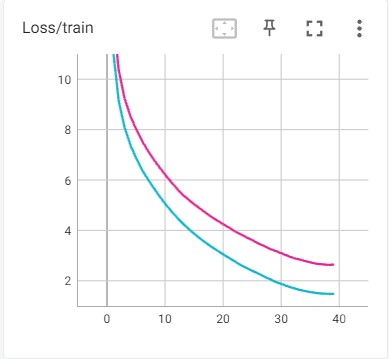

In [24]:
from IPython.display import Image
Image(filename='1.jpg', width=250, height=250)

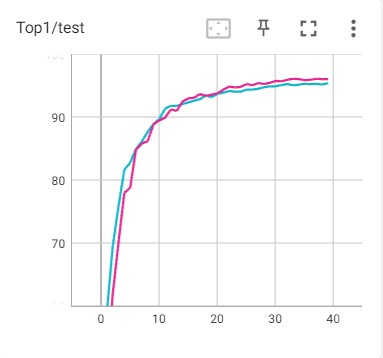

In [25]:
Image(filename='2.jpg', width=250, height=250)

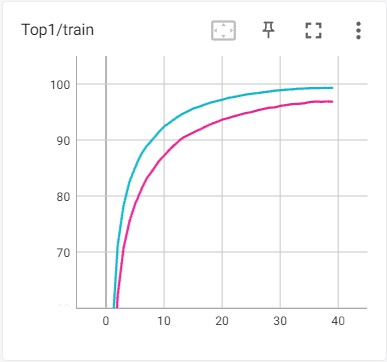

In [26]:
Image(filename='3.jpg', width=250, height=250)

**5. Контрольные вопросы**

1. Что такое верификация и идентицикация диктора?

2. Что такое распознавание диктора на закрытом и открытом множестве?

3. Что такое текстозависимое и текстонезависимое распознавание диктора?

4. Описать схему обучения блока генерации дикторских моделей на основе нейронных сетей.

5. Описать основные компоненты, из которых состоит нейросетевой блок генерации дикторских моделей (фреймовый уровень, слой статистического пулинга, сегментный уровень, выходной слой).

6. Как устроены нейросетевые архитектуры на основе ResNet-блоков?

7. Что такое полносвязная нейронная сеть прямого распространения?

8. Как устроена стоимостная функция для обучения нейросетевого блока генерации дикторских моделей?

9. Что такое аугментация данных?

10. Что такое дикторский эмбеддинг и на каком уровне блока построения дикторских моделей он генерируется?

**6. Список литературы**

1. Bai Z., Zhang X.-L., Chen J. Speaker recognition based on deep learning: an overview // 	arXiv:2012.00931 [eess.AS] ([ссылка](https://arxiv.org/pdf/2012.00931.pdf)).

2. Hansen J.H.L., Hasan T. Speaker recognition by machines and humans: a tutorial review // IEEE Signal Processing Magazine, 2015. V. 32. № 6. P. 74–99 ([ссылка](https://www.researchgate.net/publication/282940395_Speaker_Recognition_by_Machines_and_Humans_A_tutorial_review)).